# Moses IS-EN EN-IS phrase þýðingarvél
Sjá `README.md` til þess að keyra þetta vélrit (e. notebook).

Í þessu vélriti eru gögn forunnin og Moses þýðingarkerfið notað til þess búa til tvö þýðingarkerfi, IS-EN og EN-IS.
Það er gert ráð fyrir því að öll gögn séu aðgengileg undir `/work/data`. Sjá leiðbeiningar í `README.md` um hvernig það er gert með `docker` eða `singularity`.

Í stuttu máli skiptist vélritið í eftirfarandi þætti:
1. Samhliða og einhliða gögn undirbúin.
1. Tungumála módel byggt fyrir EN og IS (KenLM).
1. Texta skipt í þrjá hluta; train/val/test, fjöldi setninga í val/test er 3000/2000.
1. Moses kerfið þjálfað með train hluta texta.
1. Moses kerfið fínpússað með val hluta texta.
1. Moses kerfið metið með BLEU mælingin á test hluta texta.

Allar skrár og líkön eru raðað í skrána "WORKING_DIR" (sjá `README.md`).

Safnið `corpus.py` skilgreinir föll og gagnategundir sem eru mikið nýttar hér.

In [208]:
from collections import defaultdict, Counter, OrderedDict
import os
import pathlib
from pathlib import Path
import re
from pprint import pprint
import importlib
from typing import List

import matplotlib.pyplot as plt
import numpy as np

import corpus.corpus as c

importlib.reload(c)

%matplotlib notebook

working_dir = pathlib.Path('/work')
data_dir = working_dir.joinpath('data')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff/haukurpj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's be sure that Moses is installed and the data is there.

In [209]:
print(os.getenv('MOSESDECODER'))
print(os.getenv('MOSESDECODER_TOOLS'))
print(int(os.getenv('THREADS')))
!ls {data_dir}

/opt/moses
/opt/moses_tools
14
parice	rmh  usenet


In [210]:
# List of stages in processing
CAT = 'cat'
SHUFFLE = 'shuffle'
REGEXP = 'regexp'
SENT_FIX = 'sent_fix'
LOWER = 'lower'
TOKENIZE = 'tok'
PLACEHOLDERS = 'placeholders'
LENGTH = 'length'
LM = 'lm-blm'
TRAIN = 'train'
TEST = 'test'
VAL = 'val'
TRANSLATED_EN_IS = 'translated_en_is'
TRANSLATED_IS_EN = 'translated_is_en'

parice_dir = data_dir.joinpath('parice')
rmh_dir = data_dir.joinpath('rmh')

is_rmh_pipeline = {}

pipeline = [CAT,
            SENT_FIX, 
            LOWER, 
            REGEXP, 
            TOKENIZE,
            PLACEHOLDERS,
            LENGTH,
            LM,
            TRAIN,
            TEST,
            VAL,
            TRANSLATED_EN_IS,
            TRANSLATED_IS_EN
           ]

# If we are not starting from scratch - we try to load all intermediary stages
en_parice_pipeline = c.pipeline_load(parice_dir, pipeline, c.Lang.EN)
is_parice_pipeline = c.pipeline_load(parice_dir, pipeline, c.Lang.IS)
pprint(en_parice_pipeline)
pprint(is_parice_pipeline)

{'cat': PosixPath('/work/data/parice/cat.en'),
 'length': PosixPath('/work/data/parice/length.en'),
 'lm-blm': PosixPath('/work/data/parice/lm-blm.en'),
 'lower': PosixPath('/work/data/parice/lower.en'),
 'placeholders': PosixPath('/work/data/parice/placeholders.en'),
 'regexp': PosixPath('/work/data/parice/regexp.en'),
 'sent_fix': PosixPath('/work/data/parice/sent_fix.en'),
 'test': PosixPath('/work/data/parice/test.en'),
 'tok': PosixPath('/work/data/parice/tok.en'),
 'train': PosixPath('/work/data/parice/train.en'),
 'translated_en_is': PosixPath('/work/data/parice/translated_en_is.en'),
 'translated_is_en': None,
 'val': PosixPath('/work/data/parice/val.en')}
{'cat': PosixPath('/work/data/parice/cat.is'),
 'length': PosixPath('/work/data/parice/length.is'),
 'lm-blm': PosixPath('/work/data/parice/lm-blm.is'),
 'lower': PosixPath('/work/data/parice/lower.is'),
 'placeholders': PosixPath('/work/data/parice/placeholders.is'),
 'regexp': PosixPath('/work/data/parice/regexp.is'),
 'sen

### Einhliða málheild fyrir íslensku - RMH
Hér er unnið með risamálheildina þar sem búið er að sameina RMH1 og RMH2 í eina textaskrá með setningu í hverri línu. Þessi skrá er t.d. á Terra undir `/data/risamalheild/extras/rmh.txt` eða `/scratch/smt/data/rmh/rmh.txt`. Í kóðanum er gert ráð fyrir að hún sé aðgengileg undir `/work/data/rmh/rmh.txt`.

In [26]:
rmh = data_dir.joinpath('rmh/rmh.txt')
!wc -l {rmh}
print(*c.corpus_peek(rmh))

71257907 /work/data/rmh/rmh.txt
Mini er ekkert nýtt nafn í bílaflota Íslands en upp úr 1960 var Garðar Gíslason stórkaupmaður á Hverfisgötu 4 6 með umboð fyrir bresku Austin-verksmiðjurnar
 Austin Mini var vinsæll og ódýr bíll hér á Íslandi fram undir 1970
 Fyrstu Mini-bílarnir voru með kraftlitla 850cc vél og á 10 tommu felgum sem hentuðu ekki vel fyrir íslenska vegi
 Fyrir vikið var það Bjallan frá Volkswagen sem hafði vinninginn í smábílasölunni
 Frá síðustu aldamótum hefur Mini verið í eigu BMW og náð töluverðum vinsældum
 Árið 2012 byrjaði vel fyrir Mini en þá varð Mini X-Raid í fyrsta og öðru sæti í hinu fræga Dakarralli
 Árið eftir var Mini í fjórum fyrstu sætunum í sömu keppni en allt frá því hefur mig langað til að prófa fjórhjóladrifinn Mini
 Fjórhjóladrifið er samspil tveggja véla
 Að keyra bílinn er nánast hljóðlaust í rólegum akstri byrjar bíllinn á að nota rafmagnsmótorinn sem hefur um 40 km drægni fullhlaðinn en ef farið er upp fyrir 80 km hraða kemur bensínmótorinn inn


### Einhliða málheild fyrir ensku - USENET
Hér er unnið með USENET málheildina. Þessi skrá er t.d. á Terra undir `/data/usenet/WestburyLab.NonRedundant.UsenetCorpus.txt` eða `/scratch/smt/data/usenet/WestburyLab.NonRedundant.UsenetCorpus.txt`. Í kóðanum er gert ráð fyrir að hún sé aðgengileg undir `/work/data/usenet/WestburyLab.NonRedundant.UsenetCorpus.txt`.

Vísun í grein: Shaoul, C. & Westbury C. (2013) A reduced redundancy USENET corpus (2005-2011)  Edmonton, AB: University of Alberta (downloaded from http://www.psych.ualberta.ca/~westburylab/downloads/usenetcorpus.download.html)

In [29]:
usenet = data_dir.joinpath('usenet/WestburyLab.NonRedundant.UsenetCorpus.txt')
!wc -l {usenet}
print(*c.corpus_peek(usenet))

695885933 /work/data/usenet/WestburyLab.NonRedundant.UsenetCorpus.txt


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb9 in position 4581: invalid start byte

### Samhliðamálheild fyrir ensku og íslensku - ParIce
Hér er unnið með ParIce málheildina. Þessar skrár er t.d. á Terra undir `/data/parice/*.tmx` eða `/scratch/smt/data/parice/*.tmx`. Í kóðanum er gert ráð fyrir að þær séu aðgengilegar undir `/work/data/parice/*.tmx`. Fyrst þarf þó aðeins að lagfæra skrárnar svo þær séu allar með sama tungumála merki.

In [30]:
!grep -m 2 "lang=\"is\"" {data_dir}/parice/*.tmx
!grep -m 2 "lang=\"en\"" {data_dir}/parice/*.tmx

^C
/work/data/parice/ema.tmx:  <header adminlang="EN-US" creationdate="20170426T083707Z" creationtool="Moses-to-TMX-converer" creationtoolversion="1.0" datatype="plaintext" o-tmf="Moses plain text files" segtype="sentence" srclang="en">
/work/data/parice/hagstofan.tmx:  <header adminlang="en" creationdate="20170319T213035Z" creationtool="mALIGNa" creationtoolversion="2" datatype="plaintext" o-tmf="al" segtype="block" srclang="en">


In [12]:
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {data_dir}/parice/hagstofan.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {data_dir}/parice/hagstofan.tmx
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {data_dir}/parice/ema.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {data_dir}/parice/ema.tmx

In [13]:
!grep -m 2 "lang=\"is\"" {data_dir}/parice/*.tmx
!grep -m 2 "lang=\"en\"" {data_dir}/parice/*.tmx

data/ema.tmx:  <header adminlang="EN-US" creationdate="20170426T083707Z" creationtool="Moses-to-TMX-converer" creationtoolversion="1.0" datatype="plaintext" o-tmf="Moses plain text files" segtype="sentence" srclang="en">
data/hagstofan.tmx:  <header adminlang="en" creationdate="20170319T213035Z" creationtool="mALIGNa" creationtoolversion="2" datatype="plaintext" o-tmf="al" segtype="block" srclang="en">


In [38]:
tmx_files = !ls {data_dir}/parice/*.tmx
tmx_files = [Path(tmx_file) for tmx_file in tmx_files]
pprint(tmx_files)

[PosixPath('/work/data/parice/baekur.tmx'),
 PosixPath('/work/data/parice/biblian.tmx'),
 PosixPath('/work/data/parice/ees.tmx'),
 PosixPath('/work/data/parice/ema.tmx'),
 PosixPath('/work/data/parice/eso.tmx'),
 PosixPath('/work/data/parice/fornritin.tmx'),
 PosixPath('/work/data/parice/hagstofan.tmx'),
 PosixPath('/work/data/parice/kde4.tmx'),
 PosixPath('/work/data/parice/opensubtitles.tmx'),
 PosixPath('/work/data/parice/tatoeba.tmx'),
 PosixPath('/work/data/parice/ubuntu.tmx')]


Sækjum nú málheildirnar úr .tmx skjölunum.

In [41]:
parice = c.tmx_split_(tmx_files, 'EN-GB', 'IS-IS')
en_parice, is_parice = zip(*parice)

/work/data/parice/baekur.tmx -> /work/data/parice/baekur.en + /work/data/parice/baekur.is
/work/data/parice/biblian.tmx -> /work/data/parice/biblian.en + /work/data/parice/biblian.is
/work/data/parice/ees.tmx -> /work/data/parice/ees.en + /work/data/parice/ees.is
/work/data/parice/ema.tmx -> /work/data/parice/ema.en + /work/data/parice/ema.is
/work/data/parice/eso.tmx -> /work/data/parice/eso.en + /work/data/parice/eso.is
/work/data/parice/fornritin.tmx -> /work/data/parice/fornritin.en + /work/data/parice/fornritin.is
/work/data/parice/hagstofan.tmx -> /work/data/parice/hagstofan.en + /work/data/parice/hagstofan.is
/work/data/parice/kde4.tmx -> /work/data/parice/kde4.en + /work/data/parice/kde4.is
/work/data/parice/opensubtitles.tmx -> /work/data/parice/opensubtitles.en + /work/data/parice/opensubtitles.is
/work/data/parice/tatoeba.tmx -> /work/data/parice/tatoeba.en + /work/data/parice/tatoeba.is
/work/data/parice/ubuntu.tmx -> /work/data/parice/ubuntu.en + /work/data/parice/ubuntu.i

Athugum hvort allt líti rétt út.

In [44]:
for corpus in en_parice + is_parice:
    pprint(c.corpus_info_formatted(corpus))

'/work/data/parice/baekur.en                1007.5KiB        12416'
'/work/data/parice/biblian.en                4.2MiB          65241'
'/work/data/parice/ees.en                   162.8MiB       1701172'
'/work/data/parice/ema.en                    39.1MiB        404333'
'/work/data/parice/eso.en                    1.7MiB          12633'
'/work/data/parice/fornritin.en              1.6MiB          17597'
'/work/data/parice/hagstofan.en             209.8KiB          2288'
'/work/data/parice/kde4.en                   1.6MiB          49912'
'/work/data/parice/opensubtitles.en          38.5MiB       1261398'
'/work/data/parice/tatoeba.en               287.6KiB          8263'
'/work/data/parice/ubuntu.en                248.1KiB         10572'
'/work/data/parice/baekur.is                 1.2MiB          12416'
'/work/data/parice/biblian.is                4.2MiB          65241'
'/work/data/parice/ees.is                   171.5MiB       1701172'
'/work/data/parice/ema.is                    42.

Sameinum ParIce gögnin fyrir hvert mál.

In [43]:
en_parice_pipeline[CAT] = c.corpora_create_path(en_parice, CAT)
is_parice_pipeline[CAT] = c.corpora_create_path(is_parice, CAT)
c.corpora_combine(en_parice, en_parice_pipeline[CAT])
c.corpora_combine(is_parice, is_parice_pipeline[CAT])

True

In [45]:
pprint(c.corpus_info_formatted(en_parice_pipeline[CAT]))
pprint(c.corpus_info_formatted(is_parice_pipeline[CAT]))

'/work/data/parice/cat.en                   251.3MiB       3545825'
'/work/data/parice/cat.is                   265.8MiB       3545825'


### Laga setningabrot
Á nokkrum stöðum í íslenska textanum vantar bil á eftir punkti og tilreiðirinn nær ekki að brjóta þær setningar. Samsvarandi setningar í ensku eiga líka við þetta vandamál, en í minna mælli. Við reynum að vera íhaldsöm og setjum bara bil á milli þegar hástafur kemur eftir punkt á undan tveimur stöfum.

Dæmi:

In [84]:
expression = '[^|[:blank:]|[:alpha:]]{2,}\.[[:alpha:]]{1,}'
!grep -n -i -m 2 -E 'viðauka.skipunar' {is_parice_pipeline[CAT]}

82213:Prófunin skal fara fram í samræmi við viðmiðunarlotuna í 4. viðbæti, III. viðauka.Skipunarstillipunktar fyrir snúningshraða og snúningsvægi skulu gefnir út með 5 Hz tíðni eða meiri (mælt er með 10 Hz).


In [88]:
regexps = [
    (re.compile(r'([\w\(\)\[\]\.]{2,})\.([A-ZÁÐÉÍÓÚÝÞÆÖ])') , r'\1. \2')
]
en_parice_pipeline[SENT_FIX] = c.corpus_create_path(en_parice_pipeline[CAT], SENT_FIX)
is_parice_pipeline[SENT_FIX] = c.corpus_create_path(is_parice_pipeline[CAT], SENT_FIX)

c.corpus_regexp(en_parice_pipeline[CAT], en_parice_pipeline[SENT_FIX], regexps=regexps)
c.corpus_regexp(is_parice_pipeline[CAT], is_parice_pipeline[SENT_FIX], regexps=regexps)

True

Okkur tókst að laga þessa tilteknu setningu. Sjá `test_corpus.py` fyrir nánari prófanir.

In [89]:
!sed '82213q;d' {is_parice_pipeline[SENT_FIX]}

Prófunin skal fara fram í samræmi við viðmiðunarlotuna í 4. viðbæti, III. viðauka. Skipunarstillipunktar fyrir snúningshraða og snúningsvægi skulu gefnir út með 5 Hz tíðni eða meiri (mælt er með 10 Hz).


### Setja öll orð í lágstafi og samhæfa unicode
Hér setjum við öll tákn í lágstafi og samhæfum unicode gildi stafa sem gætu notað fleiri en eina táknun.

Það er mjög vafasamt að setja öll tákn í lágstafi og það mun búa til tvíræðni í texta, sbr. "Ég er í Símanum" og "Ég er í símanum". Hástafir í byrjun orðs er ekki mikið vandamál og auðveldlega hægt að laga í eftirvinnslu þýðinga. Hástafir í nöfnum (e. named entities) væri hægt að vinna betur með aðkomu nafnaþekkjara (e. named-entity recognizer). Við komum því aftur að þessu vandamáli síðar.

In [90]:
en_parice_pipeline[LOWER] = c.corpus_create_path(en_parice_pipeline[SENT_FIX], LOWER)
is_parice_pipeline[LOWER] = c.corpus_create_path(is_parice_pipeline[SENT_FIX], LOWER)

c.corpus_lowercase_normalize(en_parice_pipeline[SENT_FIX], en_parice_pipeline[LOWER], threads=int(os.getenv('THREADS')))
c.corpus_lowercase_normalize(is_parice_pipeline[SENT_FIX], is_parice_pipeline[LOWER], threads=int(os.getenv('THREADS')))

True

In [8]:
print(*c.corpus_peek(en_parice_pipeline[LOWER]))

book i
 chapter i a fete at the new palace
 "yes, sire, since yesterday."
 these words were exchanged about two hours after midnight, at the moment when the fete given at the new palace was at the height of its splendor.
 two or three of these astute politicians-physiognomists by virtue of their profession-failed not to detect on the countenance of their host symptoms of disquietude, the source of which eluded their penetration;
 but none ventured to interrogate him on the subject.
 it was evidently the intention of the officer of chasseurs that his own anxieties should in no way cast a shade over the festivities; and, as he was a personage whom almost the population of a world in itself was wont to obey, the gayety of the ball was not for a moment checked.
 nevertheless, general kissoff waited until the officer to whom he had just communicated the dispatch forwarded from tomsk should give him permission to withdraw; but the latter still remained silent.
 he had taken the telegram, he 

### Tilreiðir
Núna notum við TokTok tilreiðarann fyrir ensku og tilreiðarann fyrir íslensku frá Miðeind.

In [91]:
en_parice_pipeline[TOKENIZE] = c.corpus_create_path(en_parice_pipeline[LOWER], TOKENIZE)
is_parice_pipeline[TOKENIZE] = c.corpus_create_path(is_parice_pipeline[LOWER], TOKENIZE)

c.corpus_tokenize(en_parice_pipeline[LOWER], en_parice_pipeline[TOKENIZE], method= "toktok")
c.corpus_tokenize(is_parice_pipeline[LOWER], is_parice_pipeline[TOKENIZE], method= "pass-through")


True

In [92]:
print(*c.corpus_peek(is_parice_pipeline[TOKENIZE]))

fyrri þáttur
 i . veizlan í nýju höllinni .
 „ já , herra . var höggvinn í gær . “
 það var tveimur stundum eftir miðnætti að þessi orð voru töluð , einmitt þegar sem hæst stóð gleðin og glaumurinn í nýju höllinni , sem vígð var með veizlu þessari .
 tveir eða þrír af þessum erlendu , skarpskygnu , stjórnfræðingum þóttust greinilega merkja ókyrleik á svip hans , en hvað olli því , var nokkuð , sem þeir ekki gátu gruflað upp og enginn leyfði sér að spyrja hann hvað áhyggjuefnið væri .
 það var greinilega ætlun hans , að áhyggjur hans á engan hátt köstuðu skugga á gleðina .
 og þar sem hann var einn af heim fáu mönnum , sem margmenni , nærri nóg til að byggja heilan heim út af fyrir sig , var vant við að hlýða , var gleðin ekki takmörkuð hið allra minnsta .
 kissoff hershöfðingi hafði komið með annað skeyti frá tomsk , hafði fengið það öðrum hershöfðingja og beið svo eftir vísbendingu frá honum , að hann mætti fara .
 þessi þegjandalegi stóri maður tók við skeytinu án þess að mæla orð , 

### Fjarlægja slæm tákn
Hér fjarlægjum við vefslóðir/tölvupósta og fleira (URI) og tóma hornklofa og sviga (sem koma oft fram í gögnunum). Þar sem við notuðum TokTok og Miðeind sem tilreiðara, þá var ekki átt við URIs (Moses og NLTK brjóta URIs upp).

Til þess að búa til betra mállíkan setjum leppinn `@uri@` í stað strengins. Þetta hefur þær afleiðingar að fjöldi tákna í textanum fækkar umtalsvert, sem gerir þýðingar auðveldari. Þetta skref er hægt að lagfæra í eftirvinnslu þýðingar (en þarf þó betri útfærslu, ef t.d. tvær vefslóðir koma fyrir í setningu). Reglulega segðin sem er notuð er ekki fullkomin og mun hugsanlega grípa of mörg tákn.

Tómir hornklofar og svigar hafa enga merkingu og er í raun galli í gögnunum. Þeir eru fjarlægðir.

Þessi segð tekur of mörg dæmi sem ætti annars ekki að túlka sem URI t.d. 
- "o.s.frv;" setning 113892
- "o.s.frv" setning 106218
- "10.gr." setning 130268

Við leyfum þessu að liggja á milli hluta.

In [97]:
# Taken from https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url?noredirect=1&lq=1
regexps = [
    (re.compile(r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"), '@uri@'),
    (re.compile(r"[\[\(]\s*[\]\)]"), "")
]
en_parice_pipeline[REGEXP] = c.corpus_create_path(en_parice_pipeline[TOKENIZE], REGEXP)
is_parice_pipeline[REGEXP] = c.corpus_create_path(is_parice_pipeline[TOKENIZE], REGEXP)

c.corpus_regexp(en_parice_pipeline[TOKENIZE], en_parice_pipeline[REGEXP], regexps=regexps)
c.corpus_regexp(is_parice_pipeline[TOKENIZE], is_parice_pipeline[REGEXP], regexps=regexps)

True

In [105]:
!sed '130268q;d' {is_parice_pipeline[SENT_FIX]}

a) skulu aðildarríki ekki lengur gefa út skjalið sem um getur í síðasta undirlið 1. mgr. 10.gr. tilskipunar 70/156/EBE fyrir gerð ökutækis ef aðalljós eða perur þess eru ekki í samræmi við ákvæði þessarar tilskipunar.


In [98]:
!grep -n -m 30 @uri@ {is_parice_pipeline[REGEXP]}

95902:glerið sem er notað í hámarksálestrarbúnaðinn og hárpípuna verður að hafa nægilegt viðnám gegn @uri@ ( 1 )
99187:frekari upplýsingar um hvernig gildandi kerfi og hnattsamræmda kerfið ( hsk ) skarast má finna í vii . viðauka í iii . bindi tillögunnar sem var samþykkt : @uri@
99188:• sérfræðinganefnd sameinuðu þjóðanna um flutning á hættulegum varningi og um hnattsamræmda kerfið til flokkunar og merkingar á íðefnum : @uri@
99320:„ frekari upplýsingar um það hvers vegna þessari vöru hefur verið veitt „ blómið “ fást á vefsetrinu : @uri@ “ .
99499:frekari upplýsingar um hvernig gildandi kerfi og hnattsamræmda kerfið ( hsk ) skarast má finna í vii . viðauka í iii . bindi tillögunnar sem var samþykkt : @uri@
99500:• sérfræðinganefnd sameinuðu þjóðanna um flutning á hættulegum varningi og um hnattsamræmda kerfið til flokkunar og merkingar á íðefnum : @uri@
99597:„ frekari upplýsingar um það hvers vegna þessari vöru hefur verið veitt „ blómið “ fást á vefsetrinu : @uri@ . “
99774:„ unnt 

### Skoða tölfræði
Skoðum nú hversu langar setningarnar eru til þess að fá hugmynd um gagnasafnið.

In [106]:
def draw_bar_plot(title, counter):
    labels, values = zip(*sorted(counter.items()))

    indexes = np.arange(len(labels))
    width = 1

    plt.figure(figsize=(9,9))
    plt.bar(indexes, values, width)
    plt.title(title)
    plt.rc('xtick', labelsize=4)
    plt.rc('ytick', labelsize=4) 
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

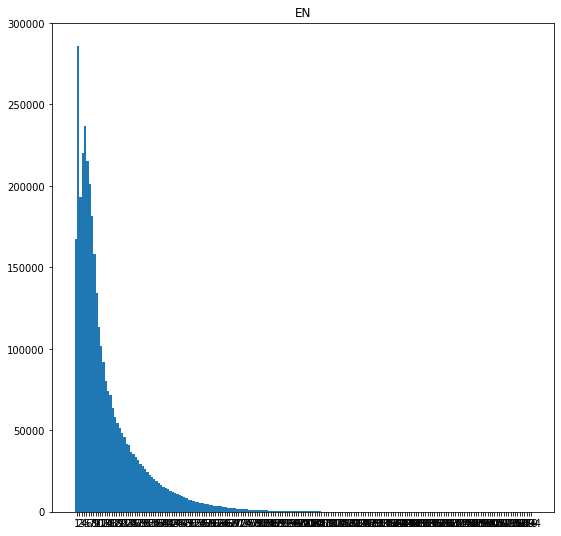

In [107]:
draw_bar_plot("EN", c.corpus_sentence_counter(en_parice_pipeline[REGEXP]))
    

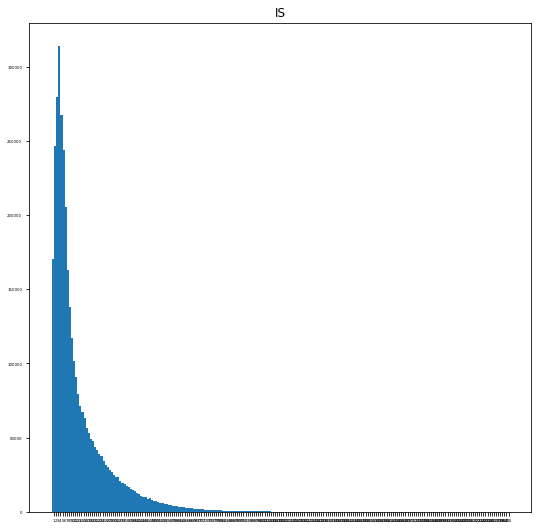

In [108]:
draw_bar_plot("IS", c.corpus_sentence_counter(is_parice_pipeline[REGEXP]))
    

### Fjöldi tákna og tíðni

In [109]:
en_counter = c.corpus_token_counter(en_parice_pipeline[REGEXP])
is_counter = c.corpus_token_counter(is_parice_pipeline[REGEXP])

Fjöldi mismunandi orða.

In [110]:
pprint(len(en_counter))
pprint(len(is_counter))

377617
630224


In [115]:
import random
pprint(random.sample(is_counter.most_common(), 30))

[('samframleiðslusjóði', 1),
 ('thromboxane', 2),
 ('ਨਵ', 1),
 ('androvsky', 1),
 ('unglingaþunganir', 1),
 ('aukanæringarefnum', 2),
 ('ikla', 1),
 ('þrífosfatafleiðu', 1),
 ('smyglurum', 3),
 ('flugnotendum', 1),
 ('6699', 1),
 ('mesórídazín', 5),
 ('röndum', 37),
 ('weissburgunder', 6),
 ('opnaðrar', 1),
 ('netsökklum', 1),
 ('skýrslugjafarskyldan', 2),
 ('longnose', 1),
 ('hálsklaufarinnar', 1),
 ('vindillinn', 4),
 ('backcolorintranet', 1),
 ('dýfðum', 2),
 ('rífampicín', 88),
 ('lífvistgerð', 1),
 ('sannvottun', 235),
 ('20/06/2007', 1),
 ('papriku', 33),
 ('5.2.2.4.3.3.1.2', 4),
 ('valdsviðinu', 1),
 ('lítilsvirtir', 3)]


Fjöldi orða.

In [112]:
pprint(f"{'Ensk orð: ':<20}{sum(value for key, value in en_counter.items()):>15}")
pprint(f"{'Íslensk orð: ':<20}{sum(value for key, value in is_counter.items()):>15}")

'Ensk orð:                  50010792'
'Íslensk orð:               46798771'


### Slæmar línur
Sumar línur innihalda ekki góð gögn. Dæmi um slæmar línur eru línur sem innihalda hvorki íslensk né enskar orð, íslenskar setningar innihalda mörg ensk orð, setningar sem innihalda mikið af texta úr öðru máli
3542841, 3543522, 3544806, 108198, 841961, 1926329, 694806, 2414852, 3543522, 1064877, 1138771, 1143444

In [ ]:
IS:('timing', 1),
 ('entering', 1),
 ('purchaser', 1),
    reductions
    лоза
    symptomatic
EN: Ψuχάρη
    Níκαια
    rūgušpiens
    Георги

In [56]:
word = "timing".casefold()
is_file = pipeline[TOKENIZE].IS.get_filepath()
en_file = pipeline[TOKENIZE].EN.get_filepath()
!grep -n -C 2 {word} {is_file}
!grep -n -C 2 {word} {en_file}

2215208-um breyttar skilgreiningar á undirvísitölum : commission regulation ( ec ) no 1749 / 1999 of 23 july 1999 amending regulation ( ec ) no 2214 / 96 , concerning the sub - indices of the harmonized indices of consumer prices ( oj l 214 , 13.8.1999 , p . 1 )
2215209-um reglur við að taka menntun og heilsugæslu inn í vísitöluna : council regulation ( ec ) no 2166 / 1999 of 8 october 1999 laying down detailed rules for the implementation of regulation ( ec ) no 2494 / 95 as regards minimum standards for the treatment of products in the health , education and social protection sectors in the harmonized index of consumer prices ( oj l 266 , 14.10.1999 , p . 1 )
2215210:um hvenær taka á verð með í útreikninginn : commision regulation ( ec ) no 2601 / 2000 of 17 november 2000 laying down detailed rules for the implementation of regulation ( ec ) no 2494 / 95 as regards the timing of entering purchaser prices into the harmonized index of consumer prices ( oj l 300 , 29.11.2000 , p . 14 )


--
454233-the assessment shall cover the phases and characteristics as indicated in table ii . 5 of annex ii to this tsi .
454234-• implementing the maintenance tsi
454235:• implementation procedure and timing
454236-• procedure
454237-the implementation of the specifications on maintenance equipment are based on the following general steps :
--
454240-step 2 :
454241-an economic study is carried out by both the infrastructure manager and the railway undertaking , on the basis of which the initial roster may be modified .
454242:• timing
454243-because of :
454244-• the time needed to build or modify the fixed installations , and to put into place the mobile toilet discharge trolleys ,
454245-• the principle by which compliance with interoperability requirements of the already existing fixed installations is only possible if incorporated into long - term renewal and repair schedules ,
454246:the timing of implementation will have to be negotiated between the infrastructure manager and 

--
912276-body weight may be the best indicator of physical development .
912277-measure ment of developmental landmarks is , therefore , recommended only when there is prior evidence that these endpoints will provide additional information .
912278:timing for the assessment of these parameters is indicated in table 1. depending on the anticipated effects , and the results of the initial measurements , it may be advisable to add ad ditional time points or to perform the measurements in other developmental stages .
912279-• it is advisable to use post - coital age instead of postnatal age when assessing physical development ( 33 ) .
912280-if pups are tested on the day of weaning , it is recommended that this testing be carried out prior to actual weaning to avoid a confounding effect by the stress associated with weaning .
912281-in addition , any post - weaning testing of pups should not occur during the two days after weaning .
912282-table 1
912283:timing of the assessment of physic

--
1376680-however , self - review threats can arise if , for example , there is not a clear separation between the management and control of the internal audit and the internal audit activities themselves , or if the statutory auditor's evaluation of his audit client's internal control system determines the kind and volume of his subsequent statutory audit procedures .
1376681-to avoid such threats , the statutory auditor , the audit firm or its network member must be able to show that it is not involved in management and control of the internal audit .
1376682:furthermore , in his capacity as the statutory auditor of the client's financial statements the statutory auditor must be able to demonstrate that he has taken appropriate steps to have the results of the internal audit work reviewed and has not placed undue reliance on these results in establishing the nature , timing and extent of his statutory audit work .
1376683-in order to ensure that the audit firm's statutory audit work

--
1932812-if you are not ovulating and have irregular or no periods
1932813-if you are not ovulating and have irregular or no periods .
1932814:if you are not ovulating and if the recommended dose and timing are followed , the occurrence of ohss is less likely .
1932815-if you are not ovulating , have no periods and have been diagnosed with very low levels of fsh and lh hormones
1932816-if you are not ovulating , having no periods and have been diagnosed with very low levels of fsh and lh hormones
--
1944478-immunogenicity and safety of ixiaro in children and adolescents from a jev - endemic country
1944479-immunogenicity and safety of prevenar 13 has been demonstrated in adults aged 18 years and older including those previously vaccinated with a pneumococcal polysaccharide vaccine .
1944480:immunogenicity assay results are highly dependent on several factors including assay sensitivity and specificity , assay methodology , assay robustness to quantities of gazyvaro / antibody in the 

2487683-i ain't gonna ask you again .
2487684-shut up , doris .
2487685:keep timing .
2487686-hey , mae , how long ?
2487687-boy , that was some good peeing .
--
2489599-if i leave it on the stock too long , it rots on the way to market .
2489600-too much rain turns it mouldy , too little and it's hog - feed .
2489601:timing's everything .
2489602-same as in my business .
2489603-you gotta pick'em while they're ripe .
--
2510883-good day , sir .
2510884-it's turning the eggs .
2510885:perfect timing .
2510886-i ‚ d hoped they ‚ d hatch before i had to go to the boat .
2510887-henry , why didn't you tell me ?
--
2513710-i started making notes about what he meant to me : surrogate father , mentor , you know .
2513711-i started to get very thirsty .
2513712:not the greatest timing .
2513713-you're here to study law , not keep me sober .
2513714-it's alice .
--
2522230-scar ?
2522231-drop him .
2522232:impeccable timing , your majesty .
2522233-why , if it isn't my big brother descending f

--
3408438-yes .
3408439-but she changed .
3408440:it's about timing .
3408441-and the first time around , we weren't ready to work at it and now we are .
3408442-and besides , caroline is way hotter than that voice in my head who sounds like tom waits and tells me i'm a failure and i look bad in hats .
--
3408483-take off your skis and wait for your family in the lodge , jessica day .
3408484-look , this could be good .
3408485:paul and i had bad timing before .
3408486-and maybe i should just give it another shot .
3408487-such an ugly crier .
--
3408793-and it made me realize something .
3408794-you're wrong .
3408795:all the stuff you said about caroline being about timing and it just making sense ?
3408796-because if you really love someone , it's simple .
3408797-i understand what you're saying , but - you deserve something amazing .
--
3424749-william is better looking .
3424750-and he's a great guy .
3424751:and she's here being a two - timing …
3424752-whore . montana . taylor

### Stokka gögn
Svo ruglum við línunum, en pössum að rugla textunum með sömu línum.

In [119]:
# the corpus_shuffle reads some bytes from the seed file and uses as a seed.
seed_file = en_parice_pipeline[REGEXP]
en_parice_pipeline[SHUFFLE] = c.corpus_create_path(en_parice_pipeline[REGEXP], SHUFFLE)
is_parice_pipeline[SHUFFLE] = c.corpus_create_path(is_parice_pipeline[REGEXP], SHUFFLE)

c.corpus_shuffle(en_parice_pipeline[REGEXP], en_parice_pipeline[SHUFFLE], seed_file)
c.corpus_shuffle(is_parice_pipeline[REGEXP], is_parice_pipeline[SHUFFLE], seed_file)

True

In [122]:
print(*c.corpora_peek([is_parice_pipeline[SHUFFLE], en_parice_pipeline[SHUFFLE]]))

is: eins og tittlingur .
 en: like prick .
 is: hvað ?
 en: what ?
 is: alvarlegt cýtókínlosunarheilkenni lýsir sér með mikilli andnauð , sem oft fylgja berkjukrampar og súrefnisskortur , auk hita , hrolls , stirðleika , ofsakláða og ofsabjúgs .
 en: severe cytokine release syndrome is characterised by severe dyspnea , often accompanied by bronchospasm and hypoxia , in addition to fever , chills , rigors , urticaria , and angioedema .
 is: dagur 10 1000 / 100 mg ( n = 21 )
 en: day 10 1000/100 mg ( n=21 )
 is: færa skal rök fyrir því þegar váhrifatíminn er styttri en 6 klst . á dag . sjá einnig kafla
 en: a rationale should be provided when using an exposure duration of less than 6 hours per day .
 is: 4. sú staða bújarðar að teljast laus við nautgripaherpesveiru af stofni 1 , sem var felld úr gildi í samræmi við 3. lið , skal einungis endurheimt eftir að sermifræðileg rannsókn til að greina mótefni gegn nautgripaherpesveiru af stofni 1 , sem hefst ekki fyrr en 30 dögum eftir að sermij

### Bæta við leppum
Við bætum við leppum í stað sumra stafa sem Moses skilur öðruvísi (og síðar í stað annarra sérstakra gilda eins og talna og nafna). Leppirnir eru markaðir með @-merki í byrjun og enda, t.d. @pipe@.

In [131]:
# u'\u007c' - |
pipe_reg = re.compile(r"\u007c")
# u'\u003c', u'\u003e' - <, >
lt_reg = re.compile(r"\u003c")
gt_reg = re.compile(r"\u003e")

# u'\u005b', u'\u005d' - [, ]
bracket_open_reg = re.compile(r"\u005b")
bracket_close_reg = re.compile(r"\u005d")

# We map these special characters to placeholders
regexps = [
    (pipe_reg, '@pipe@'),
    (lt_reg, '@lt@'),
    (gt_reg, '@gt@'),
    (bracket_open_reg, '@brac_open@'),
    (bracket_close_reg, '@brac_close@')
]
en_parice_pipeline[PLACEHOLDERS] = c.corpus_create_path(en_parice_pipeline[SHUFFLE], PLACEHOLDERS)
is_parice_pipeline[PLACEHOLDERS] = c.corpus_create_path(is_parice_pipeline[SHUFFLE], PLACEHOLDERS)

c.corpus_regexp(en_parice_pipeline[SHUFFLE], en_parice_pipeline[PLACEHOLDERS], regexps=regexps)
c.corpus_regexp(is_parice_pipeline[SHUFFLE], is_parice_pipeline[PLACEHOLDERS], regexps=regexps)

True

In [134]:
!grep '@pipe@' -m 3 {is_parice_pipeline[PLACEHOLDERS]}

allir frestir sem aðildarríki veita í samræmi við 46. grein reglugerðar ( eb ) númer 1107 / 2009 skulu vera eins stuttir og unnt er og skulu renna út eigi síðar en 12 mánuðum eftir að ylènrpdqgl oh \ ¿ hux diwxun @pipe@ ooxè
upplýsinga- og fjarskiptatækni gegnir veigamiklu hlutverki þar sem hún leggur til helstu grundvallarinnviði , w nql rj nhu ¿ wlo didu ìêèlqjduplnlood hiqdkdjvohjud rj ipodjvohjud ihuod rj qêmdu y @pipe@ uxu rj ìmyqxvwx i yhjxp
bæti fyllingarvísis @pipe@ @pipe@ dulmálstexti ( einfalt gildi ekki kóðað með ber - tlv )


### Tungumála módel
Við notum svo KenLM tungumála módelið til þess að gefa okkur líkindi setninga. Til að flýta uppflettingum þá tungumála módelið samtímis kjörsniðið.

In [143]:
def create_lm(path, out_path, order):
    tmp_arpa = c.corpus_create_path(path, 'arpa')
    !{os.getenv('MOSESDECODER')}/bin/lmplz -S 70% -o {order} < {path} > {tmp_arpa}
    !{os.getenv('MOSESDECODER')}/bin/build_binary -S 70% {tmp_arpa} {out_path}
    return True

is_parice_pipeline[LM] = c.corpus_create_path(is_parice_pipeline[PLACEHOLDERS], LM)
en_parice_pipeline[LM] = c.corpus_create_path(en_parice_pipeline[PLACEHOLDERS], LM)

create_lm(is_parice_pipeline[PLACEHOLDERS], is_parice_pipeline[LM], order=3)
create_lm(en_parice_pipeline[PLACEHOLDERS], en_parice_pipeline[LM], order=3)

=== 1/5 Counting and sorting n-grams ===
Reading /work/data/parice/placeholders.is
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 46795719 types 630226
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:7562712 2:32821551104 3:61540409344
Statistics:
1 630226 D1=0.660554 D2=1.06828 D3+=1.39989
2 5487865 D1=0.745801 D2=1.11531 D3+=1.42142
3 14041940 D1=0.703249 D2=1.17986 D3+=1.46853
Memory estimate for binary LM:
type     MB
probing 382 assuming -p 1.5
probing 416 assuming -r models -p 1.5
trie    169 without quantization
trie    100 assuming -q 8 -b 8 quantization 
trie    159 assuming -a 22 array pointer compression
trie     90 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:7562712 2:87805840 3:280838800
----

True

Prófa tungumála módel, það ættu ekki að vera nein óþekkt orð.

In [144]:
def eval_sentence(lm_model, sentence):
   !echo "{sentence}" | {os.getenv('MOSESDECODER')}/bin/query {lm_model}

eval_sentence(is_parice_pipeline[LM], "þetta er flott íslensk setning , er það ekki ?")
eval_sentence(en_parice_pipeline[LM], "this is a nice english sentence , right ?")

þetta=127 2 -1.9087435	er=46 3 -0.25087792	flott=9432 3 -2.4740396	íslensk=1026 1 -6.075294	setning=11123 1 -6.0032997	,=16 2 -1.7541649	er=46 2 -2.10207	það=121 3 -0.9876065	ekki=86 3 -0.7613512	?=8 3 -0.8201859	</s>=2 3 -0.010233481	Total: -23.147867 OOV: 0
Perplexity including OOVs:	127.16030586883019
Perplexity excluding OOVs:	127.16030586883019
OOVs:	0
Tokens:	11
Name:query	VmPeak:411812 kB	VmRSS:5000 kB	RSSMax:396456 kB	user:0.004029	sys:0.048348	CPU:0.052377	real:0.050345
this=116 2 -1.8216333	is=12 3 -0.67676663	a=37 3 -0.99580556	nice=292 3 -2.8647187	english=2279 1 -4.5088124	sentence=3700 1 -5.088436	,=16 2 -1.1383209	right=750 2 -3.7733178	?=7 3 -0.14296547	</s>=2 3 -0.03417346	Total: -21.04495 OOV: 0
Perplexity including OOVs:	127.20232474150723
Perplexity excluding OOVs:	127.20232474150723
OOVs:	0
Tokens:	10
Name:query	VmPeak:324040 kB	VmRSS:4896 kB	RSSMax:308580 kB	user:0	sys:0.043217	CPU:0.043217	real:0.0409277


### Stytta/Hreinsa gögn
Við þurfum að stytta langar setningar, eyða tómum línum, fjarlægja óleyfilega unicode chars og pör af setningum sem eru of langar miðað við samhliða setningu. Við höldum setningum á milli 1 og 100 orð (til og með). Þetta fall tekur inn samhliðamálheild og því eru nafnavenjur eitthvað öðruvísi.

In [154]:
 def corpus_shorten(path, path_out, lang_id_1, lang_id_2, min_length, max_length):
    !{os.getenv('MOSESDECODER')}/scripts/training/clean-corpus-n.perl {path} {lang_id_1} {lang_id_2} {path_out} {min_length} {max_length}
    return True

path_out = is_parice_pipeline[PLACEHOLDERS].with_name(LENGTH)
path = is_parice_pipeline[PLACEHOLDERS].parent.joinpath(PLACEHOLDERS)
corpus_shorten(path, path_out, 'en', 'is', 1, 100)

is_parice_pipeline[LENGTH] = is_parice_pipeline[PLACEHOLDERS].with_name(LENGTH).with_suffix('.is')
en_parice_pipeline[LENGTH] = en_parice_pipeline[PLACEHOLDERS].with_name(LENGTH).with_suffix('.en')

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = "en_US:en",
	LC_ALL = (unset),
	LC_CTYPE = "C.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
clean-corpus.perl: processing /work/data/parice/placeholders.en & .is to /work/data/parice/length, cutoff 1-100, ratio 9
..........(100000)..........(200000)..........(300000)..........(400000)..........(500000)..........(600000)..........(700000)..........(800000)..........(900000)..........(1000000)..........(1100000)..........(1200000)..........(1300000)..........(1400000)..........(1500000)..........(1600000)..........(1700000)..........(1800000)..........(1900000)..........(2000000)..........(2100000)..........(2200000)..........(2300000)..........(2400000)..........(2500000)..........(2600000)..........(2700000)..........(2800000)..........(2900000)..........(3000000)..........(3100000)..........(3

True

### Skipta gögnum
Núna skiptum við gögnunum í train/val/test. Við höfum 2000 setningar í val og 3000 setningar í test.

Train gögnin eru nýtt í þjálfun á Moses, val í fínpússun og loks test til þess að meta þýðingarnar. Til þess að ná fram þessari skiptingu þá tökum við fyrstu línurnar fyrir train gögnin, svo val gögnin og síðustu línurnar fara í test gögnin. Þess vegna er mikilvægt að það sé búið að stokka gögnin á þessum tímapunkti.

In [159]:
is_parice_pipeline[TRAIN] = c.corpus_create_path(is_parice_pipeline[LENGTH], TRAIN)
is_parice_pipeline[TEST] = c.corpus_create_path(is_parice_pipeline[LENGTH], TEST)
is_parice_pipeline[VAL] = c.corpus_create_path(is_parice_pipeline[LENGTH], VAL)
en_parice_pipeline[TRAIN] = c.corpus_create_path(en_parice_pipeline[LENGTH], TRAIN)
en_parice_pipeline[TEST] = c.corpus_create_path(en_parice_pipeline[LENGTH], TEST)
en_parice_pipeline[VAL] = c.corpus_create_path(en_parice_pipeline[LENGTH], VAL)

is_tmp_path = c.corpus_create_path(is_parice_pipeline[LENGTH], 'tmp')
en_tmp_path = c.corpus_create_path(en_parice_pipeline[LENGTH], 'tmp')

c.corpus_split(is_parice_pipeline[LENGTH], 
               is_parice_pipeline[TRAIN],
               is_tmp_path,
               5000)
c.corpus_split(is_tmp_path, 
               is_parice_pipeline[TEST],
               is_parice_pipeline[VAL],
               2000)
c.corpus_split(en_parice_pipeline[LENGTH], 
               en_parice_pipeline[TRAIN],
               en_tmp_path,
               5000)
c.corpus_split(en_tmp_path, 
               en_parice_pipeline[TEST],
               en_parice_pipeline[VAL],
               2000)

True

In [161]:
for corpus in [is_parice_pipeline[TRAIN], is_parice_pipeline[TEST], is_parice_pipeline[VAL]]:
    pprint(c.corpus_info_formatted(corpus))
for corpus in [en_parice_pipeline[TRAIN], en_parice_pipeline[TEST], en_parice_pipeline[VAL]]:
    pprint(c.corpus_info_formatted(corpus))

'/work/data/parice/train.is                 271.0MiB       3534172'
'/work/data/parice/test.is                  222.8KiB          3000'
'/work/data/parice/val.is                   162.1KiB          2000'
'/work/data/parice/train.en                 254.5MiB       3534172'
'/work/data/parice/test.en                  209.2KiB          3000'
'/work/data/parice/val.en                   150.8KiB          2000'


In [163]:
print(*c.corpora_peek([is_parice_pipeline[TEST], en_parice_pipeline[TEST]]))

is: það er kannski of mikið fyrir þig að heyra þetta núna , en það er ekki henni að kenna .
 en: matt , look , you might not be able to hear this right now but it ' s not her fault .
 is: er það ?
 en: he did ?
 is: vii ) aðrar afurðir landdýra ( villt veiðidýr )
 en: ( vii ) other terrestrial animal products ( wild game )
 is: lettland
 en: latvia
 is: reglugerð ( eb ) númer 78 / 2009
 en: regulation ( ec ) no 78/2009
 is: þeir ætluðu að drepa hann .
 en: they were going to kill him .
 is: „ einungis ætlað til notkunar á afmörkuðum landsvæðum ef um er að ræða mengun af völdum geisla - virkra kjarnategunda . “
 en: ‘only for limited geographical areas in case of contamination with radionuclides without time limit
 is: farðu þā að gera það .
 en: so go do them .
 is: 4. grein 1. skuldbindingar aðila lánastofnana , sem starfa sem samvinnufélög og um getur í 7. töluliður 1. málsgrein 2. grein ná til ógreidds stofnfjár þessara félaga ásamt skuldbindingum aðila slíkra samvinnufélaga lögum s

## Moses þjálfunar föll
Næstu föll snúa að þjálfun Moses og annarra atriða sem þarf að hafa í huga. Þjálfunin tekur um 12 klst.
Til þess að sjá framgang þjálfunar - sjá útprent þegar kallað er í föllin. Síðasta skrefið metur þýðingar Moses.

In [185]:
def train_moses(model_dir, corpus, lang_from, lang_to, lang_to_lm):
    print(f'tail -f {model_dir}/training.out')
    result = !{os.getenv('MOSESDECODER')}/scripts/training/train-model.perl -root-dir {model_dir} \
        -corpus {corpus} \
        -f {lang_from} -e {lang_to} \
        -alignment grow-diag-final-and -reordering msd-bidirectional-fe \
        -lm 0:3:{lang_to_lm}:8 \
        -mgiza -mgiza-cpus {os.getenv('THREADS')} \
        -cores {os.getenv('THREADS')} \
        -external-bin-dir {os.getenv('MOSESDECODER_TOOLS')} &> {model_dir}/training.out
    return model_dir

In [186]:
!mkdir -p {base_model_dir}

path = is_parice_pipeline[TRAIN].parent.joinpath(TRAIN)

train_moses(base_model_dir, path, 'en', 'is', is_parice_pipeline[LM])

tail -f /work/en-is/base/training.out
^C


PosixPath('/work/en-is/base')

In [187]:
def tune_moses(model_dir, corpus_val_from, corpus_val_to, base_moses_ini):
    print(f'tail -f {model_dir}/tune.out')
    result = !{os.getenv('MOSESDECODER')}/scripts/training/mert-moses.pl \
        {corpus_val_from} \
        {corpus_val_to} \
        {os.getenv('MOSESDECODER')}/bin/moses {base_moses_ini} \
        --mertdir {os.getenv('MOSESDECODER')}/bin \
        --working-dir {model_dir} \
        --decoder-flags="-threads {os.getenv('THREADS')}" &> {model_dir}/tune.out
    return model_dir

In [188]:
!mkdir -p {tuned_model_dir}

base_moses_ini = base_model_dir.joinpath('model/moses.ini')

tune_moses(tuned_model_dir, en_parice_pipeline[VAL], is_parice_pipeline[VAL], base_moses_ini)

tail -f /work/en-is/tuned/tune.out
[]


PosixPath('/work/en-is/tuned')

In [191]:
def prepare_binarisation(tuned_moses_ini, binarised_moses_ini, binarised_phrase_table, binarised_reordering_table):
    !cp {tuned_moses_ini} {binarised_moses_ini}
    # Adjust the path in the moses.ini file to point to the new files.
    escaped_path = str(binarised_phrase_table).replace(r'/', '\/')
    !sed -i 's/PhraseDictionaryMemory/PhraseDictionaryCompact/' {binarised_moses_ini}
    !sed -i 's/4 path=.*\.gz input-factor/4 path={escaped_path} input-factor/' {binarised_moses_ini}
    # Adjust the path in the moses.ini file
    escaped_path = str(binarised_reordering_table).replace(r'/', '\/')
    !sed -i 's/0 path=.*\.gz$/0 path={escaped_path}/' {binarised_moses_ini}
    
def binarise_phrase_table(base_phrase_table, binarised_phrase_table):
    #Create the table
    !{os.getenv('MOSESDECODER')}/bin/processPhraseTableMin \
        -in {base_phrase_table} \
        -nscores 4 \
        -out {binarised_phrase_table}
    
def binarise_reordering_table(base_reordering_table, binarised_reordering_table):
    #Create the table
    !{os.getenv('MOSESDECODER')}/bin/processLexicalTableMin \
        -in {base_reordering_table} \
        -out {binarised_reordering_table}

In [ ]:
!mkdir -p {binarised_model_dir}

tuned_moses_ini = tuned_model_dir.joinpath('moses.ini')
base_phrase_table = base_en_is_model_dir.joinpath('model/phrase-table.gz')
base_reordering_table = base_en_is_model_dir.joinpath('model/reordering-table.wbe-msd-bidirectional-fe.gz')

binarised_moses_ini = binarised_model_dir.joinpath('moses.ini')
binarised_phrase_table = binarised_model_dir.joinpath('phrase-table')
binarised_reordering_table = binarised_model_dir.joinpath('reordering-table')

prepare_binarisation(tuned_moses_ini, binarised_moses_ini, binarised_phrase_table, binarised_reordering_table)
binarise_phrase_table(base_phrase_table, binarised_phrase_table)
binarise_reordering_table(base_reordering_table, binarised_reordering_table)

In [192]:
# It only makes sense to filter the model when you know what text the system needs to translate.
def filter_model(out_dir, moses_ini, corpus):
    !{os.getenv('MOSESDECODER')}/scripts/training/filter-model-given-input.pl {out_dir} {moses_ini} {corpus}


In [193]:
def translate_corpus(moses_ini, corpus, corpus_translated):
    !{os.getenv('MOSESDECODER')}/bin/moses \
        -f {moses_ini} < {corpus} > {corpus_translated}
    
def eval_translation(corpus_gold, corpus_translated):
    result = !{os.getenv('MOSESDECODER')}/scripts/generic/multi-bleu.perl -lc {corpus_gold} < {corpus_translated}
    return result 

### EN-IS þýðingarvél

In [194]:
base_model_dir = working_dir.joinpath('en-is/base')
tuned_model_dir = working_dir.joinpath('en-is/tuned')
binarised_model_dir = working_dir.joinpath('en-is/binarised')

Þjálfa

In [186]:
!mkdir -p {base_model_dir}

path = is_parice_pipeline[TRAIN].parent.joinpath(TRAIN)

train_moses(base_model_dir, path, 'en', 'is', is_parice_pipeline[LM])

tail -f /work/en-is/base/training.out
^C


PosixPath('/work/en-is/base')

Fínpússa

In [188]:
!mkdir -p {tuned_model_dir}

base_moses_ini = base_model_dir.joinpath('model/moses.ini')

tune_moses(tuned_model_dir, en_parice_pipeline[VAL], is_parice_pipeline[VAL], base_moses_ini)

tail -f /work/en-is/tuned/tune.out
[]


PosixPath('/work/en-is/tuned')

Pakka saman

In [195]:
!mkdir -p {binarised_model_dir}

tuned_moses_ini = tuned_model_dir.joinpath('moses.ini')
base_phrase_table = base_en_is_model_dir.joinpath('model/phrase-table.gz')
base_reordering_table = base_en_is_model_dir.joinpath('model/reordering-table.wbe-msd-bidirectional-fe.gz')

binarised_moses_ini = binarised_model_dir.joinpath('moses.ini')
binarised_phrase_table = binarised_model_dir.joinpath('phrase-table')
binarised_reordering_table = binarised_model_dir.joinpath('reordering-table')

prepare_binarisation(tuned_moses_ini, binarised_moses_ini, binarised_phrase_table, binarised_reordering_table)
binarise_phrase_table(base_phrase_table, binarised_phrase_table)
binarise_reordering_table(base_reordering_table, binarised_reordering_table)

Used options:
	Text phrase table will be read from: /work/en-is/base/model/phrase-table.gz
	Output phrase table will be written to: /work/en-is/binarised/phrase-table.minphr
	Step size for source landmark phrases: 2^10=1024
	Source phrase fingerprint size: 16 bits / P(fp)=1.52588e-05
	Selected target phrase encoding: Huffman + PREnc
	Maxiumum allowed rank for PREnc: 100
	Number of score components in phrase table: 4
	Single Huffman code set for score components: no
	Using score quantization: no
	Explicitly included alignment information: yes
	Running with 80 threads

Pass 1/3: Creating hash function for rank assignment
..................................................[5000000]
..................................................[10000000]
..................................................[15000000]
..................................................[20000000]
..................................................[25000000]
..................................................[30000000]
........

Þýða test gögnin og meta þýðingu

In [196]:
en_parice_pipeline[TRANSLATED_EN_IS] = c.corpus_create_path(en_parice_pipeline[TEST], TRANSLATED_EN_IS)

translate_corpus(binarised_moses_ini,  en_parice_pipeline[TEST], en_parice_pipeline[TRANSLATED_EN_IS])
print(eval_translation(is_parice_pipeline[TEST], en_parice_pipeline[TRANSLATED_EN_IS]))


Defined parameters (per moses.ini or switch):
	config: /work/en-is/binarised/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/work/en-is/binarised/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/work/en-is/binarised/reordering-table Distortion KENLM name=LM0 factor=0 path=/work/data/parice/lm-blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 14 
	weight: LexicalReordering0= -0.0567127 0.0075053 0.121314 0.0860856 0.00180416 0.0840798 Distortion0= 0.00531988 LM0= 0.150052 WordPenalty0= -0.241057 PhrasePenalty0= 0.00864135 TranslationModel0= 0.0732902 0.0197974 0.142669 0.00167187 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenalty0 start: 0 end: 0
line=WordPenalty
FeatureFunction: WordPenalty0 start: 1 end: 1
line=

Line 9: Collecting options took 3.640 seconds at moses/Manager.cpp Line 141
Line 9: Search took 0.039 seconds
Line 9: Decision rule took 0.000 seconds total
Line 9: Additional reporting took 0.000 seconds total
Line 9: Translation took 3.681 seconds total
Translating: it ' s dead out there . 
Line 25: Initialize search took 0.000 seconds total
Line 25: Collecting options took 0.881 seconds at moses/Manager.cpp Line 141
Line 6: Collecting options took 4.586 seconds at moses/Manager.cpp Line 141
Line 24: Collecting options took 1.523 seconds at moses/Manager.cpp Line 141
Line 25: Search took 0.131 seconds
Line 25: Decision rule took 0.000 seconds total
Line 25: Additional reporting took 0.000 seconds total
Line 25: Translation took 1.012 seconds total
Translating: • the employer demonstrates that workers are still protected against adverse health effects and against safety risks , including by ensuring that the instructions for safe use provided by the manufacturer in accordance with cou

Line 30: Collecting options took 3.168 seconds at moses/Manager.cpp Line 141
Line 29: Collecting options took 3.588 seconds at moses/Manager.cpp Line 141
Line 30: Search took 0.410 seconds
Line 30: Decision rule took 0.000 seconds total
Line 30: Additional reporting took 0.000 seconds total
Line 30: Translation took 3.579 seconds total
Translating: as a minimum , tier 4 as defined in annex xii shall be applied . 
Line 43: Initialize search took 0.001 seconds total
Line 29: Search took 0.119 seconds
Line 29: Decision rule took 0.000 seconds total
Line 29: Additional reporting took 0.000 seconds total
Line 29: Translation took 3.708 seconds total
Translating: if i show you a picture , can you confirm it ? 
Line 44: Initialize search took 0.000 seconds total
Line 42: Collecting options took 0.639 seconds at moses/Manager.cpp Line 141
Line 10: Collecting options took 8.732 seconds at moses/Manager.cpp Line 141
Line 42: Search took 0.354 seconds
Line 42: Decision rule took 0.000 seconds tot

Line 61: Collecting options took 0.349 seconds at moses/Manager.cpp Line 141
Line 61: Search took 0.032 seconds
Line 61: Decision rule took 0.000 seconds total
Line 61: Additional reporting took 0.000 seconds total
Line 61: Translation took 0.381 seconds total
Translating: no light gets in . 
Line 65: Initialize search took 0.000 seconds total
Line 63: Collecting options took 0.281 seconds at moses/Manager.cpp Line 141
Line 11: Search took 1.365 seconds
Line 11: Decision rule took 0.000 seconds total
Line 11: Additional reporting took 0.000 seconds total
Line 11: Translation took 12.779 seconds total
Translating: sampling points should in general be sited so as to avoid measuring very small micro-environments in their immediate vicinity . 
Line 66: Initialize search took 0.001 seconds total
Line 63: Search took 0.061 seconds
Line 63: Decision rule took 0.000 seconds total
Line 63: Additional reporting took 0.000 seconds total
Line 63: Translation took 0.342 seconds total
Translating: v

Line 76: Collecting options took 1.249 seconds at moses/Manager.cpp Line 141
Line 69: Collecting options took 2.089 seconds at moses/Manager.cpp Line 141
Line 81: Collecting options took 0.960 seconds at moses/Manager.cpp Line 141
Line 84: Collecting options took 0.613 seconds at moses/Manager.cpp Line 141
Line 84: Search took 0.050 seconds
Line 84: Decision rule took 0.000 seconds total
Line 84: Additional reporting took 0.000 seconds total
Line 84: Translation took 0.664 seconds total
Translating: you should do it , mama . 
Line 87: Initialize search took 0.000 seconds total
Line 26: Collecting options took 10.490 seconds at moses/Manager.cpp Line 141
Line 85: Collecting options took 0.502Line 76: Search took  seconds at moses/Manager.cpp Line 141
0.312 seconds
Line 76: Decision rule took 0.000 seconds total
Line 76: Additional reporting took 0.000 seconds total
Line 76: Translation took 1.562 seconds total
Translating: uncommon ( affects 1 to 10 users in 1,000 ) : 
Line 88: Initiali

Line 106: Collecting options took 0.397 seconds at moses/Manager.cpp Line 141
Line 98: Collecting options took 0.986 seconds at moses/Manager.cpp Line 141
Line 78: Search took 0.109 seconds
Line 78: Decision rule took 0.000 seconds total
Line 78: Additional reporting took 0.000 seconds total
Line 78: Translation took 2.703 seconds total
Line 103: Search took 0.147 seconds
Line 103: Decision rule took 0.000 seconds total
Line 103: Additional reporting took Translating: indija - ; 
0.000 seconds totalLine 108: Initialize search took 
Line 103: Translation took 0.688 seconds total
0.000 seconds total
Translating: no . 
Line 109: Initialize search took 0.000 seconds total
Line 107: Collecting options took 0.281 seconds at moses/Manager.cpp Line 141
Line 93: Collecting options took 1.414 seconds at moses/Manager.cpp Line 141
Line 109: Collecting options took 0.132 seconds at moses/Manager.cpp Line 141
Line 109: Search took 0.002 seconds
Line 109: Decision rule took 0.000 seconds total
Line 

Line 117: Collecting options took 0.574 seconds at moses/Manager.cpp Line 141
Line 112: Collecting options took 0.752 seconds at moses/Manager.cpp Line 141
Line 126: Collecting options took 0.396 seconds at moses/Manager.cpp Line 141
Line 116: Search took 0.323 seconds
Line 116: Decision rule took 0.000 seconds total
Line 116: Additional reporting took 0.000 seconds total
Line 116: Translation took 0.798 seconds total
Translating: ethylene oxide not more than 0,2 mg/kg ethylene glycols ( mono- and di- ) not more than 0,25 % arsenic not more than 3 mg/kg 
Line 129: Initialize search took 0.000 seconds total
Line 127: Collecting options took 0.425 seconds at moses/Manager.cpp Line 141
Line 124: Search took 0.277 seconds
Line 124: Decision rule took 0.000 seconds total
Line 124: Additional reporting took 0.000 seconds total
Line 124: Translation took 0.534 seconds total
Line 97: Search took 0.748 seconds
Line 97: Decision rule took 0.000 seconds total
Line 97: Additional reporting took 0.

Line 130: Search took 0.020 seconds
Line 130: Decision rule took 0.000 seconds total
Line 130: Additional reporting took 0.000 seconds total
Line 130: Translation took 0.255 seconds total
Translating: on which chair did you put the book ? 
Line 135: Initialize search took 0.000 seconds total
Line 114: Search took 0.155 seconds
Line 114: Decision rule took 0.000 seconds total
Line 114: Additional reporting took 0.000 seconds total
Line 114: Translation took 1.112 seconds total
Translating: wait. where is babu going ? 
Line 136: Initialize search took 0.000 seconds total
Line 127: Search took 0.343 seconds
Line 127: Decision rule took 0.000 seconds total
Line 127: Additional reporting took 0.000 seconds total
Line 127: Translation took 0.769 seconds total
Translating: a : two-tailed log rank test comparing survival curves between treatment groups. b : two-tailed continuity-corrected chi-square test . 
Line 137: Initialize search took 0.000 seconds total
Line 121: Collecting options took 

Translating: i ' m not champion until i defeat adhemar . 
Line 154: Initialize search took 0.000 seconds total
Line 153: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 121: Search took 0.850 seconds
Line 121: Decision rule took 0.000 seconds total
Line 121: Additional reporting took 0.000 seconds total
Line 121: Translation took 1.942 seconds total
Translating: who ? 
Line 155: Initialize search took 0.000 seconds total
Line 153: Search took 0.064 seconds
Line 153: Decision rule took 0.000 seconds total
Line 153: Additional reporting took 0.000 seconds total
Line 153: Translation took 0.097 seconds total
Translating: • for the purposes of compliance and verification of compliance with the requirements of this regulation , measurements and calculations shall be made using harmonised standards the reference numbers of which have been published for that purpose in the official journal of the european union , or using other reliable , accurate and reproducible met

Line 173: Collecting options took 0.085 seconds at moses/Manager.cpp Line 141
Line 172: Collecting options took 0.453 seconds at moses/Manager.cpp Line 141
Line 173: Search took 0.050 seconds
Line 173: Decision rule took 0.000 seconds total
Line 173: Additional reporting took 0.000 seconds total
Line 173: Translation took 0.135 seconds total
Translating: no . 
Line 176: Initialize search took 0.000 seconds total
Line 115: Collecting options took 3.182 seconds at moses/Manager.cpp Line 141
Line 132: Collecting options took 2.341 seconds at moses/Manager.cpp Line 141
Line 161: Search took 0.391 seconds
Line 161: Decision rule took 0.000 seconds total
Line 161: Additional reporting took 0.000 seconds total
Line 161: Translation took 0.919 seconds total
Translating: addition , replacement or deletion of a measuring or administration device not being an integrated part of the primary packaging ( spacer devices for metered dose inhalers are excluded ) 
Line 177: Initialize search took Line 1

Line 187: Search took 0.318 seconds
Line 187: Decision rule took 0.000 seconds total
Line 187: Additional reporting took 0.000 seconds total
Line 187: Translation took 0.606 seconds total
Translating: therefore , one tablet of 12.5 mg/30 mg or 12.5 mg/45 mg once daily , depending on the dose of pioglitazone already being taken , is recommended in patients with moderate renal impairment ( see section 5.2 ) . 
Line 196: Initialize search took 0.001 seconds total
Line 132: Search took 1.458 seconds
Line 132: Decision rule took 0.000 seconds total
Line 132: Additional reporting took 0.000 seconds total
Line 132: Translation took 3.801 seconds total
Line 192: Search took 0.072 seconds
Line 192: Decision rule took 0.000 seconds total
Line 192: Additional reporting took 0.000 seconds total
Line 192: Translation took 0.415 seconds total
Translating: • internet address : @uri@ 
Line 197: Initialize search took 0.000 seconds total
Translating: if yes , describe 
Line 198: Initialize search took 

Line 203: Collecting options took 0.806 seconds at moses/Manager.cpp Line 141
Line 214: Search took 0.141 seconds
Line 214: Decision rule took 0.000 seconds total
Line 214: Additional reporting took 0.000 seconds total
Line 214: Translation took 0.180 seconds total
Translating: the drainage of very small compartments may be dealt with movable hand pumps . 
Line 216: Initialize search took 0.000 seconds total
Line 212: Search took 0.295 seconds
Line 212: Decision rule took 0.000 seconds total
Line 212: Additional reporting took 0.000 seconds total
Line 212: Translation took 0.399 seconds total
Line 215: Search took 0.062 seconds
Line 215: Decision rule took 0.000 seconds total
Line 215: Additional reporting took 0.000 seconds total
Line 215: Translation took 0.077 seconds total
Translating: cas number 
Line 217: Initialize search took 0.000 seconds total
Translating: france 
Line 218: Initialize search took 0.000 seconds total
Line 218: Collecting options took 0.002 seconds at moses/Man

Translating: potential for other medicinal products to affect abiraterone exposures 
Line 228: Initialize search took 0.000 seconds total
Translating: 100 potentially inter- fering samples 
Line 229: Initialize search took 0.000 seconds total
Line 213: Collecting options took 0.671 seconds at moses/Manager.cpp Line 141
Line 229: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 224: Collecting options took 0.286 seconds at moses/Manager.cpp Line 141
Line 229: Search took 0.032 seconds
Line 229: Decision rule took 0.000 seconds total
Line 229: Additional reporting took 0.000 seconds total
Line 229: Translation took 0.044 seconds total
Translating: i ' m out of here . 
Line 230: Initialize search took 0.000 seconds total
Line 228: Collecting options took 0.076 seconds at moses/Manager.cpp Line 141
Line 225: Collecting options took 0.385 seconds at moses/Manager.cpp Line 141
Line 230: Collecting options took 0.165 seconds at moses/Manager.cpp Line 141
Line 202: Sear

Line 256: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 213: Search took 0.985 seconds
Line 213: Decision rule took 0.000 seconds total
Line 213: Additional reporting took 0.000 seconds total
Line 213: Translation took 1.657 seconds total
Translating: section i 
Line 257: Initialize search took 0.000 seconds total
Line 257: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 257: Search took 0.002 seconds
Line 257: Decision rule took 0.000 seconds total
Line 257: Additional reporting took 0.000 seconds total
Line 257: Translation took 0.010 seconds total
Translating: he was really hard on us , really traditional , and really old-school . 
Line 258: Initialize search took 0.000 seconds total
Line 235: Search took 0.422 seconds
Line 235: Decision rule took 0.000 seconds total
Line 235: Additional reporting took 0.000 seconds total
Line 235: Translation took 0.638 seconds total
Translating: couples ' massage is part of your program and so im

Line 278: Collecting options took 0.041 seconds at moses/Manager.cpp Line 141
Line 277: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Line 261: Search took 0.238 seconds
Line 261: Decision rule took 0.000 seconds total
Line 261: Additional reporting took 0.000 seconds total
Line 261: Translation took 0.631 seconds total
Line 272: Collecting options took 0.182 seconds at moses/Manager.cpp Line 141
Translating: chlorothalonil 
Line 279: Initialize search took 0.000 seconds total
Line 279: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 279: Search took 0.000 seconds
Line 279: Decision rule took 0.000 seconds total
Line 279: Additional reporting took 0.000 seconds total
Line 279: Translation took 0.001 seconds total
Translating: drink ? 
Line 280: Initialize search took 0.000 seconds total
Line 280: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 280: Search took 0.002 seconds
Line 280: Decision rule took 0.000 second

Line 295: Collecting options took 0.166 seconds at moses/Manager.cpp Line 141
Line 291: Search took 0.286 seconds
Line 291: Decision rule took 0.000 seconds total
Line 291: Additional reporting took 0.000 seconds total
Line 291: Translation took 0.354 seconds total
Translating: take that , you stupid ... 
Line 301: Initialize search took 0.000 seconds total
Line 295: Search took 0.013 seconds
Line 295: Decision rule took 0.000 seconds total
Line 295: Additional reporting took 0.000 seconds total
Line 295: Translation took 0.179 seconds total
Translating: no effect on fertility in reproductive toxicity studies have been observed with both fenofibrate and pravastatin ( see section 5.3 ) 
Line 302: Initialize search took 0.000 seconds total
Line 300: Search took 0.066 seconds
Line 300: Decision rule took 0.000 seconds total
Line 300: Additional reporting took 0.000 seconds total
Line 300: Translation took 0.076 seconds total
Translating: take over the helm ! 
Line 303: Initialize search t

Line 305: Search took 0.336 seconds
Line 305: Decision rule took 0.000 seconds total
Line 305: Additional reporting took 0.000 seconds total
Line 305: Translation took 0.489 seconds total
Translating: healthy controls show relatively low levels of florbetaben ( 18f ) retention in cortex . 
Line 318: Initialize search took 0.000 seconds total
Line 318: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 314: Collecting options took 0.338 seconds at moses/Manager.cpp Line 141
Line 313: Search took 0.396 seconds
Line 313: Decision rule took 0.000 seconds total
Line 313: Additional reporting took 0.000 seconds total
Line 313: Translation took 0.475 seconds total
Translating: • substances which are incorporated into plastics to achieve a technical effect in the finished product . 
Line 319: Initialize search took 0.000 seconds total
Line 307: Search took 0.349 seconds
Line 307: Decision rule took 0.000 seconds total
Line 307: Additional reporting took 0.000 seconds tota

Line 338: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 329: Collecting options took 0.467 seconds at moses/Manager.cpp Line 141
Line 338: Search took 0.014 seconds
Line 338: Decision rule took 0.000 seconds total
Line 338: Additional reporting took 0.000 seconds total
Line 338: Translation took 0.021 seconds total
Translating: @brac_open@ 1,1′-biphenyl @brac_close@ -2-ol , chlorinated 
Line 339: Initialize search took 0.000 seconds total
Line 339: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 315: Search took 0.641 seconds
Line 315: Decision rule took 0.000 seconds total
Line 315: Additional reporting took 0.000 seconds total
Line 315: Translation took 1.069 seconds total
Translating: common : hepatic function abnormal . 
Line 340: Initialize search took 0.000 seconds total
Line 326: Collecting options took 0.601 seconds at moses/Manager.cpp Line 141
Line 334: Search took 0.093 seconds
Line 334: Decision rule took 0.000 seconds tot

Line 350: Collecting options took 0.240 seconds at moses/Manager.cpp Line 141
Line 344: Collecting options took 0.367 seconds at moses/Manager.cpp Line 141
Line 345: Search took 0.397 seconds
Line 345: Decision rule took 0.000 seconds total
Line 345: Additional reporting took 0.000 seconds total
Line 345: Translation took 0.528 seconds total
Translating: • a statement concerning the audit firm ' s independence prac- tices which also confirms that an internal review of inde- pendence compliance has been conducted ; 
Line 355: Initialize search took 0.000 seconds total
Line 335: Search took 0.503 seconds
Line 335: Decision rule took 0.000 seconds total
Line 335: Additional reporting took 0.000 seconds total
Line 335: Translation took 0.837 seconds total
Translating: caution must be exercised in treating patients with renal impairment , as there is limited information on use in such patients and a slower titration of zonisamide mylan might be required . 
Line 356: Initialize search took 0

Translating: some sister she turned out to be . 
Line 366: Initialize search took 0.000 seconds total
Line 360: Collecting options took 0.494 seconds at moses/Manager.cpp Line 141
Line 344: Search took 0.960 seconds
Line 344: Decision rule took 0.000 seconds total
Line 344: Additional reporting took 0.000 seconds total
Line 344: Translation took 1.329 seconds total
Line 365: Collecting options took 0.105 seconds at moses/Manager.cpp Line 141
Translating: butterfly nuts 
Line 367: Initialize search took 0.000 seconds total
Line 367: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 364: Collecting options took 0.136 seconds at moses/Manager.cpp Line 141
Line 367: Search took 0.001 seconds
Line 367: Decision rule took 0.000 seconds total
Line 367: Additional reporting took 0.000 seconds total
Line 367: Translation took 0.002 seconds total
Translating: the member state shall notify to the commission its decision on the designation of a conformity assessment body by 

Translating: postal activities under universal service obligation 
Line 377: Initialize search took 0.000 seconds total
Line 375: Search took 0.014 seconds
Line 375: Decision rule took 0.000 seconds total
Line 375: Additional reporting took 0.000 seconds total
Line 375: Translation took 0.023 seconds total
Translating: where the fuck are you taking me ? 
Line 378: Initialize search took 0.000 seconds total
Line 378: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 377: Collecting options took 0.057 seconds at moses/Manager.cpp Line 141
Line 376: Collecting options took 0.074 seconds at moses/Manager.cpp Line 141
Line 361: Search took 0.731 seconds
Line 361: Decision rule took 0.000 seconds total
Line 361: Additional reporting took 0.000 seconds total
Line 361: Translation took 1.015 seconds total
Translating: did you fuck her ? 
Line 379: Initialize search took 0.000 seconds total
Line 376: Search took 0.057 seconds
Line 376: Decision rule took 0.000 seconds tot

Translating: i gotta find russell . 
Line 398: Initialize search took 0.000 seconds total
Line 398: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 368: Search took 1.101 seconds
Line 368: Decision rule took 0.000 seconds total
Line 368: Additional reporting took 0.000 seconds total
Line 368: Translation took 1.361 seconds total
Line 398: Search took 0.042 seconds
Line 398: Decision rule took 0.000 seconds total
Line 398: Additional reporting took 0.000 seconds total
Line 398: Translation took 0.049 seconds total
Translating: recognition and measurement ( as revised in 2003 ) 
Line 399: Initialize search took 0.000 seconds total
Translating: this directive 
Line 400: Initialize search took 0.000 seconds total
Line 400: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 400: Search took 0.002 seconds
Line 400: Decision rule took 0.000 seconds total
Line 400: Additional reporting took 0.000 seconds total
Line 400: Translation took 0.003 seco

Translating: initial dose adjustment to alternate day dosing with 30 miu ( 300 μg ) / day by subcutaneous injection is recommended . 
Line 412: Initialize search took 0.001 seconds total
Line 407: Search took 0.037 seconds
Line 407: Decision rule took 0.000 seconds total
Line 407: Additional reporting took 0.000 seconds total
Line 407: Translation took 0.185 seconds total
Translating: • 1 to less than 3 years 
Line 413: Initialize search took 0.000 seconds total
Line 405: Search took 0.154 seconds
Line 405: Decision rule took 0.000 seconds total
Line 405: Additional reporting took 0.000 seconds total
Line 405: Translation took 0.233 seconds total
Translating: elderly patients may be more sensitive to the central nervous system adverse reactions of naltrexone / bupropion . 
Line 414: Initialize search took 0.000 seconds total
Line 409: Search took 0.136 seconds
Line 409: Decision rule took 0.000 seconds total
Line 409: Additional reporting took 0.000 seconds total
Line 409: Translation 

Line 412: Search took 0.569 seconds
Line 412: Decision rule took 0.000 seconds total
Line 412: Additional reporting took 0.000 seconds total
Line 412: Translation took 0.826 seconds total
Translating: breast-feeding should be discontinued during treatment with cidofovir . 
Line 432: Initialize search took 0.000 seconds total
Line 358: Search took 2.209 seconds
BEST TRANSLATION: í huga hversu mikilvæg jöfn samkeppnisskilyrði og raunverulegur evrópumarkaður fyrir hljóð- og myndmiðlunarþjónustu , meginreglur innri markaðarins , svo sem frjáls samkeppnisskilyrði og jafna meðferð , skal tekið tillit til þess að tryggja gagnsæi og fyrirsjáanleika í markaða fyrir hljóð- og myndmiðlunarþjónustu og til að draga úr aðgangshindrunum . [111111111111111111111111111111111111111111111111111111111111]  [total=-16.280] core=(0.000,-49.000,15.000,-11.936,-116.239,-9.049,-114.905,-12.532,0.000,0.000,-7.220,0.000,0.000,0.000,-157.624)  
BEST TRANSLATION: stilla leit upp og ræsir [1111]  [total=-4.581] cor

Line 432: Search took 0.185 seconds
Line 432: Decision rule took 0.000 seconds total
Line 432: Additional reporting took 0.000 seconds total
Line 432: Translation took 0.230 seconds total
Translating: why , thank you , fa-ying. lt ' s beautiful . 
Line 436: Initialize search took 0.000 seconds total
Line 436: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 435: Collecting options took 0.061 seconds at moses/Manager.cpp Line 141
Line 428: Search took 0.402 seconds
Line 428: Decision rule took 0.000 seconds total
Line 428: Additional reporting took 0.000 seconds total
Line 428: Translation took 0.558 seconds total
Translating: you can ' t be separated from nature . 
Line 437: Initialize search took 0.000 seconds total
Line 429: Search took 0.333 seconds
Line 429: Decision rule took 0.000 seconds total
Line 429: Additional reporting took 0.000 seconds total
Line 429: Translation took 0.394 seconds total
Translating: at this point make up the volume to two litres a

Line 450: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 439: Search took 0.315 seconds
Line 439: Decision rule took 0.000 seconds total
Line 439: Additional reporting took 0.000 seconds total
Line 439: Translation took 0.388 seconds total
Translating: you ' re gonna have dog hairs in the tea and everything . 
Line 451: Initialize search took 0.000 seconds total
Line 448: Collecting options took 0.070 seconds at moses/Manager.cpp Line 141
Line 447: Search took 0.114 seconds
Line 447: Decision rule took 0.000 seconds total
Line 447: Additional reporting took 0.000 seconds total
Line 447: Translation took 0.150 seconds total
Translating: name ' s duncan . 
Line 452: Initialize search took 0.000 seconds total
Line 450: Search took 0.101 seconds
Line 450: Decision rule took 0.000 seconds total
Line 450: Additional reporting took 0.000 seconds total
Line 450: Translation took 0.120 seconds total
Translating: • category t2 : 
Line 453: Initialize search took 0.000 s

Line 470: Search took 0.080 seconds
Line 470: Decision rule took 0.000 seconds total
Line 470: Additional reporting took 0.000 seconds total
Line 470: Translation took 0.100 seconds total
Translating: in the directions for use of the additive and premixture , indicate the storage temperature , storage life , and stability to pelleting . 
Line 473: Initialize search took 0.000 seconds total
Line 401: Search took 1.940 seconds
BEST TRANSLATION: 2. í samræmi við málsmeðferðina sem mælt er fyrir um í 18. grein skal framkvæmdastjórnin taka saman skrá yfir sjúkdóma sem um getur í 1. málsgrein og nákvæmar reglur um beitingu þessarar greinar . [1111111111111111111111111111111111111]  [total=-3.998] core=(0.000,-34.000,8.000,-5.500,-48.830,-3.851,-48.345,-7.860,0.000,0.000,-1.677,0.000,0.000,0.000,-70.402)  
BEST TRANSLATION: • meginregla [11]  [total=-1.094] core=(0.000,-2.000,1.000,-0.133,-0.253,-0.316,-2.528,-0.007,0.000,0.000,0.000,0.000,0.000,0.000,-10.138)  
Line 401: Decision rule took 0

Line 487: Search took 0.178 seconds
Line 487: Decision rule took 0.000 seconds total
Line 487: Additional reporting took 0.000 seconds total
Line 487: Translation took 0.255 seconds total
Translating: favour ? 
Line 492: Initialize search took 0.000 seconds total
Line 492: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 492: Search took 0.002 seconds
Line 492: Decision rule took 0.000 seconds total
Line 492: Additional reporting took 0.000 seconds total
Line 492: Translation took 0.003 seconds total
Translating: you enjoy that , boy . 
Line 493: Initialize search took 0.001 seconds total
Line 493: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 488: Search took 0.071 seconds
Line 488: Decision rule took 0.000 seconds total
Line 488: Additional reporting took 0.000 seconds total
Line 488: Translation took 0.229 seconds total
Translating: one hum . 
Line 494: Initialize search took 0.000 seconds total
Line 455: Search took 1.067 seconds
L

Translating: • actual or potential taxiway or runway incursion . 
Line 498: Initialize search took 0.000 seconds total
Translating: oh ! get the hell out of here and stay away from my animals . 
Line 499: Initialize search took 0.001 seconds total
Line 497: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Line 489: Search took 0.404 seconds
Line 489: Decision rule took 0.000 seconds total
Line 489: Additional reporting took 0.000 seconds total
Line 489: Translation took 0.441 seconds total
Translating: after all this family ' s done ... 
Line 500: Initialize search took 0.000 seconds total
Line 497: Search took 0.055 seconds
Line 497: Decision rule took 0.000 seconds total
Line 497: Additional reporting took 0.000 seconds total
Line 497: Translation took 0.148 seconds total
Translating: austria 
Line 501: Initialize search took 0.000 seconds total
Line 501: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 501: Search took 0.000 seconds
Line 50

Translating: i ' ll do that . 
Line 519: Initialize search took 0.000 seconds total
Line 495: Search took 0.837 seconds
Line 495: Decision rule took 0.000 seconds total
Line 495: Additional reporting took 0.000 seconds total
Line 495: Translation took 0.916 seconds total
Translating: you ' re a nurse . 
Line 520: Initialize search took 0.000 seconds total
Line 520: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 513: Collecting options took 0.196 seconds at moses/Manager.cpp Line 141
Line 509: Search took 0.442 seconds
Line 509: Decision rule took 0.000 seconds total
Line 509: Additional reporting took 0.000 seconds total
Line 509: Translation took 0.536 seconds total
Translating: yeah . 
Line 521: Initialize search took 0.000 seconds total
Line 518: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Line 521: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 521: Search took 0.002 seconds
Line 521: Decision rule took 0.0

Line 527: Search took 0.259 seconds
Line 527: Decision rule took 0.000 seconds total
Line 527: Additional reporting took 0.000 seconds total
Line 527: Translation took 0.302 seconds total
Translating: annex 1 shall be amended as follows : 
Line 535: Initialize search took 0.000 seconds total
Line 533: Search took 0.066 seconds
Line 533: Decision rule took 0.000 seconds total
Line 533: Additional reporting took 0.000 seconds total
Line 533: Translation took 0.074 seconds total
Translating: what can he tell ? 
Line 536: Initialize search took 0.000 seconds total
Line 530: Collecting options took 0.157 seconds at moses/Manager.cpp Line 141
Line 526: Collecting options took 0.346 seconds at moses/Manager.cpp Line 141
Line 525: Search took 0.306 seconds
Line 525: Decision rule took 0.000 seconds total
Line 525: Additional reporting took 0.000 seconds total
Line 525: Translation took 0.392 seconds total
Translating: this warning may be provided in a standardised format , 
Line 537: Initializ

Translating: so talk to the sister , confirm it . 
Line 558: Initialize search took 0.000 seconds total
Line 556: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 552: Search took 0.057 seconds
Line 552: Decision rule took 0.000 seconds total
Line 552: Additional reporting took 0.000 seconds total
Line 552: Translation took 0.094 seconds total
Translating: the luggage . 
Line 559: Initialize search took 0.000 seconds total
Line 559: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 557: Search took 0.036 seconds
Line 557: Decision rule took 0.000 seconds total
Line 557: Additional reporting took 0.000 seconds total
Line 557: Translation took 0.052 seconds total
Translating: it is important to know that the occurrence of uterine bleeding does not rule out ectopic pregnancy . 
Line 560: Initialize search took 0.000 seconds total
Line 559: Search took 0.011 seconds
Line 559: Decision rule took 0.000 seconds total
Line 559: Additional reportin

Line 569: Search took 0.236 seconds
Line 569: Decision rule took 0.000 seconds total
Line 569: Additional reporting took 0.000 seconds total
Line 569: Translation took 0.286 seconds total
Translating: liver 
Line 578: Initialize search took 0.000 seconds total
Line 578: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 578: Search took 0.000 seconds
Line 578: Decision rule took 0.000 seconds total
Line 578: Additional reporting took 0.000 seconds total
Line 578: Translation took 0.002 seconds total
Translating: identification of alternatives : 
Line 579: Initialize search took 0.000 seconds total
Line 579: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 577: Collecting options took 0.074 seconds at moses/Manager.cpp Line 141
Line 563: Search took 0.462 seconds
Line 563: Decision rule took 0.000 seconds total
Line 563: Additional reporting took 0.000 seconds total
Line 563: Translation took 0.526 seconds total
Line 579: Search took 0.028 s

Line 596: Collecting options took 0.112 seconds at moses/Manager.cpp Line 141
Line 576: Search took 0.586 seconds
Line 576: Decision rule took 0.000 seconds total
Line 576: Additional reporting took 0.000 seconds total
Line 576: Translation took 0.791 seconds total
Line 591: Collecting options took 0.299 seconds at moses/Manager.cpp Line 141
Translating: thereof. however , italy shall take these measures within a maximum period of six years and in any event when it takes those necessary to comply with directive 78/687/eec . 
Line 598: Initialize search took 0.001 seconds total
Line 594: Collecting options took 0.245 seconds at moses/Manager.cpp Line 141
Line 581: Search took 0.641 seconds
Line 581: Decision rule took 0.000 seconds total
Line 581: Additional reporting took 0.000 seconds total
Line 581: Translation took 0.765 seconds total
Translating: operating segments 
Line 599: Initialize search took 0.000 seconds total
Line 599: Collecting options took 0.008 seconds at moses/Manager

Translating: on the materials and articles or on the packaging , 
Line 617: Initialize search took 0.000 seconds total
Line 613: Collecting options took 0.187 seconds at moses/Manager.cpp Line 141
Line 617: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 615: Collecting options took 0.133 seconds at moses/Manager.cpp Line 141
Line 610: Collecting options took 0.477 seconds at moses/Manager.cpp Line 141
Line 505: Search took 2.672 seconds
BEST TRANSLATION: þegar um er að ræða mynstri nýja eb - gerðarviðurkenning skal veitt í stað þess að bæta við upphaflega eb - gerðarviðurkenningarvottorð hafi mynstrinu verið breytt eftir að ákvæðum þessarar tilskipunar eða viðkomandi sértilskipunar hefur verið breytt eða þau aðlöguð á þann hátt að einungis var hægt að samþykkja breytta mynstrið á grundvelli nýju ákvæðanna . [111111111111111111111111111111111111111111111111111111111111111111111]  [total=-26.167] core=(0.000,-56.000,17.000,-35.930,-158.905,-18.229,-154.915,-14.9

Line 619: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 613: Search took 0.205 seconds
Line 613: Decision rule took 0.000 seconds total
Line 613: Additional reporting took 0.000 seconds total
Line 613: Translation took 0.392 seconds total
Line 618: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Translating: rental and leasing services of water transport equipment 
Line 620: Initialize search took 0.000 seconds total
Line 620: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 617: Search took 0.251 seconds
Line 617: Decision rule took 0.000 seconds total
Line 617: Additional reporting took 0.000 seconds total
Line 617: Translation took 0.279 seconds total
Translating: weren ' t you just saying ... that he couldn ' t provide you with the things that you needed ? 
Line 621: Initialize search took 0.000 seconds total
Line 618: Search took 0.055 seconds
Line 618: Decision rule took 0.000 seconds total
Line 618: Additiona

Line 633: Search took 0.011 seconds
Line 633: Decision rule took 0.000 seconds total
Line 633: Additional reporting took 0.000 seconds total
Line 633: Translation took 0.017 seconds total
Translating: her2 gene amplification should be detected using fluorescence in situ hybridisation ( fish ) or chromogenic in situ hybridisation ( cish ) of fixed tumour blocks . 
Line 637: Initialize search took 0.001 seconds total
Line 626: Search took 0.092 seconds
Line 626: Decision rule took 0.000 seconds total
Line 626: Additional reporting took 0.000 seconds total
Line 626: Translation took 0.149 seconds total
Translating: article 4( 1 ) , first subparagraph , point ( c ) 
Line 638: Initialize search took 0.000 seconds total
Line 636: Search took 0.013 seconds
Line 636: Decision rule took 0.000 seconds total
Line 636: Additional reporting took 0.000 seconds total
Line 636: Translation took 0.017 seconds total
Translating: • effects on the yield of treated plants or plant products in terms of quan

Line 653: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 637: Search took 0.638 seconds
Line 637: Decision rule took 0.000 seconds total
Line 637: Additional reporting took 0.000 seconds total
Line 637: Translation took 0.689 seconds total
Translating: , p . 
Line 654: Initialize search took 0.000 seconds total
Line 654: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 654: Search took 0.013 seconds
Line 654: Decision rule took 0.000 seconds total
Line 654: Additional reporting took 0.000 seconds total
Line 654: Translation took 0.016 seconds total
Line 645: Collecting options took 0.402 seconds at moses/Manager.cpp Line 141
Translating: this application will appear under this name in the applications menu and in the panel . 
Line 655: Initialize search took 0.000 seconds total
Line 629: Search took 0.545 seconds
Line 629: Decision rule took 0.000 seconds total
Line 629: Additional reporting took 0.000 seconds total
Line 629: Translatio

Line 667: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 655: Search took 0.390 seconds
Line 655: Decision rule took 0.000 seconds total
Line 655: Additional reporting took 0.000 seconds total
Line 655: Translation took 0.495 seconds total
Translating: clark. clark . 
Line 668: Initialize search took 0.000 seconds total
Line 668: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 668: Search took 0.001 seconds
Line 668: Decision rule took 0.000 seconds total
Line 668: Additional reporting took 0.000 seconds total
Line 668: Translation took 0.002 seconds total
Translating: i have to go home . 
Line 669: Initialize search took 0.000 seconds total
Line 663: Search took 0.258 seconds
Line 663: Decision rule took 0.000 seconds total
Line 663: Additional reporting took 0.000 seconds total
Line 663: Translation took 0.347 seconds total
Translating: what ? 
Line 670: Initialize search took 0.000 seconds total
Line 670: Collecting options took 0.0

Translating: i ' m really sorry . 
Line 692: Initialize search took 0.000 seconds total
Line 686: Collecting options took 0.207 seconds at moses/Manager.cpp Line 141
Line 692: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 691: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Line 681: Search took 0.335 seconds
Line 681: Decision rule took 0.000 seconds total
Line 681: Additional reporting took 0.000 seconds total
Line 681: Translation took 0.391 seconds total
Translating: it ' s best if he stays here tonight . 
Line 693: Initialize search took 0.000 seconds total
Line 692: Search took 0.111 seconds
Line 692: Decision rule took 0.000 seconds total
Line 692: Additional reporting took 0.000 seconds total
Line 692: Translation took 0.127 seconds total
Translating: like somebody was stretching my body parts when i was asleep . 
Line 694: Initialize search took 0.000 seconds total
Line 628: Search took 1.769 seconds
BEST TRANSLATION: • til að try

Line 702: Search took 0.009 seconds
Line 702: Decision rule took 0.000 seconds total
Line 702: Additional reporting took 0.000 seconds total
Line 702: Translation took 0.030 seconds total
Translating: mania ( agitation , feeling elated or over excited ) 
Line 705: Initialize search took 0.000 seconds total
Translating: • a procedure to ensure that the total uncertainty of fuel measurements is consistent with the requirements of this regulation , where possible referring to national laws , clauses in customer contracts or fuel supplier accuracy standards ; 
Line 704: Initialize search took 0.001 seconds total
Line 703: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 705: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 698: Collecting options took 0.231 seconds at moses/Manager.cpp Line 141
Line 696: Search took 0.340 seconds
Line 696: Decision rule took 0.000 seconds total
Line 696: Additional reporting took 0.000 seconds total
Line 696:

Line 720: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Line 713: Search took 0.244 seconds
Line 713: Decision rule took 0.000 seconds total
Line 713: Additional reporting took 0.000 seconds total
Line 713: Translation took 0.329 seconds total
Translating: a utility for testing kttsd filter plugins . 
Line 721: Initialize search took 0.000 seconds total
Line 721: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 715: Search took 0.294 seconds
Line 715: Decision rule took 0.000 seconds total
Line 715: Additional reporting took 0.000 seconds total
Line 715: Translation took 0.308 seconds total
Translating: taxotere will be given by infusion into one of your veins ( intravenous use ) . 
Line 722: Initialize search took 0.000 seconds total
Line 719: Search took 0.125 seconds
Line 719: Decision rule took 0.000 seconds total
Line 719: Additional reporting took 0.000 seconds total
Line 719: Translation took 0.138 seconds total
Translating: no ! 
Li

Line 741: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 743: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 739: Collecting options took 0.140 seconds at moses/Manager.cpp Line 141
Line 737: Search took 0.161 seconds
Line 737: Decision rule took 0.000 seconds total
Line 737: Additional reporting took 0.000 seconds total
Line 737: Translation took 0.188 seconds total
Translating: i expect you to carry out whatever orders i give , whenever i give them . 
Line 744: Initialize search took 0.000 seconds total
Line 738: Search took 0.157 seconds
Line 738: Decision rule took 0.000 seconds total
Line 738: Additional reporting took 0.000 seconds total
Line 738: Translation took 0.190 seconds total
Translating: • calibration record 
Line 745: Initialize search took 0.000 seconds total
Line 745: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 745: Search took 0.012 seconds
Line 745: Decision rule took 0.000 seconds tota

Translating: liver 
Line 766: Initialize search took 0.000 seconds total
Line 766: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 766: Search took 0.000 seconds
Line 766: Decision rule took 0.000 seconds total
Line 766: Additional reporting took 0.000 seconds total
Line 766: Translation took 0.003 seconds total
Translating: sml = 6 mg/kg 
Line 767: Initialize search took 0.000 seconds total
Line 767: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 767: Search took 0.025 seconds
Line 767: Decision rule took 0.000 seconds total
Line 767: Additional reporting took 0.000 seconds total
Line 767: Translation took 0.041 seconds total
Translating: i have to kiss you . 
Line 768: Initialize search took 0.000 seconds total
Line 765: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Line 768: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 764: Collecting options took 0.095 seconds at moses/Manager.cpp L

Line 764: Search took 0.219 seconds
Line 764: Decision rule took 0.000 seconds total
Line 764: Additional reporting took 0.000 seconds total
Line 764: Translation took 0.315 seconds total
Translating: talc 
Line 776: Initialize search took 0.000 seconds total
Line 776: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 776: Search took 0.000 seconds
Line 776: Decision rule took 0.000 seconds total
Line 776: Additional reporting took 0.000 seconds total
Line 776: Translation took 0.001 seconds total
Translating: article 3 
Line 777: Initialize search took 0.000 seconds total
Line 777: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 777: Search took 0.002 seconds
Line 777: Decision rule took 0.000 seconds total
Line 777: Additional reporting took 0.000 seconds total
Line 777: Translation took 0.006 seconds total
Translating: gramps , don ' t we have a laugh with him ? 
Line 778: Initialize search took 0.000 seconds total
Line 775: Collecting

Line 789: Collecting options took 0.322 seconds at moses/Manager.cpp Line 141
Line 794: Search took 0.067 seconds
Line 794: Decision rule took 0.000 seconds total
Line 794: Additional reporting took 0.000 seconds total
Line 794: Translation took 0.141 seconds total
Translating: • points 3.2.1 and 3.2.2 shall apply to positive-ignition engines fuelled with petrol or e85 . 
Line 797: Initialize search took 0.000 seconds total
Line 797: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 783: Collecting options took 0.504 seconds at moses/Manager.cpp Line 141
Line 795: Collecting options took 0.081 seconds at moses/Manager.cpp Line 141
Line 786: Search took 0.405 seconds
Line 786: Decision rule took 0.000 seconds total
Line 786: Additional reporting took 0.000 seconds total
Line 786: Translation took 0.486 seconds total
Translating: of the sons of uzziel ; amminadab the chief , and his brethren an hundred and twelve . 
Line 798: Initialize search took 0.000 seconds to

Translating: • any concession or other entrustment to a third party to operate the infrastructure shall be assigned on an open , transparent and non-discriminatory basis , having due regard to the applicable procurement rules . 
Line 803: Initialize search took 0.004 seconds total
Line 797: Search took 0.337 seconds
Line 797: Decision rule took 0.000 seconds total
Line 797: Additional reporting took 0.000 seconds total
Line 797: Translation took 0.354 seconds total
Translating: marines , on me ! 
Line 804: Initialize search took 0.000 seconds total
Line 804: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 802: Search took 0.093 seconds
Line 802: Decision rule took 0.000 seconds total
Line 802: Additional reporting took 0.000 seconds total
Line 802: Translation took 0.103 seconds total
Translating: they ' re smart dogs . 
Line 805: Initialize search took 0.000 seconds total
Line 800: Search took 0.152 seconds
Line 800: Decision rule took 0.000 seconds total
Line

Translating: this boy stood up for taylor jackson . 
Line 823: Initialize search took 0.000 seconds total
Line 823: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 811: Collecting options took 0.546 seconds at moses/Manager.cpp Line 141
Line 823: Search took 0.126 seconds
Line 823: Decision rule took 0.000 seconds total
Line 823: Additional reporting took 0.000 seconds total
Line 823: Translation took 0.159 seconds total
Line 822: Search took 0.215 seconds
Line 822: Decision rule took 0.000 seconds total
Line 822: Additional reporting took 0.000 seconds total
Line 822: Translation took 0.241 seconds total
Translating: computer tapes : 
Line 824: Initialize search took 0.000 seconds total
Line 824: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 819: Collecting options took 0.363 seconds at moses/Manager.cpp Line 141
Line 820: Search took 0.196 seconds
Line 820: Decision rule took 0.000 seconds total
Line 820: Additional reporting took 0

Line 831: Collecting options took 0.061 seconds at moses/Manager.cpp Line 141
Translating: • mean adult mortality should not exceed 20 % at the end of the test ; 
Line 832: Initialize search took 0.001 seconds total
Line 830: Search took 0.106 seconds
Line 830: Decision rule took 0.000 seconds total
Line 830: Additional reporting took 0.000 seconds total
Line 830: Translation took 0.126 seconds total
Translating: the value of ' d ' is 1,00 , except for cotton , viscose and modal , for which ' d ' = 1,01 , and unbleached cotton , for which ' d ' = 1,03 . 
Line 833: Initialize search took 0.000 seconds total
Line 826: Collecting options took 0.306 seconds at moses/Manager.cpp Line 141
Line 833: Collecting options took 0.071 seconds at moses/Manager.cpp Line 141
Line 811: Search took 0.436 seconds
Line 811: Decision rule took 0.000 seconds total
Line 811: Additional reporting took 0.000 seconds total
Line 811: Translation took 0.984 seconds total
Translating: why ' d she call you james ? 

Line 789: Search took 2.535 seconds
BEST TRANSLATION: • þar til bærir aðilar skulu , að fenginni beiðni frá litlu fyrirtæki / stofnun eða fyrirtæki sem , að framlengja þriggja ára tíðni eftirlits , sem um getur í 1. málsgrein 6. grein allt að fjögur ár eða að árlegu tíðninni sem um getur í 2. málsgrein 6. grein allt að tveggja ára , að því tilskildu að umhverfissannprófandanum sem staðfestir að viðkomandi fyrirtæki hafi gengið úr skugga um að öll eftirfarandi skilyrði séu uppfyllt : [1111111111111111111111111111111111111111111111111111111111111111111]  [total=-28.350] core=(0.000,-77.000,25.000,-44.884,-118.745,-32.771,-175.131,-19.509,-8.725,-7.231,-5.301,-6.549,-6.824,-26.000,-236.597)  
BEST TRANSLATION: kóði euh001|UNK|UNK|UNK : [111]  [total=-104.464] core=(-100.000,-3.000,3.000,-0.313,-0.405,-1.165,-1.903,-0.399,0.000,0.000,-0.150,0.000,0.000,0.000,-33.470)  
BEST TRANSLATION: gjört í brussel 17. desember 1974 . [11111111]  [total=-0.752] core=(0.000,-7.000,3.000,-0.057,-5.837,-0

Line 842: Search took 0.738 seconds
Line 842: Decision rule took 0.000 seconds total
Line 842: Additional reporting took 0.000 seconds total
Line 842: Translation took 0.978 seconds total
Translating: you only use , one . 
Line 863: Initialize search took 0.000 seconds total
Line 855: Search took 0.205 seconds
Line 855: Decision rule took 0.000 seconds total
Line 855: Additional reporting took 0.000 seconds total
Line 855: Translation took 0.353 seconds total
Translating: that ' s ... in case nuclear war breaks out . 
Line 864: Initialize search took 0.000 seconds total
Line 858: Search took 0.115 seconds
Line 858: Decision rule took 0.000 seconds total
Line 858: Additional reporting took 0.000 seconds total
Line 858: Translation took 0.196 seconds total
Translating: • results from simulation testing on degradation in soil ; 
Line 865: Initialize search took 0.000 seconds total
Line 865: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 863: Collecting options to

Line 880: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 868: Search took 0.415 seconds
Line 868: Decision rule took 0.000 seconds total
Line 868: Additional reporting took 0.000 seconds total
Line 868: Translation took 0.471 seconds total
Line 881: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Translating: refer to the summary of product characteristics of ombitasvir/paritaprevir/ritonavir for its pharmacological properties . 
Line 882: Initialize search took 0.001 seconds total
Line 879: Search took 0.136 seconds
Line 879: Decision rule took 0.000 seconds total
Line 879: Additional reporting took 0.000 seconds total
Line 879: Translation took 0.172 seconds total
Translating: • post-employment benefit plans are classified as either defined contribution plans or defined benefit plans , depending on the economic substance of the plan as derived from its principal terms and conditions . 
Line 883: Initialize search took 0.001 seconds total


Line 893: Search took 0.068 seconds
Line 893: Decision rule took 0.000 seconds total
Line 893: Additional reporting took 0.000 seconds total
Line 893: Translation took 0.502 seconds total
Translating: i gotta be honest , my legs fell asleep when we sat down . 
Line 902: Initialize search took 0.000 seconds total
Line 894: Search took 0.397 seconds
Line 894: Decision rule took 0.000 seconds total
Line 894: Additional reporting took 0.000 seconds total
Line 894: Translation took 0.479 seconds total
Line 888: Search took 0.826 seconds
Line 888: Decision rule took 0.000 seconds total
Line 888: Additional reporting took 0.000 seconds total
Line 888: Translation took 0.965 seconds total
Translating: i just ... 
Line 903: Initialize search took 0.000 seconds total
Translating: pinch a fold of the skin between thumb and index finger 
Line 904: Initialize search took 0.000 seconds total
Line 892: Collecting options took 0.592 seconds at moses/Manager.cpp Line 141
Line 904: Collecting options to

Line 908: Search took 0.330 seconds
Line 908: Decision rule took 0.000 seconds total
Line 908: Additional reporting took 0.000 seconds total
Line 908: Translation took 0.593 seconds total
Translating: • the following paragraphs shall be added : 
Line 923: Initialize search took 0.000 seconds total
Line 918: Collecting options took 0.262 seconds at moses/Manager.cpp Line 141
Line 922: Collecting options took 0.113 seconds at moses/Manager.cpp Line 141
Line 914: Search took 0.352 seconds
Line 914: Decision rule took 0.000 seconds total
Line 914: Additional reporting took 0.000 seconds total
Line 914: Translation took 0.463 seconds total
Translating: where you going ? 
Line 924: Initialize search took 0.000 seconds total
Line 924: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 922: Search took 0.015 seconds
Line 922: Decision rule took 0.000 seconds total
Line 922: Additional reporting took 0.000 seconds total
Line 922: Translation took 0.128 seconds total
Transl

Line 944: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 944: Search took 0.000 seconds
Line 944: Decision rule took 0.000 seconds total
Line 944: Additional reporting took 0.000 seconds total
Line 944: Translation took 0.021 seconds total
Translating: threonine 
Line 945: Initialize search took 0.000 seconds total
Line 945: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 945: Search took 0.000 seconds
Line 945: Decision rule took 0.000 seconds total
Line 945: Additional reporting took 0.000 seconds total
Line 945: Translation took 0.000 seconds total
Translating: there ' s a meeting at mi7 with the prime minister . 
Line 946: Initialize search took 0.000 seconds total
Line 803: Collecting options took 6.422 seconds at moses/Manager.cpp Line 141
Line 886: Search took 1.864 seconds
Line 886: Decision rule took 0.000 seconds total
Line 886: Additional reporting took 0.000 seconds total
Line 886: Translation took 2.814 seconds total
Trans

Line 964: Search took 0.024 seconds
Line 964: Decision rule took 0.000 seconds total
Line 964: Additional reporting took 0.000 seconds total
Line 964: Translation took 0.027 seconds total
Translating: lithuania 
Line 965: Initialize search took 0.000 seconds total
Line 965: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 965: Search took 0.000 seconds
Line 965: Decision rule took 0.000 seconds total
Line 965: Additional reporting took 0.000 seconds total
Line 965: Translation took 0.001 seconds total
Translating: yes . 
Line 966: Initialize search took 0.000 seconds total
Line 963: Search took 0.128 seconds
Line 963: Decision rule took 0.000 seconds total
Line 963: Additional reporting took 0.000 seconds total
Line 963: Translation took 0.196 seconds total
Line 943: Search took 0.538 seconds
Line 943: Decision rule took 0.000 seconds total
Line 943: Additional reporting took 0.000 seconds total
Line 943: Translation took 0.907 seconds total
Line 966: Collecting

Line 968: Collecting options took 0.761 seconds at moses/Manager.cpp Line 141
Line 983: Search took 0.169 seconds
Line 983: Decision rule took 0.000 seconds total
Line 983: Additional reporting took 0.000 seconds total
Line 983: Translation took 0.216 seconds total
Line 962: Search took 0.820 seconds
Line 962: Decision rule took 0.000 seconds total
Line 962: Additional reporting took 0.000 seconds total
Line 962: Translation took 0.980 seconds total
Translating: allo . 
Line 985: Initialize search took 0.000 seconds total
Line 985: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 985: Search took 0.001 seconds
Line 985: Decision rule took 0.000 seconds total
Line 985: Additional reporting took 0.000 seconds total
Line 985: Translation took 0.002 seconds total
Translating: toasting 
Line 986: Initialize search took 0.000 seconds total
Line 986: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 986: Search took 0.000 seconds
Line 986: Decisi

Line 956: Search took 1.645 seconds
Line 956: Decision rule took 0.000 seconds total
Line 956: Additional reporting took 0.000 seconds total
Line 956: Translation took 2.233 seconds total
Translating: brandt , you ' re mine . 
Line 1008: Initialize search took 0.001 seconds total
Line 984: Search took 0.242 seconds
Line 984: Decision rule took 0.000 seconds total
Line 984: Additional reporting took 0.000 seconds total
Line 984: Translation took 1.280 seconds total
Translating: if relevant for operator exposure the particle size of dust must be determined and reported in accordance with oecd method 110 . 
Line 1009: Initialize search took 0.001 seconds total
Line 968: Search took 1.236 seconds
Line 968: Decision rule took 0.000 seconds total
Line 968: Additional reporting took 0.000 seconds total
Line 968: Translation took 1.998 seconds total
Translating: other products of wood 
Line 1010: Initialize search took 0.000 seconds total
Line 1001: Search took 0.322 seconds
Line 1001: Decisio

Line 1011: Collecting options took 0.199 seconds at moses/Manager.cpp Line 141
Translating: for the councilthe presidentvitor martins 
Line 1021: Initialize search took 0.000 seconds total
Line 1021: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1021: Search took 0.005 seconds
Line 1021: Decision rule took 0.000 seconds total
Line 1021: Additional reporting took 0.000 seconds total
Line 1021: Translation took 0.008 seconds total
Translating: i am terribly sorry . 
Line 1022: Initialize search took 0.000 seconds total
Line 1019: Search took 0.061 seconds
Line 1019: Decision rule took 0.000 seconds total
Line 1019: Additional reporting took 0.000 seconds total
Line 1019: Translation took 0.084 seconds total
Translating: ecosystem protection 
Line 1023: Initialize search took 0.000 seconds total
Line 1023: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1023: Search took 0.002 seconds
Line 1023: Decision rule took 0.000 seconds total
Lin

Line 1016: Search took 0.267 seconds
Line 1016: Decision rule took 0.000 seconds total
Line 1016: Additional reporting took 0.000 seconds total
Line 1016: Translation took 0.366 seconds total
Line 1013: Search took 0.341 seconds
Line 1013: Decision rule took 0.000 seconds total
Line 1013: Additional reporting took 0.000 seconds total
Line 1013: Translation took 0.404 seconds total
Translating: i steeled myself for this result , but now that it ' s come ... 
Line 1032: Initialize search took 0.001 seconds total
Translating: i think it might be that girl with the english accent . 
Line 1033: Initialize search took 0.001 seconds total
Translating: ( f ) the digestion time must suffice to ensure adequate digestion of the tissue of these animals but must not exceed 60 minutes . 
Line 1034: Initialize search took 0.001 seconds total
Line 1018: Search took 0.329 seconds
Line 1018: Decision rule took 0.000 seconds total
Line 1018: Additional reporting took 0.000 seconds total
Line 1018: Transl

Line 1036: Collecting options took 0.523 seconds at moses/Manager.cpp Line 141
Line 1041: Collecting options took 0.144 seconds at moses/Manager.cpp Line 141
Line 1044: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 1036: Search took 0.068 seconds
Line 1036: Decision rule took 0.000 seconds total
Line 1036: Additional reporting took 0.000 seconds total
Line 1036: Translation took 0.592 seconds total
Translating: ( 12 ) the systems established under the programmes are infrastructures set up as trans-european networks whose use extends well beyond the national boundaries of the member states . 
Line 1045: Initialize search took 0.001 seconds total
Line 1038: Search took 0.183 seconds
Line 1038: Decision rule took 0.000 seconds total
Line 1038: Additional reporting took 0.000 seconds total
Line 1038: Translation took 0.486 seconds total
Translating: no , archy , please , don ' t say anything . 
Line 1046: Initialize search took 0.000 seconds total
Line 1040: Coll

Line 1061: Search took 0.036 seconds
Line 1061: Decision rule took 0.000 seconds total
Line 1061: Additional reporting took 0.000 seconds total
Line 1061: Translation took 0.160 seconds total
Translating: implementation measures 
Line 1063: Initialize search took 0.000 seconds total
Line 1063: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 1063: Search took 0.002 seconds
Line 1063: Decision rule took 0.000 seconds total
Line 1063: Additional reporting took 0.000 seconds total
Line 1063: Translation took 0.020 seconds total
Translating: do this to a man ? 
Line 1064: Initialize search took 0.000 seconds total
Line 1049: Collecting options took 0.562 seconds at moses/Manager.cpp Line 141
Line 1064: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 1062: Collecting options took 0.157 seconds at moses/Manager.cpp Line 141
Line 1058: Search took 0.267 seconds
Line 1058: Decision rule took 0.000 seconds total
Line 1058: Additional reporting to

Translating: you don ' t even like him . 
Line 1071: Initialize search took 0.001 seconds total
Line 1070: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 1067: Collecting options took 0.246 seconds at moses/Manager.cpp Line 141
Line 1045: Search took 0.966 seconds
Line 1045: Decision rule took 0.000 seconds total
Line 1045: Additional reporting took 0.000 seconds total
Line 1045: Translation took 1.330 seconds total
Translating: he can go home in the morning . 
Line 1072: Initialize search took 0.001 seconds total
Line 1056: Search took 0.747 seconds
Line 1056: Decision rule took 0.000 seconds total
Line 1056: Additional reporting took 0.000 seconds total
Line 1056: Translation took 0.882 seconds total
Translating: any steering gear constructed in accordance with the rules of a recognized classification society may be considered satisfactory in this respect. 3.04 . 
Line 1073: Initialize search took 0.001 seconds total
Line 1069: Search took 0.214 seconds
Line

Line 1089: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 1086: Collecting options took 0.159 seconds at moses/Manager.cpp Line 141
Line 1076: Search took 0.437 seconds
Line 1076: Decision rule took 0.000 seconds total
Line 1076: Additional reporting took 0.000 seconds total
Line 1076: Translation took 0.503 seconds total
Translating: cautiously add 100 ml ethyl acetate on top of the water . 
Line 1090: Initialize search took 0.000 seconds total
Line 1082: Collecting options took 0.347 seconds at moses/Manager.cpp Line 141
Line 1090: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 1073: Search took 0.675 seconds
Line 1073: Decision rule took 0.000 seconds total
Line 1073: Additional reporting took 0.000 seconds total
Line 1073: Translation took 0.823 seconds total
Translating: ( c ) sheep 
Line 1091: Initialize search took 0.000 seconds total
Line 1091: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1088: Coll

Translating: it is told that one night the may herdis dreamed that a quean came to her : 
Line 1110: Initialize search took 0.000 seconds total
Line 1088: Search took 0.737 seconds
Line 1088: Decision rule took 0.000 seconds total
Line 1088: Additional reporting took 0.000 seconds total
Line 1088: Translation took 1.023 seconds total
Translating: @brac_open@ motorcycle engine starting @brac_close@ i met a girl ! 
Line 1111: Initialize search took 0.001 seconds total
Line 1109: Search took 0.061 seconds
Line 1109: Decision rule took 0.000 seconds total
Line 1109: Additional reporting took 0.000 seconds total
Line 1109: Translation took 0.081 seconds total
Translating: details given on page 2 repeated in the language of the establishment of provenance . 
Line 1112: Initialize search took 0.000 seconds total
Line 1111: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 1110: Collecting options took 0.151 seconds at moses/Manager.cpp Line 141
Line 1082: Search took 1.

Line 1124: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 1126: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Translating: • ‘eur 63 400 is replaced by ‘eur 64 700 , 
Line 1128: Initialize search took 0.001 seconds total
Line 1119: Collecting options took 0.128 seconds at moses/Manager.cpp Line 141
Line 1125: Collecting options took 0.139 seconds at moses/Manager.cpp Line 141
Line 1110: Search took 0.346 seconds
Line 1110: Decision rule took 0.000 seconds total
Line 1110: Additional reporting took 0.000 seconds total
Line 1110: Translation took 0.497 seconds total
Line 1121: Collecting options took 0.233 seconds at moses/Manager.cpp Line 141
Translating: article 8 
Line 1129: Initialize search took 0.000 seconds total
Line 1129: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1129: Search took 0.001 seconds
Line 1129: Decision rule took 0.000 seconds total
Line 1129: Additional reporting took 0.000 seconds total
L

Line 1141: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1138: Collecting options took 0.120 seconds at moses/Manager.cpp Line 141
Line 1141: Search took 0.067 seconds
Line 1141: Decision rule took 0.000 seconds total
Line 1141: Additional reporting took 0.000 seconds total
Line 1141: Translation took 0.084 seconds total
Line 1134: Search took 0.173 seconds
Line 1134: Decision rule took 0.000 seconds total
Line 1134: Additional reporting took 0.000 seconds total
Line 1134: Translation took 0.218 seconds total
Translating: engine family members 
Line 1144: Initialize search took 0.000 seconds total
Translating: hypersensitivity reactions common to all sulphonamide derivates can occur in patients receiving azarga as it is absorbed systemically . 
Line 1145: Initialize search took 0.000 seconds total
Line 1132: Search took 0.279 seconds
Line 1132: Decision rule took 0.000 seconds total
Line 1132: Additional reporting took 0.000 seconds total
Line 1132: Translati

Line 1116: Search took 0.667 seconds
Line 1116: Decision rule took 0.000 seconds total
Line 1116: Additional reporting took 0.000 seconds total
Line 1116: Translation took 1.215 seconds total
Translating: stop it ! 
Line 1165: Initialize search took 0.000 seconds total
Line 1149: Search took 0.375 seconds
Line 1149: Decision rule took 0.000 seconds total
Line 1149: Additional reporting took 0.000 seconds total
Line 1149: Translation took 0.415 seconds total
Translating: • strengthening the union ' s excellence and attractiveness in research and innovation as well as its economic and industrial competitiveness ; 
Line 1166: Initialize search took 0.001 seconds total
Line 1159: Search took 0.118 seconds
Line 1159: Decision rule took 0.000 seconds total
Line 1159: Additional reporting took 0.000 seconds total
Line 1159: Translation took 0.157 seconds total
Translating: hair . 
Line 1167: Initialize search took 0.000 seconds total
Line 1167: Collecting options took 0.002 seconds at moses/M

Line 1183: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1182: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 1163: Collecting options took 0.466 seconds at moses/Manager.cpp Line 141
Line 1183: Search took 0.042 seconds
Line 1183: Decision rule took 0.000 seconds total
Line 1183: Additional reporting took 0.000 seconds total
Line 1183: Translation took 0.049 seconds total
Translating: united kingdom 
Line 1184: Initialize search took 0.000 seconds total
Line 1184: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1184: Search took 0.002 seconds
Line 1184: Decision rule took 0.000 seconds total
Line 1184: Additional reporting took 0.000 seconds total
Line 1184: Translation took 0.007 seconds total
Translating: upsala 
Line 1185: Initialize search took 0.000 seconds total
Line 1185: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1185: Search took 0.000 seconds
Line 1185: Decision rule t

Line 1199: Search took 0.378 seconds
Line 1199: Decision rule took 0.000 seconds total
Line 1199: Additional reporting took 0.000 seconds total
Line 1199: Translation took 0.408 seconds total
Translating: solid preparation of l-selenomethionine with a selenium content @lt@ 40 g/kg 
Line 1204: Initialize search took 0.000 seconds total
Line 1204: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1197: Search took 0.379 seconds
Line 1197: Decision rule took 0.000 seconds total
Line 1197: Additional reporting took 0.000 seconds total
Line 1197: Translation took 0.497 seconds total
Translating: look , i think i know what she meant . 
Line 1205: Initialize search took 0.000 seconds total
Line 1203: Collecting options took 0.133 seconds at moses/Manager.cpp Line 141
Line 1204: Search took 0.134 seconds
Line 1204: Decision rule took 0.000 seconds total
Line 1204: Additional reporting took 0.000 seconds total
Line 1204: Translation took 0.151 seconds total
Line 1205: Col

Line 1195: Decision rule took 0.000 seconds total
Line 1195: Additional reporting took 0.000 seconds total
Line 1195: Translation took 1.026 seconds total
Translating: italian 
Line 1211: Initialize search took 0.000 seconds total
Line 1211: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1211: Search took 0.000 seconds
Line 1211: Decision rule took 0.000 seconds total
Line 1211: Additional reporting took 0.000 seconds total
Line 1211: Translation took 0.001 seconds total
Translating: appendix 2 
Line 1212: Initialize search took 0.000 seconds total
Line 1210: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 1212: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1212: Search took 0.002 seconds
Line 1212: Decision rule took 0.000 seconds total
Line 1212: Additional reporting took 0.000 seconds total
Line 1212: Translation took 0.025 seconds total
Line 1207: Search took 0.106 seconds
Translating: graduated retiremen

Line 1229: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 1226: Collecting options took 0.138 seconds at moses/Manager.cpp Line 141
Line 1230: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 1215: Search took 0.546 seconds
Line 1215: Decision rule took 0.000 seconds total
Line 1215: Additional reporting took 0.000 seconds total
Line 1215: Translation took 0.857 seconds total
Translating: species 
Line 1231: Initialize search took 0.000 seconds total
Line 1231: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1231: Search took 0.000 seconds
Line 1231: Decision rule took 0.000 seconds total
Line 1231: Additional reporting took 0.000 seconds total
Line 1231: Translation took 0.004 seconds total
Translating: 1 pre filled syringe with 0.9 ml solution for injection contains 3 000 international units ( iu ) epoetin zeta* ( recombinant human erythropoietin ) . 
Line 1232: Initialize search took 0.000 seconds total
Line 

Translating: beet leaves ( chard ) 
Line 1235: Initialize search took 0.001 seconds total
Line 1229: Search took 0.150 seconds
Line 1229: Decision rule took 0.000 seconds total
Line 1229: Additional reporting took 0.000 seconds total
Line 1229: Translation took 0.193 seconds total
Translating: i ' m relieved . 
Line 1236: Initialize search took 0.000 seconds total
Line 1232: Collecting options took 0.121 seconds at moses/Manager.cpp Line 141
Line 1230: Search took 0.155 seconds
Line 1230: Decision rule took 0.000 seconds total
Line 1230: Additional reporting took 0.000 seconds total
Line 1230: Translation took 0.202 seconds total
Translating: the documentation to be examined in advance of the visit shall include basic information about the organisation and activities there , the environmental policy and programme , the description of the environmental management system in operation in the organisation , details of the environmental review or audit carried out , the report on that revie

Line 1208: Search took 1.346 seconds
Line 1208: Decision rule took 0.000 seconds total
Line 1208: Additional reporting took 0.000 seconds total
Line 1208: Translation took 1.679 seconds total
Translating: • on the original of the accompanying document and on a copy in the event that the model referred to in the third and fourth indents of ( i ) is used ; 
Line 1257: Initialize search took 0.001 seconds total
Line 1256: Search took 0.063 seconds
Line 1256: Decision rule took 0.000 seconds total
Line 1256: Additional reporting took 0.000 seconds total
Line 1256: Translation took 0.073 seconds total
Translating: he wrecked the funeral . 
Line 1258: Initialize search took 0.000 seconds total
Line 1250: Collecting options took 0.244 seconds at moses/Manager.cpp Line 141
Line 1258: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 1249: Collecting options took 0.314 seconds at moses/Manager.cpp Line 141
Line 1248: Search took 0.174 seconds
Line 1248: Decision rule took

Translating: num.14.30 
Line 1278: Initialize search took 0.000 seconds total
Line 1278: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1278: Search took 0.000 seconds
Line 1278: Decision rule took 0.000 seconds total
Line 1278: Additional reporting took 0.000 seconds total
Line 1278: Translation took 0.001 seconds total
Translating: evidence of efficacy for the once-weekly dosing regimen in this patient population has been based on data from the study in patients with ankylosing spondylitis . 
Line 1279: Initialize search took 0.001 seconds total
Line 1274: Collecting options took 0.081 seconds at moses/Manager.cpp Line 141
Line 1275: Search took 0.077 seconds
Line 1275: Decision rule took 0.000 seconds total
Line 1275: Additional reporting took 0.000 seconds total
Line 1275: Translation took 0.084 seconds total
Translating: it just , it always seemed like more of a movie romance than a real one because it was a movie and in real life you two would never be .

BEST TRANSLATION: það er ekki mitt vandamál . [1111111]  [total=-1.209] core=(0.000,-6.000,1.000,-0.847,-9.414,-0.693,-7.851,-0.251,0.000,0.000,0.000,0.000,0.000,0.000,-15.447)  
BEST TRANSLATION: ó , guð . [1111]  [total=-0.824] core=(0.000,-4.000,2.000,-0.673,-1.480,-1.105,-3.306,-0.282,0.000,0.000,-0.007,0.000,0.000,0.000,-10.522)  
BEST TRANSLATION: brentford , middlesex tw 8 9 gs , bretland [1111111]  [total=-1.334] core=(0.000,-9.000,2.000,-1.609,-7.670,-0.744,-7.868,-0.613,0.000,0.000,-0.050,0.000,0.000,0.000,-21.071)  
BEST TRANSLATION: hvað segirðu um kaffibolla ? [1111111]  [total=-1.536] core=(0.000,-5.000,2.000,-0.139,-12.924,-1.037,-13.097,-0.531,0.000,0.000,-0.336,0.000,0.000,0.000,-15.485)  
BEST TRANSLATION: • í sameinaðir kóðar p 342 + v 311 bætist eftirfarandi við á eftir færslunni sem svarar til ga : [1111111111111111111]  [total=-4.596] core=(0.000,-20.000,7.000,-0.925,-26.010,-1.568,-28.729,-1.622,0.000,0.000,-1.912,0.000,0.000,0.000,-56.983)  
BEST TRANSLATION: gj

Line 1310: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1308: Collecting options took 0.064 seconds at moses/Manager.cpp Line 141
Line 1310: Search took 0.012 seconds
Line 1310: Decision rule took 0.000 seconds total
Line 1310: Additional reporting took 0.000 seconds total
Line 1310: Translation took 0.017 seconds total
Translating: undesirable effects ranked under headings of frequency are listed below , using the following convention : very common ( 1/10 ) , common ( 1/100 to @lt@1/10 ) , uncommon ( 1/1,000 to @lt@1/100 ) , rare ( 1/10,000 to @lt@1/1,000 ) , very rare ( @lt@1/10,000 ) , not known ( cannot be estimated from the available data ) . 
Line 1311: Initialize search took 0.002 seconds total
Line 1292: Search took 0.503 seconds
Line 1292: Decision rule took 0.000 seconds total
Line 1292: Additional reporting took 0.000 seconds total
Line 1292: Translation took 0.579 seconds total
Translating: • the size and font in which the information referre

Line 1330: Search took 0.002 seconds
Line 1330: Decision rule took 0.000 seconds total
Line 1330: Additional reporting took 0.000 seconds total
Line 1330: Translation took 0.009 seconds total
Translating: it shall immediately inform the commission and the other member states thereof , giving the reasons for its decision . 
Line 1331: Initialize search took 0.001 seconds total
Line 1316: Search took 0.591 seconds
Line 1316: Decision rule took 0.000 seconds total
Line 1316: Additional reporting took 0.000 seconds total
Line 1316: Translation took 0.705 seconds total
Translating: he had a 104 temperature ! 
Line 1332: Initialize search took 0.000 seconds total
Line 1328: Collecting options took 0.097 seconds at moses/Manager.cpp Line 141
Line 1332: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 1331: Collecting options took 0.132 seconds at moses/Manager.cpp Line 141
Line 1332: Search took 0.071 seconds
Line 1332: Decision rule took 0.000 seconds total
Line 1332:

Line 1352: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1345: Search took 0.216 seconds
Line 1345: Decision rule took 0.000 seconds total
Line 1345: Additional reporting took 0.000 seconds total
Line 1345: Translation took 0.280 seconds total
Translating: article 6 
Line 1353: Initialize search took 0.000 seconds total
Line 1353: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1351: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 1353: Search took 0.002 seconds
Line 1353: Decision rule took 0.000 seconds total
Line 1353: Additional reporting took 0.000 seconds total
Line 1353: Translation took 0.012 seconds total
Translating: • slovak 
Line 1354: Initialize search took 0.000 seconds total
Line 1354: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1354: Search took 0.001 seconds
Line 1354: Decision rule took 0.000 seconds total
Line 1354: Additional reporting took 0.000 seconds total
L

Translating: you don ' t have a confession . 
Line 1364: Initialize search took 0.001 seconds total
Line 1338: Search took 0.759 seconds
Line 1338: Decision rule took 0.000 seconds total
Line 1338: Additional reporting took 0.000 seconds total
Line 1338: Translation took 0.865 seconds total
Translating: their remuneration shall not depend on the number of checks carried out , or on the results of such checks . 
Line 1365: Initialize search took 0.001 seconds total
Translating: • ' allocation ' means the allocation of railway infrastruc ture capacity by an allocation body ; 
Line 1366: Initialize search took 0.001 seconds total
Line 1351: Search took 0.334 seconds
Line 1351: Decision rule took 0.000 seconds total
Line 1351: Additional reporting took 0.000 seconds total
Line 1351: Translation took 0.415 seconds total
Line 1358: Collecting options took 0.197 seconds at moses/Manager.cpp Line 141
Line 1363: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Line 1364: Coll

Line 1366: Search took 0.388 seconds
Line 1366: Decision rule took 0.000 seconds total
Line 1366: Additional reporting took 0.000 seconds total
Line 1366: Translation took 0.440 seconds total
Translating: starting up 
Line 1383: Initialize search took 0.000 seconds total
Line 1383: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1383: Search took 0.002 seconds
Line 1383: Decision rule took 0.000 seconds total
Line 1383: Additional reporting took 0.000 seconds total
Line 1383: Translation took 0.008 seconds total
Translating: shall the thing formed say to him that formed it , why hast thou made me thus ? 
Line 1384: Initialize search took 0.000 seconds total
Line 1377: Collecting options took 0.190 seconds at moses/Manager.cpp Line 141
Line 1378: Search took 0.110 seconds
Line 1378: Decision rule took 0.000 seconds total
Line 1378: Additional reporting took 0.000 seconds total
Line 1378: Translation took 0.162 seconds total
Translating: well , that makes one of 

Line 1387: Collecting options took 0.074 seconds at moses/Manager.cpp Line 141
Line 1386: Collecting options took 0.087 seconds at moses/Manager.cpp Line 141
Line 1389: Collecting options took 0.073 seconds at moses/Manager.cpp Line 141
Translating: thank you . 
Line 1390: Initialize search took 0.000 seconds total
Line 1385: Search took 0.212 seconds
Line 1385: Decision rule took 0.000 seconds total
Line 1385: Additional reporting took 0.000 seconds total
Line 1385: Translation took 0.304 seconds total
Translating: gonal-f pre-filled pen treatment diary 
Line 1391: Initialize search took 0.000 seconds total
Line 1391: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1391: Search took 0.046 seconds
Line 1391: Decision rule took 0.000 seconds total
Line 1391: Additional reporting took 0.000 seconds total
Line 1391: Translation took 0.050 seconds total
Translating: • the means and standard deviations from at least five samples from the saturation plateau of each r

Line 1380: Collecting options took 1.315 seconds at moses/Manager.cpp Line 141
Line 1402: Collecting options took 0.441 seconds at moses/Manager.cpp Line 141
Line 1410: Collecting options took 0.232 seconds at moses/Manager.cpp Line 141
Line 1398: Collecting options took 0.812 seconds at moses/Manager.cpp Line 141
Line 1407: Search took 0.301 seconds
Line 1407: Decision rule took 0.000 seconds total
Line 1407: Additional reporting took 0.000 seconds total
Line 1407: Translation took 0.340 seconds total
Translating: game over ! 
Line 1411: Initialize search took 0.000 seconds total
Line 1409: Collecting options took 0.313 seconds at moses/Manager.cpp Line 141
Line 1358: Search took 1.928 seconds
BEST TRANSLATION: í upplýsingunum skal koma fram mat á því hvaða magn af sykri , þrúgusafaþykkni og hreinsuðu þrúgusafaþykkni er þörf á að nota til að auka enn frekar alkóhólstyrkleikann eins og kveðið er á um í 2. málsgrein 18. grein reglugerðar ( ebe ) númer 822 / 87 . [11111111111111111111111

Line 1426: Collecting options took 0.063 seconds at moses/Manager.cpp Line 141
Line 1424: Search took 0.096 seconds
Line 1424: Decision rule took 0.000 seconds total
Line 1424: Additional reporting took 0.000 seconds total
Line 1424: Translation took 0.112 seconds total
Translating: b. principle of calculation 
Line 1427: Initialize search took 0.000 seconds total
Line 1427: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1418: Search took 0.297 seconds
Line 1418: Decision rule took 0.000 seconds total
Line 1418: Additional reporting took 0.000 seconds total
Line 1418: Translation took 0.349 seconds total
Line 1427: Search took 0.028 seconds
Line 1427: Decision rule took 0.000 seconds total
Line 1427: Additional reporting took 0.000 seconds total
Line 1427: Translation took 0.037 seconds total
Translating: • the estimated wage costs arising from job creation as a result of an initial investment , calculated over a period of two years ; or 
Line 1428: Initialize

Translating: forked ladders 
Line 1443: Initialize search took 0.000 seconds total
Line 1443: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1443: Search took 0.000 seconds
Line 1443: Decision rule took 0.000 seconds total
Line 1443: Additional reporting took 0.000 seconds total
Line 1443: Translation took 0.001 seconds total
Translating: gen.49.7 
Line 1444: Initialize search took 0.000 seconds total
Line 1444: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1444: Search took 0.000 seconds
Line 1444: Decision rule took 0.000 seconds total
Line 1444: Additional reporting took 0.000 seconds total
Line 1444: Translation took 0.000 seconds total
Translating: other plates ... , of addition polymerisation products 
Line 1445: Initialize search took 0.000 seconds total
Line 1445: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1442: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Line 1438: Collec

Translating: ( g ) the extension of exposure to whole-body vibration beyond normal working hours under the employer ' s responsibility ; 
Line 1451: Initialize search took 0.002 seconds total
Line 1436: Search took 0.380 seconds
Line 1436: Decision rule took 0.000 seconds total
Line 1436: Additional reporting took 0.000 seconds total
Line 1436: Translation took 0.396 seconds total
Line 1438: Search took 0.209 seconds
Line 1438: Decision rule took 0.000 seconds total
Line 1438: Additional reporting took 0.000 seconds total
Line 1438: Translation took 0.365 seconds total
Translating: the commodities present in the re source ranked by importance order 
Line 1452: Initialize search took 0.001 seconds total
Translating: download ( kb/ s ) : 
Line 1453: Initialize search took 0.001 seconds total
Line 1441: Search took 0.136 seconds
Line 1441: Decision rule took 0.000 seconds total
Line 1441: Additional reporting took 0.000 seconds total
Line 1441: Translation took 0.363 seconds total
Line 14

Line 1466: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 1419: Search took 0.666 seconds
Line 1419: Decision rule took 0.000 seconds total
Line 1419: Additional reporting took 0.000 seconds total
Line 1419: Translation took 1.786 seconds total
Translating: ( a ) to be printed on the label : 
Line 1467: Initialize search took 0.001 seconds total
Line 1449: Collecting options took 0.817 seconds at moses/Manager.cpp Line 141
Line 1457: Collecting options took 0.698 seconds at moses/Manager.cpp Line 141
Line 1459: Search took 0.605 seconds
Line 1459: Decision rule took 0.000 seconds total
Line 1459: Additional reporting took 0.000 seconds total
Line 1459: Translation took 0.685 seconds total
Translating: i recognise you . 
Line 1468: Initialize search took 0.000 seconds total
Line 1468: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 1466: Search took 0.204 seconds
Line 1466: Decision rule took 0.000 seconds total
Line 1466: Additional re

Translating: give me my clothes , please . 
Line 1473: Initialize search took 0.000 seconds total
Line 1452: Search took 0.218 seconds
Line 1452: Decision rule took 0.000 seconds total
Line 1452: Additional reporting took 0.000 seconds total
Line 1452: Translation took 1.222 seconds total
Line 1472: Collecting options took 0.269 seconds at moses/Manager.cpp Line 141
Translating: a sufficient transitional period is necessary in order to allow economic operators to sell off their stocks of fertilisers . 
Line 1474: Initialize search took 0.001 seconds total
Line 1473: Collecting options took 0.101 seconds at moses/Manager.cpp Line 141
Line 1471: Search took 0.305 seconds
Line 1471: Decision rule took 0.000 seconds total
Line 1471: Additional reporting took 0.000 seconds total
Line 1471: Translation took 0.350 seconds total
Translating: • an authorised representative shall perform the tasks specified in the mandate received from the manufacturer . 
Line 1475: Initialize search took 0.000 

Line 1488: Collecting options took 0.201 seconds at moses/Manager.cpp Line 141
Line 1491: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 1493: Collecting options took 0.117 seconds at moses/Manager.cpp Line 141
Line 1485: Search took 0.338 seconds
Line 1485: Decision rule took 0.000 seconds total
Line 1485: Additional reporting took 0.000 seconds total
Line 1485: Translation took 0.576 seconds total
Translating: • reproductive toxicity ; 
Line 1494: Initialize search took 0.000 seconds total
Line 1489: Collecting options took 0.225 seconds at moses/Manager.cpp Line 141
Line 1494: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1494: Search took 0.032 seconds
Line 1494: Decision rule took 0.000 seconds total
Line 1494: Additional reporting took 0.000 seconds total
Line 1494: Translation took 0.041 seconds total
Translating: • the territory of the hellenic republic . 
Line 1495: Initialize search took 0.000 seconds total
Line 1487: Searc

Line 1492: Collecting options took 0.834 seconds at moses/Manager.cpp Line 141
Line 1488: Search took 0.794 seconds
Line 1488: Decision rule took 0.000 seconds total
Line 1488: Additional reporting took 0.000 seconds total
Line 1488: Translation took 0.997 seconds total
Line 1508: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Translating: limited pharmacokinetic data suggest no substantial difference between adults and children . 
Line 1509: Initialize search took 0.000 seconds total
Translating: i told you to get out. what are you doing here ? 
Line 1510: Initialize search took 0.000 seconds total
Line 1499: Collecting options took 0.411 seconds at moses/Manager.cpp Line 141
Line 1508: Search took 0.074 seconds
Line 1508: Decision rule took 0.000 seconds total
Line 1508: Additional reporting took 0.000 seconds total
Line 1508: Translation took 0.132 seconds total
Translating: you figure i got a gun , so you can ' t trust me . 
Line 1511: Initialize search took 0.

Line 1527: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 1529: Search took 0.013 seconds
Line 1529: Decision rule took 0.000 seconds total
Line 1529: Additional reporting took 0.000 seconds total
Line 1529: Translation took 0.035 seconds total
Translating: in the case of equine encephalomyelitis , the date on which all the equidae suffering from the disease were slaughtered was at least six months before the date of collection , 
Line 1530: Initialize search took 0.000 seconds total
Line 1521: Search took 0.125 seconds
Line 1521: Decision rule took 0.000 seconds total
Line 1521: Additional reporting took 0.000 seconds total
Line 1521: Translation took 0.190 seconds total
Translating: gentlemen . 
Line 1531: Initialize search took 0.000 seconds total
Line 1531: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1531: Search took 0.002 seconds
Line 1531: Decision rule took 0.000 seconds total
Line 1531: Additional reporting took 0.000 seco

Line 1534: Search took 0.793 seconds
Line 1534: Decision rule took 0.000 seconds total
Line 1534: Additional reporting took 0.000 seconds total
Line 1534: Translation took 1.016 seconds total
Line 1490: Search took 2.378 seconds
Line 1490: Decision rule took 0.000 seconds total
Line 1490: Additional reporting took 0.000 seconds total
Line 1490: Translation took 2.837 seconds total
Translating: the company that our father built . 
Line 1549: Initialize search took 0.000 seconds total
Translating: says the baby with the stuffed toys . 
Line 1550: Initialize search took 0.000 seconds total
Line 1549: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1550: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1543: Collecting options took 0.538 seconds at moses/Manager.cpp Line 141
Line 1549: Search took 0.120 seconds
Line 1549: Decision rule took 0.000 seconds total
Line 1549: Additional reporting took 0.000 seconds total
Line 1549: Translation to

Line 1547: Search took 0.880 seconds
Line 1547: Decision rule took 0.000 seconds total
Line 1547: Additional reporting took 0.000 seconds total
Line 1547: Translation took 1.255 seconds total
Translating: why didn ' t you tell me ? 
Line 1568: Initialize search took 0.000 seconds total
Line 1553: Collecting options took 0.680 seconds at moses/Manager.cpp Line 141
Translating: she ' s out on a date . 
Line 1569: Initialize search took 0.001 seconds total
Line 1567: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 1564: Collecting options took 0.192 seconds at moses/Manager.cpp Line 141
Line 1554: Search took 0.548 seconds
Line 1554: Decision rule took 0.000 seconds total
Line 1554: Additional reporting took 0.000 seconds total
Line 1554: Translation took 0.578 seconds total
Translating: based on these data avanafil is not anticipated to have a significant effect on other medicinal products metabolised by these enzymes . 
Line 1570: Initialize search took 0.000 se

Line 1582: Search took 0.120 seconds
Line 1582: Decision rule took 0.000 seconds total
Line 1582: Additional reporting took 0.000 seconds total
Line 1582: Translation took 0.139 seconds total
Translating: what is the matter with you ? 
Line 1588: Initialize search took 0.000 seconds total
Line 1587: Collecting options took 0.101 seconds at moses/Manager.cpp Line 141
Line 1588: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 1541: Search took 1.417 seconds
BEST TRANSLATION: og við lok ársins , þú vilt ekki vera hérna langar þig enn að fara til la og vera p . diddy|UNK|UNK|UNK , þá geturðu hætti í háskóla . [1111111111111111111111111111111111111111]  [total=-119.566] core=(-100.000,-29.000,18.000,-44.791,-87.835,-14.359,-49.712,-8.508,0.000,0.000,-6.879,0.000,0.000,0.000,-129.614)  
BEST TRANSLATION: sjáumst , stelpur ! [111111]  [total=-2.321] core=(0.000,-4.000,2.000,-2.943,-7.512,-2.233,-6.719,-0.268,0.000,0.000,-0.077,0.000,0.000,0.000,-17.439)  
BEST TRANSLA

Translating: thanks . 
Line 1597: Initialize search took 0.000 seconds total
Line 1597: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1597: Search took 0.002 seconds
Line 1597: Decision rule took 0.000 seconds total
Line 1597: Additional reporting took 0.000 seconds total
Line 1597: Translation took 0.008 seconds total
Translating: we ' ll get dinkler . 
Line 1598: Initialize search took 0.000 seconds total
Line 1587: Search took 0.386 seconds
Line 1587: Decision rule took 0.000 seconds total
Line Line 1587: Additional reporting took 0.000 seconds total
Line 1587: Translation took 0.489 seconds total
1590: Search took 0.252 seconds
Line 1590: Decision rule took 0.000 seconds total
Line 1590: Additional reporting took 0.000 seconds total
Line 1590: Translation took 0.294 seconds total
Translating: traffic routes - danger areas 11.1 . 
Line 1599: Initialize search took 0.001 seconds total
Translating: nisin 
Line 1600: Initialize search took 0.000 seconds total

Line 1609: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Translating: table 2 
Line 1611: Initialize search took 0.000 seconds total
Line 1608: Collecting options took 0.089 seconds at moses/Manager.cpp Line 141
Line 1610: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1611: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1611: Search took 0.002 seconds
Line 1611: Decision rule took 0.000 seconds total
Line 1611: Additional reporting took 0.000 seconds total
Line 1611: Translation took 0.007 seconds total
Translating: ( e ) switzerland , subject to the conclusion of a bilateral agreement with that country . 
Line 1612: Initialize search took 0.000 seconds total
Line 1578: Search took 0.358 seconds
Line 1578: Decision rule took 0.000 seconds total
Line 1578: Additional reporting took 0.000 seconds total
Line 1578: Translation took 0.953 seconds total
Translating: table 2 : clinical responses in controlled trials 
L

Line 1630: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1625: Search took 0.133 seconds
Line 1625: Decision rule took 0.000 seconds total
Line 1625: Additional reporting took 0.000 seconds total
Line 1625: Translation took 0.201 seconds total
Line 1630: Search took 0.014 seconds
Line 1630: Decision rule took 0.000 seconds total
Line 1630: Additional reporting took 0.000 seconds total
Line 1630: Translation took 0.018 seconds total
Translating: 3. inflorescence ( before blooming of the first flower ) : 3.1 size 
Line 1631: Initialize search took 0.001 seconds total
Translating: 20 22 0 purchases of coke ( in value ) 
Line 1632: Initialize search took 0.001 seconds total
Line 1628: Collecting options took 0.163 seconds at moses/Manager.cpp Line 141
Line 1632: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 1631: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 1606: Search took 0.781 seconds
Line 1606: Decision 

Line 1619: Search took 0.939 seconds
Line 1619: Decision rule took 0.000 seconds total
Line 1619: Additional reporting took 0.000 seconds total
Line 1619: Translation took 1.528 seconds total
Line 1573: Search took 2.018 seconds
BEST TRANSLATION: • nota skal íhlutinn í 2 % af heildarfjölda lotna við lágmarkshita smíðaefnis ( samkvæmt lið 1.3 í 1. hluta ) en ekki minna en hitastig fljótandi köfnunarefnis eftir fullnægjandi formeðhöndlunartíma við þetta hitastig til að tryggja varmaaflsfræðilegan stöðugleika og við hæsta leyfilega vinnuþrýsting íhlutarins . [111111111111111111111111111111111111111111111111111111111]  [total=-11.349] core=(0.000,-46.000,12.000,-9.029,-98.304,-3.470,-101.941,-4.644,0.000,0.000,-4.135,0.000,0.000,0.000,-127.789)  
BEST TRANSLATION: maður , fjandinn hafi hann . [11111]  [total=-4.316] core=(0.000,-6.000,2.000,-6.807,-18.199,-3.769,-12.962,-0.762,0.000,0.000,-0.588,0.000,0.000,0.000,-29.016)  
BEST TRANSLATION: ég ætla að detta í það því ég er of halta standa

Line 1636: Search took 0.396 seconds
Line 1636: Decision rule took 0.000 seconds total
Line 1636: Additional reporting took 0.000 seconds total
Line 1636: Translation took 0.627 seconds total
Translating: ‘the available solvency margin shall also be reduced by the following items : 
Line 1654: Initialize search took 0.001 seconds total
Line 1647: Search took 0.158 seconds
Line 1647: Decision rule took 0.000 seconds total
Line 1647: Additional reporting took 0.000 seconds total
Line 1647: Translation took 0.225 seconds total
Line 1653: Collecting options took 0.105 seconds at moses/Manager.cpp Line 141
Translating: croatia 
Line 1655: Initialize search took 0.000 seconds total
Line 1655: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1655: Search took 0.000 seconds
Line 1655: Decision rule took 0.000 seconds total
Line 1655: Additional reporting took 0.000 seconds total
Line 1655: Translation took 0.002 seconds total
Translating: you just get the detonators . 


Translating: wine grapes 
Line 1666: Initialize search took 0.000 seconds total
Line 1666: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1666: Search took 0.002 seconds
Line 1666: Decision rule took 0.000 seconds total
Line 1666: Additional reporting took 0.000 seconds total
Line 1666: Translation took 0.007 seconds total
Translating: this system shall cover all types of intended operations . 
Line 1668: Initialize search took 0.000 seconds total
Translating: the ability to buy or sell a commodity contract for cash , the ease with which it may be bought or sold and the possibility of negotiating a cash settlement of the obligation to receive or deliver the commodity do not alter the fundamental character of the contract in a way that creates a financial instrument . 
Line 1667: Initialize search took 0.003 seconds total
Line 1664: Search took 0.061 seconds
Line 1664: Decision rule took 0.000 seconds total
Line 1664: Additional reporting took 0.000 seconds tot

Line 1683: Search took 0.067 seconds
Line 1683: Decision rule took 0.000 seconds total
Line 1683: Additional reporting took 0.000 seconds total
Line 1683: Translation took 0.131 seconds total
Translating: • moment due to launching of all fully loaded davit-launched survival craft on one side : 
Line 1688: Initialize search took 0.000 seconds total
Line 1674: Search took 0.487 seconds
Line 1674: Decision rule took 0.000 seconds total
Line 1674: Additional reporting took 0.000 seconds total
Line 1674: Translation took 0.647 seconds total
Translating: shit . 
Line 1689: Initialize search took 0.000 seconds total
Line 1689: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1689: Search took 0.002 seconds
Line 1689: Decision rule took 0.000 seconds total
Line 1689: Additional reporting took 0.000 seconds total
Line 1689: Translation took 0.010 seconds total
Translating: yes . 
Line 1690: Initialize search took 0.000 seconds total
Line 1690: Collecting options took 0.0

Line 1699: Search took 0.313 seconds
Line 1699: Decision rule took 0.000 seconds total
Line 1699: Additional reporting took 0.000 seconds total
Line 1699: Translation took 0.385 seconds total
Line 1641: Search took 1.963 seconds
Line 1641: Decision rule took 0.000 seconds total
Line 1641: Additional reporting took 0.000 seconds total
Line 1641: Translation took 2.944 seconds total
Translating: and ... 
Line 1711: Initialize search took 0.000 seconds total
Translating: where do i claim my baggage ? 
Line 1712: Initialize search took 0.000 seconds total
Line 1704: Search took 0.160 seconds
Line 1704: Decision rule took 0.000 seconds total
Line 1704: Additional reporting took 0.000 seconds total
Line 1704: Translation took 0.203 seconds total
Translating: infliximab has been associated with acute infusion-related reactions , including anaphylactic shock , and delayed hypersensitivity reactions ( see section 4.8 ) . 
Line 1713: Initialize search took 0.001 seconds total
Line 1711: Collecti

Line 1731: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 1715: Search took 0.379 seconds
Line 1715: Decision rule took 0.000 seconds total
Line 1715: Additional reporting took 0.000 seconds total
Line 1715: Translation took 0.768 seconds total
Translating: special populations 
Line 1732: Initialize search took 0.000 seconds total
Line 1730: Collecting options took 0.090 seconds at moses/Manager.cpp Line 141
Line 1732: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1732: Search took 0.002 seconds
Line 1732: Decision rule took 0.000 seconds total
Line 1732: Additional reporting took 0.000 seconds total
Line 1732: Translation took 0.009 seconds total
Translating: • reproducibility 
Line 1733: Initialize search took 0.000 seconds total
Line 1733: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1733: Search took 0.002 seconds
Line 1733: Decision rule took 0.000 seconds total
Line 1733: Additional reporting took 0.

Line 1747: Search took 0.021 seconds
Line 1747: Decision rule took 0.000 seconds total
Line 1747: Additional reporting took 0.000 seconds total
Line 1747: Translation took 0.024 seconds total
Translating: hear thou in heaven thy dwelling place , and do according to all that the stranger calleth to thee for : that all people of the earth may know thy name , to fear thee , as do thy people israel ; and that they may know that this house , which i have builded , is called by thy name . 
Line 1748: Initialize search took 0.003 seconds total
Line 1745: Collecting options took 0.101 seconds at moses/Manager.cpp Line 141
Line 1679: Search took 2.322 seconds
Line 1679: Decision rule took 0.000 seconds total
Line 1679: Additional reporting took 0.000 seconds total
Line 1679: Translation took 2.640 seconds total
Line 1734: Search took 0.423 seconds
Line 1734: Decision rule took 0.000 seconds total
Line 1734: Additional reporting took 0.000 seconds total
Line 1734: Translation took 0.506 seconds 

Line 1744: Collecting options took 0.421 seconds at moses/Manager.cpp Line 141
Line 1702: Search took 1.313 seconds
BEST TRANSLATION: láttu lækninn vita eins fljótt og auðið er ef þú færð eitthvert þessara einkenna , annaðhvort í fyrsta sinn eða ef þau versna . [11111111111111111111111111]  [total=-4.767] core=(0.000,-24.000,5.000,-0.516,-27.164,-3.178,-48.415,-1.363,0.000,0.000,-1.048,0.000,0.000,0.000,-63.130)  
BEST TRANSLATION: hvað sem hjarta þitt þráir , hafa í huga þinn . [11111111]  [total=-6.668] core=(0.000,-11.000,6.000,-9.199,-18.132,-12.931,-25.928,-1.651,0.000,0.000,-1.350,0.000,0.000,0.000,-42.835)  
BEST TRANSLATION: við erum í fréttunum . [1111111]  [total=-1.601] core=(0.000,-5.000,2.000,-1.789,-11.646,-0.955,-10.356,-0.392,0.000,0.000,-0.123,0.000,0.000,0.000,-15.465)  
BEST TRANSLATION: hvað ? [11]  [total=-0.636] core=(0.000,-2.000,1.000,-0.262,-0.467,-0.438,-0.757,-0.039,0.000,0.000,0.000,0.000,0.000,0.000,-6.911)  
BEST TRANSLATION: • greina einstaka efnisþætti s

Line 1764: Collecting options took 0.056 seconds at moses/Manager.cpp Line 141
Line 1746: Collecting options took 0.544 seconds at moses/Manager.cpp Line 141
Line 1751: Search took 0.327 seconds
Line 1751: Decision rule took 0.000 seconds total
Line 1751: Additional reporting took 0.000 seconds total
Line 1751: Translation took 0.405 seconds total
Translating: dmard - disease modifying anti-rheumatic drug 
Line 1765: Initialize search took 0.000 seconds total
Line 1763: Collecting options took 0.119 seconds at moses/Manager.cpp Line 141
Line 1765: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 1755: Search took 0.234 seconds
Line 1755: Decision rule took 0.000 seconds total
Line 1755: Additional reporting took 0.000 seconds total
Line 1755: Translation took 0.279 seconds total
Line 1759: Collecting options took 0.184 seconds at moses/Manager.cpp Line 141
Translating: installation of lighting and light- signalling devices , including automatic switching of ligh

Line 1777: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 1770: Search took 0.147 seconds
Line 1770: Decision rule took 0.000 seconds total
Line 1770: Additional reporting took 0.000 seconds total
Line 1770: Translation took 0.172 seconds total
Translating: when carrying out verifications and certification tasks required by the provisions of the ism code for ships falling within the scope of this regulation , member states shall comply with the requirements and standards laid down in part b of this title . 
Line 1778: Initialize search took 0.002 seconds total
Line 1763: Search took 0.335 seconds
Line 1763: Decision rule took 0.000 seconds total
Line 1763: Additional reporting took 0.000 seconds total
Line 1763: Translation took 0.455 seconds total
Translating: sludges and filter cakes from flue-gas treatment containing hazardous substances 
Line 1779: Initialize search took 0.000 seconds total
Line 1759: Search took 0.330 seconds
Line 1759: Decision rule took

Line 1787: Search took 0.313 seconds
Line 1787: Decision rule took 0.000 seconds total
Line 1787: Additional reporting took 0.000 seconds total
Line 1787: Translation took 0.425 seconds total
Translating: the inspector is asking something . 
Line 1800: Initialize search took 0.000 seconds total
Line 1780: Collecting options took 0.472 seconds at moses/Manager.cpp Line 141
Line 1799: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 1800: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1786: Search took 0.425 seconds
Line 1786: Decision rule took 0.000 seconds total
Line 1786: Additional reporting took 0.000 seconds total
Line 1786: Translation took 0.468 seconds total
Translating: flexible use of airspace means an airspace management concept applied in the european civil aviation conference area , as specified in the first edition of 5 february 1996 of the airspace management handbook for the application of the concept of the flexible use

Line 1818: Search took 0.147 seconds
Line 1818: Decision rule took 0.000 seconds total
Line 1818: Additional reporting took 0.000 seconds total
Line 1818: Translation took 0.163 seconds total
Translating: and a traitor to your country , don ' t forget that . 
Line 1819: Initialize search took 0.000 seconds total
Line 1819: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 1813: Search took 0.217 seconds
Line 1813: Decision rule took 0.000 seconds total
Line 1813: Additional reporting took 0.000 seconds total
Line 1813: Translation took 0.575 seconds total
Translating: the sampling system shall ensure : 
Line 1820: Initialize search took 0.000 seconds total
Line 1753: Search took 2.019 seconds
Line 1753: Decision rule took 0.000 seconds total
Line 1753: Additional reporting took 0.000 seconds total
Line 1753: Translation took 2.589 seconds total
Translating: we can dispense with the fun and games now . 
Line 1821: Initialize search took 0.001 seconds total
Line 18

Line 1828: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1827: Search took 0.014 seconds
Line 1827: Decision rule took 0.000 seconds total
Line 1827: Additional reporting took 0.000 seconds total
Line 1827: Translation took 0.031 seconds total
Translating: that the war is not over until it ' s over . 
Line 1829: Initialize search took 0.000 seconds total
Line 1821: Search took 0.245 seconds
Line 1821: Decision rule took 0.000 seconds total
Line 1821: Additional reporting took 0.000 seconds total
Line 1821: Translation took 0.351 seconds total
Translating: g = 200 mm for vehicles less than 2,35 m wide 
Line 1830: Initialize search took 0.001 seconds total
Line 1829: Collecting options took 0.076 seconds at moses/Manager.cpp Line 141
Line 1830: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 1826: Search took 0.101 seconds
Line 1826: Decision rule took 0.000 seconds total
Line 1826: Additional reporting took 0.000 seconds total
Line 182

Line 1842: Search took 0.088 seconds
Line 1842: Decision rule took 0.000 seconds total
Line 1842: Additional reporting took 0.000 seconds total
Line 1842: Translation took 0.108 seconds total
Translating: no dedicated studies in dialysis patients have been conducted . 
Line 1851: Initialize search took 0.000 seconds total
Translating: but this is it , this is the end game . 
Line 1852: Initialize search took 0.001 seconds total
Line 1843: Search took 0.071 seconds
Line 1843: Decision rule took 0.000 seconds total
Line 1843: Additional reporting took 0.000 seconds total
Line 1843: Translation took 0.118 seconds total
Line 1849Line 1847: Search took : Collecting options took 0.092 seconds
0.074 seconds at moses/Manager.cpp Line 141
Line 1847: Decision rule took 0.000 seconds total
Line 1847: Additional reporting took 0.000 seconds total
Line 1847: Translation took 0.102 seconds total
Translating: caravans of a weight @gt@ 750 kg but ≤ 3 500 kg ( including semi- trailer caravans ) ( exclu

Line 1817: Search took 1.294 seconds
BEST TRANSLATION: ökutæki með hemlabúnaði sem gengur fyrir þrýstilofti skulu búin geymum sem fullnægja kröfum um rúmtak í liðum 1.2 og 1.3 hér á eftir . [1111111111111111111111111111111111]  [total=-9.308] core=(0.000,-24.000,8.000,-18.402,-90.728,-12.961,-69.312,-1.831,-3.091,-2.565,-1.946,-2.565,-1.058,-6.000,-63.505)  
BEST TRANSLATION: við getum ekki snúið við . [1111111]  [total=-1.901] core=(0.000,-6.000,2.000,-2.747,-12.043,-0.640,-13.161,-0.706,0.000,0.000,-0.121,0.000,0.000,0.000,-18.935)  
BEST TRANSLATION: og svikið land þitt , ekki gleyma því . [1111111111111]  [total=-4.870] core=(0.000,-9.000,4.000,-3.491,-25.873,-1.607,-18.113,-1.358,0.000,0.000,-0.978,0.000,0.000,0.000,-40.247)  
BEST TRANSLATION: úrtakskerfi skal tryggja : [111111]  [total=-2.464] core=(0.000,-4.000,1.000,0.000,-8.491,-0.405,-9.740,-0.336,0.000,0.000,0.000,0.000,0.000,0.000,-21.418)  
BEST TRANSLATION: við getum veitt undanþágu frá þeirri leikir og skemmtun . [11111

Line 1869: Search took 0.074 seconds
Line 1869: Decision rule took 0.000 seconds total
Line 1869: Additional reporting took 0.000 seconds total
Line 1869: Translation took 0.112 seconds total
Translating: eu/1/14/944/007 5 pens 
Line 1875: Initialize search took 0.000 seconds total
Line 1875: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1875: Search took 0.003 seconds
Line 1875: Decision rule took 0.000 seconds total
Line 1875: Additional reporting took 0.000 seconds total
Line 1875: Translation took 0.005 seconds total
Translating: don ' t fucking lie ! 
Line 1876: Initialize search took 0.000 seconds total
Line 1876: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1856: Search took 0.658 seconds
Line 1856: Decision rule took 0.000 seconds total
Line 1856: Additional reporting took 0.000 seconds total
Line 1856: Translation took 0.702 seconds total
Translating: ensure powder and solvent vial flip caps are removed and the stoppers ar

Line 1889: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 1888: Collecting options took 0.104 seconds at moses/Manager.cpp Line 141
Line 1889: Search took 0.061 seconds
Line 1889: Decision rule took 0.000 seconds total
Line 1889: Additional reporting took 0.000 seconds total
Line 1889: Translation took 0.111 seconds total
Translating: dominican republic 
Line 1891: Initialize search took 0.000 seconds total
Line 1891: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1891: Search took 0.000 seconds
Line 1891: Decision rule took 0.000 seconds total
Line 1891: Additional reporting took 0.000 seconds total
Line 1891: Translation took 0.002 seconds total
Translating: no , it ' s not her , sir . 
Line 1892: Initialize search took 0.000 seconds total
Line 1887: Collecting options took 0.183 seconds at moses/Manager.cpp Line 141
Line 1868: Search took 0.832 seconds
Line 1868: Decision rule took 0.000 seconds total
Line 1868: Additional reportin

Translating: i ' m just trying to find an explanation . 
Line 1908: Initialize search took 0.000 seconds total
Line 1874: Collecting options took 1.444 seconds at moses/Manager.cpp Line 141
Line 1906: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 1906: Search took 0.064 seconds
Line 1906: Decision rule took 0.000 seconds total
Line 1906: Additional reporting took 0.000 seconds total
Line 1906: Translation took 0.102 seconds total
Translating: addendum to appendix 1 
Line 1909: Initialize search took 0.000 seconds total
Line 1895: Search took 0.544 seconds
Line 1895: Decision rule took 0.000 seconds total
Line 1895: Additional reporting took 0.000 seconds total
Line 1895: Translation took 0.605 seconds total
Translating: come on , carroll . 
Line 1910: Initialize search took 0.000 seconds total
Line 1890: Search took 0.731 seconds
Line 1890: Decision rule took 0.000 seconds total
Line 1890: Additional reporting took 0.000 seconds total
Line 1890: Translation t

Line 1897: Search took 0.799 seconds
Line 1897: Decision rule took 0.000 seconds total
Line 1897: Additional reporting took 0.000 seconds total
Line 1897: Translation took 0.970 seconds total
Translating: earlier application is permitted . 
Line 1925: Initialize search took 0.001 seconds total
Line 1925: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1919: Collecting options took 0.241 seconds at moses/Manager.cpp Line 141
Line 1894: Search took 0.907 seconds
Line 1894: Decision rule took 0.000 seconds total
Line 1894: Additional reporting took 0.000 seconds total
Line 1894: Translation took 1.223 seconds total
Translating: this is teterboro tower. go ahead . 
Line 1926: Initialize search took 0.000 seconds total
Line 1917: Collecting options took 0.401 seconds at moses/Manager.cpp Line 141
Line 1925: Search took 0.066 seconds
Line 1925: Decision rule took 0.000 seconds total
Line 1925: Additional reporting took 0.000 seconds total
Line 1925: Translation took 

Translating: ( a ) potatoes 
Line 1946: Initialize search took 0.000 seconds total
Line 1944: Search took 0.023 seconds
Line 1944: Decision rule took 0.000 seconds total
Line 1944: Additional reporting took 0.000 seconds total
Line 1944: Translation took 0.033 seconds total
Translating: emissions of nitrogen oxides shall be calculated as the sum of nitrogen monoxide and nitrogen dioxide , and expressed in nitrogen dioxide . 
Line 1947: Initialize search took 0.000 seconds total
Line 1872: Search took 1.158 seconds
BEST TRANSLATION: • að markhreyfill flugvélarinnar bili á með alla hreyfla virka þar sem taka þarf tillit til þess að kennileiti , sem gert er ráð fyrir að sneiða hjá hindrunum , hverfi . [11111111111111111111111111111111]  [total=-14.914] core=(0.000,-32.000,11.000,-25.116,-111.618,-22.655,-118.528,-3.051,-6.004,-3.509,-4.228,-12.147,-2.449,-28.000,-94.662)  
BEST TRANSLATION: microsoft windows keyrsluskrár [111]  [total=-2.079] core=(0.000,-3.000,2.000,-0.693,-2.108,0.000,-

Line 1963: Search took 0.033 seconds
Line 1963: Decision rule took 0.000 seconds total
Line 1963: Additional reporting took 0.000 seconds total
Line 1963: Translation took 0.053 seconds total
Translating: he said he wanted me to see something , the destruction of my home planet . 
Line 1964: Initialize search took 0.000 seconds total
Translating: did you always know ? 
Line 1965: Initialize search took 0.000 seconds total
Line 1934: Collecting options took 1.073 seconds at moses/Manager.cpp Line 141
Line 1962: Collecting options took 0.102 seconds at moses/Manager.cpp Line 141
Line 1960: Search took 0.214 seconds
Line 1960: Decision rule took 0.000 seconds total
Line 1960: Additional reporting took 0.000 seconds total
Line 1960: Translation took 0.257 seconds total
Translating: no dose adjustment is required ( see section 5.2 ) . 
Line 1966: Initialize search took 0.000 seconds total
Line 1899: Search took 2.145 seconds
BEST TRANSLATION: við endurmat á hámarksgildum leifa tekur framkvæ

Line 1970: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 1965: Search took 0.070 seconds
Line 1965: Decision rule took 0.000 seconds total
Line 1965: Additional reporting took 0.000 seconds total
Line 1965: Translation took 0.240 seconds total
Translating: but it ' s a small publishing house . 
Line 1971: Initialize search took 0.000 seconds total
Line 1939: Search took 0.640 seconds
Line 1939: Decision rule took 0.000 seconds total
Line 1939: Additional reporting took 0.000 seconds total
Line 1939: Translation took 1.007 seconds total
Translating: that letter opened official consultations with the saau , pursuant to the provisions laid down in article 3( 2 ) of regulation ( ec ) no . 
Line 1972: Initialize search took 0.002 seconds total
Line 1953: Collecting options took 0.726 seconds at moses/Manager.cpp Line 141
Line 1969: Collecting options took 0.236 seconds at moses/Manager.cpp Line 141
Line 1947: Search took 0.803 seconds
Line 1947: Decision rule took

Translating: no concordance 
Line 1990: Initialize search took 0.000 seconds total
Line 1990: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1990: Search took 0.002 seconds
Line 1990: Decision rule took 0.000 seconds total
Line 1990: Additional reporting took 0.000 seconds total
Line 1990: Translation took 0.011 seconds total
Translating: the council of the european communities , 
Line 1991: Initialize search took 0.000 seconds total
Line 1986: Search took 0.074 seconds
Line 1986: Decision rule took 0.000 seconds total
Line 1986: Additional reporting took 0.000 seconds total
Line 1986: Translation took 0.085 seconds total
Translating: she ' s pregnant . 
Line 1992: Initialize search took 0.000 seconds total
Line 1978: Search took 0.300 seconds
Line 1978: Decision rule took 0.000 seconds total
Line 1978: Additional reporting took 0.000 seconds total
Line 1978: Translation took 0.410 seconds total
Line 1992: Collecting options took 0.004 seconds at moses/Manager

Line 2002: Search took 0.158 seconds
Line 2002: Decision rule took 0.000 seconds total
Line 2002: Additional reporting took 0.000 seconds total
Line 2002: Translation took 0.165 seconds total
Translating: men. i ' m so sorry . 
Line 2005: Initialize search took 0.000 seconds total
Translating: all food producing species 
Line 2006: Initialize search took 0.000 seconds total
Line 2004: Collecting options took 0.148 seconds at moses/Manager.cpp Line 141
Line 2005: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Line 2006: Collecting options took 0.072 seconds at moses/Manager.cpp Line 141
Line 1998: Search took 0.116 seconds
Line 1998: Decision rule took 0.000 seconds total
Line 1998: Additional reporting took 0.000 seconds total
Line 1998: Translation took 0.582 seconds total
Translating: background 
Line 2007: Initialize search took 0.000 seconds total
Line 2007: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2007: Search took 0.000 seconds

Line 1972: Search took 1.326 seconds
BEST TRANSLATION: með þessu bréfi hófst formlegt samráð við flugmálastjórn úkraínu samkvæmt þeim ákvæðum sem mælt er fyrir um í 2. málsgrein 3. grein reglugerðar ( eb ) númer 1107 / 2009 . [111111111111111111111111111]  [total=-2.984] core=(0.000,-31.000,7.000,-3.478,-42.071,-6.312,-77.064,-1.807,0.000,0.000,-1.343,0.000,0.000,0.000,-55.891)  
BEST TRANSLATION: blanda á vistide þynntu lausnina í öryggisskáp með lagflæði lofts . [11111111111111111]  [total=-5.469] core=(0.000,-11.000,4.000,-5.357,-37.837,-2.485,-38.006,-3.478,0.000,0.000,-2.968,0.000,0.000,0.000,-43.564)  
BEST TRANSLATION: ég var þreyttur og örkumlaðist í handleggnum sem særður . [11111111111]  [total=-9.528] core=(0.000,-10.000,7.000,-28.996,-32.285,-11.684,-20.597,-4.087,0.000,0.000,-4.843,0.000,0.000,0.000,-48.971)  
BEST TRANSLATION: dreifing tengdar aukaverkanir sem er sem hér segir : [1111111111]  [total=-5.488] core=(0.000,-9.000,3.000,-6.158,-16.469,-3.985,-16.522,-0.814,0.0

Line 2040: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2040: Search took 0.003 seconds
Line 2040: Decision rule took 0.000 seconds total
Line 2040: Additional reporting took 0.000 seconds total
Line 2040: Translation took 0.018 seconds total
Translating: in a pharmacokinetic study performed in 24 healthy volunteers for 24 hours , the mean estimate (  sd ) for the terminal half-life of elimination was 4.8 (  1.8 ) hours . 
Line 2041: Initialize search took 0.001 seconds total
Line 2035: Collecting options took 0.084 seconds at moses/Manager.cpp Line 141
Line 2033: Search took 0.119 seconds
Line 2033: Decision rule took 0.000 seconds total
Line 2033: Additional reporting took 0.000Line 2017: Search took  seconds total
Line 0.635 seconds
2033: Translation took Line 2017: Decision rule took 0.000 seconds total
0.167 seconds total
Line 2017: Additional reporting took 0.000 seconds total
Line 2017: Translation took 0.655 seconds total
Translating: in patients w

Line 2042: Collecting options took 0.264 seconds at moses/Manager.cpp Line 141
Line 2009: Search took 0.953 seconds
BEST TRANSLATION: celsentri , í samsettri meðferð með öðrum andretróveirulyfjum , er ætlað fullorðnum sjúklingum sem eru sýktir af eingöngu ccr 5 - sæknum hiv - 1 ( sjá kafla 4.2 ) . [1111111111111111111111111111]  [total=-8.588] core=(0.000,-31.000,9.000,-15.717,-42.241,-10.744,-43.282,-4.888,0.000,0.000,-3.681,0.000,0.000,0.000,-83.344)  
BEST TRANSLATION: • hluti [11]  [total=-1.470] core=(0.000,-2.000,1.000,-5.501,-10.548,0.000,-7.631,-0.251,0.000,0.000,0.000,0.000,0.000,0.000,-8.997)  
BEST TRANSLATION: einföld aðferð til að skrá niðurstöður og útreikning vísitalna er sýndur í eftirfarandi dæmi : [1111111111111111]  [total=-9.130] core=(0.000,-15.000,7.000,-8.893,-22.003,-7.700,-26.092,-1.641,0.000,0.000,-1.579,0.000,0.000,0.000,-70.200)  
BEST TRANSLATION: samþykkt tilskipun þessa : [11111]  [total=-0.225] core=(0.000,-4.000,1.000,-0.254,-2.861,-0.052,-4.697,-0.002,

Translating: cyfluthrin , including other mixed isomeric constituents ( sum of isomers ) 
Line 2058: Initialize search took 0.000 seconds total
Line 2057: Search took 0.067 seconds
Line 2057: Decision rule took 0.000 seconds total
Line 2057: Additional reporting took 0.000 seconds total
Line 2057: Translation took 0.092 seconds total
Translating: • pressure equipment or assemblies referred to in article 4( 1 ) and ( 2 ) which are in conformity with harmonised standards or parts thereof the references of which have been published in the official journal of the european union shall be presumed to be in conformity with the essential safety requirements covered by those standards or parts thereof , referred to in annex i . 
Line 2059: Initialize search took 0.004 seconds total
Line 2044: Collecting options took 0.658 seconds at moses/Manager.cpp Line 141
Line 2058: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 2043: Collecting options took 0.819 seconds at moses/

Line 2072: Collecting options took 0.123 seconds at moses/Manager.cpp Line 141
Line 2077: Search took 0.047 seconds
Line 2077: Decision rule took 0.000 seconds total
Line 2077: Additional reporting took 0.000 seconds total
Line 2077: Translation took 0.073 seconds total
Translating: you will miss the train if you don ' t hurry . 
Line 2078: Initialize search took 0.000 seconds total
Line 2037: Search took 1.189 seconds
Line 2037: Decision rule took 0.000 seconds total
Line 2037: Additional reporting took 0.000 seconds total
Line 2037: Translation took 1.436 seconds total
Line 2078: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Translating: furthermore , it is recommended that the following ocular lesions be used as humane endpoints to terminate studies before the end of the scheduled 21-day observation period . 
Line 2079: Initialize search took 0.001 seconds total
Line 2073: Search took 0.184 seconds
Line 2073: Decision rule took 0.000 seconds total
Line 2073: Ad

Line 2080: Collecting options took 0.376 seconds at moses/Manager.cpp Line 141
Line 2085: Search took 0.140 seconds
Line 2085: Decision rule took 0.000 seconds total
Line 2085: Additional reporting took 0.000 seconds total
Line 2085: Translation took 0.171 seconds total
Translating: • whereas , in order to reduce the risk of domino effects , where establishments are sited in such a way or so close together as to increase the probability and possibility of major accidents , or aggravate their consequences , there should be provision for the exchange of appropriate information and cooperation on public information ; 
Line 2093: Initialize search took 0.002 seconds total
Line 2089: Collecting options took 0.100 seconds at moses/Manager.cpp Line 141
Line 2091: Search took 0.132 seconds
Line 2091: Decision rule took 0.000 seconds total
Line 2091: Additional reporting took 0.000 seconds total
Line 2091: Translation took 0.137 seconds total
Translating: i will pay you ! 
Line 2094: Initialize

Line 2111: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141
Line 2108: Search took 0.109 seconds
Line 2108: Decision rule took 0.000 seconds total
Line 2108: Additional reporting took 0.000 seconds total
Line 2108: Translation took 0.182 seconds total
Translating: njal ' s sons went to see asgrim ellidagrim ' s son , and asked him for aid . 
Line 2113: Initialize search took 0.001 seconds total
Line 2110: Collecting options took 0.135 seconds at moses/Manager.cpp Line 141
Line 2098: Search took 0.373 seconds
Line 2098: Decision rule took 0.000 seconds total
Line 2098: Additional reporting took 0.000 seconds total
Line 2098: Translation took 0.708 seconds total
Translating: france‌‌ 
Line 2114: Initialize search took 0.000 seconds total
Line 2114: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2114: Search took 0.000 seconds
Line 2114: Decision rule took 0.000 seconds total
Line 2114: Additional reporting took 0.000 seconds total
Line 2114: T

Line 2125: Search took 0.013 seconds
Line 2125: Decision rule took 0.000 seconds total
Line 2125: Additional reporting took 0.000 seconds total
Line 2125: Translation took 0.016 seconds total
Translating: description 
Line 2126: Initialize search took 0.000 seconds total
Line 2126: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2126: Search took 0.000 seconds
Line 2126: Decision rule took 0.000 seconds total
Line 2126: Additional reporting took 0.000 seconds total
Line 2126: Translation took 0.003 seconds total
Translating: okay. i ' ll sleep here . 
Line 2127: Initialize search took 0.000 seconds total
Line 2124: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 2127: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2069: Search took 1.566 seconds
Line 2069: Decision rule took 0.000 seconds total
Line 2069: Additional reporting took 0.000 seconds total
Line 2069: Translation took 2.198 seconds total
Translating: 

Line 2140: Collecting options took 0.182 seconds at moses/Manager.cpp Line 141
Line 2142: Collecting options took 0.171 seconds at moses/Manager.cpp Line 141
Line 2130: Search took 0.616 seconds
Line 2130: Decision rule took 0.000 seconds total
Line 2130: Additional reporting took 0.000 seconds total
Line 2130: Translation took 0.718 seconds total
Translating: list of community airports and derogations 
Line 2149: Initialize search took 0.000 seconds total
Line 2149: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 2137: Search took 0.342 seconds
Line 2137: Decision rule took 0.000 seconds total
Line 2137: Additional reporting took 0.000 seconds total
Line 2137: Translation took 0.453 seconds total
Translating: class iii 
Line 2150: Initialize search took 0.000 seconds total
Line 2148: Collecting options took 0.152 seconds at moses/Manager.cpp Line 141
Line 2150: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2150: Search took 0.002 sec

Line 2169: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2167: Collecting options took 0.091 seconds at moses/Manager.cpp Line 141
Line 2168: Collecting options took 0.078 seconds at moses/Manager.cpp Line 141
Line 2168: Search took 0.014 seconds
Line 2168: Decision rule took 0.000 seconds total
Line 2168: Additional reporting took 0.000 seconds total
Line 2168: Translation took 0.091 seconds total
Translating: she is a public threat . 
Line 2170: Initialize search took 0.000 seconds total
Line 2169: Search took 0.036 seconds
Line 2169: Decision rule took 0.000 seconds total
Line 2169: Additional reporting took 0.000 seconds total
Line 2169: Translation took 0.054 seconds total
Translating: animal and human data demonstrate low risk of cross-reactivity between aztreonam and beta-lactam antibiotics . 
Line 2171: Initialize search took 0.000 seconds total
Line 2162: Search took 0.250 seconds
Line 2162: Decision rule took 0.000 seconds total
Line 2162: Additiona

Translating: part b - certification and verification 
Line 2182: Initialize search took 0.001 seconds total
Line 2182: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 2167: Search took 0.350 seconds
Line 2167: Decision rule took 0.000 seconds total
Line 2167: Additional reporting took 0.000 seconds total
Line 2167: Translation took 0.441 seconds total
Line 2180: Collecting options took 0.120 seconds at moses/Manager.cpp Line 141
Translating: this should be done in a manner to be determined by each member state , applying the objectives of fair , open and non- discriminatory access and taking into account , inter alia , the transport and storage capacity which is available or can reasonably be made available as well as the proportion of its co2 reduction obligations pursuant to international legal instruments and to community legislation intended to be met through ccs . 
Line 2183: Initialize search took 0.005 seconds total
Line 2171: Search took 0.311 seconds
L

Line 2183: Collecting options took 0.631 seconds at moses/Manager.cpp Line 141
Line 2195: Collecting options took 0.102 seconds at moses/Manager.cpp Line 141
Line 2194: Collecting options took 0.139 seconds at moses/Manager.cpp Line 141
Line 2191: Search took 0.372 seconds
Line 2191: Decision rule took 0.000 seconds total
Line 2191: Additional reporting took 0.000 seconds total
Line 2191: Translation took 0.414 seconds total
Translating: yeah . 
Line 2197: Initialize search took 0.000 seconds total
Line 2197: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2197: Search took 0.002 seconds
Line 2197: Decision rule took 0.000 seconds total
Line 2197: Additional reporting took 0.000 seconds total
Line 2197: Translation took 0.020 seconds total
Translating: toxic for reproduction ( category 1b ) 
Line 2198: Initialize search took 0.000 seconds total
Line 2193: Search took 0.298 seconds
Line 2193: Decision rule took 0.000 seconds total
Line 2193: Additional reporting

Line 2218: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 2212: Collecting options took 0.234 seconds at moses/Manager.cpp Line 141
Line 2202: Collecting options took 0.364 seconds at moses/Manager.cpp Line 141
Line 2181: Search took 0.781 seconds
BEST TRANSLATION: • hópur varphæna telst jákvæður þegar verið er að sannreyna hvernig gengur að ná markmiði sambandsins þar sem : [111111111111111111111]  [total=-5.476] core=(0.000,-19.000,6.000,-6.510,-52.821,-4.337,-61.310,-2.698,0.000,0.000,-2.921,0.000,0.000,0.000,-51.750)  
BEST TRANSLATION: b - hluti - vottun og sannprófun [111111]  [total=-2.222] core=(0.000,-7.000,1.000,0.000,-5.947,0.000,-5.203,-0.336,0.000,0.000,0.000,0.000,0.000,0.000,-25.395)  
Line 2181: Decision rule took 0.000 seconds total
Line 2181: Additional reporting took 0.000 seconds total
Line 2181: Translation took 1.294 seconds total
Translating: marked elevations of liver transaminases @gt@ 10 uln developed in 1.2 % of patients on isavucona

Line 2234: Search took 0.139 seconds
Line 2234: Decision rule took 0.000 seconds total
Line 2234: Additional reporting took 0.000 seconds total
Line 2234: Translation took 0.165 seconds total
Translating: image type 
Line 2238: Initialize search took 0.000 seconds total
Line 2212: Search took 0.717 seconds
Line 2212: Decision rule took 0.000 seconds total
Line 2212: Additional reporting took 0.000 seconds total
Line 2212: Translation took 0.951 seconds total
Line 2238: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2238: Search took 0.002 seconds
Line 2238: Decision rule took 0.000 seconds total
Line 2238: Additional reporting took 0.000 seconds total
Line 2238: Translation took 0.015 seconds total
Translating: 1. member states shall bring into force the laws , regulations and administrative provisions necessary to comply with this directive before 23 october 1991 . 
Line 2239: Initialize search took 0.000 seconds total
Translating: tem cell testing figure 2 


Line 2258: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2257: Collecting options took 0.108 seconds at moses/Manager.cpp Line 141
Line 2258: Search took 0.110 seconds
Line 2258: Decision rule took 0.000 seconds total
Line 2258: Additional reporting took 0.000 seconds total
Line 2258: Translation took 0.147 seconds total
Translating: vomiting ( for those 50 years and older ) ; fever ( for those 30 years and older ) 
Line 2259: Initialize search took 0.001 seconds total
Line 2250: Search took 0.541 seconds
Line 2250: Decision rule took 0.000 seconds total
Line 2250: Additional reporting took 0.000 seconds total
Line 2250: Translation took 0.643 seconds total
Translating: when it happens , i think you ' ll see what i mean . 
Line 2260: Initialize search took 0.002 seconds total
Line 2236: Search took 0.850 seconds
Line 2236: Decision rule took 0.000 seconds total
Line 2236: Additional reporting took 0.000 seconds total
Line 2236: Translation took 1.015 seconds 

Line 2269: Collecting options took 0.393 seconds at moses/Manager.cpp Line 141
Translating: yes. i was serious about what i said the other day . 
Line 2276: Initialize search took 0.003 seconds total
Line 2262: Search took 0.839 seconds
Line 2262: Decision rule took 0.000 seconds total
Line 2262: Additional reporting took 0.000 seconds total
Line 2262: Translation took 0.945 seconds total
Translating: commission regulation ( ec ) no 2580/94 
Line 2277: Initialize search took 0.001 seconds total
Line 2248: Collecting options took 1.732 seconds at moses/Manager.cpp Line 141
Line 2229: Search took 1.964 seconds
Line 2229: Decision rule took 0.000 seconds total
Line 2229: Additional reporting took 0.000 seconds total
Line 2229: Translation took 2.184 seconds total
Line 2239: Search took 1.462 seconds
Line 2239: Decision rule took 0.000 seconds total
Line 2239: Additional reporting took 0.000 seconds total
Line 2239: Translation took 1.953 seconds total
Translating: this requires a continuo

Line 2280: Collecting options took 0.086 seconds at moses/Manager.cpp Line 141
Line 2272: Collecting options took 0.383 seconds at moses/Manager.cpp Line 141
Line 2282: Collecting options took 0.063 seconds at moses/Manager.cpp Line 141
Translating: the hands indicate the relevant distance 
Line 2283: Initialize search took 0.000 seconds total
Line 2251: Search took 1.615 seconds
Line 2251: Decision rule took 0.000 seconds total
Line 2251: Additional reporting took 0.000 seconds total
Line 2251: Translation took 1.883 seconds total
Line 2280: Search took 0.084 seconds
Line 2280: Decision rule took 0.000 seconds total
Line 2280: Additional reporting took 0.000 seconds total
Line 2280: Translation took 0.171 seconds total
Translating: thanks to you . 
Line 2284: Initialize search took 0.000 seconds total
Translating: sarah ! sarah ! 
Line 2285: Initialize search took 0.001 seconds total
Line 2283: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 2285: Collecting o

Line 2304: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 2290: Search took 0.227 seconds
Line 2290: Decision rule took 0.000 seconds total
Line 2290: Additional reporting took 0.000 seconds total
Line 2290: Translation took 0.276 seconds total
Translating: in particular , the additional requirements should take account of existing or potential hazards . 
Line 2305: Initialize search took 0.001 seconds total
Line 2302: Search took 0.100 seconds
Line 2302: Decision rule took 0.000 seconds total
Line 2302: Additional reporting took 0.000 seconds total
Line 2302: Translation took 0.130 seconds total
Translating: no kidding . 
Line 2306: Initialize search took 0.000 seconds total
Line 2305: Collecting options took 0.088 seconds at moses/Manager.cpp Line 141
Line 2296: Search took 0.303 seconds
Line 2296: Decision rule took 0.000 seconds total
Line 2296: Additional reporting took 0.000 seconds total
Line 2296: Translation took 0.343 seconds total
Line 2292: Collect

Line 2317: Collecting options took 0.372 seconds at moses/Manager.cpp Line 141
Line 2325: Collecting options took 0.112 seconds at moses/Manager.cpp Line 141
Line 2313: Search took 0.499 seconds
Line 2313: Decision rule took 0.000 seconds total
Line 2313: Additional reporting took 0.000 seconds total
Line 2313: Translation took 0.582 seconds total
Translating: chris wilcock , midland monthly news. " ecchymosis . " 
Line 2326: Initialize search took 0.001 seconds total
Line 2320: Search took 0.381 seconds
Line 2320: Decision rule took 0.000 seconds total
Line 2320: Additional reporting took 0.000 seconds total
Line 2320: Translation took 0.462 seconds total
Translating: other clays , andalusite , kyanite and sillimanite ; mullite ; chamotte or dinas earths 
Line 2327: Initialize search took 0.001 seconds total
Line 2327: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2326: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 2308: Search too

Translating: • mach number whenever speed limitations are expressed in terms of mach number . 
Line 2343: Initialize search took 0.001 seconds total
Translating: when i ' m in l.a. , i like to stay at the chateau. where else ? 
Line 2345: Initialize search took 0.001 seconds total
Translating: • the consent as required in accordance with article 9 may be provided in the form of tacit consent from the competent authority of destination outside the community . 
Line 2344: Initialize search took 0.004 seconds total
Line 2343: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 2335: Collecting options took 0.597 seconds at moses/Manager.cpp Line 141
Line 2291: Search took 1.590 seconds
Line 2291: Decision rule took 0.000 seconds total
Line 2291: Additional reporting took 0.000 seconds total
Line 2291: Translation took 2.062 seconds total
Translating: this decision is addressed to the member states . 
Line 2346: Initialize search took 0.000 seconds total
Line 2274: Sea

Line 2343: Search took 0.365 seconds
Line 2343: Decision rule took 0.000 seconds total
Line 2343: Additional reporting took 0.000 seconds total
Line 2343: Translation took 0.411 seconds total
Line 2333: Collecting options took 0.984 seconds at moses/Manager.cpp Line 141
Translating: number 
Line 2350: Initialize search took 0.000 seconds total
Line 2350: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2350: Search took 0.000 seconds
Line 2350: Decision rule took 0.000 seconds total
Line 2350: Additional reporting took 0.000 seconds total
Line 2350: Translation took 0.001 seconds total
Translating: soon . 
Line 2351: Initialize search took 0.000 seconds total
Line 2351: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 2351: Search took 0.002 seconds
Line 2351: Decision rule took 0.000 seconds total
Line 2351: Additional reporting took 0.000 seconds total
Line 2351: Translation took 0.009 seconds total
Translating: • a heavy unmanned free 

Line 2359: Search took 0.141 seconds
Line 2359: Decision rule took 0.000 seconds total
Line 2359: Additional reporting took 0.000 seconds total
Line 2359: Translation took 0.268 seconds total
Translating: member states shall also adapt them to article 47( 2 ) and article 48( 3 ) as regards applications for registration submitted by economic operators belonging to a group and claiming resources made available to them by the other companies in the group . 
Line 2368: Initialize search took 0.001 seconds total
Line 2349: Collecting options took 0.706 seconds at moses/Manager.cpp Line 141
Line 2367: Collecting options took 0.116 seconds at moses/Manager.cpp Line 141
Line 2347: Search took 0.881 seconds
Line 2347: Decision rule took 0.000 seconds total
Line 2347: Additional reporting took 0.000 seconds total
Line 2347: Translation took 1.002 seconds total
Translating: the safety of dexmedetomidine has not been established during pregnancy and lactation in the target species . 
Line 2369: In

Line 2381: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 2378: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Line 2375: Search took 0.385 seconds
Line 2375: Decision rule took 0.000 seconds total
Line 2375: Additional reporting took 0.000 seconds total
Line 2375: Translation took 0.434 seconds total
Translating: the controls are on the bubble panel . 
Line 2382: Initialize search took 0.001 seconds total
Line 2369: Search took 0.654 seconds
Line 2369: Decision rule took 0.000 seconds total
Line 2369: Additional reporting took 0.000 seconds total
Line 2369: Translation took 0.734 seconds total
Line 2382: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Translating: not again . 
Line 2383: Initialize search took 0.000 seconds total
Line 2383: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2383: Search took 0.014 seconds
Line 2383: Decision rule took 0.000 seconds total
Line 2383: Additional repo

Translating: tell her i ' m here , frank . 
Line 2404: Initialize search took 0.002 seconds total
Translating: you slept with my twin sister on saturday . 
Line 2405: Initialize search took 0.001 seconds total
Line 2403: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2402: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 2352: Search took 1.858 seconds
Line 2352: Decision rule took 0.000 seconds total
Line 2352: Additional reporting took 0.000 seconds total
Line 2352: Translation took 2.129 seconds total
Line 2405: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 2404: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 2401: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Translating: the first dose of the vaccine should be given within 7 days of exposure and can be administered simultaneously with hepatitis b immunoglobulin but at a separate injection site . 
Line 2406: 

Line 2414: Collecting options took 0.298 seconds at moses/Manager.cpp Line 141
Line 2424: Collecting options took 0.083 seconds at moses/Manager.cpp Line 141
Line 2416: Collecting options took 0.172 seconds at moses/Manager.cpp Line 141
Line 2395: Search took 0.898 seconds
Line 2395: Decision rule took 0.000 seconds total
Line 2395: Additional reporting took 0.000 seconds total
Line 2395: Translation took 1.036 seconds total
Line 2401: Search took 0.698 seconds
Line 2401: Decision rule took 0.000 seconds total
Line 2401: Additional reporting took 0.000 seconds total
Line 2401: Translation took 0.791 seconds total
Line 2421: Collecting options took 0.205 seconds at moses/Manager.cpp Line 141
Translating: calcium 
Line 2425: Initialize search took 0.000 seconds total
Line 2425: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2425: Search took 0.000 seconds
Line 2425: Decision rule took 0.000 seconds total
Line 2425: Additional reporting took 0.000 seconds total
L

Line 2443: Search took 0.037 seconds
Line 2443: Decision rule took 0.000 seconds total
Line 2443: Additional reporting took 0.000 seconds total
Line 2443: Translation took 0.066 seconds total
Line 2446: Search took 0.029 seconds
Line 2446: Decision rule took 0.000 seconds total
Line 2446: Additional reporting took 0.000 seconds total
Line 2446: Translation took 0.032 seconds total
Translating: unparsed entity reference in wrong context 
Line 2447: Initialize search took 0.000 seconds total
Translating: • test type viii on sound level 
Line 2448: Initialize search took 0.000 seconds total
Line 2447: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2440: Search took 0.162 seconds
Line 2440: Decision rule took 0.000 seconds total
Line 2440: Additional reporting took 0.000 seconds total
Line 2440: Translation took 0.207 seconds total
Translating: united kingdom 
Line 2449: Initialize search took 0.000 seconds total
Line 2449: Collecting options took 0.006 seconds at

Translating: - tin scrap 
Line 2467: Initialize search took 0.000 seconds total
Line 2412: Search took 2.058 seconds
BEST TRANSLATION: í bráð og langvinn ) ( 6 mánaða eftirfylgnitímabilinu var 22 % minnkun ( p ) í =0.008|UNK|UNK|UNK severity-by-duration|UNK|UNK|UNK og 52 % ( 95 % ci : @brac_open@ 7 til 74 % @brac_close@ ) lækkun ( frá 6.2 % til 3.5 % ) í hættu á að fá ristil með alvarlegum og langvarandi verkjum ( severity-by-duration|UNK|UNK|UNK skor @gt@ 600 ) . [11111111111111111111111111111111111111111111111111111111111111111111]  [total=-339.471] core=(-300.000,-61.000,31.000,-60.297,-86.760,-29.879,-62.864,-8.080,-10.010,-6.063,-7.395,-14.264,-4.975,-22.000,-282.491)  
BEST TRANSLATION: hvað með bertie ? [1111]  [total=-2.111] core=(0.000,-4.000,2.000,-2.360,-8.777,-1.032,-5.864,-0.419,0.000,0.000,-0.113,0.000,0.000,0.000,-17.348)  
BEST TRANSLATION: í þessu samhengi og einkum þegar nauðsynlegt er að gefa út tilskipun um öryggi skal innlenda eftirlitsyfirvaldið íhuga að gefa tilk

Translating: requests for financial assistance submitted under these actions shall be directed to the appropriate national agencies designated by the member states in accordance with article 6( 2 ) ( b ) . the national agencies shall carry out the selection and allocate financial assistance to the applicants selected in accordance with the general guidelines to be established under article 9( 1 ) ( c ) . the national agencies shall distribute grants to beneficiaries located in their respective member states . 
Line 2470: Initialize search took 0.006 seconds total
Line 2469: Collecting options took 0.041 seconds at moses/Manager.cpp Line 141
Translating: the head of the quality assurance ( qa ) unit should be asked to demonstrate the systems and methods for qa inspection and monitoring of studies , and the system for recording observations made during qa monitoring . 
Line 2471: Initialize search took 0.006 seconds total
Line 2469: Search took 0.063 seconds
Line 2469: Decision rule took

Line 2485: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 2482: Search took 0.153 seconds
Line 2482: Decision rule took 0.000 seconds total
Line 2482: Additional reporting took 0.000 seconds total
Line 2482: Translation took 0.266 seconds total
Translating: what do you think ? 
Line 2488: Initialize search took 0.000 seconds total
Line 2478: Search took 0.517 seconds
Line 2478: Decision rule took 0.000 seconds total
Line 2478: Additional reporting took 0.000 seconds total
Line 2478: Translation took 0.552 seconds total
Translating: done at brussels , 4 july 2006 . 
Line 2489: Initialize search took 0.001 seconds total
Line 2489: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 2488: Collecting options took 0.087 seconds at moses/Manager.cpp Line 141
Line 2472: Collecting options took 0.727 seconds at moses/Manager.cpp Line 141
Line 2481: Collecting options took 0.418 seconds at moses/Manager.cpp Line 141
Line 2488: Search took 0.089 sec

Line 2502: Search took 0.013 seconds
Line 2502: Decision rule took 0.000 seconds total
Line 2502: Additional reporting took 0.000 seconds total
Line 2502: Translation took 0.015 seconds total
Translating: from 1 october 1998 member states : 
Line 2503: Initialize search took 0.000 seconds total
Line 2503: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 2500: Collecting options took 0.124 seconds at moses/Manager.cpp Line 141
Line 2477: Search took 0.981 seconds
Line 2477: Decision rule took 0.000 seconds total
Line 2477: Additional reporting took 0.000 seconds total
Line 2477: Translation took 1.262 seconds total
Line 2497: Collecting options took 0.254 seconds at moses/Manager.cpp Line 141
Translating: " urban and suburban services " means transport services meeting the needs of an urban centre or conurbation , and transport needs between it and surrounding areas , 
Line 2504: Initialize search took 0.001 seconds total
Line 2481: Search took 0.743 seconds
Line

Line 2519: Collecting options took 0.165 seconds at moses/Manager.cpp Line 141
Line 2522: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2521: Search took 0.037 seconds
Line 2521: Decision rule took 0.000 seconds total
Line 2521: Additional reporting took 0.000 seconds total
Line 2521: Translation took 0.124 seconds total
Translating: i ' m the one pissed. he ain ' t been here in three years . 
Line 2523: Initialize search took 0.000 seconds total
Line 2506: Search took 0.427 seconds
Line 2506: Decision rule took 0.000 seconds total
Line 2506: Additional reporting took 0.000 seconds total
Line 2506: Translation took 0.816 seconds total
Translating: no data are available on the secondary transmission of infection by live vaccines in patients receiving enbrel . 
Line 2524: Initialize search took 0.002 seconds total
Line 2517: Collecting options took 0.236 seconds at moses/Manager.cpp Line 141
Line 2520: Collecting options took 0.253 seconds at moses/Manager.cpp 

Line 2534: Collecting options took 0.451 seconds at moses/Manager.cpp Line 141
Line 2529: Search took 0.540 seconds
Line 2529: Decision rule took 0.000 seconds total
Line 2529: Additional reporting took 0.000 seconds total
Line 2529: Translation took 0.695 seconds total
Translating: they ' re saying it was only one shooter . 
Line 2543: Initialize search took 0.001 seconds total
Line 2542: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 2543: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Line 2537: Search took 0.231 seconds
Line 2537: Decision rule took 0.000 seconds total
Line 2537: Additional reporting took 0.000 seconds total
Line 2537: Translation took 0.313 seconds total
Line 2538: Search took 0.146 seconds
Line 2538: Decision rule took 0.000 seconds total
Line 2538: Additional reporting took 0.000 seconds total
Line 2538: Translation took 0.286 seconds total
Translating: mrs delaney ' s out . 
Line 2544: Initialize search took 0.000 

Line 2566: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2564: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 2559: Search took 0.100 seconds
Line 2559: Decision rule took 0.000 seconds total
Line 2559: Additional reporting took 0.000 seconds total
Line 2559: Translation took 0.123 seconds total
Translating: these tests enable observations to be made on the strength of the protective structure and any brackets attaching it to the tractor and any parts of the tractor which transmit the test load . 
Line 2567: Initialize search took 0.001 seconds total
Line 2561: Search took 0.094 seconds
Line 2561: Decision rule took 0.000 seconds total
Line 2561: Additional reporting took 0.000 seconds total
Line 2561: Translation took 0.102 seconds total
Translating: • phase 2 - basic 
Line 2568: Initialize search took 0.000 seconds total
Line 2566: Search took 0.054 seconds
Line 2566: Decision rule took 0.000 seconds total
Line 2566: Additional rep

Translating: member states shall establish a corresponding national binding occupa- tional exposure limit value based on , but not exceeding , the community limit value . 
Line 2576: Initialize search took 0.001 seconds total
Line 2552: Search took 0.332 seconds
Line 2552: Decision rule took 0.000 seconds total
Line 2552: Additional reporting took 0.000 seconds total
Line 2552: Translation took 0.641 seconds total
Line 2575: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Translating: yes , very pretty . 
Line 2577: Initialize search took 0.000 seconds total
Line 2577: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Translating: • the following shall be added in the third and fourth columns to the row for ‘e 445 : 
Line 2578: Initialize search took 0.001 seconds total
Line 2573: Collecting options took 0.147 seconds at moses/Manager.cpp Line 141
Line 2571: Search took 0.286 seconds
Line 2571: Decision rule took 0.000 seconds total
Line 2571: Addi

Translating: eleutherococcus root 
Line 2588: Initialize search took 0.000 seconds total
Line 2588: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2588: Search took 0.001 seconds
Line 2588: Decision rule took 0.000 seconds total
Line 2588: Additional reporting took 0.000 seconds total
Line 2588: Translation took 0.004 seconds total
Translating: find out if he knows anything . 
Line 2589: Initialize search took 0.000 seconds total
Line 2587: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 2589: Collecting options took 0.091 seconds at moses/Manager.cpp Line 141
Line 2586: Collecting options took 0.171 seconds at moses/Manager.cpp Line 141
Line 2574: Collecting options took 0.511 seconds at moses/Manager.cpp Line 141
Line 2589: Search took 0.136 seconds
Line 2589: Decision rule took 0.000 seconds total
Line 2589: Additional reporting took 0.000 seconds total
Line 2589: Translation took 0.227 seconds total
Line 2573: Search took 0.497 sec

Translating: the following information must appear on the mark in perfectly legible characters : - on the upper part , the name of the exporting country in capitals , 
Line 2609: Initialize search took 0.002 seconds total
Line 2608: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 2608: Search took 0.002 seconds
Line 2608: Decision rule took 0.000 seconds total
Line 2608: Additional reporting took 0.000 seconds total
Line 2608: Translation took 0.024 seconds total
Translating: studies in treatment naïve patients 
Line 2610: Initialize search took 0.000 seconds total
Line 2599: Search took 0.226 seconds
Line 2599: Decision rule took 0.000 seconds total
Line 2599: Additional reporting took 0.000 seconds total
Line 2599: Translation took 0.293 seconds total
Translating: ‘article 30a 
Line 2611: Initialize search took 0.000 seconds total
Line 2611: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2611: Search took 0.000 seconds
Line 2611: Dec

Line 2626: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 2625: Collecting options took 0.141 seconds at moses/Manager.cpp Line 141
Translating: caution : expel excess volume before injecting 
Line 2628: Initialize search took 0.001 seconds total
Line 2622: Search took 0.108 seconds
Line 2622: Decision rule took 0.000 seconds total
Line 2622: Additional reporting took 0.000 seconds total
Line 2622: Translation took 0.343 seconds total
Translating: • non-organically reared pullets for egg production of not more than 18 weeks may be brought into an organic livestock unit until 31 december 2011 , when organically reared pullets are not available and provided that the relevant provisions laid down in section 3 and 4 of chapter 2 are complied with . 
Line 2629: Initialize search took 0.003 seconds total
Line 2628: Collecting options took 0.125 seconds at moses/Manager.cpp Line 141
Line 2624: Search took 0.295 seconds
Line 2624: Decision rule took 0.000 seconds tota

Line 2648: Search took 0.032 seconds
Line 2609: Search took 1.030 seconds
Line 2648: Decision rule took 0.000 seconds total
Line 2609: Decision rule took 0.000 seconds total
Line 2648: Additional reporting took 0.000 seconds total
Line 2648: Translation took 0.054 seconds total
Line 2609: Additional reporting took 0.000 seconds total
Line 2609: Translation took 1.147 seconds total
Translating: caramel , on a sugar base 
Line 2649: Initialize search took 0.000 seconds total
Translating: go to the land bridge ! 
Line 2650: Initialize search took 0.001 seconds total
Line 2649: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 2650: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 2649: Search took 0.077 seconds
Line 2649: Decision rule took 0.000 seconds total
Line 2649: Additional reporting took 0.000 seconds total
Line 2649: Translation took 0.106 seconds total
Translating: so sorry . 
Line 2651: Initialize search took 0.000 seconds total
L

Line 2665: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2665: Search took 0.002 seconds
Line 2665: Decision rule took 0.000 seconds total
Line 2665: Additional reporting took 0.000 seconds total
Line 2665: Translation took 0.009 seconds total
Translating: what are you doing around here ? 
Line 2667: Initialize search took 0.000 seconds total
Line 2663: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Line 2663: Search took 0.003 seconds
Line 2663: Decision rule took 0.000 seconds total
Line 2663: Additional reporting took 0.000 seconds total
Line 2663: Translation took 0.058 seconds total
Translating: northern ireland 
Line 2668: Initialize search took 0.000 seconds total
Line 2668: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2668: Search took 0.002 seconds
Line 2668: Decision rule took 0.000 seconds total
Line 2668: Additional reporting took 0.000 seconds total
Line 2668: Translation took 0.005 seconds total
T

Line 2686: Collecting options took 0.119 seconds at moses/Manager.cpp Line 141
Line 2642: Search took 1.154 seconds
Line 2642: Decision rule took 0.000 seconds total
Line 2642: Additional reporting took 0.000 seconds total
Line 2642: Translation took 2.106 seconds total
Line 2674: Collecting options took 0.542 seconds at moses/Manager.cpp Line 141
Translating: format byte - physical addressing 
Line 2687: Initialize search took 0.001 seconds total
Line 2682: Search took 0.309 seconds
Line 2682: Decision rule took 0.000 seconds total
Line 2682: Additional reporting took 0.000 seconds total
Line 2682: Translation took 0.365 seconds total
Line 2687: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Translating: go on . 
Line 2688: Initialize search took 0.000 seconds total
Line 2688: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2662: Search took 0.734 seconds
Line 2662: Decision rule took 0.000 seconds total
Line 2662: Additional reporting too

Line 2696: Search took 0.381 seconds
Line 2696: Decision rule took 0.000 seconds total
Line 2696: Additional reporting took 0.000 seconds total
Line 2696: Translation took 0.411 seconds total
Translating: 1 adsorbed on aluminium hydroxide , hydrated ( 0.6 mg al3+ ) 
Line 2708: Initialize search took 0.001 seconds total
Line 2706: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 2708: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2705: Search took 0.110 seconds
Line 2705: Decision rule took 0.000 seconds total
Line 2705: Additional reporting took 0.000 seconds total
Line 2705: Translation took 0.178 seconds total
Translating: sorry to inconvenience you . 
Line 2709: Initialize search took 0.000 seconds total
Line 2709: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2709: Search took 0.051 seconds
Line 2709: Decision rule took 0.000 seconds total
Line 2709: Additional reporting took 0.000 seconds total
Line 2709

Translating: wet = 20 
Line 2723: Initialize search took 0.000 seconds total
Line 2723: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2722: Collecting options took 0.073 seconds at moses/Manager.cpp Line 141
Line 2723: Search took 0.012 seconds
Line 2723: Decision rule took 0.000 seconds total
Line 2723: Additional reporting took 0.000 seconds total
Line 2723: Translation took 0.026 seconds total
Translating: • the home member state shall ensure that insurance under takings adopt , in accordance with the option chosen by the member state , or at their own choice , where the member state so agrees , at least one of the methods for the management of claims set out in paragraphs 2 , 3 and 4 . 
Line 2724: Initialize search took 0.002 seconds total
Line 2718: Search took 0.166 seconds
Line 2718: Decision rule took 0.000 seconds total
Line 2718: Additional reporting took 0.000 seconds total
Line 2718: Translation took 0.182 seconds total
Line 2715: Collecting optio

Translating: what ? 
Line 2729: Initialize search took 0.000 seconds total
Line 2728: Search took 0.031 seconds
Line 2728: Decision rule took 0.000 seconds total
Line 2728: Additional reporting took 0.000 seconds total
Line 2728: Translation took 0.035 seconds total
Translating: have you ever met him ? 
Line 2730: Initialize search took 0.000 seconds total
Line 2727: Collecting options took 0.102 seconds at moses/Manager.cpp Line 141
Line 2725: Search took 0.147 seconds
Line 2725: Decision rule took 0.000 seconds total
Line 2725: Additional reporting took 0.000 seconds total
Line 2725: Translation took 0.151 seconds total
Line 2694: Search took 1.042 seconds
Line 2694: Decision rule took 0.000 seconds total
Line 2694: Additional reporting took 0.000 seconds total
Line 2694: Translation took 1.214 seconds total
Translating: 1ki.2.34 
Line 2731: Initialize search took 0.000 seconds total
Line 2731: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2731: Search took

Line 2743: Search took 0.306 seconds
Line 2743: Decision rule took 0.000 seconds total
Line 2743: Additional reporting took 0.000 seconds total
Line 2743: Translation took 0.402 seconds total
Translating: ( text in ( one of ) the official language( s ) of the member state of establishment ) member state of establishment - international distinguishing 
Line 2751: Initialize search took 0.001 seconds total
Line 2747: Collecting options took 0.343 seconds at moses/Manager.cpp Line 141
Line 2745: Search took 0.315 seconds
Line 2745: Decision rule took 0.000 seconds total
Line 2745: Additional reporting took 0.000 seconds total
Line 2745: Translation took 0.403 seconds total
Translating: this directive shall enter into force on 1 october 2002 . 
Line 2752: Initialize search took 0.002 seconds total
Line 2726: Search took 0.680 seconds
Line 2726: Decision rule took 0.000 seconds total
Line 2726: Additional reporting took 0.000 seconds total
Line 2726: Translation took 1.131 seconds total
Lin

Line 2770: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Line 2762: Search took 0.317 seconds
Line 2762: Decision rule took 0.000 seconds total
Line 2762: Additional reporting took 0.000 seconds total
Line 2762: Translation took 0.354 seconds total
Line 2735: Search took 0.738 seconds
Line 2735: Decision rule took 0.000 seconds total
Line 2735: Additional reporting took 0.000 seconds total
Line 2735: Translation took 1.701 seconds total
Translating: 8.4.2. the vehicle continues to meet the production conformity limits in accordance with directive 70/220/eec , as last amended by directive 83/351/eec . " 
Line 2771: Initialize search took 0.001 seconds total
Translating: i ' ve never done this before . 
Line 2772: Initialize search took 0.001 seconds total
Line 2766: Collecting options took 0.186 seconds at moses/Manager.cpp Line 141
Line 2765: Search took 0.216 seconds
Line 2765: Decision rule took 0.000 seconds total
Line 2765: Additional reporting took 0.000 seco

Line 2784: Search took 0.067 seconds
Line 2784: Decision rule took 0.000 seconds total
Line 2784: Additional reporting took 0.000 seconds total
Line 2784: Translation took 0.182 seconds total
Translating: • an accreditation schedule compliant with the phases of the programmes , in particular as regards the deployment of infrastructure , service provision and evolution ; 
Line 2792: Initialize search took 0.001 seconds total
Line 2791: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Line 2787: Search took 0.137 seconds
Line 2787: Decision rule took 0.000 seconds total
Line 2787: Additional reporting took 0.000 seconds total
Line 2787: Translation took 0.175 seconds total
Line 2790: Collecting options took 0.126 seconds at moses/Manager.cpp Line 141
Translating: during the second reference period , assessment of the process on route design used in the performance plan ; 
Line 2793: Initialize search took 0.001 seconds total
Line 2789: Collecting options took 0.170 sec

Translating: follow me . 
Line 2800: Initialize search took 0.000 seconds total
Line 2798: Search took 0.091 seconds
Line 2798: Decision rule took 0.000 seconds total
Line 2798: Additional reporting took 0.000 seconds total
Line 2798: Translation took 0.098 seconds total
Translating: even as a child . 
Line 2801: Initialize search took 0.000 seconds total
Line 2794: Search took 0.174 seconds
Line 2794: Decision rule took 0.000 seconds total
Line 2794: Additional reporting took 0.000 seconds total
Line 2794: Translation took 0.188 seconds total
Translating: i ' m deciding whether i ' d like you in person . 
Line 2802: Initialize search took 0.001 seconds total
Line 2800: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Line 2801: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 2799: Collecting options took 0.126 seconds at moses/Manager.cpp Line 141
Line 2800: Search took 0.014 seconds
Line 2800: Decision rule took 0.000 seconds total
Line 280

Line 2811: Search took 0.364 seconds
Line 2811: Decision rule took 0.000 seconds total
Line 2811: Additional reporting took 0.000 seconds total
Line 2811: Translation took 0.469 seconds total
Line 2817: Collecting options took 0.316 seconds at moses/Manager.cpp Line 141
Translating: precautionary measures 
Line 2821: Initialize search took 0.000 seconds total
Line 2821: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 2821: Search took 0.002 seconds
Line 2821: Decision rule took 0.000 seconds total
Line 2821: Additional reporting took 0.000 seconds total
Line 2821: Translation took 0.022 seconds total
Translating: you sure you want it to say " forever " ? 
Line 2822: Initialize search took 0.000 seconds total
Line 2793: Search took 0.636 seconds
Line 2793: Decision rule took 0.000 seconds total
Line 2793: Additional reporting took 0.000 seconds total
Line 2793: Translation took 0.919 seconds total
Line 2786: Collecting options took 1.112 seconds at moses/Manager

Line 2833: Collecting options took 0.337 seconds at moses/Manager.cpp Line 141
Line 2835: Search took 0.297 seconds
Line 2835: Decision rule took 0.000 seconds total
Line 2835: Additional reporting took 0.000 seconds total
Line 2835: Translation took 0.358 seconds total
Line 2842: Search took 0.104 seconds
Line 2842: Decision rule took 0.000 seconds total
Line 2842: Additional reporting took 0.000 seconds total
Line 2842: Translation took 0.124 seconds total
Translating: • the pilot-in-command of a helicopter operated on a flight over water at a distance from land corresponding to more than 30 minutes flying time at normal cruising speed or 50 nm , whichever is less , shall determine the risks to survival of the occupants of the helicopter in the event of a ditching , based on which he/she shall determine the carriage of : 
Line 2844: Initialize search took 0.003 seconds total
Line 2843: Collecting options took 0.118 seconds at moses/Manager.cpp Line 141
Translating: you mean give them

Line 2859: Search took 0.040 seconds
Line 2859: Decision rule took 0.000 seconds total
Line 2859: Additional reporting took 0.000 seconds total
Line 2859: Translation took 0.056 seconds total
Translating: amending council regulations ( eec ) no 1408/71 on the application of social security schemes to employed persons , to self-employed persons and to members of their families moving within the community and ( eec ) no 574/72 laying down the procedure for implementing regulation ( eec ) no 1408/71 
Line 2864: Initialize search took 0.002 seconds total
Line 2860: Search took 0.036 seconds
Line 2860: Decision rule took 0.000 seconds total
Line 2860: Additional reporting took 0.000 seconds total
Line 2860: Translation took 0.067 seconds total
Translating: i ' m gonna go get me my camels . 
Line 2865: Initialize search took 0.000 seconds total
Line 2863: Collecting options took 0.116 seconds at moses/Manager.cpp Line 141
Line 2857: Search took 0.142 seconds
Line 2857: Decision rule took 0.0

Line 2867: Search took 0.598 seconds
Line 2867: Decision rule took 0.000 seconds total
Line 2867: Additional reporting took 0.000 seconds total
Line 2867: Translation took 0.810 seconds total
Line 2885: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Translating: exhaust gas opacity to be measured during free acceleration ( no load from idle up to cut-off speed ) with gear lever in neutral and clutch engaged or reading of obd in accordance with the manufacturers recommendations and other require ments1 . 
Line 2886: Initialize search took 0.002 seconds total
Line 2883: Collecting options took 0.072 seconds at moses/Manager.cpp Line 141
Line 2884: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Line 2882: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Line 2879: Collecting options took 0.291 seconds at moses/Manager.cpp Line 141
Line 2882: Search took 0.133 seconds
Line 2882: Decision rule took 0.000 seconds total
Line 2882: A

Line 2903: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 2896: Search took 0.207 seconds
Line 2896: Decision rule took 0.000 seconds total
Line 2896: Additional reporting took 0.000 seconds total
Line 2896: Translation took 0.339 seconds total
Translating: thank you . 
Line 2906: Initialize search took 0.000 seconds total
Line 2906: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2906: Search took 0.014 seconds
Line 2906: Decision rule took 0.000 seconds total
Line 2906: Additional reporting took 0.000 seconds total
Line 2906: Translation took 0.024 seconds total
Translating: • the determination of mrls for pesticides requires lengthy technical consideration and includes an assess- ment of potential risks to consumers . 
Line 2907: Initialize search took 0.000 seconds total
Line 2907: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141
Line 2905: Collecting options took 0.238 seconds at moses/Manager.cpp Line 141
Line 

Translating: done at luxembourg , 14 june 1988 . 
Line 2915: Initialize search took 0.002 seconds total
Line 2844: Search took 2.811 seconds
BEST TRANSLATION: • flugstjóri á þyrlu sem flogið er yfir hafi eða vatni í fjarlægð frá landi sem er meiri en sem nemur 30 mínútum á eðlilegum farflugshraða eða 50 sjómílum , hvort sem er styttra , skal meta áhættuna sem felst í því hvort um borð í þyrlunni lifi af nauðlendingu á vatni og út frá því skal hann ákvarða flutning á : [111111111111111111111111111111111111111111111111111111111111111111]  [total=-14.756] core=(0.000,-62.000,12.000,-3.807,-181.442,-9.701,-174.141,-9.472,0.000,0.000,-7.023,0.000,0.000,0.000,-161.220)  
BEST TRANSLATION: þú átt við að þau fái að skipta um föt ? [11111111]  [total=-6.109] core=(0.000,-11.000,4.000,-11.964,-25.711,-9.357,-36.055,-2.336,0.000,0.000,-0.851,0.000,0.000,0.000,-40.472)  
BEST TRANSLATION: iba molecular italy s.r. l . , monza , ítalía [111111111]  [total=-2.510] core=(0.000,-10.000,4.000,-0.059,-6.

Line 2920: Collecting options took 0.246 seconds at moses/Manager.cpp Line 141
Line 2923: Collecting options took 0.057 seconds at moses/Manager.cpp Line 141
Line 2922: Collecting options took 0.119 seconds at moses/Manager.cpp Line 141
Line 2921: Search took 0.183 seconds
Line 2921: Decision rule took 0.000 seconds total
Line 2921: Additional reporting took 0.000 seconds total
Line 2921: Translation took 0.191 seconds total
Translating: wolverton ' s dead . 
Line 2926: Initialize search took 0.000 seconds total
Line 2919: Search took 0.264 seconds
Line 2919: Decision rule took 0.000 seconds total
Line 2919: Additional reporting took 0.000 seconds total
Line 2919: Translation took 0.327 seconds total
Translating: • or that the medicinal product is essentially similar to a medicinal product which has been authorized within the community , in accordance with community provisions in force , for not less than six years and is marketed in the member state for which the application is made .

Line 2922: Search took 0.237 seconds
Line 2922: Decision rule took 0.000 seconds total
Line 2922: Additional reporting took 0.000 seconds total
Line 2922: Translation took 0.358 seconds total
Translating: nick , go out 10 yards , cut left . 
Line 2933: Initialize search took 0.001 seconds total
Translating: aircraft on the ground 
Line 2934: Initialize search took 0.001 seconds total
Line 2925: Search took 0.212 seconds
Line 2925: Decision rule took 0.000 seconds total
Line 2925: Additional reporting took 0.000 seconds total
Line 2925: Translation took 0.312 seconds total
Line 2934: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Translating: you know how anal he is , i thought he ' d come back with thermometers and baby blankets and safety gates . 
Line 2935: Initialize search took 0.001 seconds total
Line 2931: Collecting options took 0.164 seconds at moses/Manager.cpp Line 141
Line 2934: Search took 0.037 seconds
Line 2934: Decision rule took 0.000 seconds total


Line 2929: Search took 0.506 seconds
Line 2929: Decision rule took 0.000 seconds total
Line 2929: Additional reporting took 0.000 seconds total
Line 2929: Translation took 0.844 seconds total
Translating: • refrigeration and air-conditioning equipment and products which contain chlorofluorocar- bons used as refrigerants , or whose continuing function relies on the supply of chlorofluoro- carbons used as refrigerants , in other equip- ment and products ; 
Line 2947: Initialize search took 0.003 seconds total
Line 2944: Collecting options took 0.156 seconds at moses/Manager.cpp Line 141
Line 2941: Collecting options took 0.490 seconds at moses/Manager.cpp Line 141
Line 2946: Collecting options took 0.137 seconds at moses/Manager.cpp Line 141
Line 2931: Search took 0.707 seconds
Line 2931: Decision rule took 0.000 seconds total
Line 2931: Additional reporting took 0.000 seconds total
Line 2931: Translation took 0.872 seconds total
Translating: i was actually going to call you about the di

Line 2961: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Line 2953: Search took 0.318 seconds
Line 2953: Decision rule took 0.000 seconds total
Line 2953: Additional reporting took 0.000 seconds total
Line 2953: Translation took 0.588 seconds total
Translating: we have all seen the fires on the way here. we have learned of the deaths of baron covasha and his family . 
Line 2964: Initialize search took 0.002 seconds total
Line 2963: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 2960: Collecting options took 0.151 seconds at moses/Manager.cpp Line 141
Line 2946: Search took 0.845 seconds
Line 2946: Decision rule took 0.000 seconds total
Line 2946: Additional reporting took 0.000 seconds total
Line 2946: Translation took 0.983 seconds total
Line 2954: Search took 0.296 seconds
Line 2954: Decision rule took 0.000 seconds total
Line 2954: Additional reporting took 0.000 seconds total
Line 2954: Translation took 0.653 seconds total
Translating

Line 2969: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 2974: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 2970: Search took 0.086 seconds
Line 2970: Decision rule took 0.000 seconds total
Line 2970: Additional reporting took 0.000 seconds total
Line 2970: Translation took 0.090 seconds total
Translating: insert no and date of regulation ) . " ; 
Line 2975: Initialize search took 0.000 seconds total
Line 2974: Search took 0.037 seconds
Line 2974: Decision rule took 0.000 seconds total
Line 2974: Additional reporting took 0.000 seconds total
Line 2974: Translation took 0.065 seconds total
Translating: ingredient name 
Line 2976: Initialize search took 0.000 seconds total
Line 2976: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 2976: Search took 0.002 seconds
Line 2976: Decision rule took 0.000 seconds total
Line 2976: Additional reporting took 0.000 seconds total
Line 2976: Translation took 0.009 seconds 

Line 2990: Search took 0.068 seconds
Line 2990: Decision rule took 0.000 seconds total
Line 2990: Additional reporting took 0.000 seconds total
Line 2990: Translation took 0.178 seconds total
Translating: withhold 1 or 2 doses 
Line 2994: Initialize search took 0.000 seconds total
Translating: having regard to the treaty on the functioning of the european union , 
Line 2995: Initialize search took 0.000 seconds total
Translating: now he ' s old , so he ' s called the secret king . 
Line 2996: Initialize search took 0.003 seconds total
Line 2994: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 2943: Search took 1.898 seconds
Line 2943: Decision rule took 0.000 seconds total
Line 2943: Additional reporting took 0.000 seconds total
Line 2943: Translation took 2.463 seconds total
Line 2991: Collecting options took 0.215 seconds at moses/Manager.cpp Line 141
Translating: well , you ' re the genius up here . 
Line 2997: Initialize search took 0.001 seconds total
Line

Line 2997: Search took 0.262 seconds
Line 2997: Decision rule took 0.000 seconds total
Line 2997: Additional reporting took 0.000 seconds total
Line 2997: Translation took 0.390 seconds total
Line 2996: Search took 0.411 seconds
Line 2996: Decision rule took 0.000 seconds total
Line 2996: Additional reporting took 0.000 seconds total
Line 2996: Translation took 0.492 seconds total
Line 2993: Search took 0.424 seconds
Line 2993: Decision rule took 0.000 seconds total
Line 2993: Additional reporting took 0.000 seconds total
Line 2993: Translation took 0.555 seconds total
Line 2979: Search took 0.602 seconds
BEST TRANSLATION: • flutningarnir séu aukastarfsemi fyrir einstaklinginn eða lögpersónuna , og [11111111111111111]  [total=-3.411] core=(0.000,-10.000,5.000,-1.391,-31.529,-0.543,-36.440,-3.554,0.000,0.000,-1.143,0.000,0.000,0.000,-34.010)  
BEST TRANSLATION: auðkennisnúmer [111]  [total=-1.236] core=(0.000,-1.000,1.000,-0.325,-3.576,-0.248,-3.310,-0.001,0.000,0.000,0.000,0.000,0.000,

### Demo
Þýða einhvern texta.

In [91]:
def translate_en_is(moses_ini, sentence):
    tokenized_sentence = tokenize_sentence(sentence, EN)
    truecased_sentence = truecase_sentence(tokenized_sentence, f'{DATA_DIR}/full-para-truecase_model.en')
    !echo "{truecased_sentence}" | {MOSESDECODER}/bin/moses -f {moses_ini}

In [93]:
sentence = "I can't remember any good movies recently"

print(translate_en_is(f'{binarised_dir}/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: /home/staff/haukurpj/SMT/full-para_en-is/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.102077 0.0647167 0.0812548 0.0447185 0.00408817 0.0781141 Distortion0= 0.022406 LM0= 0.156338 WordPenalty0= -0.163195 PhrasePenalty0= -0.0546366 TranslationModel0= 0.0961962 0.0472685 0.0825315 -0.00245854 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
Fea

In [96]:
sentence = "The event was created by Matty Roberts , @brac_open@ 1 @brac_open@ who confirmed it was comedic and disavowed responsibility for any casualties if people actually attempt to raid the military base."

print(translate_en_is(f'{binarised_dir}/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: /home/staff/haukurpj/SMT/full-para_en-is/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.102077 0.0647167 0.0812548 0.0447185 0.00408817 0.0781141 Distortion0= 0.022406 LM0= 0.156338 WordPenalty0= -0.163195 PhrasePenalty0= -0.0546366 TranslationModel0= 0.0961962 0.0472685 0.0825315 -0.00245854 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
Fea

### IS-EN þýðingarvél

In [220]:
base_model_dir = working_dir.joinpath('is-en/base')
tuned_model_dir = working_dir.joinpath('is-en/tuned')
binarised_model_dir = working_dir.joinpath('is-en/binarised')

Þjálfa

In [ ]:
!mkdir -p {base_model_dir}

path = is_parice_pipeline[TRAIN].parent.joinpath(TRAIN)

train_moses(base_model_dir, path, 'is', 'en', en_parice_pipeline[LM])

tail -f /work/is-en/base/training.out


Fínpússa

In [212]:
!mkdir -p {tuned_model_dir}

base_moses_ini = base_model_dir.joinpath('model/moses.ini')

tune_moses(tuned_model_dir, is_parice_pipeline[VAL], en_parice_pipeline[VAL], base_moses_ini)

tail -f /work/is-en/tuned/tune.out
[]


PosixPath('/work/is-en/tuned')

Pakka saman

In [225]:
!mkdir -p {binarised_model_dir}

tuned_moses_ini = tuned_model_dir.joinpath('moses.ini')
base_phrase_table = base_model_dir.joinpath('model/phrase-table.gz')
base_reordering_table = base_model_dir.joinpath('model/reordering-table.wbe-msd-bidirectional-fe.gz')

binarised_moses_ini = binarised_model_dir.joinpath('moses.ini')
binarised_phrase_table = binarised_model_dir.joinpath('phrase-table')
binarised_reordering_table = binarised_model_dir.joinpath('reordering-table')

prepare_binarisation(tuned_moses_ini, binarised_moses_ini, binarised_phrase_table, binarised_reordering_table)
binarise_phrase_table(base_phrase_table, binarised_phrase_table)
binarise_reordering_table(base_reordering_table, binarised_reordering_table)

Used options:
	Text phrase table will be read from: /work/is-en/base/model/phrase-table.gz
	Output phrase table will be written to: /work/is-en/binarised/phrase-table.minphr
	Step size for source landmark phrases: 2^10=1024
	Source phrase fingerprint size: 16 bits / P(fp)=1.52588e-05
	Selected target phrase encoding: Huffman + PREnc
	Maxiumum allowed rank for PREnc: 100
	Number of score components in phrase table: 4
	Single Huffman code set for score components: no
	Using score quantization: no
	Explicitly included alignment information: yes
	Running with 80 threads

Pass 1/3: Creating hash function for rank assignment
..................................................[5000000]
..................................................[10000000]
..................................................[15000000]
..................................................[20000000]
..................................................[25000000]
..................................................[30000000]
........

Þýða test gögnin og meta þýðingu

In [226]:
is_parice_pipeline[TRANSLATED_IS_EN] = c.corpus_create_path(is_parice_pipeline[TEST], TRANSLATED_IS_EN)

translate_corpus(binarised_moses_ini,  is_parice_pipeline[TEST], is_parice_pipeline[TRANSLATED_IS_EN])
print(eval_translation(en_parice_pipeline[TEST], is_parice_pipeline[TRANSLATED_IS_EN]))

Defined parameters (per moses.ini or switch):
	config: /work/is-en/binarised/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/work/is-en/binarised/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/work/is-en/binarised/reordering-table Distortion KENLM name=LM0 factor=0 path=/work/data/parice/lm-blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 14 
	weight: LexicalReordering0= 0.0839657 0.0592771 0.116033 0.0510411 0.0145316 0.103368 Distortion0= -0.0145896 LM0= 0.11677 WordPenalty0= -0.187629 PhrasePenalty0= -0.0271079 TranslationModel0= 0.0655779 0.0246838 0.134754 0.000671537 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenalty0 start: 0 end: 0
line=WordPenalty
FeatureFunction: WordPenalty0 start: 1 end: 1
line=Phr

Line 24: Collecting options took 0.464 seconds at moses/Manager.cpp Line 141
Line 18: Collecting options took 4.303 seconds at moses/Manager.cpp Line 141
Line 24: Search took 0.057 seconds
Line 24: Decision rule took 0.000 seconds total
Line 24: Additional reporting took 0.000 seconds total
Line 24: Translation took 0.521 seconds total
Translating: það er enginn á ferli . 
Line 25: Initialize search took 0.000 seconds total
Line 18: Search took 0.065 seconds
Line 18: Decision rule took 0.000 seconds total
Line 18: Additional reporting took 0.000 seconds total
Line 18: Translation took 4.369 seconds total
Translating: • vinnuveitandinn sýnir fram á að starfsmenn séu enn varðir fyrir skaðlegum áhrifum á heilbrigði og gegn öryggisáhættu , meðal annars með því að tryggja að leiðbein - ingum framleiðandans um örugga notkun , í samræmi við tilskipun ráðsins 93 / 42 / ebe frá 14. júní 1993 um lækningatæki ( 12 ) , sé fylgt , 
Line 26: Initialize search took 0.001 seconds total
Line 11: Collec

Line 37: Search took 0.157 seconds
Line 37: Decision rule took 0.000 seconds total
Line 37: Additional reporting took 0.000 seconds total
Line 37: Translation took 0.985 seconds total
Translating: sjósetningarbúnaður fyrir björgunarfleka 
Line 45: Initialize search took 0.000 seconds total
Line 22: Search took 0.311 seconds
Line 22: Decision rule took 0.000 seconds total
Line 22: Additional reporting took 0.000 seconds total
Line 22: Translation took 4.951 seconds total
Translating: lúxemborg 
Line 46: Initialize search took 0.000 seconds total
Line 46: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 46: Search took 0.000 seconds
Line 46: Decision rule took 0.000 seconds total
Line 46: Additional reporting took 0.000 seconds total
Line 46: Translation took 0.001 seconds total
Translating: e 413 tragakant 
Line 47: Initialize search took 0.000 seconds total
Line 47: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 47: Search took 0.001 se

Line 60: Collecting options took 0.476 seconds at moses/Manager.cpp Line 141
Line 60: Search took 0.020 seconds
Line 60: Decision rule took 0.000 seconds total
Line 60: Additional reporting took 0.000 seconds total
Line 60: Translation took 0.496 seconds total
Translating: útferð og kláði í augum , 
Line 64: Initialize search took 0.000 seconds total
Line 63: Collecting options took 0.217 seconds at moses/Manager.cpp Line 141
Line 61: Collecting options took 0.423 seconds at moses/Manager.cpp Line 141
Line 63: Search took 0.031 seconds
Line 63: Decision rule took 0.000 seconds total
Line 63: Additional reporting took 0.000 seconds total
Line 63: Translation took 0.248 seconds total
Translating: engin birta kemst inn . 
Line 65: Initialize search took 0.000 seconds total
Line 61: Search took 0.028 seconds
Line 61: Decision rule took 0.000 seconds total
Line 61: Additional reporting took 0.000 seconds total
Line 61: Translation took 0.451 seconds total
Translating: sýnatökustaðir skulu a

Line 83: Search took 0.022 seconds
Line 83: Decision rule took 0.000 seconds total
Line 83: Additional reporting took 0.000 seconds total
Line 83: Translation took 0.127 seconds total
Translating: þurrkuð , þynnt , unnin og samsett matvæli 
Line 86: Initialize search took 0.000 seconds total
Line 85: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 86: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 75: Collecting options took 1.333 seconds at moses/Manager.cpp Line 141
Line 48: Search took 0.496 seconds
Line 48: Decision rule took 0.000 seconds total
Line 48: Additional reporting took 0.000 seconds total
Line 48: Translation took 4.650 seconds total
Translating: þú ættir að gera það . 
Line 87: Initialize search took 0.000 seconds total
Line 75: Search took 0.044 seconds
Line 75: Decision rule took 0.000 seconds total
Line 75: Additional reporting took 0.000 seconds total
Line 75: Translation took 1.378 seconds total
Translating: sjaldg

Line 8: Search took 1.808 seconds
BEST TRANSLATION: article 4 1. the commitments of the members of credit institutions set up as cooperative societies referred to in article 2( 1 ) ( 7 ) comprise those societies ' uncalled capital , together with the legal commitments of the members of those cooperative societies to make additional non-refundable payments should the credit institution incur a loss , it must be possible to demand those payments without delay . [111111111111111111111111111111111111111111111111111111111111]  [total=-19.912] core=(0.000,-69.000,15.000,-21.225,-189.166,-13.529,-201.744,-8.782,-1.757,-2.146,-6.740,-2.694,-0.302,-18.000,-198.595)  
BEST TRANSLATION: time to target , 15 minutes . [1111111]  [total=-3.462] core=(0.000,-7.000,3.000,-4.751,-10.707,-0.684,-3.610,-0.885,0.000,0.000,-0.838,0.000,0.000,0.000,-33.452)  
BEST TRANSLATION: information on risk minimisation measures that are in accordance with the eu risk management plan are described in section 4.4 . [11

Translating: almennar leiðbeiningar um ritstjórn eru : 
Line 119: Initialize search took 0.000 seconds total
Line 118: Collecting options took 0.179 seconds at moses/Manager.cpp Line 141
Line 118: Search took 0.022 seconds
Line 118: Decision rule took 0.000 seconds total
Line 118: Additional reporting took 0.000 seconds total
Line 118: Translation took 0.201 seconds total
Translating: hvar á ég að byrja ? 
Line 120: Initialize search took 0.000 seconds total
Line 119: Collecting options took 0.189 seconds at moses/Manager.cpp Line 141
Line 97: Collecting options took 1.927 seconds at moses/Manager.cpp Line 141
Line Line 11993: Collecting options took : Search took 2.042 seconds at moses/Manager.cpp Line 141
0.067 seconds
Line 119: Decision rule took 0.000 seconds total
Line 119: Additional reporting took 0.000 seconds total
Line 119: Translation took 0.257 seconds total
Translating: • hver framleiðandi skal veita framleiðanda sem er ábyrgur fyrir næsta þrepi heimild til að afhenda skjö

Line 106: Collecting options took 1.843 seconds at moses/Manager.cpp Line 141
Line 107: Collecting options took 1.879 seconds at moses/Manager.cpp Line 141
Line 124: Collecting options took 0.368 seconds at moses/Manager.cpp Line 141
Line 113: Search took 0.281 seconds
Line 113: Decision rule took 0.000 seconds total
Line 113: Additional reporting took 0.000 seconds total
Line 113: Translation took 1.392 seconds total
Translating: κουμανδαρία ( commandaria ) “ , 
Line 130: Initialize search took 0.000 seconds total
Line 97: Search took 0.840 seconds
BEST TRANSLATION: the most common adverse reactions leading to discontinuation in the lixisenatide group were nausea ( 3.1 % ) and vomiting ( 1.2 % ) . [1111111111111111111111111111]  [total=-6.230] core=(0.000,-25.000,7.000,-5.168,-40.743,-2.190,-22.632,-1.886,0.000,0.000,-1.020,0.000,0.000,0.000,-75.923)  
BEST TRANSLATION: • the choice of antigens or vaccine strain shall be justified on the basis of data . [11111111111111]  [total=-7.470

Line 148: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 137: Collecting options took 0.501 seconds at moses/Manager.cpp Line 141
Line 129: Search took 0.512 seconds
Line 129: Decision rule took 0.000 seconds total
Line 129: Additional reporting took 0.000 seconds total
Line 129: Translation took 1.173 seconds total
Translating: sérstakur gesta dómari , staton forseti , er nýkominn úr kynningarferð frá miðausturlöndum með nýkjörnum talsmanni hvíta hússins . 
Line 149: Initialize search took 0.000 seconds total
Line 148: Search took 0.096 seconds
Line 148: Decision rule took 0.000 seconds total
Line 148: Additional reporting took 0.000 seconds total
Line 148: Translation took 0.125 seconds total
Translating: samhliða sjúkdómar í nýrum , lifur eða sjúkdómar sem hafa áhrif á nýrnahettur , heiladingul eða skjaldkirtil geta valdið því að breyta þurfi skammtinum af xultophy . 
Line 150: Initialize search took 0.001 seconds total
Line 133: Collecting options took 0.9

Line 162: Search took 0.025 seconds
Line 162: Decision rule took 0.000 seconds total
Line 162: Additional reporting took 0.000 seconds total
Line 162: Translation took 0.214 seconds total
Translating: jesús minn ! 
Line 168: Initialize search took 0.000 seconds total
Line 168: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 167: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Line 168: Search took 0.011 seconds
Line 168: Decision rule took 0.000 seconds total
Line 168: Additional reporting took 0.000 seconds total
Line 168: Translation took 0.028 seconds total
Translating: blóm af læknakólfi 
Line 169: Initialize search took 0.000 seconds total
Line 169: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 169: Search took 0.002 seconds
Line 169: Decision rule took 0.000 seconds total
Line 169: Additional reporting took 0.000 seconds total
Line 169: Translation took 0.004 seconds total
Translating: a - hluti 
Line 170: In

Line 180: Collecting options took 0.307 seconds at moses/Manager.cpp Line 141
Line 181: Search took 0.101 seconds
Line 181: Decision rule took 0.000 seconds total
Line 181: Additional reporting took 0.000 seconds total
Line 181: Translation took 0.163 seconds total
Translating: nema cary , sem getur ekki hætt að kveikja í öllu . 
Line 183: Initialize search took 0.000 seconds total
Line 180: Search took 0.028 seconds
Line 180: Decision rule took 0.000 seconds total
Line 180: Additional reporting took 0.000 seconds total
Line 180: Translation took 0.335 seconds total
Translating: „ 1.1.2 . sértæk ákvæði fyrir ökutæki í flokkum l 1e , l 3e , og l 4e 
Line 184: Initialize search took 0.001 seconds total
Line 151: Collecting options took 2.553 seconds at moses/Manager.cpp Line 141
Line 115: Collecting options took 4.975 seconds at moses/Manager.cpp Line 141
Line 183: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 179: Collecting options took 0.480 seconds at moses

Line 200: Collecting options took 0.204 seconds at moses/Manager.cpp Line 141
Line 151: Search took 1.141 seconds
Line 151: Decision rule took 0.000 seconds total
Line 151: Additional reporting took 0.000 seconds total
Line 151: Translation took 3.695 seconds total
Translating: ég vil bara finna væntumþykju og öryggi . 
Line 204: Initialize search took 0.000 seconds total
Line 198: Collecting options took 0.375 seconds at moses/Manager.cpp Line 141
Line 200: Search took 0.124 seconds
Line 200: Decision rule took 0.000 seconds total
Line 200: Additional reporting took 0.000 seconds total
Line 200: Translation took 0.329 seconds total
Translating: bless . 
Line 205: Initialize search took 0.000 seconds total
Line 205: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 205: Search took 0.002 seconds
Line 205: Decision rule took 0.000 seconds total
Line 205: Additional reporting took 0.000 seconds total
Line 205: Translation took 0.006 seconds total
Translating: bjúgu

Line 214: Collecting options took 0.201 seconds at moses/Manager.cpp Line 141
Line 208: Search took 0.301 seconds
Line 208: Decision rule took 0.000 seconds total
Line 208: Additional reporting took 0.000 seconds total
Line 208: Translation took 0.378 seconds total
Line 216: Collecting options took 0.070 seconds at moses/Manager.cpp Line 141
Line 190: Collecting options took 1.450 seconds at moses/Manager.cpp Line Translating: cas 141
- númer 
Line 217: Initialize search took 0.000 seconds total
Line 214: Search took 0.060 seconds
Line 214: Decision rule took 0.000 seconds total
Line 214: Additional reporting took 0.000 seconds total
Line 214: Translation took 0.261 seconds total
Translating: frakkland 
Line 218: Initialize search took 0.000 seconds total
Line 218: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 218: Search took 0.000 seconds
Line 218: Decision rule took 0.000 seconds total
Line 218: Additional reporting took 0.000 seconds total
Line 218: Trans

Line 235: Collecting options took 0.167 seconds at moses/Manager.cpp Line 141
Line 233: Search took 0.164 seconds
Line 233: Decision rule took 0.000 seconds total
Line 233: Additional reporting took 0.000 seconds total
Line 233: Translation took 0.291 seconds total
Translating: exo . 18.5 
Line 238: Initialize search took 0.000 seconds total
Line 238: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 238: Search took 0.000 seconds
Line 238: Decision rule took 0.000 seconds total
Line 238: Additional reporting took 0.000 seconds total
Line 238: Translation took 0.001 seconds total
Translating: þetta er marmelaðisamlokan orðin fullorðin . 
Line 239: Initialize search took 0.000 seconds total
Line 210: Search took 0.540 seconds
Line 210: Decision rule took 0.000 seconds total
Line 210: Additional reporting took 0.000 seconds total
Line 210: Translation took 1.068 seconds total
Translating: ekkert bil má vera á milli gifsplatnanna og undirlagsins . 
Line 240: Initial

Line 250: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 237: Search took 0.226 seconds
Line 237: Decision rule took 0.000 seconds total
Line 237: Additional reporting took 0.000 seconds total
Line 237: Translation took 0.474 seconds total
Translating: upptökuhraði = k 1 cw @brac_open@ jafna a 5.2 @brac_close@ 
Line 256: Initialize search took 0.000 seconds total
Line 250: Search took 0.033 seconds
Line 250: Decision rule took 0.000 seconds total
Line 250: Additional reporting took 0.000 seconds total
Line 250: Translation took 0.094 seconds total
Translating: • þáttur 
Line 257: Initialize search took 0.000 seconds total
Line 257: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 257: Search took 0.002 seconds
Line 257: Decision rule took 0.000 seconds total
Line 257: Additional reporting took 0.000 seconds total
Line 257: Translation took 0.005 seconds total
Translating: hann var mjög hefðbundinn og erfiður við okkur . 
Line 258: Initi

Line 282: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 271: Collecting options took 0.146 seconds at moses/Manager.cpp Line 141
Line 282: Search took 0.002 seconds
Line 282: Decision rule took 0.000 seconds total
Line 282: Additional reporting took 0.000 seconds total
Line 282: Translation took 0.010 seconds total
Translating: 11. grein . 
Line 283: Initialize search took 0.000 seconds total
Translating: tóbaksvörur , fyrir utan úrkast 
Line 284: Initialize search took 0.000 seconds total
Line 284: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 269: Collecting options took 0.193 seconds at moses/Manager.cpp Line 141
Line 283: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
Line 272: Collecting options took 0.204 seconds at moses/Manager.cpp Line 141
Line 283: Search took 0.013 seconds
Line 283: Decision rule took 0.000 seconds total
Line 283: Additional reporting took 0.000 seconds total
Line 283: Translation too

Line 295: Search took 0.012 seconds
Line 295: Decision rule took 0.000 seconds total
Line 295: Additional reporting took 0.000 seconds total
Line 295: Translation took 0.026 seconds total
Translating: það gekk mjög vel . 
Line 297: Initialize search took 0.000 seconds total
Line 288: Search took 0.065 seconds
Line 288: Decision rule took 0.000 seconds total
Line 288: Additional reporting took 0.000 seconds total
Line 288: Translation took 0.191 seconds total
Translating: ias - staðall 16 , varanlegir rekstrarfjármunir , á við um fasteignir sem eigandi nýtir . 
Line 298: Initialize search took 0.000 seconds total
Line 286: Collecting options took 0.262 seconds at moses/Manager.cpp Line 141
Line 297: Collecting options took 0.061 seconds at moses/Manager.cpp Line 141
Line 298: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 291: Collecting options took 0.197 seconds at moses/Manager.cpp Line 141
Line 263: Search took 0.462 seconds
Line 276: Collecting options too

Line 311: Collecting options took 0.057 seconds at moses/Manager.cpp Line 141
Line 311: Search took 0.013 seconds
Line 311: Decision rule took 0.000 seconds total
Line 311: Additional reporting took 0.000 seconds total
Line 311: Translation took 0.070 seconds total
Translating: fdump og afoxað fólat bindast týmidýlat syntasa og leiða þannig til myndunar þríþætts efnaflóka sem hamlar nýmyndun dna . 
Line 313: Initialize search took 0.000 seconds total
Line 312: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Line 304: Collecting options took 0.281 seconds at moses/Manager.cpp Line 141
Line 313: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 292: Search took 0.147 seconds
Line 292: Decision rule took 0.000 seconds total
Line 292: Additional reporting took 0.000 seconds total
Line 292: Translation took 0.564 seconds total
Translating: „ lögbær yfirvöld skulu krefjast þess að trygging sé fyrir öðrum áhættum sem tengjast kauprétti , að frátalinn

Line 327: Search took 0.083 seconds
Line 327: Decision rule took 0.000 seconds total
Line 327: Additional reporting took 0.000 seconds total
Line 327: Translation took 0.105 seconds total
Line 328: Search took 0.071 seconds
Line 328: Decision rule took 0.000 seconds total
Line 328: Additional reporting took 0.000 seconds total
Line 328: Translation took 0.073 seconds total
Translating: 64.1 % ( 41 / 64 ) 
Translating: takmarkaðar klínískar upplýsingar liggja fyrir Line 331um öryggi: Initialize search took  tadalafils0.000 seconds total
 fyrir sjúklinga með mikið skerta lifrarstarfsemi ( child - pugh class c ) ; ef lyfinu er ávísað skal læknirinn meta einstaklingsbundinn ávinning / áhættu áður en lyfinu er ávísað . 
Line 330: Initialize search took 0.001 seconds total
Line 331: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 317: Collecting options took 0.346 seconds at moses/Manager.cpp Line 141
Line 302: Search took 0.768 seconds
Line 302: Decision rule took 0

Line 343: Collecting options took 0.094 seconds at moses/Manager.cpp Line 141
Translating: það skiptir mig öllu máli að allt gangi þér í haginn persónulega . 
Line 345: Initialize search took 0.000 seconds total
Line 316: Collecting options took 0.796 seconds at moses/Manager.cpp Line 141
Line 319: Search took 0.551 seconds
Line 319: Decision rule took 0.000 seconds total
Line 319: Additional reporting took 0.000 seconds total
Line 319: Translation took 0.838 seconds total
Translating: mælt 
Line 346: Initialize search took 0.000 seconds total
Line 346: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 346: Search took 0.000 seconds
Line 346: Decision rule took 0.000 seconds total
Line 346: Additional reporting took 0.000 seconds total
Line 346: Translation took 0.007 seconds total
Translating: við komum til að uppgötva villutrú og glæpsamlegt gjâlífi . 
Line 347: Initialize search took 0.000 seconds total
Line 339: Search took 0.258 seconds
Line 339: Decision ru

Line 360: Collecting options took 0.233 seconds at moses/Manager.cpp Line 141
Line 326: Search took 1.129 seconds
Line 326: Decision rule took 0.000 seconds total
Line 326: Additional reporting took 0.000 seconds total
Line 326: Translation took 1.537 seconds total
Line 361: Collecting options took 0.192 seconds at moses/Manager.cpp Line 141
Translating: á efstu hæð í norðurturninum . 
Line 362: Initialize search took 0.000 seconds total
Line 355: Collecting options took 0.544 seconds at moses/Manager.cpp Line 141
Line 362: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 330: Search took 1.181 seconds
Line 330: Decision rule took 0.000 seconds total
Line 330: Additional reporting took 0.000 seconds total
Line 330: Translation took 1.457 seconds total
Line 362: Search took 0.057 seconds
Line 362: Decision rule took 0.000 seconds total
Line 362: Additional reporting took 0.000 seconds total
Line 362: Translation took 0.062 seconds total
Translating: iii . börkur 

Line 360: Search took 0.701 seconds
Line 360: Decision rule took 0.000 seconds total
Line 360: Additional reporting took 0.000 seconds total
Line 360: Translation took 0.934 seconds total
Translating: reiðstu henni ? 
Line 379: Initialize search took 0.000 seconds total
Translating: 2. eftirfarandi liður bætist við viðauka c : 
Line 380: Initialize search took 0.000 seconds total
Line 372: Collecting options took 0.197 seconds at moses/Manager.cpp Line 141
Line 371: Collecting options took 0.236 seconds at moses/Manager.cpp Line 141
Line 355: Search took 0.631 seconds
Line 355: Decision rule took 0.000 seconds total
Line 355: Additional reporting took 0.000 seconds total
Line 355: Translation took 1.176 seconds total
Line 379: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Translating: svo er það annað . 
Line 381: Initialize search took 0.000 seconds total
Line 379: Search took 0.009 seconds
Line 379: Decision rule took 0.000 seconds total
Line 379: Additional rep

Line 389: Collecting options took 0.296 seconds at moses/Manager.cpp Line 141
Line 391: Collecting options took 0.273 seconds at moses/Manager.cpp Line 141
Line 394: Search took 0.192 seconds
Line 394: Decision rule took 0.000 seconds total
Line 394: Additional reporting took 0.000 seconds total
Line 394: Translation took 0.225 seconds total
Translating: • meginregla 
Line 402: Initialize search took 0.000 seconds total
Line 402: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 402: Search took 0.001 seconds
Line 402: Decision rule took 0.000 seconds total
Line 402: Additional reporting took 0.000 seconds total
Line 402: Translation took 0.002 seconds total
Translating: ef ákvörðunin sem um getur í 1. málsgrein er tekin á grundvelli ágalla í stöðlunum og aðildarríkið sem gert hefur viðkomandi ráðstafanir vill halda þeim áfram , skal framkvæmdastjórnin , að höfðu samráði við viðkomandi aðila , leggja málið fyrir nefndina innan tveggja mánaða og hefja þá málsmeðfe

Translating: óskráður 
Line 423: Initialize search took 0.000 seconds total
Line 423: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 423: Search took 0.000 seconds
Line 423: Decision rule took 0.000 seconds total
Line 423: Additional reporting took 0.000 seconds total
Line 423: Translation took 0.001 seconds total
Translating: umsækjandi skal leggja fram gögn um vatns- og orkunotkun á framleiðslustöðum þar sem blautvinnsla fer fram . 
Line 424: Initialize search took 0.000 seconds total
Line 417: Collecting options took 0.193 seconds at moses/Manager.cpp Line 141
Line 422: Collecting options took 0.076 seconds at moses/Manager.cpp Line 141
Line 418: Collecting options took 0.163 seconds at moses/Manager.cpp Line 141
Line 422: Search took 0.030 seconds
Line 422: Decision rule took 0.000 seconds total
Line 422: Additional reporting took 0.000 seconds total
Line 422: Translation took 0.107 seconds total
Translating: - scotland , queen's and lord treasurer's remem

Line 435: Collecting options took 0.085 seconds at moses/Manager.cpp Line 141
Line 427: Collecting options took 0.480 seconds at moses/Manager.cpp Line 141
Line 432: Search took 0.210 seconds
Line 432: Decision rule took 0.000 seconds total
Line 432: Additional reporting took 0.000 seconds total
Line 432: Translation took 0.233 seconds total
Translating: maður getur ekki verið aðskilinn frá náttúrunni . 
Line 437: Initialize search took 0.000 seconds total
Line 420: Search took 0.429 seconds
Line 420: Decision rule took 0.000 seconds total
Line 420: Additional reporting took 0.000 seconds total
Line 420: Translation took 0.730 seconds total
Translating: þá er fyllt upp að 2 l og sýrustigið mælt aftur . \ ms hvarfefnið er geymt í lokuðu íláti og sýrustig kannað með reglulegu millibili . \ bs 
Line 438: Initialize search took 0.000 seconds total
Line 411: Search took 0.794 seconds
Line 411: Decision rule took 0.000 seconds total
Line 411: Additional reporting took 0.000 seconds total
Lin

Line 439: Collecting options took 0.430 seconds at moses/Manager.cpp Line 141
Line 454: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 447: Collecting options took 0.110 seconds at moses/Manager.cpp Line 141
Line 450: Search took 0.092 seconds
Line 450: Decision rule took 0.000 seconds total
Line 450: Additional reporting took 0.000 seconds total
Line 450: Translation took 0.095 seconds total
Line 453: Search took 0.057 seconds
Line 453: Decision rule took 0.000 seconds total
Line 453: Additional reporting took 0.000 seconds total
Line 453: Translation took 0.081 seconds total
Translating: það er einhver hér . 
Line 456: Initialize search took 0.000 seconds total
Translating: ákvörðunin öðlast gildi daginn eftir birtingu hennar í stjórnartíðindum evrópusambandsins eða síðar , eftir því sem tilgreint er í ákvörðuninni . 
Line 457: Initialize search took 0.000 seconds total
Line 451: Collecting options took 0.115 seconds at moses/Manager.cpp Line 141
Line 445: C

Line 421: Search took 1.408 seconds
Line 421: Decision rule took 0.000 seconds total
Line 421: Additional reporting took 0.002 seconds total
Line 421: Translation took 1.883 seconds total
Line 476: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Translating: pýrófyllít 
Line 477: Initialize search took 0.000 seconds total
Line 477: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 477: Search took 0.000 seconds
Line 477: Decision rule took 0.000 seconds total
Line 477: Additional reporting took 0.000 seconds total
Line 477: Translation took 0.001 seconds total
Translating: iv . upplýsingar , samskipti og starfsemi sem miðar að því að nýta áhrif verkefna til fulls 
Line 478: Initialize search took 0.000 seconds total
Line 476: Search took 0.010 seconds
Line 476: Decision rule took 0.000 seconds total
Line 476: Additional reporting took 0.000 seconds total
Line 476: Translation took 0.020 seconds total
Translating: rev . 11.5 
Line 479: Initiali

Line 495: Collecting options took 0.085 seconds at moses/Manager.cpp Line 141
Line 497: Search took 0.033 seconds
Line 497: Decision rule took 0.000 seconds total
Line 497: Additional reporting took 0.000 seconds total
Line 497: Translation took 0.035 seconds total
Translating: • raunverulegur eða hugsanlegur átroðningur inn á akbraut eða flugbraut . 
Line 498: Initialize search took 0.000 seconds total
Line 498: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 484: Search took 0.291 seconds
Line 484: Decision rule took 0.000 seconds total
Line 484: Additional reporting took 0.000 seconds total
Line 484: Translation took 0.432 seconds total
Translating: hunskastu burt og haltu þig frá dýrunum mínum . 
Line 499: Initialize search took 0.000 seconds total
Line 403: Search took 2.220 seconds
BEST TRANSLATION: where the decision referred to in paragraph 1 , shortcomings in the standards shall be taken on the basis of the member state which has taken the measures int

Line 498: Search took 0.176 seconds
Line 498: Decision rule took 0.000 seconds total
Line 498: Additional reporting took 0.000 seconds total
Line 498: Translation took 0.199 seconds total
Translating: við komum út af námskeiðinu . 
Line 504: Initialize search took 0.000 seconds total
Line 504: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 496: Collecting options took 0.301 seconds at moses/Manager.cpp Line 141
Line 478: Search took 0.488 seconds
Line 478: Decision rule took 0.000 seconds total
Line 478: Additional reporting took 0.000 seconds total
Line 478: Translation took 0.761 seconds total
Translating: þegar gerð tækis hefur verið breytt skal samt sem áður veita nýja eb - gerðarviðurkenningu í stað þess að bæta við upphaflega vottorðið um gerðarviðurkenningu , hafi gerðinni verið breytt eftir að ákvæðum þessarar tilskipunar eða viðkomandi sértilskipunar var breytt eða þau aðlöguð á þann hátt að einungis var hægt að samþykkja breyttu gerðina á grundvelli 

Line 514: Search took 0.259 seconds
Line 514: Decision rule took 0.000 seconds total
Line 514: Additional reporting took 0.000 seconds total
Line 514: Translation took 0.287 seconds total
Translating: og hann fór og prédikaði í samkundum þeirra í allri galíleu og rak út illa anda . 
Line 525: Initialize search took 0.000 seconds total
Line 525: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 518: Search took 0.165 seconds
Line 518: Decision rule took 0.000 seconds total
Line 518: Additional reporting took 0.000 seconds total
Line 518: Translation took 0.209 seconds total
Translating: • ef yfirvöld aðildarríkis prófa einingu af tegundinni , uppfylli ákvörðuð gildi ( gildi viðeigandi mæliþátta , eins og þau mælast við prófanir , og gildin sem eru reiknuð út frá þessum mælingum ) viðkomandi vikmörk sannprófana sem eru tilgreind í töflunni hér á eftir . 
Line 526: Initialize search took 0.001 seconds total
Line 524: Collecting options took 0.137 seconds at moses/Ma

Line 527: Search took 0.235 seconds
Line 527: Decision rule took 0.000 seconds total
Line 527: Additional reporting took 0.000 seconds total
Line 527: Translation took 0.549 seconds total
Translating: • töflunni er breytt sem hér segir : 
Line 550: Initialize search took 0.000 seconds total
Line 549: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 539: Search took 0.153 seconds
Line 539: Decision rule took 0.000 seconds total
Line 539: Additional reporting took 0.000 seconds total
Line 539: Translation took 0.175 seconds total
Translating: • úthljóðsstreymismæli , 
Line 551: Initialize search took 0.000 seconds total
Line 551: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 551: Search took 0.005 seconds
Line 551: Decision rule took 0.000 seconds total
Line 551: Additional reporting took 0.000 seconds total
Line 551: Translation took 0.006 seconds total
Translating: b ) 3. flokk : 
Line 552: Initialize search took 0.000 seconds total
Li

Line 561: Collecting options took 0.064 seconds at moses/Manager.cpp Line 141
Translating: það er mjög gott . 
Line 566: Initialize search took 0.000 seconds total
Line 566: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 538: Search took 0.444 seconds
Line 538: Decision rule took 0.000 seconds total
Line 538: Additional reporting took 0.000 seconds total
Line 538: Translation took 0.470 seconds total
Translating: hún er úr vetniskolefnum , aðallega á bilinu c 2 til c 6. ) 
Line 567: Initialize search took 0.000 seconds total
Line 558: Search took 0.135 seconds
Line 558: Decision rule took 0.000 seconds total
Line 550: Search took Line 558: Additional reporting took 0.000 seconds total
Line 558: Translation took 0.207 seconds total
0.254 seconds
Line 550: Decision rule took 0.000 seconds total
Line 550: Additional reporting took 0.000 seconds total
Line 550: Translation took 0.297 seconds total
Translating: en svo var ekki . 
Line 568: Initialize search took 0.

Line 567: Search took 0.478 seconds
Line 567: Decision rule took 0.000 seconds total
Line 567: Additional reporting took 0.000 seconds total
Line 567: Translation took 0.585 seconds total
Line 585: Search took 0.008 seconds
Line 585: Decision rule took 0.000 seconds total
Line 585: Additional reporting took 0.000 seconds total
Line 585: Translation took 0.036 seconds total
Translating: verkir í vöðvum , beinum og liðum . 
Line 586: Initialize search took 0.000 seconds total
Translating: og hvað sagði hún ? 
Line 587: Initialize search took 0.000 seconds total
Line 586: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 576: Search took 0.320 seconds
Line 576: Decision rule took 0.000 seconds total
Line 576: Additional reporting took 0.000 seconds total
Line 576: Translation took 0.400 seconds total
Translating: þú ert búinn að versna . 
Line 588: Initialize search took 0.000 seconds total
Line 588: Collecting options took 0.010 seconds at moses/Manager.cpp Line 14

Translating: hins vegar skal ítalía gera þessar ráðstafanir í síðasta lagi innan sex ára og gildir sá frestur einnig í öðrum tilvikum þegar hún þarf að grípa til ráðstafana til þess að hlíta tilskipun 78 / 687 / ebe . 
Line 598: Initialize search took 0.001 seconds total
Line 592: Collecting options took 0.162 seconds at moses/Manager.cpp Line 141
Line 581: Search took 0.377 seconds
Line 581: Decision rule took 0.000 seconds total
Line 581: Additional reporting took 0.000 seconds total
Line 581: Translation took 0.525 seconds total
Translating: starfsþættir 
Line 599: Initialize search took 0.000 seconds total
Line 599: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 599: Search took 0.000 seconds
Line 599: Decision rule took 0.000 seconds total
Line 599: Additional reporting took 0.000 seconds total
Line 599: Translation took 0.000 seconds total
Translating: aðildarríkin skulu ekki takmarka á nokkurn hátt innflutning , dreifingu og nýtingu í ábataskyni á : a )

Line 606: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Line 596: Search took 0.249 seconds
Line 596: Decision rule took 0.000 seconds total
Line 596: Additional reporting took 0.000 seconds total
Line 596: Translation took 0.387 seconds total
Translating: hefur stöðin hlotið undanþágu samkvæmt 4. málsgrein 15. grein ? 
Line 607: Initialize search took 0.000 seconds total
Line 604: Search took 0.082 seconds
Line 604: Decision rule took 0.000 seconds total
Line 604: Additional reporting took 0.000 seconds total
Line 604: Translation took 0.155 seconds total
Translating: gaman að kynnast þér . 
Line 608: Initialize search took 0.000 seconds total
Line 606: Search took 0.070 seconds
Line 606: Decision rule took 0.000 seconds total
Line 606: Additional reporting took 0.000 seconds total
Line 606: Translation took 0.119 seconds total
Translating: pakkningar og aðrar upplýsingar iressa inniheldur 
Line 609: Initialize search took 0.000 seconds total
Line 609: Collecting

Translating: • skyldukannanir : 
Line 624: Initialize search took 0.000 seconds total
Line 624: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 624: Search took 0.004 seconds
Line 624: Decision rule took 0.000 seconds total
Line 624: Additional reporting took 0.000 seconds total
Line 624: Translation took 0.005 seconds total
Translating: hagskýrslur skulu afhentar árlega . 
Line 625: Initialize search took 0.000 seconds total
Line 619: Collecting options took 0.203 seconds at moses/Manager.cpp Line 141
Line 597: Search took 0.787 seconds
Line 597: Decision rule took 0.000 seconds total
Line 597: Additional reporting took 0.000 seconds total
Line 597: Translation took 1.075 seconds total
Line 625: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Translating: er abrahams vankaður ? 
Line 626: Initialize search took 0.000 seconds total
Line 626: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 626: Search took 0.018 secon

Line 598: Search took 1.211 seconds
Line 598: Decision rule took 0.000 seconds total
Line 598: Additional reporting took 0.000 seconds total
Line 598: Translation took 1.480 seconds total
Translating: e 352 ( ii ) kalsíumvetnismalat 
Line 646: Initialize search took 0.000 seconds total
Line 646: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 591: Search took 1.374 seconds
BEST TRANSLATION: concomitant administration of saxagliptin and ketoconazole , a potent inhibitor of cyp3a4/5 , increased the cmax and auc of saxagliptin by 62 % and 2.5-fold , respectively , and the corresponding values for the active metabolite were decreased by 95 % and 88 % , respectively . [11111111111111111111111111111111111111111111111]  [total=-11.841] core=(0.000,-47.000,11.000,-7.175,-77.182,-4.666,-68.574,-5.372,0.000,0.000,-7.908,0.000,0.000,0.000,-140.930)  
BEST TRANSLATION: the american government and the republic of mexico , they ' ve been making me watching you waiting for me

Line 655: Collecting options took 0.078 seconds at moses/Manager.cpp Line 141
Line 635: Search took 0.549 seconds
Line 635: Decision rule took 0.000 seconds total
Line 635: Additional reporting took 0.000 seconds total
Line 635: Translation took 0.579 seconds total
Translating: greiningaraðferð ( 1 ) 
Line 656: Initialize search took 0.000 seconds total
Line 656: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 639: Search took 0.451 seconds
Line 639: Decision rule took 0.000 seconds total
Line 639: Additional reporting took 0.000 seconds total
Line 639: Translation took 0.520 seconds total
Line 656: Search took 0.030 seconds
Line 656: Decision rule took 0.000 seconds total
Line 656: Additional reporting took 0.000 seconds total
Line 656: Translation took 0.032 seconds total
Translating: akrýlamíð , nema kveðið sé á um annað annars staðar í þessari reglugerð 
Line 657: Initialize search took 0.000 seconds total
Translating: mann ? 
Line 658: Initialize search to

BEST TRANSLATION: the expression " actuation " also covers the . [1111111111111]  [total=-5.707] core=(0.000,-9.000,4.000,-22.094,-52.860,-4.594,-31.285,-0.511,-3.900,-0.638,0.000,-1.609,-1.462,-10.000,-30.118)  
BEST TRANSLATION: god damn , it ' s good to see you , man . [111111111]  [total=-3.164] core=(0.000,-13.000,3.000,-3.822,-23.175,-5.045,-28.998,-0.775,0.000,0.000,-0.730,0.000,0.000,0.000,-33.375)  
BEST TRANSLATION: • compulsory surveys : [111]  [total=-1.536] core=(0.000,-4.000,1.000,0.000,-6.395,-0.693,-2.087,-0.511,0.000,0.000,0.000,0.000,0.000,0.000,-16.816)  
BEST TRANSLATION: statistics shall be provided annually . [11111]  [total=-3.391] core=(0.000,-6.000,3.000,-7.954,-11.679,-4.055,-8.156,-1.372,0.000,0.000,-1.449,0.000,0.000,0.000,-24.705)  
BEST TRANSLATION: abraham ' s a wee bit shaky ? [1111]  [total=-5.100] core=(0.000,-8.000,4.000,-4.104,-10.946,-9.533,-18.766,-0.192,-3.047,-1.776,-0.511,-0.167,-0.677,-4.000,-36.079)  
BEST TRANSLATION: others [1]  [total=-0.66

Line 684: Search took 0.002 seconds
Line 684: Decision rule took 0.000 seconds total
Line 684: Additional reporting took 0.000 seconds total
Line 684: Translation took 0.004 seconds total
Translating: ég ætti að drífa mig . 
Line 685: Initialize search took 0.000 seconds total
Line 681: Collecting options took 0.154 seconds at moses/Manager.cpp Line 141
Line 674: Collecting options took 0.353 seconds at moses/Manager.cpp Line 141
Line 682: Search took 0.105 seconds
Line 682: Decision rule took 0.000 seconds total
Line 682: Additional reporting took 0.000 seconds total
Line 682: Translation took 0.123 seconds total
Translating: miðgildisheildarlifun var 703 dagar ( öryggisbil 95 % : 671 ; 745 ) hjá sjúklingum sem fengu meðferð sem innihélt capecítabín og 683 dagar ( öryggisbil 95 % : 646 ; 715 ) hjá sjúklingum sem fengu meðferð með 5 - fu . 
Line 686: Initialize search took 0.001 seconds total
Line 685: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Line 641: Search

Translating: til skamms tíma gerðu dómstólarnir eigi þessa birtingu við hjónaskilnað , nema hún hefði svo mikinn kostnað í för með sér , að ókljúfandi var fyrir aðra en þá , sem voru af háum stigum . 
Line 698: Initialize search took 0.001 seconds total
Line 692: Search took 0.100 seconds
Line 692: Decision rule took 0.000 seconds total
Line 692: Additional reporting took 0.000 seconds total
Line 692: Translation took 0.255 seconds total
Translating: þessi réttindi halda gildi sínu þar til ökuskírteinið fellur úr gildi . 
Line 699: Initialize search took 0.000 seconds total
Line 697: Search took 0.085 seconds
Line 697: Decision rule took 0.000 seconds total
Line 697: Additional reporting took 0.000 seconds total
Line 697: Translation took 0.087 seconds total
Translating: aukin upptaka 3h - týmidíns í rauðum , kyrndum miltisfrumum hefur sést in vitro ( miltisfrumuræktun í músum ) eftir ræktun með epóetín beta . 
Line 700: Initialize search took 0.000 seconds total
Line 691: Search took 

Line 716: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141
Line 715: Search took 0.131 seconds
Line 715: Decision rule took 0.000 seconds total
Line 715: Additional reporting took 0.000 seconds total
Line 715: Translation took 0.136 seconds total
Translating: raki 
Line 717: Initialize search took 0.000 seconds total
Line 717: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 717: Search took 0.000 seconds
Line 717: Decision rule took 0.000 seconds total
Line 717: Additional reporting took 0.000 seconds total
Line 717: Translation took 0.001 seconds total
Translating: kólestýramín 8 g eru gefin þrisvar sinnum á sólarhring í 11 daga . 
Line 718: Initialize search took 0.000 seconds total
Line 709: Search took 0.308 seconds
Line 709: Decision rule took 0.000 seconds total
Line 709: Additional reporting took 0.000 seconds total
Line 709: Translation took 0.402 seconds total
Translating: ég skal tala við erkifíflið . 
Line 719: Initialize search to

Line 735: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 714: Search took 0.710 seconds
Line 714: Decision rule took 0.000 seconds total
Line 714: Additional reporting took 0.000 seconds total
Line 714: Translation took 0.801 seconds total
Line 727: Collecting options took 0.257 seconds at moses/Manager.cpp Line 141
Line 730: Search took 0.185 seconds
Line 730: Decision rule took 0.000 seconds total
Line 730: Additional reporting took 0.000 seconds total
Line 730: Translation took 0.245 seconds total
Translating: ef svo er skal aðgerðin endurtekin ( í 1 mínútu hverju sinni ) þar til magnið sem safnast á botninn er minna en 250 mg . 
Line 737: Initialize search took 0.000 seconds total
Translating: þú getur gert hvað sem þú vilt ! 
Line 738: Initialize search took 0.000 seconds total
Line 710: Search took 0.818 seconds
Line 710: Decision rule took 0.000 seconds total
Line 710: Additional reporting took 0.000 seconds total
Line 710: Translation took 1.016 second

Line 757: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 756: Collecting options took 0.129 seconds at moses/Manager.cpp Line 141
Line 759: Collecting options took 0.073 seconds at moses/Manager.cpp Line 141
Line 756: Search took 0.037 seconds
Line 756: Decision rule took 0.000 seconds total
Line 756: Additional reporting took 0.000 seconds total
Line 756: Translation took 0.167 seconds total
Translating: mótefna - miðluð viðbrögð 
Line 760: Initialize search took 0.000 seconds total
Line 760: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 760: Search took 0.018 seconds
Line 760: Decision rule took 0.000 seconds total
Line 760: Additional reporting took 0.000 seconds total
Line 760: Translation took 0.021 seconds total
Translating: þú gætir verið með ofnæmi fyrir ónæmisglóbúlínum ( mótefnum ) án þess að vita það , jafnvel þó þú hafir þolað fyrri meðferðir með ónæmisgóbúlínum úr mönnum . 
Line 761: Initialize search took 0.000 seconds 

Translating: að auki skal greina frá fyrri afskiptum af hálfu framkvæmdastjórnarinnar og / eða eftirlitsstofnunar efta eða óformlegum samskiptum við þessar stofnanir og fyrri afskiptum landsyfirvalda eða dómstóla í bandalaginu eða á yfirráðasvæði efta - ríkjanna varðandi þessa samninga eða aðra samninga sem tengjast þeim . 
Line 781: Initialize search took 0.001 seconds total
Line 774: Search took 0.158 seconds
Line 774: Decision rule took 0.000 seconds total
Line 774: Additional reporting took 0.000 seconds total
Line 774: Translation took 0.263 seconds total
Translating: hlut snúið um horn í kringum punkt 
Line 782: Initialize search took 0.000 seconds total
Line 742: Search took 1.085 seconds
Line 742: Decision rule took 0.000 seconds total
Line 742: Additional reporting took 0.000 seconds total
Line 742: Translation took 1.181 seconds total
Line 782: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 780: Collecting options took 0.055 seconds at moses/Manager.

Translating: • ákvarða skal í hverju tilviki fyrir sig í hvaða aðildarríki einstaklingar , sem tilheyra þessum hópum , eru búsettir og að því er varðar einstaklinga , sem um getur í a - lið 1. málsgrein 13. grein og b - lið 2. málsgrein 13. grein reglugerðar ( eb ) , skal það gert á grundvelli aðildar að tryggingakerfum . 
Line 799: Initialize search took 0.002 seconds total
Line 786: Search took 0.355 seconds
Line 786: Decision rule took 0.000 seconds total
Line 786: Additional reporting took 0.000 seconds total
Line 786: Translation took 0.492 seconds total
Line 796: Collecting options took 0.175 seconds at moses/Manager.cpp Line 141
Translating: hvað er fleira hér ? 
Line 800: Initialize search took 0.000 seconds total
Line 800: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 763: Search took 0.849 seconds
Line 763: Decision rule took 0.000 seconds total
Line 763: Additional reporting took 0.000 seconds total
Line 763: Translation took 1.217 seconds total
Tr

Translating: ekvador 
Line 821: Initialize search took 0.000 seconds total
Line 821: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 821: Search took 0.000 seconds
Line 821: Decision rule took 0.000 seconds total
Line 821: Additional reporting took 0.000 seconds total
Line 821: Translation took 0.003 seconds total
Translating: ertu frá new york ? 
Line 822: Initialize search took 0.000 seconds total
Line 817: Collecting options took 0.125 seconds at moses/Manager.cpp Line 141
Line 779: Search took 1.088 seconds
Line 779: Decision rule took 0.000 seconds total
Line 779: Additional reporting took 0.000 seconds total
Line 779: Translation took 1.303 seconds total
Line 822: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Translating: þessi drengur varði taylor jackson . 
Line 823: Initialize search took 0.000 seconds total
Line 823: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 819: Collecting options took 0.116 second

Line 828: Collecting options took 0.119 seconds at moses/Manager.cpp Line 141
Translating: af hverju kallaði hún þig james ? 
Line 834: Initialize search took 0.000 seconds total
Line 827: Collecting options took 0.150 seconds at moses/Manager.cpp Line 141
Line 826: Collecting options took 0.185 seconds at moses/Manager.cpp Line 141
Line 832: Collecting options took 0.085 seconds at moses/Manager.cpp Line 141
Line 828: Search took 0.063 seconds
Line 828: Decision rule took 0.000 seconds total
Line 828: Additional reporting took 0.000 seconds total
Line 828: Translation took 0.182 seconds total
Translating: þyngdar - stjórnunarfæði í stað alls annars fæðis 
Line 835: Initialize search took 0.000 seconds total
Line 833: Collecting options took 0.106 seconds at moses/Manager.cpp Line 141
Line 835: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 831: Collecting options took 0.186 seconds at moses/Manager.cpp Line 141
Line 835: Search took 0.099 seconds
Line 835: De

Line 853: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 855: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Line 827: Search took 1.045 seconds
Line 827: Decision rule took 0.000 seconds total
Line 827: Additional reporting took 0.001 seconds total
Line 827: Translation took 1.197 seconds total
Translating: uppræting skógarmítla innan 48 klst . 
Line 856: Initialize search took 0.000 seconds total
Line 839: Search took 0.639 seconds
Line 839: Decision rule took 0.000 seconds total
Line 839: Additional reporting took 0.000 seconds total
Line 839: Translation took 0.761 seconds total
Translating: 2. grein . 
Line 857: Initialize search took 0.000 seconds total
Line 856: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 853: Search took 0.112 seconds
Line 853: Decision rule took 0.000 seconds total
Line 853: Additional reporting took 0.000 seconds total
Line 853: Translation took 0.159 seconds total
Translating: hvað e

Line 876: Search took 0.067 seconds
Line 876: Decision rule took 0.000 seconds total
Line 876: Additional reporting took 0.000 seconds total
Line 876: Translation took 0.069 seconds total
Translating: • árlega vinnuáætlun , 
Line 880: Initialize search took 0.000 seconds total
Line 879: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 880: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 873: Collecting options took 0.156 seconds at moses/Manager.cpp Line 141
Line 868: Search took 0.159 seconds
Line 868: Decision rule took 0.000 seconds total
Line 868: Additional reporting took 0.000 seconds total
Line 868: Translation took 0.190 seconds total
Translating: insulin human winthrop basal er gefið undir húð . 
Line 881: Initialize search took 0.000 seconds total
Line 880: Search took 0.025 seconds
Line 880: Decision rule took 0.000 seconds total
Line 880: Additional reporting took 0.000 seconds total
Line 880: Translation took 0.030 seconds t

Line 889: Collecting options took 0.172 seconds at moses/Manager.cpp Line 141
Line 891: Search took 0.097 seconds
Line 891: Decision rule took 0.000 seconds total
Line 891: Additional reporting took 0.000 seconds total
Line 891: Translation took 0.116 seconds total
Line 884: Collecting options took 0.430 seconds at moses/Manager.cpp Line 141
Translating: hvar er læknadótið ykkar ? 
Line 893: Initialize search took 0.000 seconds total
Line 893: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 799: Search took 2.547 seconds
BEST TRANSLATION: • provision should be made on a case-by-case basis of the member state in which the persons belonging to these groups , resident and in respect of the persons referred to in article 13( 1 ) ( a ) and ( b ) of article 13( 2 ) of regulation ( ec ) , it shall be made based on membership of insurance schemes . [111111111111111111111111111111111111111111111111111111111111]  [total=-19.943] core=(0.000,-65.000,18.000,-26.805,-115.21

Translating: tilvísun í stjórnvaldsfyrirmæli 
Line 896: Initialize search took 0.000 seconds total
Line 895: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 896: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 896: Search took 0.009 seconds
Line 896: Decision rule took 0.000 seconds total
Line 896: Additional reporting took 0.000 seconds total
Line 896: Translation took 0.017 seconds total
Translating: ákvörðun ráðsins 92 / 10 / ebe 
Line 897: Initialize search took 0.000 seconds total
Line 895: Search took 0.032 seconds
Line 895: Decision rule took 0.000 seconds total
Line 895: Additional reporting took 0.000 seconds total
Line 895: Translation took 0.059 seconds total
Translating: læknar sem þurfa að meðhöndla sjúklinga , sem einnig eru sýktir af berklum og nota viramune geta íhugað samhliða notkun rifabútíns í staðinn . 
Line 898: Initialize search took 0.001 seconds total
Line 870: Search took 0.788 seconds
Line 870: Decision rule t

Line 907: Collecting options took 0.073 seconds at moses/Manager.cpp Line 141
Line 903: Collecting options took 0.162 seconds at moses/Manager.cpp Line 141
Line 908: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Translating: læknirinn reynir að draga úr innrennslistengdum viðbrögðum með því að gefa lyf ( barkstera ) fyrir hvert af þremur fyrstu innrennslunum á meðferðartímabili með lemtrada . 
Line 909: Initialize search took 0.002 seconds total
Line 906: Search took 0.068 seconds
Line 906: Decision rule took 0.000 seconds total
Line 906: Additional reporting took 0.001 seconds total
Line 906: Translation took 0.140 seconds total
Translating: sértæka markmiðið er að stuðla að róttækri nýrri tækni sem kann að opna upp ný svið vísindaþekkingar og tækni og stuðla að nýrri kynslóð atvinnugreina í evrópu með því að rannsaka nýjar og áhættusamar hugmyndir sem byggja á vísindalegum grunni . 
Line 910: Initialize search took 0.001 seconds total
Line 862: Search took 1.307

Line 916: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 907: Search took 0.298 seconds
Line 907: Decision rule took 0.000 seconds total
Line 907: Additional reporting took 0.000 seconds total
Line 907: Translation took 0.371 seconds total
Translating: læknirinn mun segja þér hvernig þú átt að skipta af fyrri meðferð yfir í ifirmacombi . 
Line 918: Initialize search took 0.000 seconds total
Line 905: Collecting options took 0.419 seconds at moses/Manager.cpp Line 141
Line 905: Search took 0.014 seconds
Line 905: Decision rule took 0.000 seconds total
Line 905: Additional reporting took 0.000 seconds total
Line 905: Translation took 0.433 seconds total
Translating: 2. kafli 
Line 919: Initialize search took 0.000 seconds total
Line 919: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 919: Search took 0.002 seconds
Line 919: Decision rule took 0.000 seconds total
Line 919: Additional reporting took 0.000 seconds total
Line 919: Translati

Line 939: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 933: Collecting options took 0.188 seconds at moses/Manager.cpp Line 141
Line 938: Collecting options took 0.075 seconds at moses/Manager.cpp Line 141
Line 918: Search took 0.449 seconds
Line 918: Decision rule took 0.000 seconds total
Line 918: Additional reporting took 0.000 seconds total
Line 918: Translation took 0.569 seconds total
Translating: metri á sekúndu ; 
Line 940: Initialize search took 0.000 seconds total
Line 940: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 938: Search took 0.075 seconds
Line 938: Decision rule took 0.000 seconds total
Line 938: Additional reporting took 0.000 seconds total
Line 938: Translation took 0.150 seconds total
Translating: þegar framleiðandi upprunalegs búnaðar hefur verið með búnað á markaði í evrópusambandinu skemur en fimm ár skal meðaltalið reiknað út frá þeim tíma sem framleiðandinn hefur verið með búnað á markaði í evrópusamban

Line 954: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 954: Search took 0.013 seconds
Line 954: Decision rule took 0.000 seconds total
Line 954: Additional reporting took 0.000 seconds total
Line 954: Translation took 0.038 seconds total
Translating: ef sett eru upp tvö eða fleiri tæki á sama vinnustað sem eru notuð til að lyfta byrðum sem er ekki stýrt , með þeim hætti að vinnuradíus þeirra skarast , þarf að gera viðeigandi ráðstafanir til að koma í veg fyrir að byrðarnar og / eða hlutar á tækjunum sjálfum rekist saman . 
Line 956: Initialize search took 0.003 seconds total
Line 920: Collecting options took 1.009 seconds at moses/Manager.cpp Line 141
Line 951: Collecting options took 0.134 seconds at moses/Manager.cpp Line 141
Line 951: Search took 0.002 seconds
Line 951: Decision rule took 0.000 seconds total
Line 951: Additional reporting took 0.000 seconds total
Line 951: Translation took 0.136 seconds total
Translating: • að því er varðar hvert þrep end

Line 962: Search took 0.396 seconds
Line 962: Decision rule took 0.000 seconds total
Line 962: Additional reporting took 0.000 seconds total
Line 962: Translation took 0.560 seconds total
Translating: • gerð flugáætlana , 
Line 976: Initialize search took 0.000 seconds total
Line 976: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 976: Search took 0.028 seconds
Line 976: Decision rule took 0.000 seconds total
Line 976: Additional reporting took 0.000 seconds total
Line 976: Translation took 0.050 seconds total
Translating: þessi tegund er hugræn . 
Line 977: Initialize search took 0.000 seconds total
Line 920: Search took 0.746 seconds
BEST TRANSLATION: the annexes to regulation ( eec ) no 574/72 is hereby amended as follows : [111111111111111111]  [total=-0.910] core=(0.000,-15.000,3.000,-2.178,-20.358,-0.259,-15.636,-0.456,0.000,0.000,-0.351,0.000,0.000,0.000,-24.800)  
BEST TRANSLATION: nicecity|UNK|UNK|UNK in croatia [111]  [total=-104.763] core=(-100.000,

Line 992: Collecting options took 0.179 seconds at moses/Manager.cpp Line 141
Line 982: Search took 0.336 seconds
Line 982: Decision rule took 0.000 seconds total
Line 982: Additional reporting took 0.000 seconds total
Line 982: Translation took 0.369 seconds total
Translating: þetta er harður diskur . 
Line 993: Initialize search took 0.000 seconds total
Line 984: Search took 0.202 seconds
Line 984: Decision rule took 0.000 seconds total
Line 984: Additional reporting took 0.000 seconds total
Line 984: Translation took 0.267 seconds total
Translating: ferill hleðsluástands ( soc ) rafmagnssafnbúnaðar fyrir orku / afl á mismunandi stigum prófunar er settur fram í viðbæti 3.1 . 
Line 994: Initialize search took 0.001 seconds total
Line 993: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Line 956: Collecting options took 1.335 seconds at moses/Manager.cpp Line 141
Line 993: Search took 0.049 seconds
Line 993: Decision rule took 0.000 seconds total
Line 993: Additiona

Line 937: Search took 1.467 seconds
BEST TRANSLATION: the commission may , following consultation with member states and at the request of at least one of them , adopt a decision in accordance with the procedure laid down in article 11 [11111111111111111111111111111111111]  [total=-8.420] core=(0.000,-33.000,10.000,-18.363,-69.837,-10.984,-53.922,-6.560,0.000,0.000,-2.674,0.000,0.000,0.000,-78.861)  
BEST TRANSLATION: i don ' t know . [11111]  [total=-0.220] core=(0.000,-6.000,1.000,-0.539,-5.895,-0.310,-11.718,-0.068,0.000,0.000,0.000,0.000,0.000,0.000,-9.270)  
BEST TRANSLATION: • short-term toxicity testing on fish : [11111111]  [total=-2.748] core=(0.000,-7.000,2.000,-3.526,-23.308,0.000,-9.617,-1.022,0.000,0.000,-0.511,0.000,0.000,0.000,-26.394)  
BEST TRANSLATION: metre per second ; [1111]  [total=-3.022] core=(0.000,-4.000,2.000,-1.759,-9.006,-1.016,-6.634,-0.654,0.000,0.000,-0.251,0.000,0.000,0.000,-27.162)  
BEST TRANSLATION: where an oem has been fitted with equipment on the 

Line 1018: Search took 0.153 seconds
Line 1018: Decision rule took 0.000 seconds total
Line 1018: Additional reporting took 0.000 seconds total
Line 1018: Translation took 0.165 seconds total
Translating: fyrir hönd ráðsins , vitor martins forseti . 
Line 1021: Initialize search took 0.000 seconds total
Line 1021: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1013: Search took 0.194 seconds
Line 1013: Decision rule took 0.000 seconds total
Line 1013: Additional reporting took 0.000 seconds total
Line 1013: Translation took 0.351 seconds total
Translating: mér þykir þetta ægilega leitt . 
Line 1022: Initialize search took 0.000 seconds total
Line 967: Search took 1.609 seconds
Line 967: Decision rule took 0.000 seconds total
Line 967: Additional reporting took 0.000 seconds total
Line 967: Translation took 1.903 seconds total
Line 1009: Collecting options took 0.449 seconds at moses/Manager.cpp Line 141
Translating: verndun vistkerfa 
Line 1023: Initialize sea

Line 1025: Search took 0.572 seconds
Line 1025: Decision rule took 0.000 seconds total
Line 1025: Additional reporting took 0.000 seconds total
Line 1025: Translation took 0.613 seconds total
Translating: ég þarf að fara í sturtu og svo þarf ég að læra . 
Line 1041: Initialize search took 0.000 seconds total
Line 1038: Search took 0.205 seconds
Line 1038: Decision rule took 0.000 seconds total
Line 1038: Additional reporting took 0.000 seconds total
Line 1038: Translation took 0.218 seconds total
Translating: ef hún sæi þig myndi hún uppgötva að ég laug . 
Line 1042: Initialize search took 0.000 seconds total
Line 1009: Search took 0.676 seconds
Line 1009: Decision rule took 0.000 seconds total
Line 1009: Additional reporting took 0.000 seconds total
Line 1009: Translation took 1.127 seconds total
Translating: viltu línu ? 
Line 1043: Initialize search took 0.000 seconds total
Line 1034: Collecting options took 0.346 seconds at moses/Manager.cpp Line 141
Line 1043: Collecting options t

Translating: refasmári 
Line 1053: Initialize search took 0.000 seconds total
Line 1053: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1053: Search took 0.000 seconds
Line 1053: Decision rule took 0.000 seconds total
Line 1053: Additional reporting took 0.000 seconds total
Line 1053: Translation took 0.002 seconds total
Translating: óþekkt 
Line 1054: Initialize search took 0.000 seconds total
Line 1054: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1054: Search took 0.000 seconds
Line 1054: Decision rule took 0.000 seconds total
Line 1054: Additional reporting took 0.000 seconds total
Line 1054: Translation took 0.001 seconds total
Translating: tilvísun í athuga - semdir 
Line 1055: Initialize search took 0.000 seconds total
Line 1055: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Translating: • „ náin tengsl “ : þegar tveir eða fleiri einstaklingar eða lögaðilar tengjast í gegnum : 
Line 1056: Initialize sear

Translating: með hliðsjón af sáttmálanum um starfshætti evrópusam - bandsins , 
Line 1062: Initialize search took 0.000 seconds total
Translating: frankvæmdaráðstafanir 
Line 1063: Initialize search took 0.000 seconds total
Line 1063: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1063: Search took 0.000 seconds
Line 1063: Decision rule took 0.000 seconds total
Line 1063: Additional reporting took 0.000 seconds total
Line 1063: Translation took 0.001 seconds total
Translating: að gera manni svona ? 
Line 1064: Initialize search took 0.000 seconds total
Line 1030: Search took 1.042 seconds
BEST TRANSLATION: weigh to the pig to be treated and estimate the amount of feed that the pig is likely , based on the consumed daily feed intake equivalent to 5 % of bodyweight . [111111111111111111111111111111111]  [total=-17.439] core=(0.000,-33.000,11.000,-24.291,-92.891,-16.198,-72.769,-3.406,-3.555,-5.035,-4.360,-6.996,-1.358,-14.000,-135.944)  
BEST TRANSLATION: all ri

Line 1076: Collecting options took 0.122 seconds at moses/Manager.cpp Line 141
Line 1080: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141
Line 1080: Search took 0.080 seconds
Line 1080: Decision rule took 0.000 seconds total
Line 1080: Additional reporting took 0.000 seconds total
Line 1080: Translation took 0.139 seconds total
Translating: gulrætur 
Line 1081: Initialize search took 0.000 seconds total
Line 1081: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1081: Search took 0.000 seconds
Line 1081: Decision rule took 0.000 seconds total
Line 1081: Additional reporting took 0.000 seconds total
Line 1081: Translation took 0.001 seconds total
Translating: • „ fulltrúi loftrýmisnotenda “ : sérhver lögaðili eða stofnun sem stendur vörð um hagsmuni hóps eða nokkurra hópa notenda flugleiðsöguþjónustu , • „ blindflugsreglur “ : 
Line 1082: Initialize search took 0.000 seconds total
Line 1074: Collecting options took 0.407 seconds at moses/Manag

Line 1096: Search took 0.032 seconds
Line 1096: Decision rule took 0.000 seconds total
Line 1096: Additional reporting took 0.000 seconds total
Line 1096: Translation took 0.101 seconds total
Translating: • aðildarríkin skulu setja reglur um viðurlög við brotum á ákvæðum landslaga , sem eru samþykkt samkvæmt þessari tilskipun , og gera allar nauðsynlegar ráðstafanir til þess að tryggja að þessum viðurlögum sé beitt . 
Line 1098: Initialize search took 0.001 seconds total
Line 1095: Collecting options took 0.151 seconds at moses/Manager.cpp Line 141
Line 1090: Search took 0.240 seconds
Line 1090: Decision rule took 0.000 seconds total
Line 1090: Additional reporting took 0.000 seconds total
Line 1090: Translation took 0.436 seconds total
Translating: einkar mikilvægt er að framkvæmdastjórnin hafi viðeigandi samráð meðan á undirbúningsvinnu hennar stendur , þar með talið við sérfræðinga . 
Line 1099: Initialize search took 0.001 seconds total
Line 1097: Collecting options took 0.171 seco

Line 1106: Search took 0.201 seconds
Line 1106: Decision rule took 0.000 seconds total
Line 1106: Additional reporting took 0.000 seconds total
Line 1106: Translation took 0.507 seconds total
Translating: rev . 16 
Line 1118: Initialize search took 0.000 seconds total
Line 1118: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1118: Search took 0.006 seconds
Line 1118: Decision rule took 0.000 seconds total
Line 1118: Additional reporting took 0.000 seconds total
Line 1118: Translation took 0.009 seconds total
Translating: • því ber að breyta tilskipun 98 / 8 / eb til samræmis við það . 
Line 1119: Initialize search took 0.001 seconds total
Line 1110: Search took 0.259 seconds
Line 1110: Decision rule took 0.000 seconds total
Line 1110: Additional reporting took 0.000 seconds total
Line 1110: Translation took 0.394 seconds total
Line 1107: Collecting options took 0.579 seconds at moses/Manager.cpp Line 141
Translating: „ 1. viðbætir 
Line 1120: Initialize search

Translating: • eðlisástand og eðli sæfiefnisins ( ýranlegt þykkni , lausnarduft og svo framvegis ) 
Line 1126: Initialize search took 0.000 seconds total
Line 1123: Search took 0.064 seconds
Line 1123: Decision rule took 0.000 seconds total
Line 1123: Additional reporting took 0.000 seconds total
Line 1123: Translation took 0.111 seconds total
Translating: • 20 tímar í þyrluflugleiðsöguþjálfa ii / iii , eða 
Line 1127: Initialize search took 0.000 seconds total
Line 1119: Collecting options took 0.242 seconds at moses/Manager.cpp Line 141
Line 1124: Collecting options took 0.106 seconds at moses/Manager.cpp Line 141
Line 1116: Collecting options took 0.455 seconds at moses/Manager.cpp Line 141
Line 1121: Search took 0.185 seconds
Line 1121: Decision rule took 0.000 seconds total
Line 1121: Additional reporting took 0.000 seconds total
Line 1121: Translation took 0.209 seconds total
Translating: • í stað „ 63 400 evrur “ komi „ 64 700 evrur “ . 
Line 1128: Initialize search took 0.001 s

Line 1135: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1135: Search took 0.000 seconds
Line 1135: Decision rule took 0.000 seconds total
Line 1135: Additional reporting took 0.000 seconds total
Line 1135: Translation took 0.007 seconds total
Translating: auðvitað . 
Line 1136: Initialize search took 0.000 seconds total
Line 1134: Search took 0.053 seconds
Line 1134: Decision rule took 0.000 seconds total
Line 1134: Additional reporting took 0.000 seconds total
Line 1134: Translation took 0.068 seconds total
Line 1136: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Translating: það er á tali . 
Line 1137: Initialize search took 0.000 seconds total
Line 1136: Search took 0.002 seconds
Line 1136: Decision rule took 0.000 seconds total
Line 1136: Additional reporting took 0.000 seconds total
Line 1136: Translation took 0.011 seconds total
Translating: einnig er hægt að nota lyklaborðið : 
Line 1138: Initialize search took 0.000 seconds tota

Line 1153: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1137: Collecting options took 0.332 seconds at moses/Manager.cpp Line 141
Line 1152: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 1151: Search took 0.111 seconds
Line 1151: Decision rule took 0.000 seconds total
Line 1138: Search took Line 0.125 seconds
1151: Additional reporting took 0.001 seconds total
Line 1151: Translation took Line 1138: Decision rule took 0.134 seconds total0.000 seconds total

Line 1138: Additional reporting took 0.000 seconds total
Line 1138: Translation took 0.343 seconds total
Translating: hvað er í gangi ? 
Line 1156: Initialize search took 0.000 seconds total
Translating: hættu að ljuga að henni ! 
Line 1157: Initialize search took 0.000 seconds total
Line 1143: Collecting options took 0.261 seconds at moses/Manager.cpp Line 141
Line 1155: Collecting options took 0.097 seconds at moses/Manager.cpp Line 141
Line 1149: Search took 0.224 seconds
Line

Line 1098: Search took 1.662 seconds
BEST TRANSLATION: • member states shall lay down rules on penalties applicable to infringements of the provisions of national law adopted pursuant to this directive and shall take all measures necessary to ensure that those penalties are implemented . [11111111111111111111111111111111111]  [total=-3.967] core=(0.000,-37.000,7.000,-6.006,-67.224,-2.851,-55.091,-1.589,0.000,0.000,-4.310,0.000,0.000,0.000,-67.585)  
BEST TRANSLATION: it is of particular importance that the commission carry out appropriate consultations during its preparatory work , including at expert level . [11111111111111111111]  [total=-1.898] core=(0.000,-22.000,4.000,-3.064,-36.248,-0.732,-46.761,-0.205,0.000,0.000,-0.193,0.000,0.000,0.000,-39.944)  
BEST TRANSLATION: where do you think you ' re going ? [11111111]  [total=-1.406] core=(0.000,-9.000,2.000,-1.540,-18.538,-0.105,-12.673,-0.163,0.000,0.000,-0.100,0.000,0.000,0.000,-20.900)  
BEST TRANSLATION: i didn ' t kill him , bu

Line 1184: Search took 0.001 seconds
Line 1184: Decision rule took 0.000 seconds total
Line 1184: Additional reporting took 0.000 seconds total
Line 1184: Translation took 0.004 seconds total
Translating: uppsalircity in ontario , canada 
Line 1185: Initialize search took 0.000 seconds total
Translating: sektum ( enska fines ) og févítum ( enska periodic penalty payments ) . 
Line 1186: Initialize search took 0.000 seconds total
Line 1185: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1183: Collecting options took 0.127 seconds at moses/Manager.cpp Line 141
Line 1186: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1185: Search took 0.021 seconds
Line 1185: Decision rule took 0.000 seconds total
Line 1185: Additional reporting took 0.000 seconds total
Line 1185: Translation took 0.023 seconds total
Translating: fyrir hvað ? hrossaþjófnað . 
Line 1187: Initialize search took 0.000 seconds total
Line 1173: Collecting options took 0.404 

Line 1191: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1166: Search took 0.487 seconds
Line 1166: Decision rule took 0.000 seconds total
Line 1166: Additional reporting took 0.000 seconds total
Line 1166: Translation took 0.649 seconds total
Translating: aðild að tilvísunarnetunum 
Line 1192: Initialize search took 0.000 seconds total
Line 1192: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1192: Search took 0.005 seconds
Line 1192: Decision rule took 0.000 seconds total
Line 1192: Additional reporting took 0.000 seconds total
Line 1192: Translation took 0.010 seconds total
Translating: bannað 
Line 1193: Initialize search took 0.000 seconds total
Line 1193: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1193: Search took 0.000 seconds
Line 1193: Decision rule took 0.000 seconds total
Line 1193: Additional reporting took 0.000 seconds total
Line 1193: Translation took 0.003 seconds total
Translating: aiit

Line 1201: Collecting options took 0.194 seconds at moses/Manager.cpp Line 141
Line 1197: Search took 0.314 seconds
Line 1197: Decision rule took 0.000 seconds total
Line 1197: Additional reporting took 0.000 seconds total
Line 1197: Translation took 0.368 seconds total
Line 1205: Collecting options took 0.115 seconds at moses/Manager.cpp Line 141
Translating: • framleiðandi eða viðurkenndur fulltrúi hans með staðfestu í bandalaginu skal leggja inn umsókn um eb - gerðarprófun hjá tilkynntum aðila eftir eigin vali . 
Line 1208: Initialize search took 0.001 seconds total
Line 1207: Search took 0.088 seconds
Line 1207: Decision rule took 0.000 seconds total
Line 1207: Additional reporting took 0.000 seconds total
Line 1207: Translation took 0.112 seconds total
Translating: sindurmótaðir stálhlutar fyrir leghús og ásleg , þó ekki leghús fyrir kúlu- eða keflalegur 
Line 1209: Initialize search took 0.000 seconds total
Line 1209: Collecting options took 0.010 seconds at moses/Manager.cpp Lin

Line 1215: Search took 0.310 seconds
Line 1215: Decision rule took 0.000 seconds total
Line 1215: Additional reporting took 0.000 seconds total
Line 1215: Translation took 0.436 seconds total
Translating: • í sameinuðu kóðunum v 342 + v 311 bætist eftirfarandi við á eftir færslunni sem svarar til ga : 
Line 1223: Initialize search took 0.000 seconds total
Line 1222: Search took 0.029 seconds
Line 1222: Decision rule took 0.000 seconds total
Line 1222: Additional reporting took 0.000 seconds total
Line 1222: Translation took 0.032 seconds total
Translating: gjört í brussel 30. júní 1995 . 
Line 1224: Initialize search took 0.000 seconds total
Line 1224: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1221: Search took 0.091 seconds
Line 1221: Decision rule took 0.000 seconds total
Line 1221: Additional reporting took 0.000 seconds total
Line 1221: Translation took 0.099 seconds total
Translating: ég myndi gjarnan vilja hjálpa , en ég get ekkert gert . 
Line 1225

Translating: þau skjöl , sem rannsaka skal áður en fyrirtækið / stofnunin er heimsótt , taka til grundvallarupplýsinga um fyrirtækið / stofnunina og þá starfsemi , sem þar fer fram , umhverfisstefnu og - áætlun , lýsingu á umhverfisstjórnunarkerfinu , sem fyrirtækið / stofnunin notar , upplýsingar um umhverfisrýni eða ‐ úttekt , sem unnin er , skýrslu um þá rýni eða úttekt og úrbætur í framhaldi af henni og drög að umhverfisyfirlýsingu . 
Line 1237: Initialize search took 0.004 seconds total
Line 1230: Search took 0.063 seconds
Line 1230: Decision rule took 0.000 seconds total
Line 1230: Additional reporting took 0.000 seconds total
Line 1230: Translation took 0.251 seconds total
Translating: ég er að prófa nýju myndavélina mína , engin sérstök ástæða . 
Line 1238: Initialize search took 0.000 seconds total
Line 1236: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 1236: Search took 0.029 seconds
Line 1236: Decision rule took 0.000 seconds total
Line 1236: Addi

Line 1256: Search took 0.027 seconds
Line 1256: Decision rule took 0.000 seconds total
Line 1256: Additional reporting took 0.000 seconds total
Line 1256: Translation took 0.047 seconds total
Translating: nei ! 
Line 1259: Initialize search took 0.000 seconds total
Line 1254: Search took 0.059 seconds
Line 1254: Decision rule took 0.000 seconds total
Line 1254: Additional reporting took 0.000 seconds total
Line 1254: Translation took 0.078 seconds total
Translating: gerðu það . 
Line 1260: Initialize search took 0.000 seconds total
Line 1259: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1259: Search took 0.002 seconds
Line 1259: Decision rule took 0.000 seconds total
Line 1259: Additional reporting took 0.000 seconds total
Line 1259: Translation took 0.023 seconds total
Translating: þess vegna hafa rannsóknir á eiturverkunum á æxlun verið gerðar með ósamgena hvarfefni sem þekkti rottu tnf . 
Line 1261: Initialize search took 0.001 seconds total
Line 1174: Se

Line 1251: Search took 0.120 seconds
Line 1251: Decision rule took 0.000 seconds total
Line 1251: Additional reporting took 0.000 seconds total
Line 1251: Translation took 0.207 seconds total
Translating: sundurliðun eftir vörum byggist á vöruflokkun samkvæmt starfsemi í fjármálaþjónustu og starfsemi sem tengist fjármálaþjónustu . 
Line 1262: Initialize search took 0.001 seconds total
Line 1250: Collecting options took 0.232 seconds at moses/Manager.cpp Line 141
Translating: munn - við - munn - aðferðin . 
Line 1263: Initialize search took 0.000 seconds total
Line 1261: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 1260: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 1260: Search took 0.013 seconds
Line 1260: Decision rule took 0.000 seconds total
Line 1260: Additional reporting took 0.000 seconds total
Line 1260: Translation took 0.060 seconds total
Translating: 1. fjallar samningurinn , ákvörðunin eða hin samstillta aðgerð um flutn

Line 1249: Search took 0.721 seconds
Line 1249: Decision rule took 0.000 seconds total
Line 1249: Additional reporting took 0.000 seconds total
Line 1249: Translation took 0.865 seconds total
Line 1283: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Translating: þessu lýkur öllu … mjög fljótlega . 
Line 1286: Initialize search took 0.000 seconds total
Line 1285: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1286: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 1277: Collecting options took 0.166 seconds at moses/Manager.cpp Line 141
Line 1284: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 1274: Collecting options took 0.276 seconds at moses/Manager.cpp Line 141
Line 1257: Search took 0.700 seconds
Line 1257: Decision rule took 0.000 seconds total
Line 1257: Additional reporting took 0.000 seconds total
Line 1257: Translation took 0.836 seconds total
Translating: „ a - hluti 
Line 1287: I

Translating: kafli 34 
Line 1306: Initialize search took 0.000 seconds total
Line 1306: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1306: Search took 0.001 seconds
Line 1306: Decision rule took 0.000 seconds total
Line 1306: Additional reporting took 0.000 seconds total
Line 1306: Translation took 0.004 seconds total
Translating: í henni eru skilgreind lykilhugtök , svo sem úrgangur , endurnýting og förgun , og grunnkröfur settar um stjórnun úrgangs , einkum um að stöð eða fyrirtæki , sem fer með úrgangsstjórnun , sé skylt að hafa til þess leyfi eða vera skráð og að aðildarríkjunum sé skylt að gera áætlanir um úrgangsstjórnun . 
Line 1307: Initialize search took 0.002 seconds total
Line 1300: Collecting options took 0.140 seconds at moses/Manager.cpp Line 141
Line 1304: Search took 0.052 seconds
Line 1304: Decision rule took 0.000 seconds total
Line 1304: Additional reporting took 0.000 seconds total
Line 1304: Translation took 0.063 seconds total
Translati

Line 1307: Collecting options took 0.509 seconds at moses/Manager.cpp Line 141
Line 1320: Collecting options took 0.132 seconds at moses/Manager.cpp Line 141
Line 1322: Collecting options took 0.127 seconds at moses/Manager.cpp Line 141
Line 1323: Collecting options took 0.143 seconds at moses/Manager.cpp Line 141
Line 1308: Search took 0.519 seconds
Line 1308: Decision rule took 0.000 seconds total
Line 1308: Additional reporting took 0.000 seconds total
Line 1308: Translation took 0.657 seconds total
Translating: orkunýtni brennslustöðvarinnar , reiknuð út með formúlunni sem kemur fram í neðanmálsgreininni við lið r 1 í ii . viðauka tilskipunar 2008 / 98 / eb . 
Line 1324: Initialize search took 0.001 seconds total
Line 1237: Search took 2.148 seconds
BEST TRANSLATION: the documents to be examined before the organisation is visited include grundvallarupplýsinga|UNK|UNK|UNK to the organisation and the activities carried out there , an environmental policy and programme , the descripti

Line 1326: Search took 0.014 seconds
Line 1326: Decision rule took 0.000 seconds total
Line 1326: Additional reporting took 0.000 seconds total
Line 1326: Translation took 0.024 seconds total
Translating: fita 
Line 1329: Initialize search took 0.000 seconds total
Line 1329: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1329: Search took 0.000 seconds
Line 1329: Decision rule took 0.000 seconds total
Line 1329: Additional reporting took 0.000 seconds total
Line 1329: Translation took 0.001 seconds total
Translating: já . 
Line 1330: Initialize search took 0.000 seconds total
Line 1330: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1330: Search took 0.002 seconds
Line 1330: Decision rule took 0.000 seconds total
Line 1330: Additional reporting took 0.000 seconds total
Line 1330: Translation took 0.003 seconds total
Translating: því ber þegar í stað að tilkynna framkvæmdastjórninni og öðrum aðildarríkjum um það og færa rök fyrir ákvör

Translating: hvað heitir þú ? 
Line 1344: Initialize search took 0.000 seconds total
Line 1342: Search took 0.033 seconds
Line 1342: Decision rule took 0.000 seconds total
Line 1342: Additional reporting took 0.000 seconds total
Line 1342: Translation took 0.055 seconds total
Translating: þetta er ekki pálmatré ! 
Line 1345: Initialize search took 0.000 seconds total
Line 1344: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 1345: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 1344: Search took 0.037 seconds
Line 1344: Decision rule took 0.000 seconds total
Line 1344: Additional reporting took 0.000 seconds total
Line 1344: Translation took 0.085 seconds total
Translating: þriðja land 
Line 1346: Initialize search took 0.000 seconds total
Line 1346: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1346: Search took 0.002 seconds
Line 1346: Decision rule took 0.000 seconds total
Line 1346: Additional reporting to

Translating: • „ úthlutun “ : úthlutun aðstöðu við járnbrautarmannvirki af hálfu úthlutunaraðila ; 
Line 1366: Initialize search took 0.000 seconds total
Line 1365: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Line 1363: Search took 0.064 seconds
Line 1363: Decision rule took 0.000 seconds total
Line 1363: Additional reporting took 0.000 seconds total
Line 1363: Translation took 0.085 seconds total
Translating: við ættum að taka þessu . 
Line 1367: Initialize search took 0.000 seconds total
Line 1364: Search took 0.043 seconds
Line 1364: Decision rule took 0.000 seconds total
Line 1364: Additional reporting took 0.000 seconds total
Line 1364: Translation took 0.057 seconds total
Translating: tíðaseinkun , tíðatruflanird , 
Line 1368: Initialize search took 0.000 seconds total
Line 1368: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1368: Search took 0.009 seconds
Line 1368: Decision rule took 0.000 seconds total
Line 1368: Additional re

Line 1385: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Translating: þeir heyra þetta ekki . 
Line 1386: Initialize search took 0.000 seconds total
Line 1380: Collecting options took 0.143 seconds at moses/Manager.cpp Line 141
Line 1382: Collecting options took 0.122 seconds at moses/Manager.cpp Line 141
Line 1384: Collecting options took 0.126 seconds at moses/Manager.cpp Line 141
Line 1385: Search took 0.088 seconds
Line 1385: Decision rule took 0.000 seconds total
Line 1385: Additional reporting took 0.000 seconds total
Line 1385: Translation took 0.132 seconds total
Translating: breytt flokkun ökutækja sem gangast undir lögbundna prófun á aksturshæfni , 
Line 1387: Initialize search took 0.000 seconds total
Line 1387: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1366: Search took 0.260 seconds
Line 1366: Decision rule took 0.000 seconds total
Line 1366: Additional reporting took 0.000 seconds total
Line 1366: Translation took 0.494

Line 1392: Search took 0.525 seconds
Line 1392: Decision rule took 0.000 seconds total
Line 1392: Additional reporting took 0.000 seconds total
Line 1392: Translation took 0.606 seconds total
Translating: • skal tilgreind tegund af kjöti , alifuglum , fiski , innmat eða öðrum hefðbundnum prótíngjöfum vega samanlagt að minnsta kosti 
Line 1406: Initialize search took 0.000 seconds total
Line 1406: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 1401: Search took 0.210 seconds
Line 1401: Decision rule took 0.000 seconds total
Line 1401: Additional reporting took 0.000 seconds total
Line 1401: Translation took 0.246 seconds total
Translating: ég reyndi að rökræða við þig . 
Line 1407: Initialize search took 0.000 seconds total
Line 1407: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1358: Collecting options took 1.360 seconds at moses/Manager.cpp Line 141
Line 1402: Search took 0.226 seconds
Line 1402: Decision rule took 0.000 seconds to

Line 1398: Search took 0.952 seconds
Line 1398: Decision rule took 0.000 seconds total
Line 1398: Additional reporting took 0.000 seconds total
Line 1398: Translation took 1.185 seconds total
Translating: • ertandi áhrif , 
Line 1425: Initialize search took 0.000 seconds total
Line 1424: Search took 0.058 seconds
Line 1424: Decision rule took 0.000 seconds total
Line 1424: Additional reporting took 0.000 seconds total
Line 1424: Translation took 0.067 seconds total
Translating: greinarnar og laufin . 
Line 1426: Initialize search took 0.000 seconds total
Line 1426: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1425: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1420: Search took 0.087 seconds
Line 1420: Decision rule took 0.000 seconds total
Line 1420: Additional reporting took 0.000 seconds total
Line 1420: Translation took 0.206 seconds total
Translating: sérstakra greiðslna vegna barna starfsmanna . 
Line 1427: Initialize search 

Line 1441: Search took 0.109 seconds
Line 1441: Decision rule took 0.000 seconds total
Line 1441: Additional reporting took 0.000 seconds total
Line 1441: Translation took 0.136 seconds total
Translating: þú munt þakka mér fyrir það . 
Line 1450: Initialize search took 0.000 seconds total
Line 1445: Collecting options took 0.064 seconds at moses/Manager.cpp Line 141
Line 1450: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1446: Collecting options took 0.068 seconds at moses/Manager.cpp Line 141
Line 1448: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141
Line 1409: Search took 0.917 seconds
Line 1409: Decision rule took 0.000 seconds total
Line 1409: Additional reporting took 0.000 seconds total
Line 1409: Translation took 1.104 seconds total
Translating: • hvort váhrifa af titringi í öllum líkamanum gæti áfram utan vinnutíma á ábyrgð vinnuveitandans , 
Line 1451: Initialize search took 0.000 seconds total
Line 1442: Search took 0.146 second

Line 1358: Search took 1.952 seconds
BEST TRANSLATION: this information shall include an assessment of the quantities of sugar , concentrated grape must and rectified concentrated grape must used to make an additional increase in alcoholic strength as provided for in article 18( 2 ) of regulation ( eec ) no 822/87 . [111111111111111111111111111111111111111111111111]  [total=-8.355] core=(0.000,-45.000,9.000,-10.177,-115.866,-3.118,-81.948,-2.797,0.000,0.000,-3.898,0.000,0.000,0.000,-103.777)  
BEST TRANSLATION: safety belts [1]  [total=-1.638] core=(0.000,-2.000,1.000,-0.786,-2.031,-1.024,-2.426,-0.397,0.000,0.000,0.000,0.000,0.000,0.000,-14.655)  
BEST TRANSLATION: there he is . [1111]  [total=-0.842] core=(0.000,-4.000,1.000,-0.277,-3.124,-0.703,-3.199,-0.031,0.000,0.000,0.000,0.000,0.000,0.000,-11.740)  
BEST TRANSLATION: no , i think that ' s the pipe . [111111111]  [total=-2.527] core=(0.000,-10.000,2.000,-1.705,-16.509,-2.079,-12.675,-0.711,0.000,0.000,-0.511,0.000,0.000,0.000,-2

Line 1465: Search took 0.208 seconds
Line 1465: Decision rule took 0.000 seconds total
Line 1465: Additional reporting took 0.000 seconds total
Line 1465: Translation took 0.320 seconds total
Translating: réttu mér fötin , takk . 
Line 1473: Initialize search took 0.000 seconds total
Line 1473: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1455: Search took 0.603 seconds
Line 1455: Decision rule took 0.000 seconds total
Line 1455: Additional reporting took 0.000 seconds total
Line 1455: Translation took 0.744 seconds total
Translating: nauðsynlegt er að hafa nægilega langt umbreytingar - tímabil til að rekstraraðilar geti selt birgðir sínar af áburði . 
Line 1474: Initialize search took 0.001 seconds total
Line 1468: Search took 0.096 seconds
Line 1468: Decision rule took 0.000 seconds total
Line 1468: Additional reporting took 0.000 seconds total
Line 1468: Translation took 0.141 seconds total
Translating: • viðurkenndur fulltrúi skal inna af hendi þau verke

Translating: það er aðili frá sardiníu sem hefur sýnt áhuga . 
Line 1492: Initialize search took 0.000 seconds total
Line 1491: Search took 0.056 seconds
Line 1491: Decision rule took 0.000 seconds total
Line 1491: Additional reporting took 0.000 seconds total
Line 1491: Translation took 0.102 seconds total
Translating: algengar ( geta komið fyrir hjá allt að 1 af hverjum 10 einstaklingum ) : sundl , syfja ; hjartsláttarónot ( þú finnur fyrir hjartslætti þínum ) ; roði , bólgnir ökklar ( bjúgur ) ; kviðverkir , ógleði . 
Line 1493: Initialize search took 0.001 seconds total
Line 1492: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 1489: Search took 0.147 seconds
Line 1489: Decision rule took 0.000 seconds total
Line 1489: Additional reporting took 0.000 seconds total
Line 1489: Translation took 0.213 seconds total
Translating: • eiturhrif á æxlun , 
Line 1494: Initialize search took 0.000 seconds total
Line 1494: Collecting options took 0.005 seconds at moses/

Line 1512: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1511: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 1512: Search took 0.032 seconds
Line 1512: Decision rule took 0.000 seconds total
Line 1512: Additional reporting took 0.000 seconds total
Line 1512: Translation took 0.053 seconds total
Translating: 2016 / ees / 05 / 40 
Line 1513: Initialize search took 0.000 seconds total
Line 1513: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1510: Search took 0.161 seconds
Line 1510: Decision rule took 0.000 seconds total
Line 1510: Additional reporting took 0.000 seconds total
Line 1510: Translation took 0.272 seconds total
Translating: hver meðferðarlota stendur yfir í 28 daga . 
Line 1514: Initialize search took 0.000 seconds total
Line 1504: Search took 0.310 seconds
Line 1504: Decision rule took 0.000 seconds total
Line 1504: Additional reporting took 0.000 seconds total
Line 1504: Translation took 0.367 

Translating: • gagnaflokkar 
Line 1529: Initialize search took 0.000 seconds total
Line 1529: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1516: Search took 0.268 seconds
Line 1516: Decision rule took 0.000 seconds total
Line 1516: Additional reporting took 0.000 seconds total
Line 1516: Translation took 0.367 seconds total
Line 1529: Search took 0.002 seconds
Line 1529: Decision rule took 0.000 seconds total
Line 1529: Additional reporting took 0.000 seconds total
Line 1529: Translation took 0.002 seconds total
Translating: i ) ef um var að ræða hestaheilabólgu , öllum dýrunum af hestaætt , sem voru haldin henni , var slátrað að minnsta kosti sex mánuðum fyrir þann dag sem serminu var safnað , 
Line 1530: Initialize search took 0.003 seconds total
Translating: herrar mínir ! 
Line 1531: Initialize search took 0.000 seconds total
Line 1525: Collecting options took 0.087 seconds at moses/Manager.cpp Line 141
Line 1498: Search took 0.927 seconds
Line 1498: Dec

Translating: þetta á að auðvelda sjúklingnum að taka upplýsta ákvörðun og koma í veg fyrir mistúlkun og misskilning . 
Line 1548: Initialize search took 0.000 seconds total
Line 1546: Search took 0.200 seconds
Line 1546: Decision rule took 0.000 seconds total
Line 1546: Additional reporting took 0.000 seconds total
Line 1546: Translation took 0.287 seconds total
Translating: fyrirtækið sem faðir okkar byggði . 
Line 1549: Initialize search took 0.000 seconds total
Line 1549: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1549: Search took 0.076 seconds
Line 1549: Decision rule took 0.000 seconds total
Line 1549: Additional reporting took 0.000 seconds total
Line 1549: Translation took 0.097 seconds total
Translating: segir barnið með tuskudýrin . 
Line 1550: Initialize search took 0.000 seconds total
Line 1550: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1548: Collecting options took 0.120 seconds at moses/Manager.cpp Line 141
Line

Line 1532: Search took 1.121 seconds
Line 1532: Decision rule took 0.000 seconds total
Line 1532: Additional reporting took 0.000 seconds total
Line 1532: Translation took 1.361 seconds total
Line 1543: Search took 0.943 seconds
Line 1543: Decision rule took 0.000 seconds total
Line 1543: Additional reporting took 0.000 seconds total
Line 1543: Translation took 1.009 seconds total
Translating: flutningur náttúrlegra agna frá þurrum svæðum innan aðildarríkisins 
Line 1560: Initialize search took 0.000 seconds total
Line 1558: Search took 0.027 seconds
Line 1558: Decision rule took 0.000 seconds total
Line 1558: Additional reporting took 0.000 seconds total
Line 1558: Translation took 0.035 seconds total
Translating: • imo - ályktun msc . 36 ( 63 ) - 
Line 1561: Initialize search took 0.000 seconds total
Line 1547: Collecting options took 0.684 seconds at moses/Manager.cpp Line 141
Line 1560: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1561: Collecting option

Line 1572: Search took 0.060 seconds
Line 1572: Decision rule took 0.000 seconds total
Line 1572: Additional reporting took 0.000 seconds total
Line 1572: Translation took 0.065 seconds total
Translating: annar pappír og pappi til grafískra nota 
Line 1576: Initialize search took 0.000 seconds total
Line 1559: Collecting options took 0.483 seconds at moses/Manager.cpp Line 141
Line 1576: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1571: Search took 0.085 seconds
Line 1571: Decision rule took 0.000 seconds total
Line 1571: Additional reporting took 0.000 seconds total
Line 1571: Translation took 0.091 seconds total
Translating: til að ákvarða díetýl - súksínat í fóðuraukefni og í bragðefnaforblöndum í fóður . 
Line 1577: Initialize search took 0.000 seconds total
Line 1574: Search took 0.060 seconds
Line 1574: Decision rule took 0.000 seconds total
Line 1574: Additional reporting took 0.000 seconds total
Line 1574: Translation took 0.067 seconds total
Transl

Line 1599: Search took 0.018 seconds
Line 1599: Decision rule took 0.000 seconds total
Line 1599: Additional reporting took 0.000 seconds total
Line 1599: Translation took 0.019 seconds total
Line 1598: Search took 0.017 seconds
Line 1598: Decision rule took 0.000 seconds total
Line 1598: Additional reporting took 0.000 seconds total
Line 1598: Translation took 0.025 seconds total
Translating: pólý ( hexametýlendíamíngúanidíníumklóríð ) 
Line 1602: Initialize search took 0.000 seconds total
Line 1602: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Translating: það erfólk að deyja . 
Line 1603: Initialize search took 0.000 seconds total
Line 1603: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1602: Search took 0.014 seconds
Line 1602: Decision rule took 0.000 seconds total
Line 1602: Additional reporting took 0.000 seconds total
Line 1602: Translation took 0.015 seconds total
Translating: afurð sem fæst við framleiðslu á hveitisterkju og i

Line 1621: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1596: Collecting options took 0.821 seconds at moses/Manager.cpp Line 141
Line 1620: Search took 0.291 seconds
Line 1620: Decision rule took 0.000 seconds total
Line 1620: Additional reporting took 0.000 seconds total
Line 1620: Translation took 0.303 seconds total
Translating: herra franz , mig langar að sýna þér svolítið . komdu . 
Line 1622: Initialize search took 0.001 seconds total
Line 1556: Search took 1.705 seconds
Line 1556: Decision rule took 0.000 seconds total
Line 1556: Additional reporting took 0.000 seconds total
Line 1556: Translation took 2.199 seconds total
Translating: • tilskipun evrópuþingsins og ráðsins 2007 / 46 / eb frá 5. september 2007 um ramma um viðurkenningu á vélknúnum ökutækjum og eftirvögnum þeirra 
Line 1623: Initialize search took 0.001 seconds total
Line 1573: Search took 1.283 seconds
Line 1573: Decision rule took 0.000 seconds total
Line 1573: Additional reporting to

Line 1631: Search took 0.208 seconds
Line 1631: Decision rule took 0.000 seconds total
Line 1631: Additional reporting took 0.000 seconds total
Line 1631: Translation took 0.242 seconds total
Translating: þeir átu hundinn minn . 
Line 1638: Initialize search took 0.000 seconds total
Line 1637: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Line 1634: Search took 0.167 seconds
Line 1634: Decision rule took 0.000 seconds total
Line 1634: Additional reporting took 0.000 seconds total
Line 1634: Translation took 0.221 seconds total
Line 1635: Search took 0.194 seconds
Line 1635: Decision rule took 0.000 seconds total
Line 1635: Additional reporting took 0.000 seconds total
Line 1635: Translation took 0.222 seconds total
Translating: • kg / tonn ( 1 ) 
Line 1639: Initialize search took 0.000 seconds total
Translating: fyrir 1 klukkustund 
Line 1640: Initialize search took 0.000 seconds total
Line 1638: Collecting options took 0.054 seconds at moses/Manager.cpp Line 141


Line 1653: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1619: Search took 0.825 seconds
Line 1619: Decision rule took 0.000 seconds total
Line 1619: Additional reporting took 0.000 seconds total
Line 1619: Translation took 1.522 seconds total
Line 1623: Search took 0.893 seconds
Line 1623: Decision rule took 0.000 seconds total
Line 1623: Additional reporting took 0.000 seconds total
Line 1623: Translation took 1.115 seconds total
Translating: króatía 
Line 1655: Initialize search took 0.000 seconds total
Line 1655: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1655: Search took 0.000 seconds
Line 1655: Decision rule took 0.000 seconds total
Line 1655: Additional reporting took 0.000 seconds total
Line 1655: Translation took 0.002 seconds total
Translating: þú nærð bara í hinar sprengjurnar . 
Line 1656: Initialize search took 0.000 seconds total
Translating: 21a . 729 skráahald 
Line 1657: Initialize search took 0.001 seconds tota

Line 1668: Search took 0.207 seconds
Line 1668: Decision rule took 0.000 seconds total
Line 1668: Additional reporting took 0.000 seconds total
Line 1668: Translation took 0.238 seconds total
Translating: • í 6. grein komi dagsetningin „ 31. desember 2015 “ í stað „ 31. desember 2013 “ . 
Line 1674: Initialize search took 0.001 seconds total
Line 1651: Collecting options took 0.784 seconds at moses/Manager.cpp Line 141
Line 1667: Collecting options took 0.360 seconds at moses/Manager.cpp Line 141
Line 1673: Collecting options took 0.101 seconds at moses/Manager.cpp Line 141
Line 1671: Search took 0.200 seconds
Line 1671: Decision rule took 0.000 seconds total
Line 1671: Additional reporting took 0.000 seconds total
Line 1671: Translation took 0.318 seconds total
Translating: áfram , stem . 
Line 1675: Initialize search took 0.000 seconds total
Line 1652: Search took 0.663 seconds
Line 1652: Decision rule took 0.000 seconds total
Line 1652: Additional reporting took 0.000 seconds total


Line 1680: Search took 0.119 seconds
Line 1680: Decision rule took 0.000 seconds total
Line 1680: Additional reporting took 0.000 seconds total
Line 1680: Translation took 0.198 seconds total
Translating: • hallavægi við sjósetningu allra fullhlaðinna björgunarfara á annarri skipshliðinni með bátsuglum ( sjóstýrðri losun ) : 
Line 1688: Initialize search took 0.001 seconds total
Line 1683: Collecting options took 0.119 seconds at moses/Manager.cpp Line 141
Line 1688: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 1683: Search took 0.067 seconds
Line 1683: Decision rule took 0.000 seconds total
Line 1683: Additional reporting took 0.000 seconds total
Line 1683: Translation took 0.186 seconds total
Translating: fjárinn ! 
Line 1689: Initialize search took 0.000 seconds total
Line 1651: Search took 0.497 seconds
Line 1651: Decision rule took 0.000 seconds total
Line 1651: Additional reporting took 0.000 seconds total
Line 1651: Translation took 1.283 seconds tota

Line 1710: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 1710: Search took 0.002 seconds
Line 1710: Decision rule took 0.000 seconds total
Line 1710: Additional reporting took 0.000 seconds total
Line 1710: Translation took 0.045 seconds total
Translating: hvert sæki ég farangurinn minn ? 
Line 1712: Initialize search took 0.000 seconds total
Line 1709: Collecting options took 0.061 seconds at moses/Manager.cpp Line 141
Line 1699: Search took 0.308 seconds
Line 1699: Decision rule took 0.000 seconds total
Line 1699: Additional reporting took 0.000 seconds total
Line 1699: Translation took 0.440 seconds total
Translating: bráð innrennslistengd viðbrögð , þýska á m . ofnæmislost , og síðkomin ofnæmisviðbrögð hafa tengst gjöf infliximabs ( sjá kafla 4.8 ) . 
Line 1713: Initialize search took 0.001 seconds total
Line 1641: Search took 1.782 seconds
Line 1641: Decision rule took 0.000 seconds total
Line 1641: Additional reporting took 0.000 seconds total
Line 1641

Line 1659: Search took 2.002 seconds
Line 1659: Decision rule took 0.000 seconds total
Line 1659: Additional reporting took 0.000 seconds total
Line 1659: Translation took 2.336 seconds total
Line 1735: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Translating: tímabundin og einkennalaus hækkun á lifrar amínótransferösum , alanín transferasa ( alt ) og aspartat transferasa ( ast ) , hefur stundum verið lýst , sérstaklega í upphafi meðferðar . 
Line 1736: Initialize search took 0.001 seconds total
Line 1734: Collecting options took 0.120 seconds at moses/Manager.cpp Line 141
Line 1735: Search took 0.092 seconds
Line 1735: Decision rule took 0.000 seconds total
Line 1735: Additional reporting took 0.000 seconds total
Line 1735: Translation took 0.128 seconds total
Translating: 1. ráðlagðar tegundir 
Line 1737: Initialize search took 0.000 seconds total
Line 1730: Collecting options took 0.169 seconds at moses/Manager.cpp Line 141
Line 1737: Collecting options took 0

Translating: hoppaðu , hoppaðu , hoppaðu ! 
Line 1740: Initialize search took 0.001 seconds total
Translating: ég ætla bara að glíma . 
Line 1741: Initialize search took 0.001 seconds total
Line 1739: Search took 0.023 seconds
Line 1739: Decision rule took 0.000 seconds total
Line 1739: Additional reporting took 0.000 seconds total
Line 1739: Translation took 0.025 seconds total
Translating: ný frumkomin illkynja sortuæxli 
Line 1742: Initialize search took 0.000 seconds total
Line 1729: Collecting options took 0.277 seconds at moses/Manager.cpp Line 141
Line 1742: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1740: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 1716: Search took 0.426 seconds
Line 1716: Decision rule took 0.000 seconds total
Line 1716: Additional reporting took 0.000 seconds total
Line 1716: Translation took 0.816 seconds total
Line 1725: Collecting options took 0.431 seconds at moses/Manager.cpp Line 141
Line 1742:

Line 1747: Search took 0.075 seconds
Line 1747: Decision rule took 0.000 seconds total
Line 1747: Additional reporting took 0.000 seconds total
Line 1747: Translation took 0.090 seconds total
Translating: ermine , sonur þinn er hér . ég vil ekki hitta hann . 
Line 1750: Initialize search took 0.000 seconds total
Line 1749: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 1749: Search took 0.037 seconds
Line 1749: Decision rule took 0.000 seconds total
Line 1749: Additional reporting took 0.000 seconds total
Line 1749: Translation took 0.117 seconds total
Translating: ég er mjög mikilvæg persóna í dodson , mississippi . 
Line 1751: Initialize search took 0.000 seconds total
Line 1751: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 1750: Collecting options took 0.112 seconds at moses/Manager.cpp Line 141
Line 1734: Search took 0.430 seconds
Line 1734: Decision rule took 0.000 seconds total
Line 1734: Additional reporting took 0.000 second

Translating: • sýndan flughraða , 
Line 1768: Initialize search took 0.001 seconds total
Line 1768: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Translating: reglugerð þessi er bindandi í heild sinni og gildir í öllum aðildarríkjunum án frekari lögfestingar . 
Line 1769: Initialize search took 0.002 seconds total
Line 1768: Search took 0.019 seconds
Line 1768: Decision rule took 0.000 seconds total
Line 1768: Additional reporting took 0.000 seconds total
Line 1768: Translation took 0.022 seconds total
Translating: ekki fjarlægja merkimiðann af lyfjapennanum . 
Line 1770: Initialize search took 0.000 seconds total
Line 1770: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1764: Collecting options took 0.247 seconds at moses/Manager.cpp Line 141
Line 1763: Collecting options took 0.351 seconds at moses/Manager.cpp Line 141
Line 1765: Collecting options took 0.182 seconds at moses/Manager.cpp Line 141
Line 1765: Search took 0.001 seconds
Lin

Line 1787: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Line 1775: Collecting options took 0.233 seconds at moses/Manager.cpp Line 141
Line 1786: Collecting options took 0.118 seconds at moses/Manager.cpp Line 141
Line 1779: Collecting options took 0.219 seconds at moses/Manager.cpp Line 141
Line 1784: Collecting options took 0.202 seconds at moses/Manager.cpp Line 141
Line 1787: Search took 0.143 seconds
Line 1787: Decision rule took 0.000 seconds total
Line 1787: Additional reporting took 0.000 seconds total
Line 1787: Translation took 0.222 seconds total
Translating: t , r og s 
Line 1791: Initialize search took 0.000 seconds total
Line 1791: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1789: Collecting options took 0.262 seconds at moses/Manager.cpp Line 141
Line 1790: Collecting options took 0.202 seconds at moses/Manager.cpp Line 141
Line 1778: Collecting options took 0.371 seconds at moses/Manager.cpp Line 141
Line 1791: Search 

Line 1802: Search took 0.159 seconds
Line 1802: Decision rule took 0.000 seconds total
Line 1802: Additional reporting took 0.000 seconds total
Line 1802: Translation took 0.523 seconds total
Translating: • einungis skal veita lækkun vegna umsókna um samþykki fyrir virku efni , endurnýjun á samþykki eða færslu á skrá í i . viðauka við reglugerð ( esb ) númer 528 / 2012 ef virka efnið er ekki efni sem ráðgert er að skipta út . 
Line 1811: Initialize search took 0.002 seconds total
Line 1810: Search took 0.040 seconds
Line 1810: Decision rule took 0.000 seconds total
Line 1810: Additional reporting took 0.000 seconds total
Line 1810: Translation took 0.047 seconds total
Translating: aptivus er ekki lækning við hiv - sýkingu : 
Line 1812: Initialize search took 0.000 seconds total
Line 1803: Search took 0.283 seconds
Line 1803: Decision rule took 0.000 seconds total
Line 1803: Additional reporting took 0.000 seconds total
Line 1803: Translation took 0.531 seconds total
Translating: stoðtæ

Translating: • eftirfarandi aukefnum er skotið inn : 
Line 1831: Initialize search took 0.000 seconds total
Line 1778: Search took 1.624 seconds
Line 1778: Decision rule took 0.000 seconds total
Line 1778: Additional reporting took 0.000 seconds total
Line 1778: Translation took 1.997 seconds total
Translating: eplaþyrniber ( kívíber ( actinidia arguta ) ) 
Line 1832: Initialize search took 0.001 seconds total
Line 1831: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 1830: Collecting options took 0.109 seconds at moses/Manager.cpp Line 141
Line 1832: Collecting options took 0.117 seconds at moses/Manager.cpp Line 141
Line 1753: Search took 2.387 seconds
Line 1753: Decision rule took 0.000 seconds total
Line 1753: Additional reporting took 0.000 seconds total
Line 1753: Translation took 2.806 seconds total
Line 1831: Search took 0.140 seconds
Line 1831: Decision rule took 0.000 seconds total
Line 1831: Additional reporting took 0.000 seconds total
Line 1831: Tr

Line 1851: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Line 1825: Search took 0.694 seconds
Line 1825: Decision rule took 0.000 seconds total
Line 1825: Additional reporting took 0.000 seconds total
Line 1825: Translation took 0.802 seconds total
Translating: • hraði ökutækis mældur með mismunandi aðferðum 
Line 1854: Initialize search took 0.000 seconds total
Line 1816: Search took 1.235 seconds
Line 1816: Decision rule took 0.000 seconds total
Line 1816: Additional reporting took 0.000 seconds total
Line 1816: Translation took 1.439 seconds total
Line 1854: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1853: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Translating: ég held það hafi verið því ég var svo ung . 
Line 1855: Initialize search took 0.000 seconds total
Line 1847: Search took 0.180 seconds
Line 1847: Decision rule took 0.000 seconds total
Line 1847: Additional reporting took 0.000 seconds total
Line 18

Line 1860: Search took 0.036 seconds
Line 1860: Decision rule took 0.000 seconds total
Line 1860: Additional reporting took 0.000 seconds total
Line 1860: Translation took 0.046 seconds total
Translating: gaman að sjá þig . 
Line 1863: Initialize search took 0.000 seconds total
Line 1855: Collecting options took 0.207 seconds at moses/Manager.cpp Line 141
Line 1850: Collecting options took 0.386 seconds at moses/Manager.cpp Line 141
Line 1862: Search took 0.105 seconds
Line 1862: Decision rule took 0.000 seconds total
Line 1862: Additional reporting took 0.000 seconds total
Line 1862: Translation took 0.122 seconds total
Line 1861: Collecting options took 0.127 seconds at moses/Manager.cpp Line 141
Translating: að minnsta kosti eitt einangur úr hverju jákvæðu sýni skal sermigerðarprófað samkvæmt kaufmann - white kerfinu . 
Line 1864: Initialize search took 0.001 seconds total
Line 1863: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Line 1851: Search took 0.311 sec

Translating: segðu mér hvað hann finnur , hvar hann er , ef þú hjálpar . 
Line 1882: Initialize search took 0.001 seconds total
Line 1880: Collecting options took 0.099 seconds at moses/Manager.cpp Line 141
Line 1880: Search took 0.012 seconds
Line 1880: Decision rule took 0.000 seconds total
Line 1880: Additional reporting took 0.000 seconds total
Line 1880: Translation took 0.111 seconds total
Translating: - centre national de la cinématographie 
Line 1883: Initialize search took 0.000 seconds total
Line 1883: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1883: Search took 0.063 seconds
Line 1883: Decision rule took 0.000 seconds total
Line 1883: Additional reporting took 0.000 seconds total
Line 1883: Translation took 0.068 seconds total
Translating: til að bjarga eigin skinni . 
Line 1884: Initialize search took 0.000 seconds total
Line 1850: Search took 0.848 seconds
Line 1850: Decision rule took 0.000 seconds total
Line 1850: Additional reporting took 0

Line 1887: Collecting options took 0.219 seconds at moses/Manager.cpp Line 141
Line 1889: Collecting options took 0.159 seconds at moses/Manager.cpp Line 141
Line 1889: Search took 0.031 seconds
Line 1889: Decision rule took 0.000 seconds total
Line 1889: Additional reporting took 0.000 seconds total
Line 1889: Translation took 0.191 seconds total
Translating: sláðu inn sérsniðinn titil 
Line 1893: Initialize search took 0.000 seconds total
Line 1868: Search took 0.672 seconds
Line 1868: Decision rule took 0.000 seconds total
Line 1868: Additional reporting took 0.000 seconds total
Line 1868: Translation took 0.933 seconds total
Line 1893: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Translating: ef um er að ræða frávik frá einsdreifni kann að vera skynsamlegt að rannsaka nánar hugsanleg áhrif á dreifni til að ákvarða hvort hægt er að nota t - prófanirnar án þess að glata miklum styrk ( 25. heimild ) . 
Line 1894: Initialize search took 0.003 seconds total
Line 1

Line 1911: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 1900: Collecting options took 0.396 seconds at moses/Manager.cpp Line 141
Line 1877: Search took 0.765 seconds
Line 1877: Decision rule took 0.000 seconds total
Line 1877: Additional reporting took 0.000 seconds total
Line 1877: Translation took 1.208 seconds total
Translating: hún minnir mig á konu . 
Line 1913: Initialize search took 0.000 seconds total
Line 1902: Search took 0.292 seconds
Line 1902: Decision rule took 0.000 seconds total
Line 1902: Additional reporting took 0.000 seconds total
Line 1902: Translation took 0.352 seconds total
Translating: bandaríkin 
Line 1914: Initialize search took 0.000 seconds total
Line 1914: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1914: Search took 0.000 seconds
Line 1914: Decision rule took 0.000 seconds total
Line 1914: Additional reporting took 0.000 seconds total
Line 1914: Translation took 0.002 seconds total
Translating: crc

Line 1933: Collecting options took 0.067 seconds at moses/Manager.cpp Line 141
Line 1932: Search took 0.117 seconds
Line 1932: Decision rule took 0.000 seconds total
Line 1932: Additional reporting took 0.000 seconds total
Line 1932: Translation took 0.125 seconds total
Translating: mælt er með því að sýkingu verði útrýmt á svínabúinu . 
Line 1934: Initialize search took 0.001 seconds total
Line 1930: Search took 0.082 seconds
Line 1930: Decision rule took 0.000 seconds total
Line 1930: Additional reporting took 0.000 seconds total
Line 1930: Translation took 0.204 seconds total
Line 1928: Search took 0.286 seconds
Line 1928: Decision rule took 0.000 seconds total
Line 1928: Additional reporting took 0.000 seconds total
Line 1928: Translation took 0.374 seconds total
Translating: • regla ii - 2/19 , 
Line 1935: Initialize search took 0.000 seconds total
Translating: fyrir hönd framkvæmdastjórnarinnar , karel van miert framkvæmdastjóri . 
Line 1936: Initialize search took 0.001 seconds 

Line 1941: Search took 0.022 seconds
Line 1941: Decision rule took 0.000 seconds total
Line 1941: Additional reporting took 0.000 seconds total
Line 1941: Translation took 0.024 seconds total
Line 1939: Collecting options took Translating: fyrsta 0.042 seconds at moses/Manager.cpp Line 141
viðmiðunarár 
Line 1943: Initialize search took 0.000 seconds total
Line 1943: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1943: Search took 0.002 seconds
Line 1943: Decision rule took 0.000 seconds total
Line 1943: Additional reporting took 0.000 seconds total
Line 1943: Translation took 0.003 seconds total
Translating: hlutar til leghúsa 
Line 1944: Initialize search took 0.000 seconds total
Line 1936: Search took 0.156 seconds
Line 1936: Decision rule took 0.000 seconds total
Line 1936: Additional reporting took 0.000 seconds total
Line 1936: Translation took 0.177 seconds total
Translating: eldsneytiseyðsla , gefin til kynna í lítrum á hverja 100 
Line 1945: Initializ

Line 1960: Search took 0.144 seconds
Line 1960: Decision rule took 0.000 seconds total
Line 1960: Additional reporting took 0.000 seconds total
Line 1960: Translation took 0.152 seconds total
Translating: hlauptu ! 
Line 1967: Initialize search took 0.000 seconds total
Line 1965: Search took 0.032 seconds
Line 1965: Decision rule took 0.000 seconds total
Line 1965: Additional reporting took 0.000 seconds total
Line 1965: Translation took 0.044 seconds total
Translating: stýrieining hreyfils 
Line 1968: Initialize search took 0.000 seconds total
Line 1968: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1968: Search took 0.001 seconds
Line 1968: Decision rule took 0.000 seconds total
Line 1968: Additional reporting took 0.000 seconds total
Line 1968: Translation took 0.004 seconds total
Translating: framkvæmdastjórnin skal fjarlægja allar upplýsingar er varða viðvörun sem ekki er á rökum reist og eru vistaðar í gagnagrunninum eins fljótt og tæknilega er mögulegt

Line 1899: Search took 2.187 seconds
BEST TRANSLATION: when re-viewing the mrl , the commission will take into account the information referred to in the first sentence , if it is submitted by 19 october 2015 , or , if that information is not submitted by that date , the lack of it . [11111111111111111111111111111111111111111111111]  [total=-3.932] core=(0.000,-46.000,9.000,-0.646,-108.040,-1.743,-81.646,-0.531,0.000,0.000,-6.086,0.000,0.000,0.000,-76.773)  
BEST TRANSLATION: this vaccine should be administered subcutaneously to individuals with thrombocytopaenia or any coagulation disorder because bleeding may occur following administration into the muscle in these individuals . [11111111111111111111111111111]  [total=-7.213] core=(0.000,-27.000,7.000,-8.246,-67.288,-4.213,-59.335,-3.462,0.000,0.000,-3.808,0.000,0.000,0.000,-75.322)  
BEST TRANSLATION: there were bits . [1111]  [total=-3.221] core=(0.000,-4.000,3.000,-7.296,-8.774,-1.767,-6.829,-0.845,0.000,0.000,-0.573,0.000,0.000,0.

Line 1992: Search took 0.031 seconds
Line 1992: Decision rule took 0.000 seconds total
Line 1992: Additional reporting took 0.000 seconds total
Line 1992: Translation took 0.033 seconds total
Translating: frank bryant ? 
Line 1996: Initialize search took 0.000 seconds total
Line 1924: Search took 1.536 seconds
BEST TRANSLATION: having regard to the european parliament and council regulation ( ec ) no of 22 september 2003 on additives for use in animal nutrition ( 1 ) , and in particular article 9( 2 ) thereof , [11111111111111111111111111111111]  [total=-1.132] core=(0.000,-37.000,8.000,-5.916,-44.933,-2.945,-43.611,-1.952,0.000,0.000,-4.210,0.000,0.000,0.000,-47.576)  
BEST TRANSLATION: earlier application is permitted . [11111]  [total=-0.851] core=(0.000,-5.000,1.000,-0.671,-9.915,0.000,-7.454,-0.042,0.000,0.000,0.000,0.000,0.000,0.000,-12.541)  
BEST TRANSLATION: teterboro tower , please . [11111111]  [total=-3.726] core=(0.000,-5.000,3.000,-9.154,-21.172,-2.297,-5.277,-2.024,0.000

Line 2002: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 1997: Search took 0.092 seconds
Line 1997: Decision rule took 0.000 seconds total
Line 1997: Additional reporting took 0.000 seconds total
Line 1997: Translation took 0.153 seconds total
Translating: upplýsingar um evrópska hljóð- og myndmiðlageirann og þátttaka í evrópsku athugunarstöðinni á sviði hljóð- og myndmiðlunar 
Line 2003: Initialize search took 0.000 seconds total
Line 1959: Search took 0.834 seconds
Line 1959: Decision rule took 0.000 seconds total
Line 1959: Additional reporting took 0.000 seconds total
Line 1959: Translation took 1.074 seconds total
Line 1977: Search took 0.450 seconds
Line 1977: Decision rule took 0.000 seconds total
Line 1977: Additional reporting took 0.000 seconds total
Line 1977: Translation took 0.563 seconds total
Translating: vertu góður við greyið . 
Line 2004: Initialize search took 0.000 seconds total
Translating: mér þykir þetta svo leitt . 
Line 2005: Initiali

Line 2003: Search took 0.370 seconds
Line 2003: Decision rule took 0.000 seconds total
Line 2003: Additional reporting took 0.000 seconds total
Line 2003: Translation took 0.431 seconds total
Line 2014: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Translating: skipta á milli opinna glugga með tökkum 
Line 2015: Initialize search took 0.000 seconds total
Line 2013: Search took 0.037 seconds
Line 2013: Decision rule took 0.000 seconds total
Line 2013: Additional reporting took 0.000 seconds total
Line 2013: Translation took 0.043 seconds total
Translating: • í stað liðar 3.1 komi eftirfarandi : 
Line 2016: Initialize search took 0.000 seconds total
Line 2006: Search took 0.332 seconds
Line 2006: Decision rule took 0.000 seconds total
Line 2006: Additional reporting took 0.000 seconds total
Line 2006: Translation took 0.422 seconds total
Translating: baunir ( með fræbelg ) ( grænar baunir / garðbaunir / belgbaunir , glæsibaunir , snittubaunir , spergilbaunir , þyrpi

Line 2029: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Translating: • þegar bakvakt á flugvelli leiðir ekki til flugvaktar skal að minnsta kosti fylgja hvíldartími samkvæmt reglum flugmálayfirvalda . 
Line 2030: Initialize search took 0.001 seconds total
Line 2028: Search took 0.015 seconds
Line 2028: Decision rule took 0.000 seconds total
Line 2028: Additional reporting took 0.000 seconds total
Line 2028: Translation took 0.026 seconds total
Translating: breyta 
Line 2031: Initialize search took 0.000 seconds total
Line 2031: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2031: Search took 0.000 seconds
Line 2031: Decision rule took 0.000 seconds total
Line 2031: Additional reporting took 0.000 seconds total
Line 2031: Translation took 0.011 seconds total
Translating: telja ætti framleiðslu á öðru kolagasi ( til dæmis koksofnagasi , háofnagasi og gasi úr súrefnisstálbræðsluofnum ) fram í dálkunum er varða slíkt gas en ekki undir framle

Translating: hættulegir 
Line 2046: Initialize search took 0.000 seconds total
Line 2046: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2046: Search took 0.000 seconds
Line 2046: Decision rule took 0.000 seconds total
Line 2046: Additional reporting took 0.000 seconds total
Line 2046: Translation took 0.001 seconds total
Translating: ég var að leita að hnetum . 
Line 2047: Initialize search took 0.000 seconds total
Line 2037: Collecting options took 0.352 seconds at moses/Manager.cpp Line 141
Line 2044: Collecting options took 0.072 seconds at moses/Manager.cpp Line 141
Line 2047: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 2045: Collecting options took 0.078 seconds at moses/Manager.cpp Line 141
Line 2038: Search took 0.338 seconds
Line 2038: Decision rule took 0.000 seconds total
Line 2038: Additional reporting took 0.000 seconds total
Line 2038: Translation took 0.410 seconds total
Translating: 3. í fundarboðinu , sem um getur 

Line 2060: Search took 0.017 seconds
Line 2060: Decision rule took 0.000 seconds total
Line 2060: Additional reporting took 0.000 seconds total
Line 2060: Translation took 0.023 seconds total
Translating: villt veiðidýr 
Line 2063: Initialize search took 0.000 seconds total
Line 2063: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2063: Search took 0.001 seconds
Line 2063: Decision rule took 0.000 seconds total
Line 2063: Additional reporting took 0.000 seconds total
Line 2063: Translation took 0.002 seconds total
Translating: hemlaslöngur 
Line 2064: Initialize search took 0.000 seconds total
Line 2064: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2064: Search took 0.000 seconds
Line 2064: Decision rule took 0.000 seconds total
Line 2064: Additional reporting took 0.000 seconds total
Line 2064: Translation took 0.000 seconds total
Translating: kröfur um gerðarsamþykki 
Line 2065: Initialize search took 0.000 seconds total
Line 2065

Line 2068: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Translating: byggt á aukningu lípasa og hækkun á meðalgildum lípasa sem gefið var til kynna í klínískum rannsóknum og eftir markaðssetningu , álítur prac að uppfæra skuli lyfjaupplýsingar og bæta 
Line 2069: Initialize search took 0.001 seconds total
Line 2032: Search took 0.717 seconds
BEST TRANSLATION: manufacture of other coal gases should be reported ( e.g. coke oven gas , blast furnace gas and oxygen steel furnace gas ) occurred in the columns concerning such gases , and not as production of gasworks gas . [1111111111111111111111111111111]  [total=-12.036] core=(0.000,-39.000,11.000,-11.385,-85.420,-6.830,-67.403,-4.961,0.000,-1.866,-3.301,0.000,-2.282,-12.000,-123.078)  
BEST TRANSLATION: kras stökkbreytingarstaða|UNK|UNK|UNK lay in a total of 2072 patients . [11111111]  [total=-108.295] core=(-100.000,-10.000,7.000,-15.277,-14.635,-6.482,-19.796,-3.400,0.000,0.000,-1.391,0.000,0.000,0.000,-63.161)  
B

Line 2087: Search took 0.031 seconds
Line 2087: Decision rule took 0.000 seconds total
Line 2087: Additional reporting took 0.000 seconds total
Line 2087: Translation took 0.063 seconds total
Translating: risagraskersfræ ( önnur fræ aldina af graskersætt ) 
Line 2091: Initialize search took 0.000 seconds total
Line 2083: Search took 0.085 seconds
Line 2083: Decision rule took 0.000 seconds total
Line 2083: Additional reporting took 0.000 seconds total
Line 2083: Translation took 0.110 seconds total
Line 2091: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Translating: þess vegna nærð þú engum árangri í lífinu . 
Line 2092: Initialize search took 0.000 seconds total
Line 2090: Collecting options took 0.056 seconds at moses/Manager.cpp Line 141
Line 2070: Collecting options took 0.556 seconds at moses/Manager.cpp Line 141
Line 2078: Search took 0.253 seconds
Line 2078: Decision rule took 0.000 seconds total
Line 2078: Additional reporting took 0.000 seconds total
Lin

Line 2107: Search took 0.013 seconds
Line 2107: Decision rule took 0.000 seconds total
Line 2107: Additional reporting took 0.000 seconds total
Line 2107: Translation took 0.015 seconds total
Translating: ég er bældur tilfinningalega . “ 
Line 2108: Initialize search took 0.000 seconds total
Line 2096: Collecting options took 0.277 seconds at moses/Manager.cpp Line 141
Line 2104: Search took 0.129 seconds
Line 2104: Decision rule took 0.000 seconds total
Line 2104: Additional reporting took 0.000 seconds total
Line 2104: Translation took 0.135 seconds total
Line 2070: Search took 0.396 seconds
Line 2070: Decision rule took 0.000 seconds total
Line 2070: Additional reporting took 0.000 seconds total
Line 2070: Translation took 0.954 seconds total
Translating: • „ vino de la tierra “ þegar um er að ræða borðvín upprunnin á spáni , 
Line 2109: Initialize search took 0.001 seconds total
Translating: hvenær ? þegar við áttum að æfa . 
Line 2110: Initialize search took 0.001 seconds total
Li

Line 2110: Search took 0.165 seconds
Line 2110: Decision rule took 0.000 seconds total
Line 2110: Additional reporting took 0.000 seconds total
Line 2110: Translation took 0.296 seconds total
Translating: þú verður að grípa það , fyrir þig og mark . 
Line 2120: Initialize search took 0.001 seconds total
Line 2119: Search took 0.066 seconds
Line 2119: Decision rule took 0.000 seconds total
Line 2119: Additional reporting took 0.000 seconds total
Line 2119: Translation took 0.093 seconds total
Translating: óskráður 
Line 2121: Initialize search took 0.000 seconds total
Line 2121: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2121: Search took 0.000 seconds
Line 2121: Decision rule took 0.000 seconds total
Line 2121: Additional reporting took 0.000 seconds total
Line 2121: Translation took 0.001 seconds total
Translating: sýna tilkynningu 
Line 2122: Initialize search took 0.000 seconds total
Line 2122: Collecting options took 0.011 seconds at moses/Manager.cpp 

Line 2139: Search took 0.073 seconds
Line 2139: Decision rule took 0.000 seconds total
Line 2139: Additional reporting took 0.000 seconds total
Line 2139: Translation took 0.124 seconds total
Line 2141: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 2141: Search took 0.014 seconds
Line 2141: Decision rule took 0.000 seconds total
Line 2141: Additional reporting took 0.000 seconds total
Line 2141: Translation took 0.057 seconds total
Translating: c ) hafi ráðið ekkert aðhafst innan þriggja mánaða frá því að tillagan var lögð fyrir það skal framkvæmdastjórnin samþykkja fyrirhugaðar ráðstafanir . 
Line 2143: Initialize search took 0.000 seconds total
Line 2067: Search took 1.907 seconds
Line 2067: Decision rule took 0.000 seconds total
Line 2067: Additional reporting took 0.000 seconds total
Line 2067: Translation took 2.156 seconds total
Translating: ( 3 s , 6r ) - ( 3 s , 6 s ) - 6 - 
Line 2144: Initialize search took 0.003 seconds total
Line 2138: Collecting o

Line 2163: Search took 0.029 seconds
Line 2163: Decision rule took 0.000 seconds total
Line 2163: Additional reporting took 0.000 seconds total
Line 2163: Translation took 0.056 seconds total
Line 2162: Collecting options took 0.063 seconds at moses/Manager.cpp Line 141
Translating: aðildarríkjunum skal heimilt , með til - teknum skilyrðum , að nota eigindlegar skimunaraðferðir . 
Line 2166: Initialize search took 0.001 seconds total
Line 2160: Collecting options took 0.133 seconds at moses/Manager.cpp Line 141
Line 2161: Search took 0.066 seconds
Line 2161: Decision rule took 0.000 seconds total
Line 2161: Additional reporting took 0.000 seconds total
Line 2161: Translation took 0.128 seconds total
Translating: þau skulu beita þessum ákvæðum frá og með 1. nóvember 
Line 2167: Initialize search took 0.000 seconds total
Line 2166: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Line 2165: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Line 2146: 

Line 2184: Search took 0.057 seconds
Line 2184: Decision rule took 0.000 seconds total
Line 2184: Additional reporting took 0.000 seconds total
Line 2184: Translation took 0.079 seconds total
Translating: rétt er að láta lækninn vita ef ætlunin er að breyta verulega um mataræði eða ef því hefur verið breytt nýlega ( til dæmis ef venjulegu mataræði er hætt og tekið upp strangt jurtafæði ) eða ef maður þjáist af nýrnapíplublóðsýringu ( rta , of mikil sýrumyndun í blóði sem stafar af skertri nýrnastarfsemi ( lélegri starfsemi nýrna ) ) eða verulegri þvagfærasýkingu ( þvagfærin eru kerfið sem þvag rennur um ) , þar sem læknirinn þarf ef til vill að endurskoða skammtinn . 
Line 2186: Initialize search took 0.004 seconds total
Translating: framleiðendur skulu notast við aðferðir sem auka öryggi og ritvörn sem krefjast þess að notuð sé tölva , sem ekki er í ökutækinu og framleiðandinn rekur . 
Line 2187: Initialize search took 0.004 seconds total
Line 2180: Collecting options took 0.198 secon

Translating: seychelles - eyjar síerra leóne sómalía 
Line 2199: Initialize search took 0.001 seconds total
Line 2199: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2199: Search took 0.005 seconds
Line 2199: Decision rule took 0.000 seconds total
Line 2199: Additional reporting took 0.000 seconds total
Line 2199: Translation took 0.007 seconds total
Translating: 1000 mg tvisvar á sólarhring 
Line 2200: Initialize search took 0.000 seconds total
Line 2200: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2196: Collecting options took 0.146 seconds at moses/Manager.cpp Line 141
Line 2188: Search took 0.238 seconds
Line 2188: Decision rule took 0.000 seconds total
Line 2188: Additional reporting took 0.000 seconds total
Line 2188: Translation took 0.496 seconds total
Line 2165: Search took 1.050 seconds
BEST TRANSLATION: • the notified body shall ensure that the systems identified in article 1( 2 ) operated in an operational assessment en

Translating: 1 hættulegur 
Line 2210: Initialize search took 0.000 seconds total
Line 2210: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2210: Search took 0.002 seconds
Line 2210: Decision rule took 0.000 seconds total
Line 2210: Additional reporting took 0.000 seconds total
Line 2210: Translation took 0.019 seconds total
Translating: linsubaunir 
Line 2211: Initialize search took 0.000 seconds total
Line 2211: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2211: Search took 0.000 seconds
Line 2211: Decision rule took 0.000 seconds total
Line 2211: Additional reporting took 0.000 seconds total
Line 2211: Translation took 0.001 seconds total
Line 2207: Collecting options took 0.222 seconds at moses/Manager.cpp Line 141
Translating: í forklínískum rannsóknum voru azilsartanmedoxomil og m - ii , aðalumbrotsefnið í mönnum , rannsökuð með tilliti til eiturverkana eftir endurtekna skammta , eituráhrifa á æxlun , stökkbreytinga og krabbame

Line 2227: Search took 0.129 seconds
Line 2227: Decision rule took 0.000 seconds total
Line 2227: Additional reporting took 0.000 seconds total
Line 2227: Translation took 0.157 seconds total
Translating: en þú ? 
Line 2231: Initialize search took 0.000 seconds total
Translating: mjög gott , george . 
Line 2232: Initialize search took 0.000 seconds total
Line 2230: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2195: Search took 0.632 seconds
Line 2195: Decision rule took 0.000 seconds total
Line 2195: Additional reporting took 0.000 seconds total
Line 2195: Translation took 1.063 seconds total
Translating: annað 
Line 2233: Initialize search took 0.000 seconds total
Line 2232: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 2233: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2233: Search took 0.000 seconds
Line 2233: Decision rule took 0.000 seconds total
Line 2233: Additional reporting took 0.000 seconds to

Line 2252: Search took 0.139 seconds
Line 2252: Decision rule took 0.000 seconds total
Line 2252: Additional reporting took 0.000 seconds total
Line 2252: Translation took 0.177 seconds total
Translating: ferska ávexti og matjurtir , þar með taldar kartöflur sem ekki hafa verið hýddar , sneiddar eða meðhöndlaðar á svipaðan hátt . 
Line 2253: Initialize search took 0.001 seconds total
Line 2247: Collecting options took 0.357 seconds at moses/Manager.cpp Line 141
Line 2250: Search took 0.258 seconds
Line 2250: Decision rule took 0.000 seconds total
Line 2250: Additional reporting took 0.000 seconds total
Line 2250: Translation took 0.290 seconds total
Translating: jos . 23.6 
Line 2254: Initialize search took 0.000 seconds total
Line 2254: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2254: Search took 0.001 seconds
Line 2254: Decision rule took 0.000 seconds total
Line 2254: Additional reporting took 0.000 seconds total
Line 2254: Translation took 0.002 second

Translating: liggur á gólfinu eins og fatahrúga . 
Line 2275: Initialize search took 0.000 seconds total
Line 2248: Collecting options took 1.212 seconds at moses/Manager.cpp Line 141
Line 2214: Search took 1.770 seconds
Line 2214: Decision rule took 0.000 seconds total
Line 2214: Additional reporting took 0.000 seconds total
Line 2214: Translation took 1.990 seconds total
Line 2275: Collecting options took 0.113 seconds at moses/Manager.cpp Line 141
Translating: mér var alvara með því sem ég sagði um daginn . 
Line 2276: Initialize search took 0.000 seconds total
Line 2262: Search took 0.345 seconds
Line 2262: Decision rule took 0.000 seconds total
Line 2262: Additional reporting took 0.000 seconds total
Line 2262: Translation took 0.507 seconds total
Translating: reglugerð framkvæmdastjórnarinnar ( eb ) númer 2580 / 94 
Line 2277: Initialize search took 0.001 seconds total
Line 2266: Search took 0.312 seconds
Line 2266: Decision rule took 0.000 seconds total
Line 2266: Additional rep

Line 2276: Search took 0.383 seconds
Line 2276: Decision rule took 0.000 seconds total
Line 2276: Additional reporting took 0.000 seconds total
Line 2276: Translation took 0.540 seconds total
Translating: sprautunálin dregst inn eftir notkun 
Line 2297: Initialize search took 0.000 seconds total
Line 2283: Search took 0.382 seconds
Line 2283: Decision rule took 0.000 seconds total
Line 2283: Additional reporting took 0.000 seconds total
Line 2283: Translation took 0.416 seconds total
Translating: á ég líka að gefa þeim kerfi númer fjögur ? 
Line 2298: Initialize search took 0.001 seconds total
Line 2183: Search took 3.183 seconds
BEST TRANSLATION: this shall be done in a way that each member state with the aim of access , free of fair and non-discriminatory and taking into account , inter alia , to the transport and storage capacity which is or can reasonably be made available on reasonable , as well as the proportion of their duties for reducing co2 emissions , under the instrument in

Translating: eftir ofskömmtun í klínískum rannsóknum ( allt að 4 g / dag í mest 147 daga ) komu ekki fram nein atvik sem skipta klínísku máli . 
Line 2299: Initialize search took 0.001 seconds total
Line 2297: Collecting options took 0.123 seconds at moses/Manager.cpp Line 141
Line 2277: Search took 0.192 seconds
Line 2277: Decision rule took 0.000 seconds total
Line 2277: Additional reporting took 0.000 seconds total
Line 2277: Translation took 0.659 seconds total
Translating: • skipulag og búnaður 
Line 2300: Initialize search took 0.000 seconds total
Line 2298: Collecting options took 0.112 seconds at moses/Manager.cpp Line 141
Translating: rev . 7.10 
Line 2301: Initialize search took 0.000 seconds total
Line 2301: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2301: Search took 0.001 seconds
Line 2301: Decision rule took 0.000 seconds total
Line 2301: Additional reporting took 0.000 seconds total
Line 2301: Translation took 0.003 seconds total
Translating

Line 2269: Search took 1.087 seconds
Line 2269: Decision rule took 0.000 seconds total
Line 2269: Additional reporting took 0.000 seconds total
Line 2269: Translation took 1.418 seconds total
Line 2318: Collecting options took 0.122 seconds at moses/Manager.cpp Line 141
Translating: kopar ( cu ) 
Line 2322: Initialize search took 0.001 seconds total
Line 2322: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2322: Search took 0.020 seconds
Line 2322: Decision rule took 0.000 seconds total
Line 2322: Additional reporting took 0.000 seconds total
Line 2322: Translation took 0.022 seconds total
Translating: iblias inniheldur ekki von willebrand storkuþátt . 
Line 2323: Initialize search took 0.000 seconds total
Line 2318: Search took 0.033 seconds
Line 2318: Decision rule took 0.000 seconds total
Line 2318: Additional reporting took 0.000 seconds total
Line 2318: Translation took 0.156 seconds total
Translating: ég get ekki lifað svona . 
Line 2324: Initialize sear

Line 2338: Search took 0.164 seconds
Line 2338: Decision rule took 0.000 seconds total
Line 2338: Additional reporting took 0.000 seconds total
Line 2338: Translation took 0.175 seconds total
Line 2300: Search took 0.038 seconds
Line 2300: Decision rule took 0.000 seconds total
Line 2300: Additional reporting took 0.000 seconds total
Line 2300: Translation took 0.968 seconds total
Translating: • mach - tölu þegar hraðatakmarkanir eru gefnar þannig upp . 
Line 2343: Initialize search took 0.001 seconds total
Translating: • samþykkið , sem krafist er í samræmi við 9. grein , má veita á formi þegjandi samþykkis frá lögbæru viðtökuyfirvaldi utan bandalagsins . 
Line 2344: Initialize search took 0.001 seconds total
Line 2299: Search took 0.862 seconds
Line 2299: Decision rule took 0.000 seconds total
Line 2299: Additional reporting took 0.000 seconds total
Line 2299: Translation took 1.005 seconds total
Line 2330: Collecting options took 0.281 seconds at moses/Manager.cpp Line 141
Line 2342

Translating: lýsing á eiginleikum virka efnisins 
Line 2353: Initialize search took 0.000 seconds total
Line 2349: Collecting options took 0.125 seconds at moses/Manager.cpp Line 141
Line 2353: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 2343: Search took 0.226 seconds
Line 2343: Decision rule took 0.000 seconds total
Line 2343: Additional reporting took 0.000 seconds total
Line 2343: Translation took 0.441 seconds total
Translating: þú brást mér , finn ! 
Line 2354: Initialize search took 0.000 seconds total
Line 2348: Collecting options took 0.260 seconds at moses/Manager.cpp Line 141
Line 2317: Search took 0.865 seconds
Line 2317: Decision rule took 0.000 seconds total
Line 2317: Additional reporting took 0.000 seconds total
Line 2317: Translation took 1.057 seconds total
Line 2337: Search took 0.624 seconds
Line 2337: Decision rule took 0.000 seconds total
Line 2337: Additional reporting took 0.000 seconds total
Line 2337: Translation took 0.684 seconds

Translating: komi útbrot fram eru þau yfirleitt væg til í meðallagi slæm . 
Line 2375: Initialize search took 0.001 seconds total
Line 2373: Search took 0.038 seconds
Line 2373: Decision rule took 0.000 seconds total
Line 2373: Additional reporting took 0.000 seconds total
Line 2373: Translation took 0.052 seconds total
Translating: strákurinn heldur að hann geti gert þig að forseta . gleymirðu þá hver kom þér hingað ? 
Line 2376: Initialize search took 0.001 seconds total
Line 2374: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 2335: Search took 1.523 seconds
Line 2335: Decision rule took 0.000 seconds total
Line 2335: Additional reporting took 0.000 seconds total
Line 2335: Translation took 1.688 seconds total
Line 2361: Search took 0.698 seconds
Line 2361: Decision rule took 0.000 seconds total
Line 2361: Additional reporting took 0.000 seconds total
Line 2361: Translation took 0.893 seconds total
Line 2348: Search took 1.071 seconds
Line 2348: Decision ru

Line 2378: Search took 0.171 seconds
Line 2378: Decision rule took 0.000 seconds total
Line 2378: Additional reporting took 0.000 seconds total
Line 2378: Translation took 0.209 seconds total
Translating: ekki aftur . 
Line 2383: Initialize search took 0.000 seconds total
Line 2321: Search took 2.249 seconds
BEST TRANSLATION: when re-viewing the mrl , the commission will take into account the information referred to in the first sentence , if it is submitted by 30 january 2016 , or , if that information is not submitted by that date , the lack of it . [11111111111111111111111111111111111111111111111]  [total=-3.785] core=(0.000,-46.000,9.000,-0.625,-108.787,-1.733,-81.412,-0.480,0.000,0.000,-6.033,0.000,0.000,0.000,-75.437)  
BEST TRANSLATION: copper ( cu ) [1111]  [total=-0.955] core=(0.000,-4.000,1.000,-0.280,-2.160,-0.177,-0.810,-0.031,0.000,0.000,0.000,0.000,0.000,0.000,-13.532)  
BEST TRANSLATION: iblias does not contain von willebrand factor . [1111111]  [total=-2.243] core=(0.00

Line 2391: Collecting options took 0.102 seconds at moses/Manager.cpp Line 141
Line 2396: Search took 0.033 seconds
Line 2396: Decision rule took 0.000 seconds total
Line 2396: Additional reporting took 0.000 seconds total
Line 2396: Translation took 0.059 seconds total
Translating: farið með alla í viðhafnarskálann . 
Line 2397: Initialize search took 0.000 seconds total
Line 2390: Search took 0.117 seconds
Line 2390: Decision rule took 0.000 seconds total
Line 2390: Additional reporting took 0.000 seconds total
Line 2390: Translation took 0.125 seconds total
Translating: þó má greiða fyrirframgreiðsluna út áður en réttur hefur verið staðfestur , að því tilskildu að vinnsluaðili leggi fram tryggingu sem jafngildir fjárhæð fyrirframgreiðslunnar , að viðbættum 10 % . 
Line 2398: Initialize search took 0.001 seconds total
Line 2397: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 2387: Search took 0.073 seconds
Line 2387: Decision rule took 0.000 seconds total
Li

Line 2415: Search took 0.038 seconds
Line 2415: Decision rule took 0.000 seconds total
Line 2415: Additional reporting took 0.000 seconds total
Line 2415: Translation took 0.118 seconds total
Translating: berðu gradski kveðju mína - ef þú hittir hann . 
Line 2416: Initialize search took 0.000 seconds total
Line 2382: Search took 0.064 seconds
Line 2382: Decision rule took 0.000 seconds total
Line 2382: Additional reporting took 0.000 seconds total
Line 2382: Translation took 0.988 seconds total
Translating: portúgal 
Line 2417: Initialize search took 0.000 seconds total
Line 2417: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2417: Search took 0.000 seconds
Line 2417: Decision rule took 0.000 seconds total
Line 2417: Additional reporting took 0.000 seconds total
Line 2417: Translation took 0.002 seconds total
Translating: og velkomin … 
Line 2418: Initialize search took 0.000 seconds total
Line 2412: Collecting options took 0.265 seconds at moses/Manager.cpp 

Line 2368: Search took 1.948 seconds
Line 2368: Decision rule took 0.000 seconds total
Line 2368: Additional reporting took 0.000 seconds total
Line 2368: Translation took 2.692 seconds total
Translating: • í stað 5. liðar í 1. viðbæti komi eftirfarandi : 
Line 2438: Initialize search took 0.002 seconds total
Line 2433: Search took 0.257 seconds
Line 2433: Decision rule took 0.000 seconds total
Line 2433: Additional reporting took 0.000 seconds total
Line 2433: Translation took 0.413 seconds total
Translating: í sérstökum gerðum verður tilgreint hvaða hagskýrslueiningar beri að nota í einstökum rannsóknum eða greiningum . 
Line 2439: Initialize search took 0.001 seconds total
Line 2437: Collecting options took 0.197 seconds at moses/Manager.cpp Line 141
Line 2435: Collecting options took 0.412 seconds at moses/Manager.cpp Line 141
Line 2438: Collecting options took 0.114 seconds at moses/Manager.cpp Line 141
Line 2411: Search took 0.473 seconds
Line 2411: Decision rule took 0.000 secon

Line 2437: Search took 0.778 seconds
Line 2437: Decision rule took 0.000 seconds total
Line 2437: Additional reporting took 0.000 seconds total
Line 2437: Translation took 0.977 seconds total
Line 2439: Search took 0.380 seconds
Line 2439: Decision rule took 0.000 seconds total
Line 2439: Additional reporting took 0.000 seconds total
Line 2439: Translation took 0.791 seconds total
Line 2456: Collecting options took 0.168 seconds at moses/Manager.cpp Line 141
Line 2458: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Translating: skiptirðu um leigubíla ? 
Line 2459: Initialize search took 0.000 seconds total
Translating: í tilteknum rökstuddum til - vikum er aðildarríkjum einnig heimilt að nota upplýs - ingar frá öðrum heimildum en samræmisvottorðinu , að því tilskildu að nákvæmni heimildanna sé jafngild og í samræmisvottorðinu og , ef nauðsyn krefur , að viðkomandi aðildarríki geri ráðstafanir til að tryggja þá nákvæmni . 
Line 2460: Initialize search took 0.003 sec

Line 2468: Collecting options took 0.090 seconds at moses/Manager.cpp Line 141
Line 2466: Collecting options took 0.120 seconds at moses/Manager.cpp Line 141
Line 2465: Search took 0.116 seconds
Line 2465: Decision rule took 0.000 seconds total
Line 2465: Additional reporting took 0.000 seconds total
Line 2465: Translation took 0.137 seconds total
Translating: yfirmaður gæðatryggingardeildarinnar skal beðinn um að sýna þau kerfi og aðferðir sem notaðar eru við skoðun á og eftirlit með gæðum rannsókna svo og kerfið sem notað er til að skrá athuganir sem gerðar eru við gæðaeftirlitið . 
Line 2471: Initialize search took 0.001 seconds total
Line 2464: Collecting options took 0.212 seconds at moses/Manager.cpp Line 141
Line 2464: Search took 0.002 seconds
Line 2464: Decision rule took 0.000 seconds total
Line 2464: Additional reporting took 0.000 seconds total
Line 2464: Translation took 0.215 seconds total
Translating: • kröfur varðandi visthönnun ytri lágspennuaflgjafa í lausagangi taka 

Line 2485: Collecting options took 0.282 seconds at moses/Manager.cpp Line 141
Line 2489: Search took 0.139 seconds
Line 2489: Decision rule took 0.000 seconds total
Line 2489: Additional reporting took 0.000 seconds total
Line 2489: Translation took 0.155 seconds total
Translating: ákvör un essari er beint til a ildarríkjanna . 
Line 2490: Initialize search took 0.000 seconds total
Line 2487: Collecting options took 0.266 seconds at moses/Manager.cpp Line 141
Line 2490: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 2485: Search took 0.209 seconds
Line 2485: Decision rule took 0.000 seconds total
Line 2485: Additional reporting took 0.000 seconds total
Line 2485: Translation took 0.491 seconds total
Translating: skráningar - númer 
Line 2491: Initialize search took 0.000 seconds total
Line 2491: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 2491: Search took 0.014 seconds
Line 2491: Decision rule took 0.000 seconds total
Line 2491: 

BEST TRANSLATION: article 29 [111]  [total=-1.028] core=(0.000,-2.000,1.000,-0.898,-2.368,-0.255,-1.235,-0.009,0.000,0.000,0.000,0.000,0.000,0.000,-10.475)  
BEST TRANSLATION: yes or no [111]  [total=-0.663] core=(0.000,-3.000,1.000,-0.035,-2.291,-0.078,-1.695,-0.020,0.000,0.000,0.000,0.000,0.000,0.000,-9.645)  
Line 2344: Decision rule took 0.001 seconds total
Line 2344: Additional reporting took 0.001 seconds total
Line 2344: Translation took 6.565 seconds total
Translating: • fyrir fiskafurðir , sem ekki eru seldar strax , meðalverð á hvert tonn í gjaldmiðli viðkomandi lands , metið með viðeigandi aðferð . 
Line 2500: Initialize search took 0.002 seconds total
Line 2494: Search took 0.403 seconds
Line 2494: Decision rule took 0.000 seconds total
Line 2494: Additional reporting took 0.000 seconds total
Line 2494: Translation took 0.478 seconds total
Line 2497: Search took 0.335 seconds
Line 2497: Decision rule took 0.000 seconds total
Line 2497: Additional reporting took 0.001 second

Translating: vörurnar , sem um getur í 1 og 2 málsgrein , skulu ekki settar á markað nema þær uppfylli tilgreindar kröfur . 
Line 2520: Initialize search took 0.002 seconds total
Line 2512: Collecting options took 0.308 seconds at moses/Manager.cpp Line 141
Line 2496: Search took 0.872 seconds
Line 2496: Decision rule took 0.000 seconds total
Line 2496: Additional reporting took 0.000 seconds total
Line 2496: Translation took 1.143 seconds total
Line 2519: Collecting options took 0.103 seconds at moses/Manager.cpp Line 141
Translating: nú vitum við það . 
Line 2521: Initialize search took 0.000 seconds total
Line 2520: Collecting options took 0.105 seconds at moses/Manager.cpp Line 141
Line 2521: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 2512: Search took 0.118 seconds
Line 2512: Decision rule took 0.000 seconds total
Line 2512: Additional reporting took 0.000 seconds total
Line 2512: Translation took 0.426 seconds total
Translating: skilgreiningar sem gi

Line 2521: Search took 0.073 seconds
Line 2521: Decision rule took 0.000 seconds total
Line 2521: Additional reporting took 0.000 seconds total
Line 2521: Translation took 0.116 seconds total
Translating: engar upplýsingar eru til um smit frá lifandi bóluefni í sjúklingum sem eru á enbrel . 
Line 2524: Initialize search took 0.001 seconds total
Line 2522: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Line 2524: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Line 2504: Search took 0.659 seconds
Line 2504: Decision rule took 0.000 seconds total
Line 2504: Additional reporting took 0.000 seconds total
Line 2504: Translation took 0.868 seconds total
Translating: því þá ? 
Line 2525: Initialize search took 0.000 seconds total
Line 2500: Collecting options took 1.076 seconds at moses/Manager.cpp Line 141
Line 2519: Search took 0.305 seconds
Line 2519: Decision rule took 0.000 seconds total
Line 2519: Additional reporting took 0.000 seconds total
Lin

Line 2536: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Translating: boobie er allt í öllu . 
Line 2538: Initialize search took 0.000 seconds total
Line 2516: Search took 1.043 seconds
Line 2516: Decision rule took 0.000 seconds total
Line 2516: Additional reporting took 0.000 seconds total
Line 2516: Translation took 1.086 seconds total
Line 2515: Search took 0.874 seconds
Line 2515: Decision rule took 0.000 seconds total
Line 2515: Additional reporting took 0.000 seconds total
Line 2515: Translation took 1.101 seconds total
Translating: • skilgreiningar 
Line 2539: Initialize search took 0.000 seconds total
Translating: erivedge má taka með eða án fæðu . 
Line 2540: Initialize search took 0.001 seconds total
Line 2539: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2536: Search took 0.071 seconds
Line 2536: Decision rule took 0.000 seconds total
Line 2536: Additional reporting took 0.000 seconds total
Line 2536: Translation took 0.087 

Line 2553: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 2540: Search took 0.206 seconds
Line 2540: Decision rule took 0.000 seconds total
Line 2540: Additional reporting took 0.000 seconds total
Line 2540: Translation took 0.275 seconds total
Translating: 6. grein . 
Line 2555: Initialize search took 0.000 seconds total
Line 2555: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2531: Collecting options took 0.601 seconds at moses/Manager.cpp Line 141
Line 2555: Search took 0.014 seconds
Line 2555: Decision rule took 0.000 seconds total
Line 2555: Additional reporting took 0.000 seconds total
Line 2555: Translation took 0.026 seconds total
Translating: • „ staðbundinn hlutur eða búnaður “ : 
Line 2556: Initialize search took 0.000 seconds total
Line 2543: Search took 0.125 seconds
Line 2543: Decision rule took 0.000 seconds total
Line 2543: Additional reporting took 0.000 seconds total
Line 2543: Translation took 0.246 seconds total
T

Line 2571: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 2568: Collecting options took 0.129 seconds at moses/Manager.cpp Line 141
Line 2568: Search took 0.032 seconds
Line 2568: Decision rule took 0.000 seconds total
Line 2568: Additional reporting took 0.000 seconds total
Line 2568: Translation took 0.162 seconds total
Translating: að halda þig frá mér … svo að ég væri örugg ? 
Line 2573: Initialize search took 0.000 seconds total
Line 2557: Search took 0.243 seconds
Line 2557: Decision rule took 0.000 seconds total
Line 2557: Additional reporting took 0.000 seconds total
Line 2557: Translation took 0.372 seconds total
Line 2564: Search took 0.258 seconds
Line 2564: Decision rule took 0.000 seconds total
Line 2564: Additional reporting took 0.000 seconds total
Line 2564: Translation took 0.278 seconds total
Translating: þegar fram kemur staðhæfing um brot á kröfum um upplýsingar , samráð og tilkynningar samkvæmt þessari tilskipun getur vinnuveitandi ekki bo

Line 2545: Search took 0.703 seconds
Line 2545: Decision rule took 0.000 seconds total
Line 2545: Additional reporting took 0.000 seconds total
Line 2545: Translation took 1.352 seconds total
Translating: þetta er alríkisbygging og því umdæmi okkar . 
Line 2593: Initialize search took 0.001 seconds total
Line 2531: Search took 1.247 seconds
BEST TRANSLATION: • in terms of performance or functional requirements , including environmental characteristics , provided that the parameters are sufficiently precise to allow tenderers to the subject-matter of the contract and for contracting authorities to award the contract ; [1111111111111111111111111111111111111]  [total=-14.196] core=(0.000,-38.000,11.000,-9.035,-107.053,-4.607,-64.624,-3.672,-4.678,-2.909,-3.867,-2.398,-2.107,-8.000,-135.929)  
BEST TRANSLATION: am i right ? [111111]  [total=-1.398] core=(0.000,-4.000,1.000,-2.757,-17.649,-0.405,-11.720,-0.201,0.000,0.000,0.000,0.000,0.000,0.000,-12.206)  
BEST TRANSLATION: • apparatus for 

Translating: ekki þangað inn . 
Line 2594: Initialize search took 0.001 seconds total
Line 2573: Search took 0.358 seconds
Line 2573: Decision rule took 0.000 seconds total
Line 2573: Additional reporting took 0.000 seconds total
Line 2573: Translation took 0.906 seconds total
Translating: engar skrár valdar 
Line 2595: Initialize search took 0.000 seconds total
Line 2595: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2594: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 2587: Collecting options took 0.321 seconds at moses/Manager.cpp Line 141
Line 2595: Search took 0.012 seconds
Line 2595: Decision rule took 0.000 seconds total
Line 2595: Additional reporting took 0.000 seconds total
Line 2595: Translation took 0.021 seconds total
Translating: fita , prótín og laktósi eru samtímis fjarlægð úr sýnislausn með því að bæta við koparsúlfati og kalsíumhýdroxíði , síðan er síað . 
Line 2596: Initialize search took 0.001 seconds total
Line 2

Line 2579: Search took 1.053 seconds
Line 2579: Decision rule took 0.000 seconds total
Line 2579: Additional reporting took 0.000 seconds total
Line 2579: Translation took 1.369 seconds total
Translating: hún gæti hringt aftur eða hún gæti komið . 
Line 2617: Initialize search took 0.001 seconds total
Line 2614: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 2613: Collecting options took 0.077 seconds at moses/Manager.cpp Line 141
Line 2607: Search took 0.226 seconds
Line 2607: Decision rule took 0.000 seconds total
Line 2607: Additional reporting took 0.000 seconds total
Line 2607: Translation took 0.315 seconds total
Translating: hvernig náðum við öllu þessu fólki ? 
Line 2618: Initialize search took 0.000 seconds total
Line 2610: Search took 0.181 seconds
Line 2610: Decision rule took 0.000 seconds total
Line 2610: Additional reporting took 0.000 seconds total
Line 2610: Translation took 0.246 seconds total
Translating: hún á foreldra og bróðir . 
Line 2619

Translating: láttu mig um þetta . 
Line 2635: Initialize search took 0.001 seconds total
Line 2634: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2574: Search took 1.278 seconds
BEST TRANSLATION: in considering alleged breaches of requirements for the information , consultation and notification pursuant to this directive , the employer not has not been provided to the necessary information from the undertaking which took the decision leading to collective redundancies. . [1111111111111111111111111111111111111111]  [total=-18.315] core=(0.000,-41.000,13.000,-27.904,-105.923,-13.060,-84.176,-9.781,0.000,-3.356,-8.975,0.000,-1.910,-10.000,-151.361)  
BEST TRANSLATION: re-evaluation of plant protection products [111]  [total=-1.183] core=(0.000,-5.000,1.000,-0.014,-6.634,0.000,-7.237,-0.014,0.000,0.000,0.000,0.000,0.000,0.000,-16.472)  
BEST TRANSLATION: • member states shall lay down the corresponding national binding occupational exposure limit values for any c

Translating: örsjaldan hefur verið greint frá lifrarbólgu , stundum banvænni , einkum hjá sjúklingum sem eru fyrir með lifrarsjúkdóm . 
Line 2645: Initialize search took 0.001 seconds total
Line 2643: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 2638: Collecting options took 0.129 seconds at moses/Manager.cpp Line 141
Line 2628: Search took 0.331 seconds
Line 2628: Decision rule took 0.000 seconds total
Line 2628: Additional reporting took 0.000 seconds total
Line 2628: Translation took 0.370 seconds total
Line 2644: Search took 0.051 seconds
Translating: heimilt er að nota aðrar prófunaraðferðir , þar sem við á , Line 2644: Decision rule took ef þar til bær aðili eða aðilar , sem meta umsóknina ( sem nefnast hér á eftir „ þar til bær aðili “ ) , fallast á að þær séu jafngildar . 0.000 seconds total

Line 2644: Additional reporting took Line 0.001 seconds total
Line 2644: Translation took 0.055 seconds total
2646: Initialize search took 0.004 seconds total
L

Line 2632: Collecting options took 0.966 seconds at moses/Manager.cpp Line 141
Line 2658: Collecting options took 0.113 seconds at moses/Manager.cpp Line 141
Line 2659: Collecting options took 0.119 seconds at moses/Manager.cpp Line 141
Line 2656: Search took 0.113 seconds
Line 2656: Decision rule took 0.000 seconds total
Line 2656: Additional reporting took 0.000 seconds total
Line 2656: Translation took 0.161 seconds total
Translating: alltaf ? 
Line 2663: Initialize search took 0.000 seconds total
Line 2663: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2663: Search took 0.002 seconds
Line 2663: Decision rule took 0.000 seconds total
Line 2663: Additional reporting took 0.000 seconds total
Line 2663: Translation took 0.012 seconds total
Translating: 1. grein . 
Line 2664: Initialize search took 0.000 seconds total
Line 2664: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2661: Collecting options took 0.126 seconds at moses/Manager

Line 2667: Search took 0.190 seconds
Line 2667: Decision rule took 0.000 seconds total
Line 2667: Additional reporting took 0.000 seconds total
Line 2667: Translation took 0.424 seconds total
Translating: auðkennið skal mynda tengsl við auðkennið sem er notað í þriðja landinu og auðkennið sem viðtökuaðildarríkið úthlutar því . 
Line 2674: Initialize search took 0.001 seconds total
Line 2672: Search took 0.095 seconds
Line 2672: Decision rule took 0.000 seconds total
Line 2672: Additional reporting took 0.000 seconds total
Line 2672: Translation took 0.113 seconds total
Line 2627: Search took 1.341 seconds
BEST TRANSLATION: • the authority shall inform all the authorities of the other member states of its decision in granting a deficiency request in accordance with the conditions laid down in article 4 of directive 70/156/eec . [1111111111111111111111111111111111]  [total=-8.350] core=(0.000,-35.000,7.000,-10.636,-85.179,-2.963,-56.527,-6.849,0.000,0.000,-5.250,0.000,0.000,0.000,-91.179

Line 2691: Search took 0.037 seconds
Line 2691: Decision rule took 0.000 seconds total
Line 2691: Additional reporting took 0.000 seconds total
Line 2691: Translation took 0.102 seconds total
Translating: vpriv hefur engin eða óveruleg áhrif á hæfni til aksturs eða notkunar véla 
Line 2695: Initialize search took 0.000 seconds total
Line 2674: Search took 0.467 seconds
Line 2674: Decision rule took 0.000 seconds total
Line 2674: Additional reporting took 0.000 seconds total
Line 2674: Translation took 0.743 seconds total
Translating: veldu vel upplýstan , hreinan flöt og safnaðu saman öllum þeim búnaði sem þú þarft á að halda : 
Line 2696: Initialize search took 0.001 seconds total
Line 2693: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 2694: Collecting options took 0.075 seconds at moses/Manager.cpp Line 141
Line 2695: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
Line 2686: Search took 0.376 seconds
Line 2686: Decision rule took 0.000

Line 2695: Search took 0.511 seconds
Line 2695: Decision rule took 0.000 seconds total
Line 2695: Additional reporting took 0.000 seconds total
Line 2695: Translation took 0.563 seconds total
Line 2714: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Translating: „ hægt verður að nota þessa tækni á mun fleiri fjarreikistjörnur með hinni framúrskarandi greinigetu e - elt og litrófsritum með hárri tvístrun . 
Line 2717: Initialize search took 0.001 seconds total
Line 2716: Search took 0.063 seconds
Line 2716: Decision rule took 0.000 seconds total
Line 2716: Additional reporting took 0.000 seconds total
Line 2716: Translation took 0.066 seconds total
Translating: gjört í brussel 27. apríl 1984 . 
Line 2718: Initialize search took 0.000 seconds total
Line 2718: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2694: Search took 0.657 seconds
Line 2694: Decision rule took 0.000 seconds total
Line 2694: Additional reporting took 0.000 seconds total

Translating: joe east öldungadeildarmaður . 
Line 2728: Initialize search took 0.001 seconds total
Line 2728: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2728: Search took 0.011 seconds
Line 2728: Decision rule took 0.000 seconds total
Line 2728: Additional reporting took 0.000 seconds total
Line 2728: Translation took 0.015 seconds total
Translating: hvað ? 
Line 2729: Initialize search took 0.000 seconds total
Line 2669: Search took 1.500 seconds
BEST TRANSLATION: this method is not applicable to mixtures in which the cotton has suffered extensive chemical degradation nor when the viscose or cupro is rendered incompletely soluble by the presence of certain dyes or finishes that cannot be removed completely. ; [11111111111111111111111111111111111111111111111]  [total=-7.012] core=(0.000,-40.000,7.000,-5.483,-123.307,0.000,-79.197,-2.224,0.000,0.000,-1.713,0.000,0.000,0.000,-90.750)  
BEST TRANSLATION: cases of capillary leak syndrome have been reported in 

Line 2743: Collecting options took 0.073 seconds at moses/Manager.cpp Line 141
Line 2737: Collecting options took 0.456 seconds at moses/Manager.cpp Line 141
Line 2742: Collecting options took 0.193 seconds at moses/Manager.cpp Line 141
Line 2735: Search took 0.278 seconds
Line 2735: Decision rule took 0.000 seconds total
Line 2735: Additional reporting took 0.000 seconds total
Line 2735: Translation took 0.537 seconds total
Translating: við gætum það ef við vildum en stanzi vill endilega gera allt sjálf . 
Line 2745: Initialize search took 0.001 seconds total
Line 2700: Search took 1.120 seconds
Line 2700: Decision rule took 0.000 seconds total
Line 2700: Additional reporting took 0.000 seconds total
Line 2700: Translation took 1.396 seconds total
Line 2744: Search took 0.138 seconds
Line 2744: Decision rule took 0.000 seconds total
Line 2744: Additional reporting took 0.000 seconds total
Line 2744: Translation took 0.154 seconds total
Translating: þú ræður . 
Line 2746: Initialize se

Translating: framlei andi skal tilgreina gildi málnotkunarskilyr a sem hér segir : 
Line 2764: Initialize search took 0.000 seconds total
Translating: viltu gera dálítið fyrir mig , conner ? 
Line 2765: Initialize search took 0.001 seconds total
Line 2745: Search took 0.298 seconds
Line 2745: Decision rule took 0.000 seconds total
Line 2745: Additional reporting took 0.000 seconds total
Line 2745: Translation took 0.796 seconds total
Translating: 2. árs- og hlutaársskýrslur verða auk þess að liggja frammi á þeim stöðum sem nefndir eru í útboðslýsingunni . 
Line 2766: Initialize search took 0.001 seconds total
Line 2765: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Line 2742: Search took 0.934 seconds
Line 2742: Decision rule took 0.000 seconds total
Line 2742: Additional reporting took 0.000 seconds total
Line 2742: Translation took 1.129 seconds total
Line 2764: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 2676: Search took 2.740 seco

Translating: bíðið ! 
Line 2768: Initialize search took 0.000 seconds total
Line 2761: Search took 0.069 seconds
Line 2761: Decision rule took 0.000 seconds total
Line 2761: Additional reporting took 0.000 seconds total
Line 2761: Translation took 0.346 seconds total
Translating: hvað ? 
Line 2769: Initialize search took 0.000 seconds total
Line 2767: Collecting options took 0.072 seconds at moses/Manager.cpp Line 141
Line 2768: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 2768: Search took 0.002 seconds
Line 2768: Decision rule took 0.000 seconds total
Line 2768: Additional reporting took 0.000 seconds total
Line 2768: Translation took 0.049 seconds total
Translating: ég skal sækja það . 
Line 2770: Initialize search took 0.000 seconds total
Line 2766: Collecting options took 0.212 seconds at moses/Manager.cpp Line 141
Line 2765: Search took 0.147 seconds
Line 2765: Decision rule took 0.000 seconds total
Line 2765: Additional reporting took 0.000 seconds to

Line 2779: Search took 0.214 seconds
Line 2779: Decision rule took 0.000 seconds total
Line 2779: Additional reporting took 0.000 seconds total
Line 2779: Translation took 0.251 seconds total
Translating: • sem varnarlag 
Line 2789: Initialize search took 0.000 seconds total
Line 2789: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Translating: við leituðum uppi upplýsingar um … 
Line 2790: Initialize search took 0.001 seconds total
Line 2789: Search took 0.004 seconds
Line 2789: Decision rule took 0.000 seconds total
Line 2789: Additional reporting took 0.000 seconds total
Line 2789: Translation took 0.006 seconds total
Translating: förum með þau í hitt herbergið . 
Line 2791: Initialize search took 0.000 seconds total
Line 2790: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2791: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2788: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 2784: S

Line 2800: Search took 0.014 seconds
Line 2800: Decision rule took 0.000 seconds total
Line 2800: Additional reporting took 0.000 seconds total
Line 2800: Translation took 0.098 seconds total
Translating: bandaríkin 
Line 2804: Initialize search took 0.000 seconds total
Line 2804: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2804: Search took 0.000 seconds
Line 2804: Decision rule took 0.000 seconds total
Line 2804: Additional reporting took 0.000 seconds total
Line 2804: Translation took 0.001 seconds totalLine 2794: Search took 
0.192 seconds
Line 2794: Decision rule took Translating: spergill 
Line 2805: Initialize search took 0.000 seconds total
0.000 seconds total
Line 2794: Additional reporting took 0.000 seconds total
Line 2794: Translation took 0.253 seconds total
Line 2805: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2805: Search took 0.000 seconds
Line 2805: Decision rule took 0.000 seconds total
Line 2805: Additional r

Line 2820: Collecting options took 0.139 seconds at moses/Manager.cpp Line 141
Translating: gangar 
Line 2824: Initialize search took 0.000 seconds total
Line 2824: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2824: Search took 0.000 seconds
Line 2824: Decision rule took 0.000 seconds total
Line 2824: Additional reporting took 0.000 seconds total
Line 2824: Translation took 0.003 seconds total
Translating: takk fyrir . 
Line 2825: Initialize search took 0.000 seconds total
Line 2825: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2770: Search took 0.078 seconds
BEST TRANSLATION: i ' ll get it . [11111]  [total=-0.962] core=(0.000,-6.000,1.000,-3.401,-9.621,-1.099,-11.621,-0.336,0.000,0.000,0.000,0.000,0.000,0.000,-12.129)  
Line 2770: Decision rule took 0.000 seconds total
Line 2770: Additional reporting took 0.000 seconds total
Line 2770: Translation took 1.599 seconds total
Translating: sú aukning á ppfev 1 sem sást hjá sjúklingum

Line 2833: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 2836: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 2831: Search took 0.107 seconds
Line 2831: Decision rule took 0.000 seconds total
Line 2831: Additional reporting took 0.000 seconds total
Line 2831: Translation took 0.111 seconds total
Translating: sapónín ≤ 23 mg / g 
Line 2837: Initialize search took 0.000 seconds total
Line 2836: Search took 0.014 seconds
Line 2836: Decision rule took 0.000 seconds total
Line 2836: Additional reporting took 0.000 seconds total
Line 2836: Translation took 0.034 seconds total
Translating: bannaðar kröfur 
Line 2838: Initialize search took 0.000 seconds total
Line 2837: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2835: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 2838: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2838: Search took 0.001 seconds
Line 2838: D

Translating: land 
Line 2847: Initialize search took 0.000 seconds total
Line 2847: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2847: Search took 0.000 seconds
Line 2847: Decision rule took 0.000 seconds total
Line 2847: Additional reporting took 0.000 seconds total
Line 2847: Translation took 0.006 seconds total
Translating: í reglugerð ( eb ) nrer kveðið á um að markaðsstaðlar fyrir egg skuli að jafnaði gilda um öll egg hæna af tegundinni gallus gallus , sem eru sett á markað í bandalaginu , og að jafnaði einnig um þau sem ætluð eru til útflutnings til þriðju landa . 
Line 2848: Initialize search took 0.002 seconds total
Line 2845: Search took 0.127 seconds
Line 2845: Decision rule took 0.000 seconds total
Line 2845: Additional reporting took 0.000 seconds total
Line 2845: Translation took 0.166 seconds total
Translating: tímabundið húðflúr með „ svörtum hennalit “ ( enska temporary black henna tattoo ) getur aukið hættu á ofnæmi . 
Line 2849: Initialize 

Line 2857: Collecting options took 0.076 seconds at moses/Manager.cpp Line 141
Line 2833: Search took 0.801 seconds
Line 2833: Decision rule took 0.000 seconds total
Line 2833: Additional reporting took 0.000 seconds total
Line 2833: Translation took 0.855 seconds total
Line 2858: Collecting options took 0.067 seconds at moses/Manager.cpp Line 141
Translating: val á dýrategund 
Line 2859: Initialize search took 0.000 seconds total
Line 2859: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2859: Search took 0.012 seconds
Line 2859: Decision rule took 0.000 seconds total
Line 2859: Additional reporting took 0.000 seconds total
Line 2859: Translation took 0.017 seconds total
Translating: farðu ! 
Line 2860: Initialize search took 0.000 seconds total
Line 2839: Search took 0.551 seconds
Line 2839: Decision rule took 0.000 seconds total
Line 2857: Search took Line 2839: Additional reporting took 0.000 seconds total
Line 2839: Translation took 0.815 seconds total
0.0

Line 2855: Collecting options took 0.662 seconds at moses/Manager.cpp Line 141
Translating: halað niður % s af % s 
Line 2876: Initialize search took 0.000 seconds total
Translating: ekki snerta hendurnar á mér ! 
Line 2877: Initialize search took 0.000 seconds total
Line 2873: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 2868: Search took 0.233 seconds
Line 2868: Decision rule took 0.000 seconds total
Line 2868: Additional reporting took 0.000 seconds total
Line 2868: Translation took 0.417 seconds total
Line 2873: Search took 0.014 seconds
Line 2873: Decision rule took 0.000 seconds total
Line 2873: Additional reporting took 0.000 seconds total
Line 2873: Translation took 0.066 seconds total
Translating: breiðbaunir 
Line 2878: Initialize search took 0.000 seconds total
Line 2878: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2878: Search took 0.000 seconds
Line 2878: Decision rule took 0.000 seconds total
Line 2878: Additional r

Line 2885: Collecting options took 0.263 seconds at moses/Manager.cpp Line 141
Line 2886: Collecting options took 0.228 seconds at moses/Manager.cpp Line 141
Line 2884: Collecting options took 0.412 seconds at moses/Manager.cpp Line 141
Line 2888: Collecting options took 0.136 seconds at moses/Manager.cpp Line 141
Line 2871: Collecting options took 0.689 seconds at moses/Manager.cpp Line 141
Line 2875: Collecting options took 0.616 seconds at moses/Manager.cpp Line 141
Line 2888: Search took 0.033 seconds
Line 2888: Decision rule took 0.000 seconds total
Line 2888: Additional reporting took 0.000 seconds total
Line 2888: Translation took 0.170 seconds total
Translating: ég sagði : njóttu hans , katniss , þú hefur áunnið þér hann . 
Line 2889: Initialize search took 0.000 seconds total
Line 2887: Collecting options took 0.281 seconds at moses/Manager.cpp Line 141
Line 2884: Search took 0.075 seconds
Line 2884: Decision rule took 0.000 seconds total
Line 2884: Additional reporting took 0

Line 2855: Search took 1.560 seconds
Line 2855: Decision rule took 0.000 seconds total
Line 2855: Additional reporting took 0.000 seconds total
Line 2855: Translation took 2.225 seconds total
Translating: nýjar fyrirmyndir að sjálfbærri þróun evrópskra borga og borgarsvæða , útfærslu félagshagfræðilegra hermilíkana til meðallangs og langs tíma litið og rannsóknir , þróun og tilraunaverkefni sem einkum beinast að því að styðja og efla samkeppnishæfni í atvinnulífi svo og borgarskipulag og byggingarlist , félagslega aðlögun , öryggi , orkunýtni og orkusparnað ( einkum í byggingum og samgöngum í þéttbýli ) og upplýsinganet ( lykilorð : " stafrænar borgir “ ) , 
Line 2908: Initialize search took 0.005 seconds total
Line 2902: Search took 0.254 seconds
Line 2902: Decision rule took 0.000 seconds total
Line 2902: Additional reporting took 0.000 seconds total
Line 2902: Translation took 0.273 seconds total
Translating: auk þess að uppfylla kröfurnar um línuleika í 3. lið 2. viðbætis við stöðu

Translating: óheimilt er að samtengja þau við önnur ljós . 
Line 2916: Initialize search took 0.000 seconds total
Line 2912: Search took 0.145 seconds
Line 2912: Decision rule took 0.000 seconds total
Line 2912: Additional reporting took 0.000 seconds total
Line 2912: Translation took 0.153 seconds total
Translating: rótgrónar neytendavenjur staðbundnum vörumerkjum eða vörum í hag , 
Line 2917: Initialize search took 0.000 seconds total
Line 2917: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2915: Search took 0.116 seconds
Line 2915: Decision rule took 0.000 seconds total
Line 2915: Additional reporting took 0.000 seconds total
Line 2915: Translation took 0.125 seconds total
Translating: en ég vildi koma . 
Line 2918: Initialize search took 0.000 seconds total
Line 2905: Search took 0.347 seconds
Line 2905: Decision rule took 0.000 seconds total
Line 2905: Additional reporting took 0.000 seconds total
Line 2905: Translation took 0.668 seconds total
Line 2887

BEST TRANSLATION: exhaust gas opacity to be measured during free acceleration ( no load from idle up to cut-off speed ) for neutral and clutch engaged or reading of obd in accordance with the manufacturers recommendations and other require ments 1 . [111111111111111111111111111111111111111111]  [total=-10.338] core=(0.000,-40.000,9.000,-16.721,-111.204,-2.140,-76.181,-4.954,0.000,0.000,-6.530,0.000,0.000,0.000,-108.496)  
BEST TRANSLATION: to ensure that the interests of investors are adequately protected , it is important to clarify that one of the criteria used to assess whether the financial soundness of the prime broker or counterparty is subject to prudential rules or not , including sufficient capital requirements and effective supervision . [11111111111111111111111111111111111111111111111]  [total=-17.791] core=(0.000,-50.000,14.000,-16.257,-89.768,-8.010,-84.459,-3.734,-1.946,-2.267,-5.872,-5.252,-2.457,-8.000,-181.291)  
BEST TRANSLATION: here they come . [1111]  [total=-1.185

Line 2916: Search took 0.221 seconds
Line 2916: Decision rule took 0.000 seconds total
Line 2916: Additional reporting took 0.000 seconds total
Line 2916: Translation took 0.819 seconds total
Translating: þegar aðildarríkin samþykkja þessar ráðstafanir skal vera í þeim tilvísun í þessa tilskipun eða þeim fylgja slík tilvísun þegar þær eru birtar opinberlega . aðildarríkin skulu setja nánari reglur um slíka tilvísun . 
Line 2941: Initialize search took 0.002 seconds total
Line 2939: Search took 0.109 seconds
Line 2939: Decision rule took 0.000 seconds total
Line 2939: Additional reporting took 0.000 seconds total
Line 2939: Translation took 0.125 seconds total
Translating: ég sel það bara . 
Line 2942: Initialize search took 0.000 seconds total
Line 2933: Search took 0.277 seconds
Line 2933: Decision rule took 0.000 seconds total
Line 2933: Additional reporting took 0.000 seconds total
Line 2933: Translation took 0.356 seconds total
Line 2930: Search took 0.443 seconds
Line 2930: Decisi

Line 2899: Search took 1.995 seconds
BEST TRANSLATION: the notified bodies that carry out the conformity assessment or assess the conformity or suitability for use of the verification of subsystems must coordinate their decisions as closely as possible , in particular in the absence of any european specification , of council directive 91/440/eec requires a separation of transport service operation and management járnbrautargrunnvirkjanna|UNK|UNK|UNK bound , respectively . [1111111111111111111111111111111111111111111111111111111111111111]  [total=-132.258] core=(-100.000,-59.000,24.000,-59.886,-238.267,-33.863,-131.290,-10.199,-7.069,-3.767,-17.469,-7.847,-0.578,-19.000,-220.238)  
BEST TRANSLATION: hello , sweetie . [1111]  [total=-1.377] core=(0.000,-4.000,1.000,-1.386,-4.464,-1.099,-3.264,-0.511,0.000,0.000,0.000,0.000,0.000,0.000,-14.608)  
BEST TRANSLATION: definition [1]  [total=-0.798] core=(0.000,-1.000,1.000,-0.401,-0.682,-0.109,-0.125,-0.088,0.000,0.000,0.000,0.000,0.000,0.000

Translating: ó , maður . 
Line 2974: Initialize search took 0.000 seconds total
Line 2945: Search took 1.162 seconds
Line 2945: Decision rule took 0.000 seconds total
Line 2945: Additional reporting took 0.000 seconds total
Line 2945: Translation took 1.401 seconds total
Line 2963: Search took 0.500 seconds
Line 2963: Decision rule took 0.000 seconds total
Line 2963: Additional reporting took 0.000 seconds total
Line 2963: Translation took 0.546 seconds total
Line 2974: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Translating: og matvæli og reglur um heilbrigði og velferð dýra séu virt ( * ) . 
Line 2975: Initialize search took 0.001 seconds total
Translating: heiti innihaldsefnis 
Line 2976: Initialize search took 0.000 seconds total
Line 2976: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2976: Search took 0.002 seconds
Line 2976: Decision rule took 0.000 seconds total
Line 2976: Additional reporting took 0.000 seconds total
Line 2976

Line 2979: Search took 0.191 seconds
Line 2979: Decision rule took 0.000 seconds total
Line 2979: Additional reporting took 0.000 seconds total
Line 2979: Translation took 0.199 seconds total
Translating: „ bg : 
Line 2989: Initialize search took 0.000 seconds total
Line 2989: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2989: Search took 0.008 seconds
Line 2989: Decision rule took 0.000 seconds total
Line 2989: Additional reporting took 0.000 seconds total
Line 2989: Translation took 0.009 seconds total
Translating: stefnumót stefnumót þetta er gott til að afrafmagna . 
Line 2990: Initialize search took 0.000 seconds total
Line 2988: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 2964: Search took 0.338 seconds
Line 2964: Decision rule took 0.000 seconds total
Line 2964: Additional reporting took 0.000 seconds total
Line 2964: Translation took 0.793 seconds total
Translating: athugið eftirfarandi áður en byrjað er á þrepi 4 : 
Line

Line 2998: Search took 0.472 seconds
BEST TRANSLATION: in clinical trials of 118 children and adolescents 3 to 16 years of age ) , 6 % discontinued therapy due to adverse events . [1111111111111111111111]  [total=-4.470] core=(0.000,-25.000,6.000,-1.454,-28.940,-6.279,-32.369,-3.191,0.000,0.000,-1.132,0.000,0.000,0.000,-59.901)  
BEST TRANSLATION: who is he ? [1111]  [total=-0.903] core=(0.000,-4.000,1.000,-0.405,-2.414,-0.723,-3.260,-0.093,0.000,0.000,0.000,0.000,0.000,0.000,-12.269)  
Line 2998: Decision rule took 0.000 seconds total
Line 2998: Additional reporting took 0.000 seconds total
Line 2998: Translation took 0.624 seconds total
Name:moses	VmPeak:4849724 kB	VmRSS:2775996 kB	RSSMax:4137072 kB	user:1404.876	sys:137.796	CPU:1542.673	real:114.170
['perl: warning: Setting locale failed.', 'perl: warning: Please check that your locale settings:', '\tLANGUAGE = "en_US:en",', '\tLC_ALL = (unset),', '\tLC_CTYPE = "C.UTF-8",', '\tLANG = "en_US.UTF-8"', '    are supported and installed 

In [110]:
def translate_is_en(moses_ini, sentence):
    tokenized_sentence = tokenize_sentence(sentence, IS)
    truecased_sentence = truecase_sentence(tokenized_sentence, f'{DATA_DIR}/full-para-truecase_model.is')
    !echo "{truecased_sentence}" | {MOSESDECODER}/bin/moses -f {moses_ini}

In [111]:
sentence = "Ég man ekki eftir neinum góðum myndum nýlega "

print(translate_is_en(f'{binarised_dir}/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: /mnt/scratch/smt/data/full-para_is-en/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.0946101 0.00992185 0.111323 0.048462 0.0952916 0.130844 Distortion0= -0.0186779 LM0= 0.116034 WordPenalty0= -0.196902 PhrasePenalty0= 0.000585072 TranslationModel0= 0.0722733 0.0208913 0.0742422 0.00994123 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunct

In [120]:
sentence = "já, einmitt"

print(translate_is_en(f'{binarised_dir}/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: /mnt/scratch/smt/data/full-para_is-en/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.0946101 0.00992185 0.111323 0.048462 0.0952916 0.130844 Distortion0= -0.0186779 LM0= 0.116034 WordPenalty0= -0.196902 PhrasePenalty0= 0.000585072 TranslationModel0= 0.0722733 0.0208913 0.0742422 0.00994123 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunct